In [2]:
%load_ext autoreload
% autoreload 2
from __future__ import print_function
import argparse
import os, datetime
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
print(torch.__version__)
from geant_dataloader import rtnpy_load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from torch.autograd import grad
#from logistics import sigmoid_normalize, logistic_unnormalize, tanh_normalize, arctanh_unnormalize
from logistics import *
from matplotlib import gridspec
plt.rc('font', family='serif')
from decimal import Decimal

0.4.0a0+200fb22


In [3]:
workers = 2
batchSize = 10
imageSize =32
nz = 100
ngf = 64
ndf = 64
nc = 1
niter = 100
lr = 2e-4
beta1 = 0.5
cuda = 'store_true'
netG_path = "output/"
netD_path = "output/"
outf = "output/"
manualSeed = 25
ngpu = 1
mydir=None # will be updated before the run
epoch=0 #will be updated during the run
extraD = 1
epochs = []
genx_FWHMs = []
genx_means = []
realx_FWHMs = []
realx_means =  []


norm_scale = 'unif'

try:
    os.makedirs(outf)
except OSError:
    pass



In [4]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = 'cpu'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Random Seed:  25
Using Cuda
cuda:0
Using: gpu 0


In [5]:
# LOAD DATA:

#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", image_size = imageSize)
image_array = rtnpy_load_data("numpy_data/geant4Data_30000Events_"+str(imageSize) + "ImageSize_800MeV_ScintiAbsoThickness75_8.npz", image_size = imageSize)


In [6]:

normed_array, scale = normalize(image_array, norm_scale = norm_scale )
print(image_array.shape)
tensor_array = torch.stack([torch.tensor(i, requires_grad =False).type(torch.FloatTensor) for i in normed_array])
tensor_data = torch.utils.data.TensorDataset(tensor_array)
dataloader = torch.utils.data.DataLoader(tensor_data, batch_size=batchSize, num_workers=8)
dataloader

(30000, 1, 32, 32)


In [46]:
if norm_scale == 'unif':
    last_layer = nn.Sigmoid()
elif norm_scale == None:
    last_layer = nn.ReLU()
else:
    last_layer = nn.Tanh()


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            #nn.Tanh()
            last_layer
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

class Generator32(nn.Module):
    def __init__(self, ngpu):
        super(Generator32, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            #inc, outc, kernel, stride, padding, output padding
#             nn.ConvTranspose2d(     nz, 32 * 8, 2, 1, 0, bias=False),
#             nn.BatchNorm2d(32 * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 2 x 2
#             nn.ConvTranspose2d(32 * 8, 32 * 4, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 4 x 4
#             nn.ConvTranspose2d(32 * 4, 32 * 2, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 8 x 8
#             nn.ConvTranspose2d(32 * 2,     32, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             # state size. (ngf) x 16 x 16
#             nn.ConvTranspose2d(    32,      nc, 2, 2, 0, bias=False),
#             last_layer
#             # state size. (nc) x 64 x 64
            
            nn.ConvTranspose2d(     nz, 32 * 8, 2, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 2 x 2
            nn.ConvTranspose2d(32 * 8, 32 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(32 * 4, 32 * 2, 5, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(32 * 2,     32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(    32,      nc, 4, 2, 0, bias=False),
            last_layer
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output
    
    
if imageSize == 32:
    netG = Generator32(ngpu).to(device)
else:
    netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # kernel size = 4 (so I image 4 x 4 x 1)
            # stride = 2, 
            # padding = 1
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)
    
class Discriminator32(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator32, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            # kernel size = 4 (so kernel filter 4 x 4 x 1)
            # stride = 2, 
            # padding = 0
#             nn.Conv2d(nc, 32, 2, 2, 0, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 16 x 16
#             nn.Conv2d(32, 32 * 2, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 8 x 8
#             nn.Conv2d(32 * 2, 32 * 4, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 4 x 4
#             nn.Conv2d(32 * 4, 32 * 8, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 2 x 2
#             nn.Conv2d(32 * 8, 1, 2, 2, 0, bias=False),
#             nn.Sigmoid()
            nn.Conv2d(nc, ndf, 5, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 3, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

if imageSize == 32:
    netD = Discriminator32(ngpu).to(device)
else:
    netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if opt.netD != '':
#    netD.load_state_dict(torch.load(opt.netD))
print(netD)
#if netG != '':
#    netG.load_state_dict(torch.load(netG))
#print(netG)

Generator32(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (13): Sigmoid()
  )
)
Discriminator32(
  (main): Sequential(
    (0): Co

In [47]:
def make_samples(netG, n_events=500, real=True, fake = True, avg= True ):

    #test_image = 0#fake.to('cpu').detach().numpy()[0][0]
    fake_image = 0 #arctanh_unnormalize(test_image, scale)
    real_image = 0
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake_output = netG(noise)
        gen_image = fake_output.to('cpu').detach().numpy()[0][0]
        fake_image +=  unnormalize(gen_image, scale, norm_scale = norm_scale)
        #fake_image += logistic_unnormalize(test_image, scale)
    if avg == True:
        fake_image = fake_image / n_events
        real_image = real_image / n_events

    #test_noNans = np.copy(test_unnormed)
    #test_unnormed[test_unnormed < 0.0] = np.nan
    if real == True and fake == True:
        return [real_image,fake_image], n_events
    elif (real == False) and (fake == True):
        return fake_image, n_events
    else:
        return real_image, n_events
    
    
    

def make_stacked_samples(netG, n_events, real=False, fake=True):
    fake_images = []
    real_images = []
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image = image_array[idx][0]
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake_output = netG(noise)
        fake_image = fake_output.to('cpu').detach().numpy()[0][0]
        fake_image = unnormalize(fake_image,scale)
        fake_images.append(fake_image)
        real_images.append(real_image)
        
    fake_images_array = np.dstack(fake_images).T
    real_images_array = np.dstack(real_images).T
    if real == True and fake == True:
        return real_images_array,fake_images_array
    elif (real == False) and (fake == True):
        return fake_images_array
    else:
        return real_images_array


def plot_avg(data, n_events, withMarginals=True, save_dir = mydir, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr):

    test_noNans = np.copy(data)
    test_unnormed = data
    test_unnormed[test_unnormed < 0.0] = np.nan
    
    fig=plt.figure(figsize=(6, 6))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()
    
    if withMarginals == False:
        plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        if save_dir != None:
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/Geant4/SingleLayerEGun/AverageImage/"
            filename = "DCROTHGAN_AvgEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epochs" + str(epoch) + "_" + str(batchSize) + "batchSize_" +  str(lr) + "lr"
            plt.savefig(directory + filename)
        
    else:
        marginals_str = 'withMarginals'
        img=test_noNans
        t = np.arange(-50,50, 100/float(imageSize))
        #t = np.arange(img.shape[0])
        f = np.arange(-50,50, 100/float(imageSize))
        #f = np.arange(img.shape[1])
        flim = (f.min(), f.max())
        tlim = (t.min(), t.max())

        gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
        gs.update(hspace=0, wspace=0)

        ax = fig.add_subplot(gs[1,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent = extent, origin = 'lower', cmap = cmap)
        cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
        cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
        ax.yaxis.set_ticks_position('right')
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        ax.spines["top"].set_visible(False)
        ax.spines['left'].set_visible(False)

        axl = fig.add_subplot(gs[1,0], sharey=ax)
        axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
        axl.invert_xaxis()
        axb = fig.add_subplot(gs[0,1], sharex=ax)
        axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

        plt.setp(axl.get_yticklabels(), visible=False)
        plt.setp(axb.get_xticklabels(), visible=False)
        plt.setp(axl.get_xticklabels(), visible=False)
        plt.setp(axb.get_yticklabels(), visible=False)

        axl.yaxis.set_ticks_position('none')
        axb.xaxis.set_ticks_position('none')
        axl.xaxis.set_ticks_position('none')
        axb.yaxis.set_ticks_position('none')


        axl.spines["top"].set_visible(False)
        axl.spines['right'].set_visible(False)
        axl.spines['left'].set_visible(False)
        axl.spines['bottom'].set_visible(False)
        axb.spines["top"].set_visible(False)
        axb.spines["right"].set_visible(False)
        axb.spines["left"].set_visible(False)
        axb.spines["bottom"].set_visible(False)
        ax.set_xlim(tlim)
        ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
        ax.xaxis.set_label_coords(0.02,-0.05)
        ax.set_ylim(tlim)
        ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
        ax.yaxis.set_label_coords(1.07,0.98)
        if save_dir != None:
            learning_rate = '%.0E' % Decimal(lr)
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
            filename = "DCROTHGAN_AvgEdep"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
            plt.savefig(save_dir + filename, bbox_inches='tight')
        plt.show()
    return

def plot_samples(n_samples = 3 ):
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    vmin = 0.1
    vmax = 2.0
    fig, ax_arr = plt.subplots(1, n_samples, figsize=(10,10), sharey = True, sharex=True)
    i = 0
    for ax in ax_arr.flatten():
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  arctanh_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        if i == 0:   
            cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        i+=1
    plt.show()
    return

def plot_sns(n_events = 500, n_samples = 3, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
    fig, axn = plt.subplots(1, n_samples, figsize=(12,4), sharex=True, sharey=True)
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #xticks = [-50,-25,0,25,50]
    #yticks = [-50,-25,0,25,50]
    for i, ax in enumerate(axn.flat):
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake = netG(noise)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        if i != 0:
            ax.spines['left'].set_visible(False)
        if i == 0:
            ax.set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
            ax.set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
        ax.set_title("Ex " +str(i), x =0.85, y = 0.88, alpha=0.6, fontweight='heavy', fontsize=11)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  unnormalize(test_image, scale)
        #test_unnormed = logistic_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
        #sns.heatmap(test_unnormed, ax=ax, cmap=cmap,
        #            cbar=i == 0, cbar_ax=None if i else cbar_ax, square=True,
        #            vmin = 0, vmax = 80, xticklabels = xticks, yticklabels=xticks)
        im = ax.imshow(test_unnormed, vmin = 0, vmax=10, extent=extent, origin='lower', cmap=cmap)
        ax.tick_params(axis=u'both', which=u'both',length=0)

    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
    fig.colorbar(im, cax=cbar_ax)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle("Samples of Generated Electron Gun Energy Depositions",x=0.5,y=0.99)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_3SampleEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_avg_both(real_data, fake_data, n_events, withMarginals=True, save_dir=None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    fig=plt.figure(figsize=(10,5))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #real_data = real_image
    img = real_data
    test_unnormed = fake_data
    test_noNans = np.copy(test_unnormed)
    img2 = test_noNans
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())


    gs = gridspec.GridSpec(2, 4, width_ratios=[5,1,1,5], height_ratios=[1,5])
    gs.update(hspace=0, wspace=0)
    ax1 = fig.add_subplot(gs[1,0])
    axl = fig.add_subplot(gs[1,1], sharey=ax1)
    axb = fig.add_subplot(gs[0,0], sharex=ax1)
    ax2 = fig.add_subplot(gs[1,3])
    axl2= fig.add_subplot(gs[1,2], sharey=ax2)
    axb2= fig.add_subplot(gs[0,3], sharex=ax2)
    plt.setp(axl.get_yticklabels(), visible=False)
    plt.setp(axb.get_xticklabels(), visible=False)
    plt.setp(axl.get_xticklabels(), visible=False)
    plt.setp(axb.get_yticklabels(), visible=False)
    plt.setp(axl2.get_yticklabels(), visible=False)
    plt.setp(axb2.get_xticklabels(), visible=False)
    plt.setp(axl2.get_xticklabels(), visible=False)
    plt.setp(axb2.get_yticklabels(), visible=False)
    axl.yaxis.set_ticks_position('none')
    axb.xaxis.set_ticks_position('none')
    axl.xaxis.set_ticks_position('none')
    axb.yaxis.set_ticks_position('none')
    axl2.yaxis.set_ticks_position('none')
    axb2.xaxis.set_ticks_position('none')
    axl2.xaxis.set_ticks_position('none')
    axb2.yaxis.set_ticks_position('none')
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    im = ax1.imshow(real_data, vmin = 0, extent =extent, origin='lower', cmap=cmap)
    ax1.spines["top"].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.915, gamma=2.5, hue=1).as_hex()
    axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
    axl.spines["top"].set_visible(False)
    axl.spines['right'].set_visible(False)
    axl.spines['left'].set_visible(False)
    axl.spines['bottom'].set_visible(False)
    axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])
    axb.spines["top"].set_visible(False)
    axb.spines["right"].set_visible(False)
    axb.spines["left"].set_visible(False)
    axb.spines["bottom"].set_visible(False)
    ax1.set_xlim(tlim)
    
    ax1.set_ylim(tlim)


    #RECONSIDER TAKING OUT THE LESS THAN 0 VALUES
    real_data[real_data < 0.0] = np.nan 


    test_unnormed[test_unnormed < 0.0] = np.nan

    im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
    ax2.spines["top"].set_visible(False)
    ax2.spines['left'].set_visible(False)
    axl2.fill_between(img2.mean(1), f, alpha = 0.7, color = color_list[1])
    axl2.invert_xaxis()
    axl2.spines["top"].set_visible(False)
    axl2.spines['right'].set_visible(False)
    axl2.spines['left'].set_visible(False)
    axl2.spines['bottom'].set_visible(False)
    axb2.fill_between(t, img2.mean(0), alpha =0.7, color= color_list[1])
    axb2.spines["top"].set_visible(False)
    axb2.spines["right"].set_visible(False)
    axb2.spines["left"].set_visible(False)
    axb2.spines["bottom"].set_visible(False)
    ax2.set_xlim(tlim)
    ax2.set_ylim(tlim)

    ax1.set_xlabel("Real", fontsize=11)  
    ax2.set_xlabel("Generator", fontsize=11)
    ax1.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax1.yaxis.set_label_coords(-0.07,0.98)
    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.45])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    plt.figtext(0.05,0.060,r"$\mathit{x}$", fontsize = 12)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle(r" DCROTHGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
                 + str(imageSize) + "x" +str(imageSize) + " \n Image Size, " + str(epoch) 
                 + " Epochs, " + str(batchSize) + " Batch Size", x = 0.46, y = 0.02)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_RealandFakeAvgEdep"+str(withMarginals) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_many(data, rows = 1,columns = 4, real = True, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    if rows <= 2 and columns <=4:
        scale_factor = 3.5
    else:
        scale_factor = 2
    
    fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
    #print(len(axes))
    event_number = 0
    plt.locator_params(axis='y', nbins=1)
    plt.locator_params(axis='x', nbins=2)
    #fig.xticks(rotation=45)
    for i in range(rows):
        for j in range(columns):

            #print(range(rows))
            image_array = data[event_number]

            image_array[image_array < 0.01] = np.nan
            cmap = sns.cubehelix_palette(dark = 0.4, light=0.965, gamma = 2.5, hue = 1, start =0, as_cmap=True)
            #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
            #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
            #cmap = sns.color_palette("BrBG",7)
            #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)
            #axes[i,j].set_aspect('equal')
            plt.axis('on')
            if rows == 1:
                #axes[j] = plt.subplot(gs1[i,j])
                if j != 0:
                    axes[j].spines['left'].set_visible(False)
                else:
                    axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                axes[j].spines['top'].set_visible(False)
                axes[j].spines['right'].set_visible(False)
                #axes[j].spines['bottom'].set_visible(False)
                #axes[j].spines['left'].set_visible(False)
                #axes[j].set_aspect('equal')
                im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[j].set_xticklabels([])
                axes[j].set_yticklabels([])
                axes[j].xaxis.set_ticks_position('none')
                axes[j].yaxis.set_ticks_position('none')
                event_number +=1
            else:
                #axes[i,j].spines['top'].set_visible(False)
                axes[i,j].spines['bottom'].set_visible(True)
                if j!= 0:
                    axes[i,j].spines['left'].set_visible(False)
                if i == range(rows)[-1] and j == 0:
                    axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                    
                if j == range(columns)[-1]:
                    axes[i,j].spines['right'].set_visible(True)
                else:
                    axes[i,j].spines['right'].set_visible(False)
                im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[i,j].set_xticklabels([])
                axes[i,j].set_yticklabels([])
                axes[i,j].xaxis.set_ticks_position('none')
                axes[i,j].yaxis.set_ticks_position('none')
                event_number +=1
    #fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
   # fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
    #fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)

    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    #plt.tight_layout()
    fig.subplots_adjust(wspace=-0.085, hspace=0.00)
    if real == True:
        fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions", y = 0.95)
    else:
        fig.suptitle("DCROTHGAN Samples of Generator Electron Gun Energy Depositions, Epoch " + str(epoch), y=0.95)
    
    num_samples = rows *columns
        
        
    if save_dir != None:
        if real == True:
            type_string = "real"
        else:
            type_string = "fake"
        
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
        #print(save_dir)
        plt.savefig(save_dir + filename, bbox_inches='tight')
    
        
    plt.show()
    return


def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
    data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
    test_noNans = np.copy(data)
    test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    if imageSize == 64:
        vmin = -5
        vmax = 5
    elif imageSize == 32:
        vmin = -10
        vmax = 10
    
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())
    #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
    #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
    #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
    cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = vmin,vmax = vmax, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
    ax.text(-45, 39, 'DCROTHGAN', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #plt.legend(loc = 'best')
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.51,-0.08)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(-.1,0.48)
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')

    plt.show()
    return



def plot_FWHMs(gen_FWHMs, real_FWHMs, epochs = epochs, n_epochs=niter,  bs=batchSize, extraD=extraD, norm_scale=norm_scale, save_dir = None):



    print(type(bs))
    FWHM_comp =  "FWHMComp_Egun_Edep_DCGAN_" + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" +  \
                str(extraD) + "ExtraD " + str(norm_scale) +  "normalized "
    fig = plt.figure(figsize=(6,4))
    plt.scatter(epochs, real_FWHMs, alpha = 0.8, label='Geant4')
    plt.scatter(epochs, gen_FWHMs, alpha = 0.8,  label='generator')
    plt.xlabel("Epoch", fontsize = 12.5)
    plt.ylabel("FWHM", fontsize = 12.5)
    #plt.ylim(0,50)
    plt.xlim(0,n_epochs)
    plt.title(r" FWHM  for $E_{dep}$ diff, $N_{D}$ =" +  str(extraD) + " Batch Size " + str(bs) + " Input Norm " + str(norm_scale), fontsize=11)
    plt.legend(loc='best')
    if save_dir != None:
        
        plt.savefig(save_dir + FWHM_comp)
    plt.show()

    return 

def hist_width(hist_data):

    mean = hist_data.mean()
    std = hist_data.std()
    FWHM = 2.*np.sqrt(2.*np.log(2.))*std
    #line2 = FWHM - (FHWM / 2)
    #line1 = line2 - FWHM

    return FWHM

def plot_all_metrics(gen_FWHMs, g4_FWHMs, gen_means, g4_means, epochs, bs=batchSize, n_epochs =niter, extraD = extraD, norm_scale=norm_scale, save_dir =None):

#     if gamma == 0.1:
#         gamma_val = str('01')
#     elif gamma == 0.5:
#         gamma_val = str('05')
#     elif gamma == 1.0:
#         gamma_val = str('1')

    #gen_means = np.array(gen_means)
    #gen_means = gen_means
    #gen_kurts = gen_means[:,1]
    #g4 = np.array(g4_means)
    #g4_means = g4_means
    #g4_kurts = g4_means[:,1]

    #if Kurts == True:
    #    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4), sharey = False, sharex = True)

    #else:

    #print(type(gen_FWHMs), type)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4), sharey = False, sharex = True)

    ax1.scatter(epochs, g4_FWHMs, alpha = 0.75, label = 'geant4');
    ax1.scatter(epochs, gen_FWHMs, alpha = 0.70, label = 'generator');
    ax1.set_title("FWHMs")
    if len(epochs) < n_epochs/2:
        ax1.set_xlim(0,n_epochs /2)
    else:
        ax1.set_xlim(0,n_epochs)
    fig.suptitle(r" Distribution Metrics for $E_{dep}$, $N_{D}$ =" + str(extraD) + " Batch Size " + str(bs) + " Input Norm " 
        + str(norm_scale), x=0.5, y = 1.02, fontsize = 14) 
    #plt.xlabel(r"Difference in $P_{T}$ compared to Ground Truth")
    #ax1.set_xlabel(r"$P_{T} - P_{T}^{sim} $ (MeV)", fontsize = 16)
    #ax1.set_ylabel("FWHM", fontsize = 14)
    #ax1.set_ylim(0,9000)

    ax2.scatter(epochs, g4_means, alpha = 0.75, label = 'geant4');
    ax2.scatter(epochs, gen_means, alpha = 0.70, label = 'generator');
    ax2.set_title("Means")
    if len(epochs) < n_epochs/2:
        ax2.set_xlim(0,n_epochs /2)
    else:
        ax2.set_xlim(0,n_epochs)

#     if Kurts == True:
#         ax3.scatter(epochs, delphes_kurts,alpha = 0.75, label = 'delphes');
#         ax3.scatter(epochs, gen_kurts, alpha = 0.70, label = 'generator');
#         ax3.set_title("Kurtoses")
#         ax3.set_ylim(0,5)

    fig.text(0.5, -0.01, "Epoch", ha = 'center', fontsize = 15)
    ax1.legend(loc='best')
    #if Kurts == True:
    #    ax1.legend(bbox_to_anchor=[3.94, 0.5], loc='center right')
    #else:
    ax1.legend(bbox_to_anchor=[2.64, 0.5], loc='center right')


    if save_dir != None:
        FWHMs_Means_comp =  'FHWMsMeans_Edep_EGunDCGAN_'  \
             + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" \
              + str(extraD) + "ExtraD_" + str(norm_scale) + "Normalized"

        #file_path = "/home/chris/Documents/MPhilProjects/ForViewing/plots/eGunPTSmearing/FWHMsMeans/"
        plt.savefig(save_dir + FWHMs_Means_comp, bbox_inches="tight")

    plt.show()

    return



In [ ]:
# real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 500,real= True, fake = True)

# #mydir = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/2018-05-18_18-39-35/"
# plot_many(fake_data_array,rows = 2, columns = 5,real=False, epoch=53, save_dir=None)
# data_both, n_events = make_samples(netG, n_events = 1000, real=True,fake=True)
# plot_difference(data_both, save_dir = None, epoch = 53)

#plot_many(real_data_array,real=True)

In [49]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/2018-05-26_01-27-11/


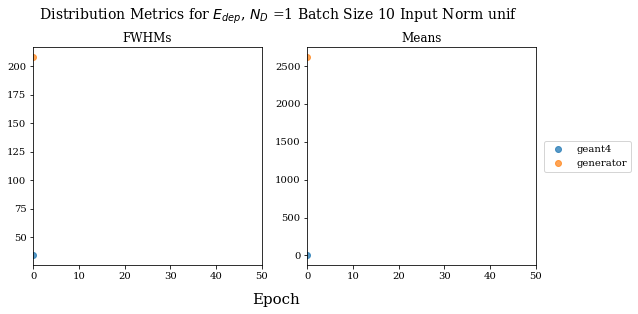

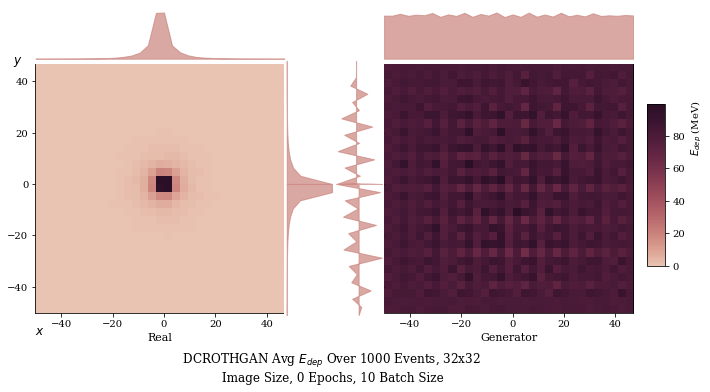

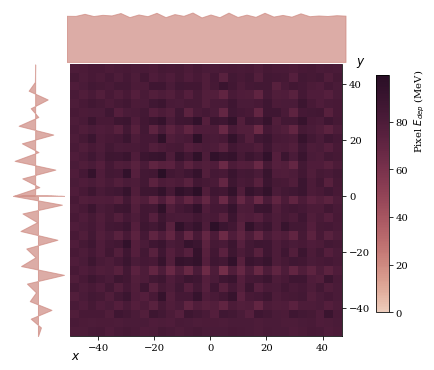

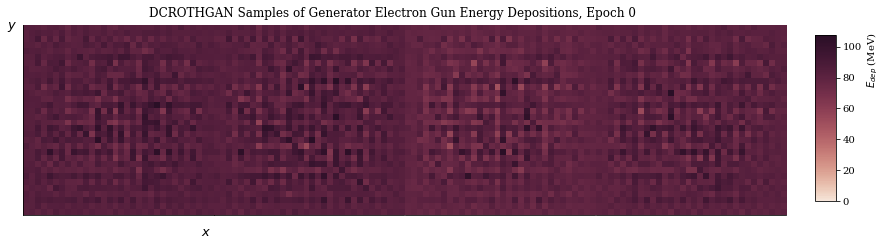

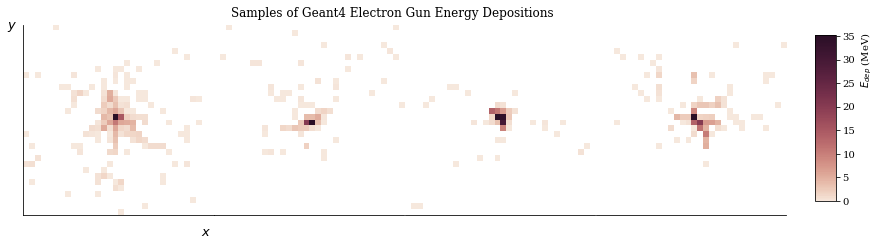

[0/100][0/3000] Loss_D: 2.0343 Loss_G: 7.2169 D(x): 0.4858 D(G(z)): 0.6935 / 0.0008
[0/100][100/3000] Loss_D: 0.0006 Loss_G: 8.5252 D(x): 0.9998 D(G(z)): 0.0004 / 0.0002
[0/100][200/3000] Loss_D: 0.0004 Loss_G: 8.7478 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[0/100][300/3000] Loss_D: 0.0002 Loss_G: 9.2993 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[0/100][400/3000] Loss_D: 0.0004 Loss_G: 9.1686 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[0/100][500/3000] Loss_D: 0.0002 Loss_G: 9.5464 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[0/100][600/3000] Loss_D: 0.0003 Loss_G: 9.4287 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[0/100][700/3000] Loss_D: 0.0160 Loss_G: 5.8709 D(x): 0.9889 D(G(z)): 0.0047 / 0.0028
[0/100][800/3000] Loss_D: 0.1511 Loss_G: 3.0348 D(x): 0.8753 D(G(z)): 0.0119 / 0.0483
[0/100][900/3000] Loss_D: 0.0545 Loss_G: 5.8533 D(x): 0.9599 D(G(z)): 0.0125 / 0.0029
[0/100][1000/3000] Loss_D: 0.7302 Loss_G: 1.4917 D(x): 0.7281 D(G(z)): 0.1700 / 0.2353
[0/100][1100/3000] Loss_D: 0.1167 Loss_G: 4.0276 D(x): 

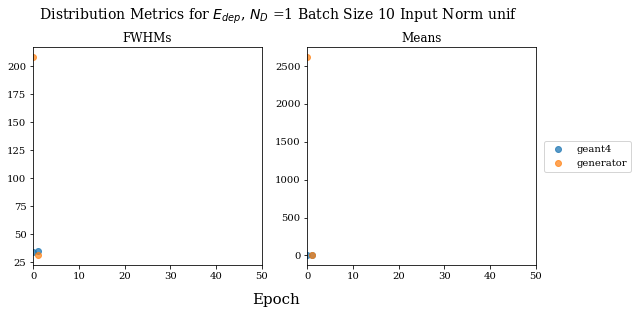

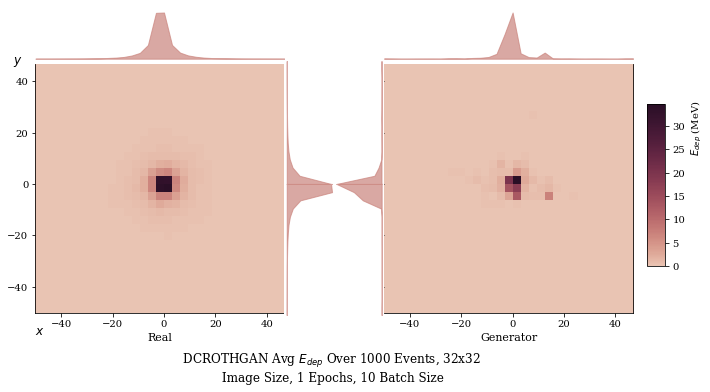

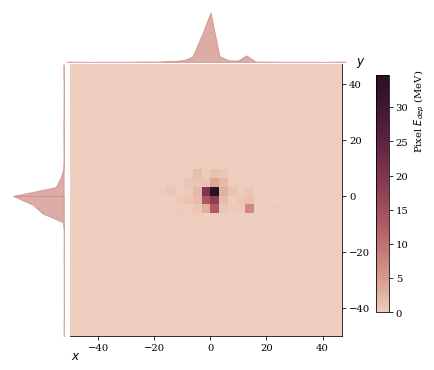

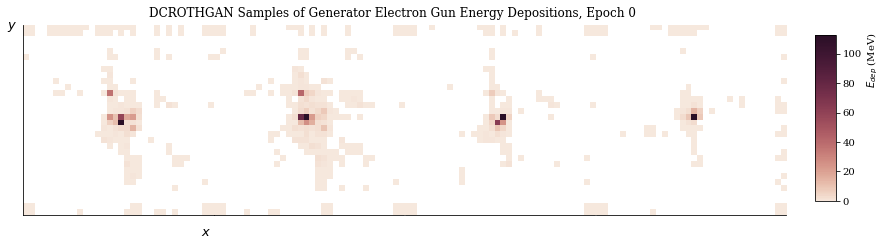

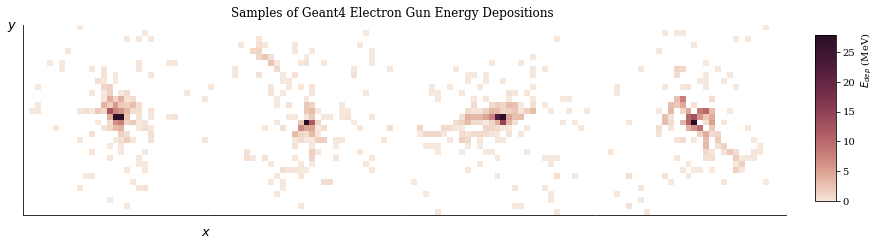

[1/100][0/3000] Loss_D: 0.3965 Loss_G: 2.8691 D(x): 0.8413 D(G(z)): 0.1233 / 0.0674
[1/100][100/3000] Loss_D: 0.1474 Loss_G: 3.2955 D(x): 0.8865 D(G(z)): 0.0217 / 0.0579
[1/100][200/3000] Loss_D: 0.2074 Loss_G: 3.1641 D(x): 0.9442 D(G(z)): 0.1266 / 0.0507
[1/100][300/3000] Loss_D: 0.8741 Loss_G: 3.2167 D(x): 0.5831 D(G(z)): 0.0246 / 0.0497
[1/100][400/3000] Loss_D: 0.4877 Loss_G: 2.9420 D(x): 0.7852 D(G(z)): 0.1581 / 0.0751
[1/100][500/3000] Loss_D: 0.9792 Loss_G: 1.1105 D(x): 0.5284 D(G(z)): 0.1163 / 0.3551
[1/100][600/3000] Loss_D: 1.1316 Loss_G: 3.1812 D(x): 0.8192 D(G(z)): 0.5264 / 0.0450
[1/100][700/3000] Loss_D: 0.2566 Loss_G: 4.2874 D(x): 0.9823 D(G(z)): 0.2054 / 0.0199
[1/100][800/3000] Loss_D: 0.1236 Loss_G: 3.5335 D(x): 0.9920 D(G(z)): 0.1059 / 0.0384
[1/100][900/3000] Loss_D: 0.9597 Loss_G: 1.3407 D(x): 0.6353 D(G(z)): 0.2150 / 0.3519
[1/100][1000/3000] Loss_D: 0.8360 Loss_G: 3.0181 D(x): 0.8218 D(G(z)): 0.4427 / 0.0606
[1/100][1100/3000] Loss_D: 0.2505 Loss_G: 4.6526 D(x): 

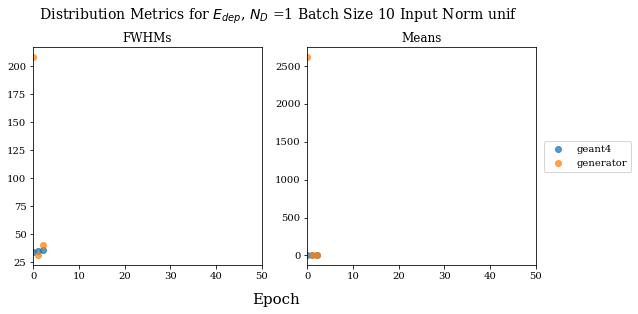

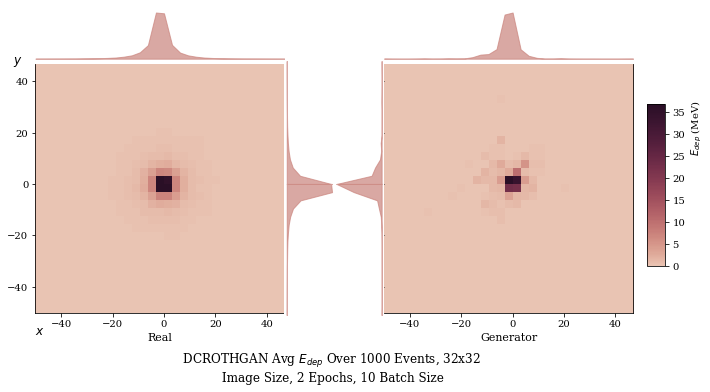

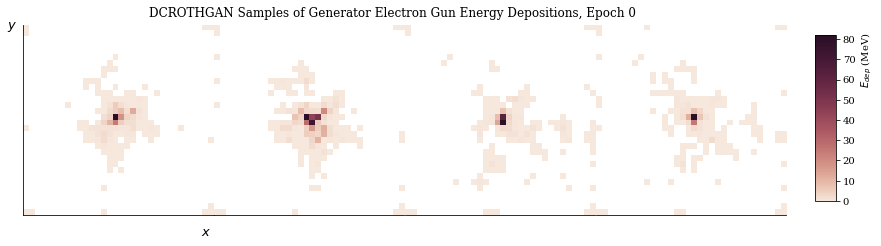

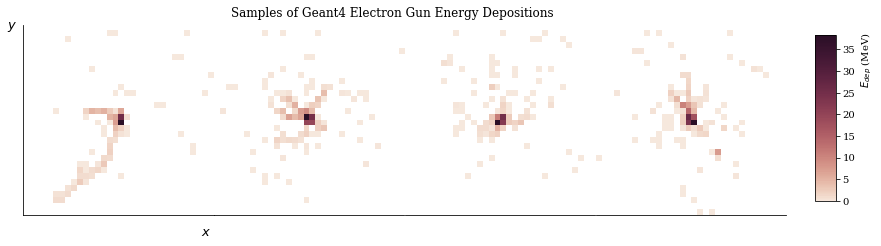

[2/100][0/3000] Loss_D: 0.7895 Loss_G: 2.6411 D(x): 0.9107 D(G(z)): 0.4400 / 0.0828
[2/100][100/3000] Loss_D: 0.4373 Loss_G: 2.8379 D(x): 0.9524 D(G(z)): 0.3136 / 0.0640
[2/100][200/3000] Loss_D: 1.4712 Loss_G: 4.6067 D(x): 0.9559 D(G(z)): 0.7129 / 0.0133
[2/100][300/3000] Loss_D: 0.4437 Loss_G: 2.2321 D(x): 0.8609 D(G(z)): 0.2146 / 0.1430
[2/100][400/3000] Loss_D: 0.4061 Loss_G: 3.3419 D(x): 0.8923 D(G(z)): 0.2331 / 0.0430
[2/100][500/3000] Loss_D: 0.1613 Loss_G: 4.2228 D(x): 0.9079 D(G(z)): 0.0462 / 0.0223
[2/100][600/3000] Loss_D: 0.5571 Loss_G: 3.6399 D(x): 0.9585 D(G(z)): 0.3705 / 0.0360
[2/100][700/3000] Loss_D: 0.1086 Loss_G: 2.6253 D(x): 0.9494 D(G(z)): 0.0521 / 0.0795
[2/100][800/3000] Loss_D: 1.6552 Loss_G: 6.1625 D(x): 0.9881 D(G(z)): 0.7633 / 0.0023
[2/100][900/3000] Loss_D: 0.1401 Loss_G: 3.1753 D(x): 0.9689 D(G(z)): 0.1005 / 0.0508
[2/100][1000/3000] Loss_D: 0.7274 Loss_G: 2.9328 D(x): 0.8511 D(G(z)): 0.3650 / 0.0909
[2/100][1100/3000] Loss_D: 0.3393 Loss_G: 3.4247 D(x): 

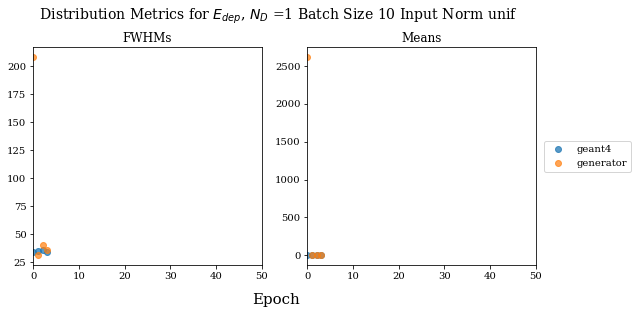

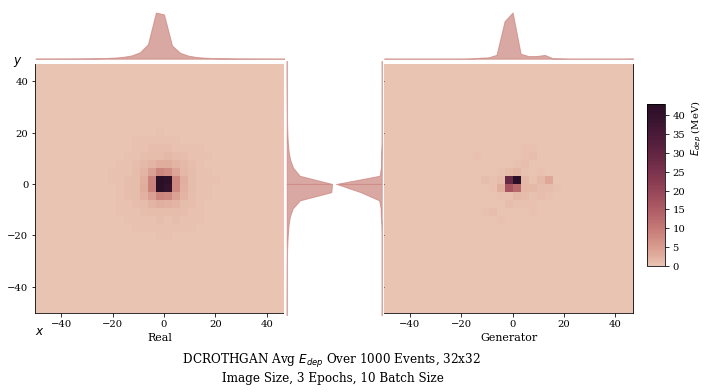

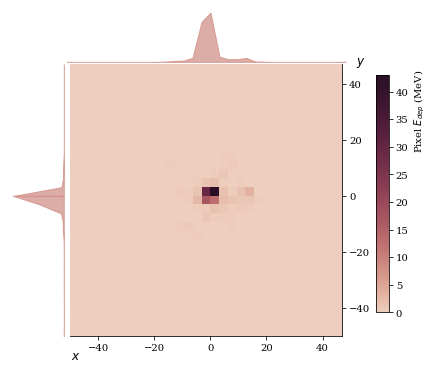

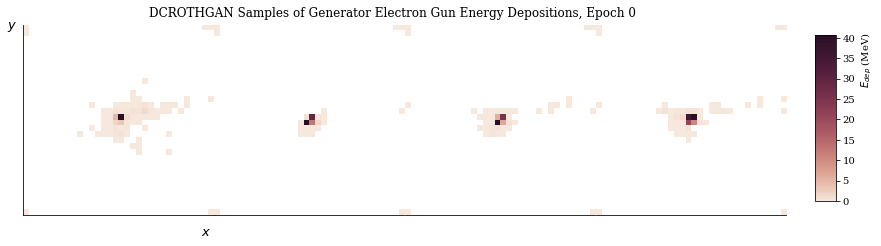

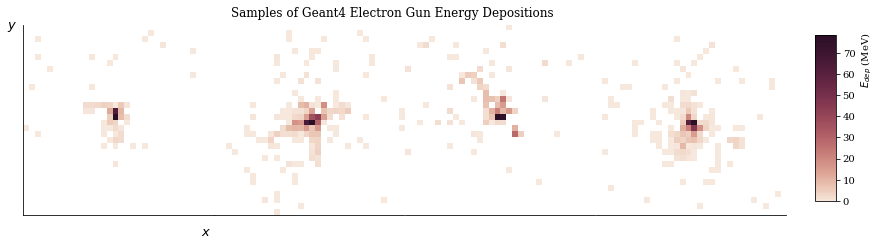

[3/100][0/3000] Loss_D: 0.1597 Loss_G: 2.1100 D(x): 0.9687 D(G(z)): 0.1161 / 0.1348
[3/100][100/3000] Loss_D: 0.1057 Loss_G: 4.5237 D(x): 0.9408 D(G(z)): 0.0413 / 0.0124
[3/100][200/3000] Loss_D: 0.3695 Loss_G: 2.7012 D(x): 0.9556 D(G(z)): 0.2579 / 0.0890
[3/100][300/3000] Loss_D: 0.0551 Loss_G: 4.5701 D(x): 0.9735 D(G(z)): 0.0273 / 0.0132
[3/100][400/3000] Loss_D: 0.5663 Loss_G: 0.7275 D(x): 0.7208 D(G(z)): 0.1772 / 0.5032
[3/100][500/3000] Loss_D: 0.7532 Loss_G: 3.4742 D(x): 0.9377 D(G(z)): 0.4717 / 0.0443
[3/100][600/3000] Loss_D: 0.4145 Loss_G: 3.2931 D(x): 0.9867 D(G(z)): 0.3107 / 0.0431
[3/100][700/3000] Loss_D: 0.3691 Loss_G: 2.8535 D(x): 0.9844 D(G(z)): 0.2819 / 0.0655
[3/100][800/3000] Loss_D: 0.1865 Loss_G: 2.3445 D(x): 0.9979 D(G(z)): 0.1438 / 0.1339
[3/100][900/3000] Loss_D: 0.3866 Loss_G: 2.6703 D(x): 0.8944 D(G(z)): 0.2305 / 0.0787
[3/100][1000/3000] Loss_D: 0.3068 Loss_G: 5.0663 D(x): 0.8463 D(G(z)): 0.0813 / 0.0102
[3/100][1100/3000] Loss_D: 0.9130 Loss_G: 3.0406 D(x): 

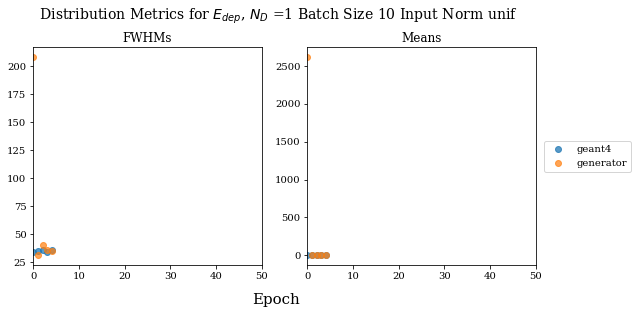

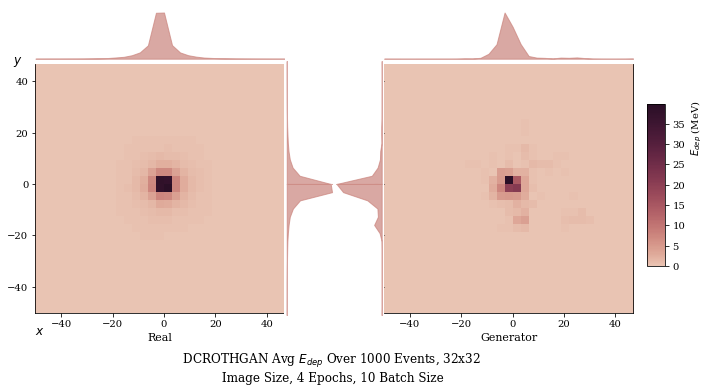

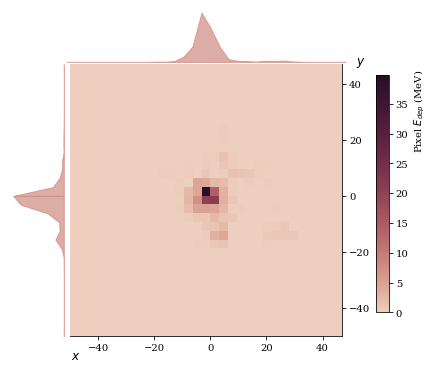

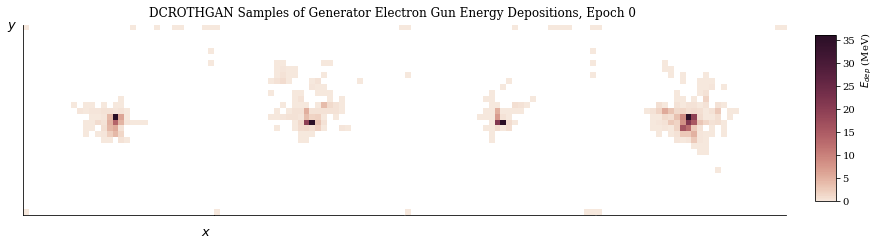

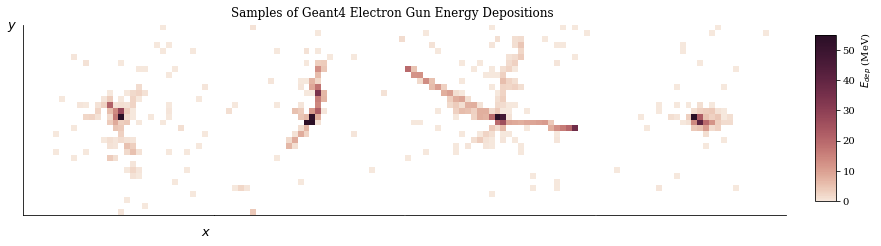

[4/100][0/3000] Loss_D: 0.1157 Loss_G: 2.5284 D(x): 0.9829 D(G(z)): 0.0925 / 0.0901
[4/100][100/3000] Loss_D: 0.1571 Loss_G: 4.0990 D(x): 0.8677 D(G(z)): 0.0115 / 0.0216
[4/100][200/3000] Loss_D: 0.2490 Loss_G: 1.4281 D(x): 0.8341 D(G(z)): 0.0517 / 0.2589
[4/100][300/3000] Loss_D: 0.6824 Loss_G: 3.8899 D(x): 0.9861 D(G(z)): 0.4681 / 0.0225
[4/100][400/3000] Loss_D: 0.5420 Loss_G: 1.1078 D(x): 0.6745 D(G(z)): 0.0976 / 0.3806
[4/100][500/3000] Loss_D: 0.3381 Loss_G: 0.1834 D(x): 0.8528 D(G(z)): 0.1596 / 0.8339
[4/100][600/3000] Loss_D: 0.2745 Loss_G: 2.3465 D(x): 0.9101 D(G(z)): 0.1610 / 0.1078
[4/100][700/3000] Loss_D: 0.1545 Loss_G: 4.3354 D(x): 0.9946 D(G(z)): 0.1330 / 0.0143
[4/100][800/3000] Loss_D: 0.2277 Loss_G: 2.8084 D(x): 0.9740 D(G(z)): 0.1744 / 0.0821
[4/100][900/3000] Loss_D: 0.2790 Loss_G: 2.1203 D(x): 0.8792 D(G(z)): 0.1266 / 0.1366
[4/100][1000/3000] Loss_D: 0.7717 Loss_G: 1.5988 D(x): 0.6827 D(G(z)): 0.1184 / 0.2166
[4/100][1100/3000] Loss_D: 0.7386 Loss_G: 4.1010 D(x): 

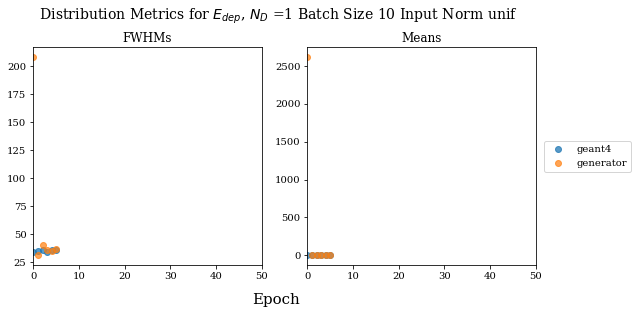

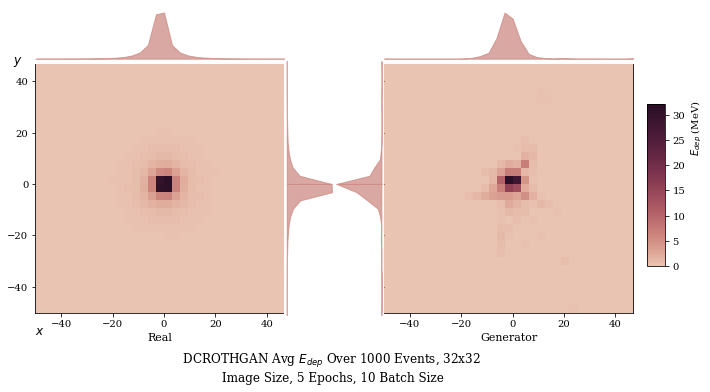

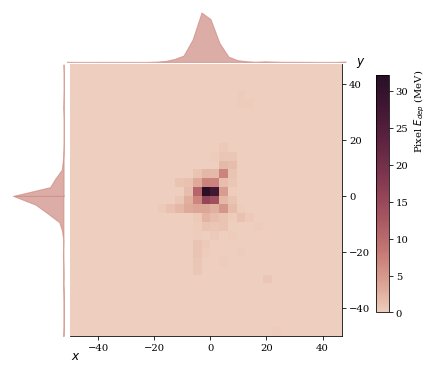

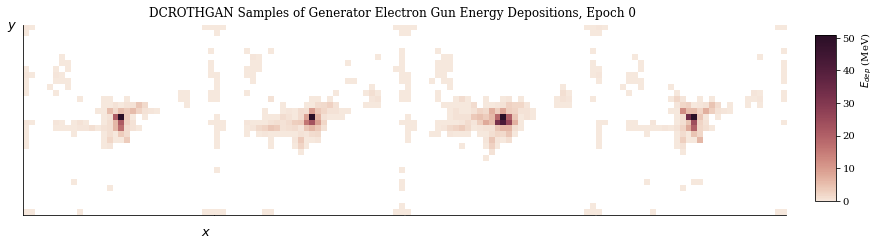

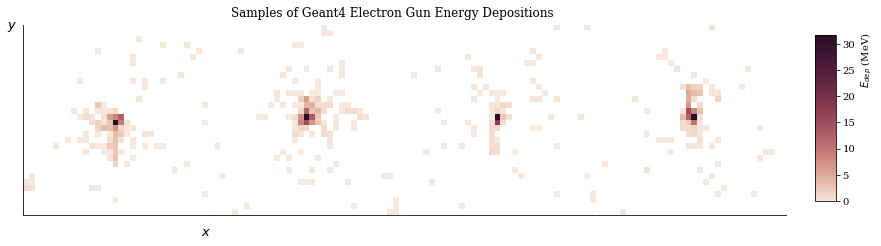

[5/100][0/3000] Loss_D: 0.2614 Loss_G: 1.2912 D(x): 0.8440 D(G(z)): 0.0706 / 0.3007
[5/100][100/3000] Loss_D: 0.1768 Loss_G: 3.1728 D(x): 0.9290 D(G(z)): 0.0941 / 0.0464
[5/100][200/3000] Loss_D: 0.3952 Loss_G: 1.1096 D(x): 0.7325 D(G(z)): 0.0540 / 0.3598
[5/100][300/3000] Loss_D: 0.2204 Loss_G: 3.0075 D(x): 0.9462 D(G(z)): 0.1382 / 0.0658
[5/100][400/3000] Loss_D: 0.4317 Loss_G: 1.4277 D(x): 0.8352 D(G(z)): 0.2093 / 0.2479
[5/100][500/3000] Loss_D: 0.2404 Loss_G: 3.2547 D(x): 0.8154 D(G(z)): 0.0136 / 0.0532
[5/100][600/3000] Loss_D: 0.1005 Loss_G: 3.7464 D(x): 0.9920 D(G(z)): 0.0866 / 0.0284
[5/100][700/3000] Loss_D: 0.1898 Loss_G: 2.6177 D(x): 0.9398 D(G(z)): 0.1153 / 0.0875
[5/100][800/3000] Loss_D: 0.3237 Loss_G: 2.4726 D(x): 0.9803 D(G(z)): 0.2580 / 0.0927
[5/100][900/3000] Loss_D: 0.2357 Loss_G: 2.6109 D(x): 0.9760 D(G(z)): 0.1848 / 0.0810
[5/100][1000/3000] Loss_D: 0.8578 Loss_G: 1.5073 D(x): 0.9081 D(G(z)): 0.4925 / 0.2319
[5/100][1100/3000] Loss_D: 0.1826 Loss_G: 3.8453 D(x): 

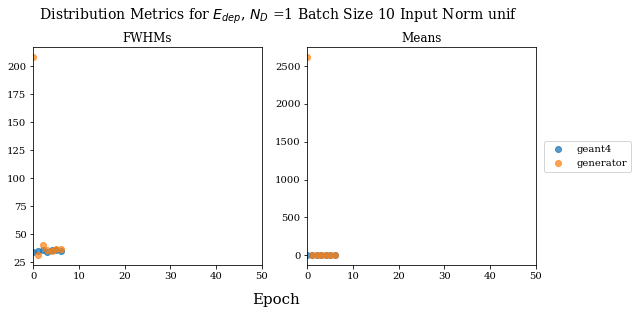

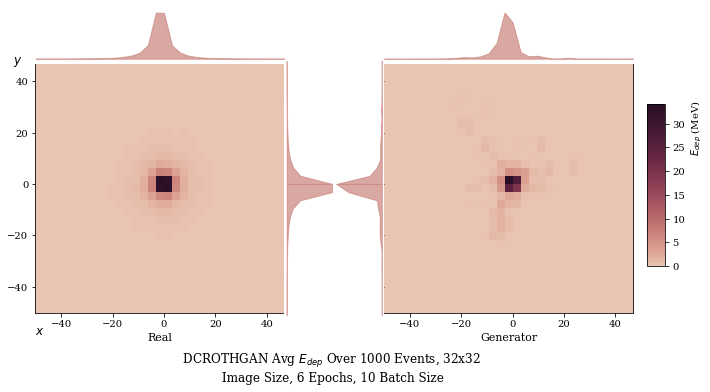

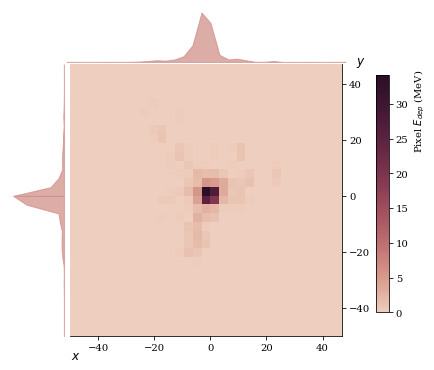

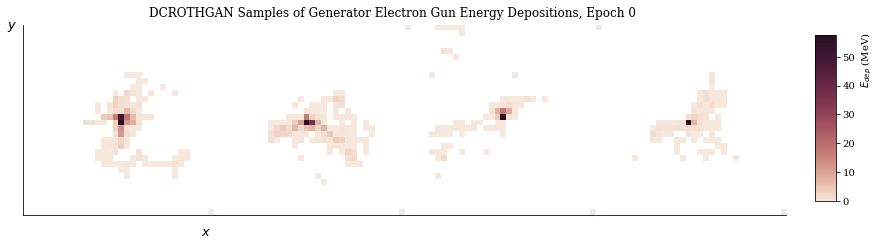

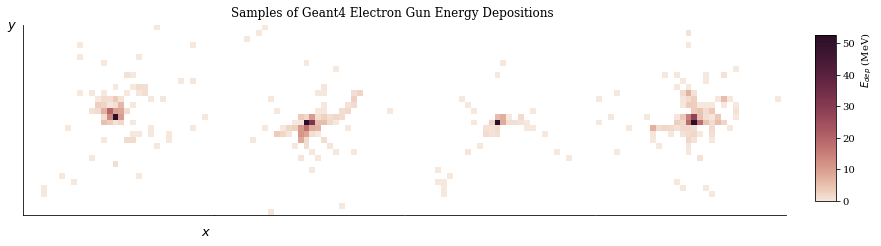

[6/100][0/3000] Loss_D: 0.3951 Loss_G: 1.1800 D(x): 0.8934 D(G(z)): 0.2302 / 0.3219
[6/100][100/3000] Loss_D: 0.2971 Loss_G: 0.8633 D(x): 0.8151 D(G(z)): 0.0837 / 0.4497
[6/100][200/3000] Loss_D: 0.1854 Loss_G: 1.4942 D(x): 0.8684 D(G(z)): 0.0327 / 0.2490
[6/100][300/3000] Loss_D: 0.1259 Loss_G: 4.4931 D(x): 0.8947 D(G(z)): 0.0117 / 0.0124
[6/100][400/3000] Loss_D: 0.1585 Loss_G: 2.5497 D(x): 0.8765 D(G(z)): 0.0219 / 0.1021
[6/100][500/3000] Loss_D: 0.1095 Loss_G: 3.3532 D(x): 0.9707 D(G(z)): 0.0758 / 0.0389
[6/100][600/3000] Loss_D: 0.2654 Loss_G: 2.4175 D(x): 0.9796 D(G(z)): 0.2147 / 0.0947
[6/100][700/3000] Loss_D: 0.0996 Loss_G: 4.1673 D(x): 0.9634 D(G(z)): 0.0596 / 0.0168
[6/100][800/3000] Loss_D: 0.7727 Loss_G: 3.2338 D(x): 0.9914 D(G(z)): 0.5112 / 0.0462
[6/100][900/3000] Loss_D: 0.3144 Loss_G: 2.3056 D(x): 0.8675 D(G(z)): 0.1357 / 0.1042
[6/100][1000/3000] Loss_D: 0.7444 Loss_G: 1.2493 D(x): 0.8969 D(G(z)): 0.4514 / 0.3031
[6/100][1100/3000] Loss_D: 0.4952 Loss_G: 2.6977 D(x): 

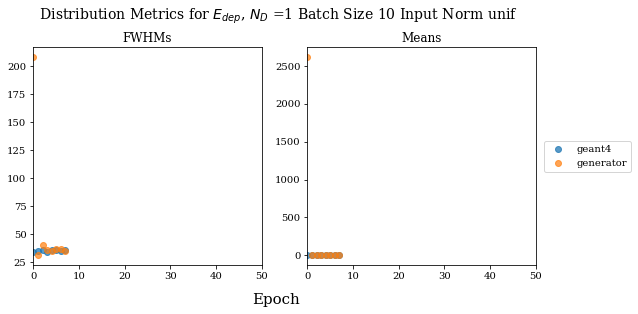

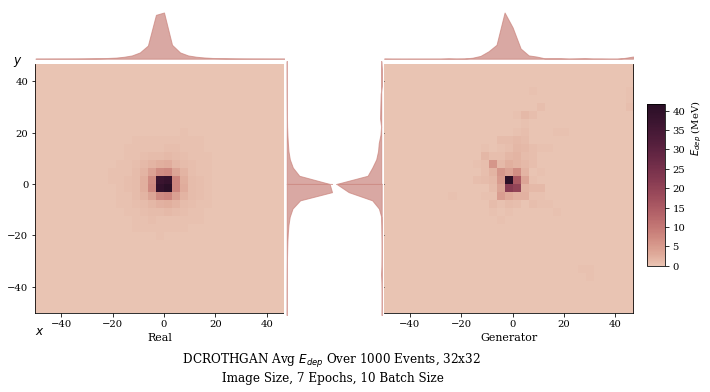

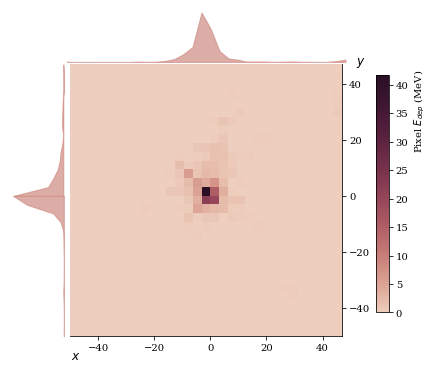

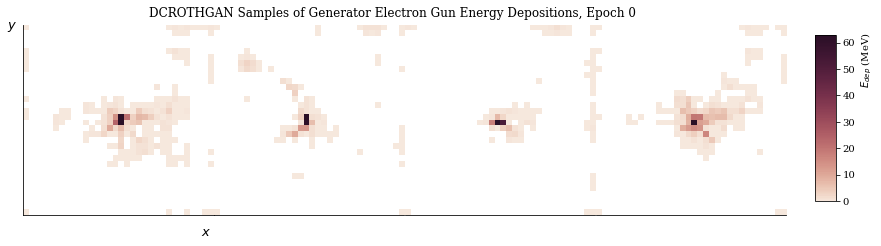

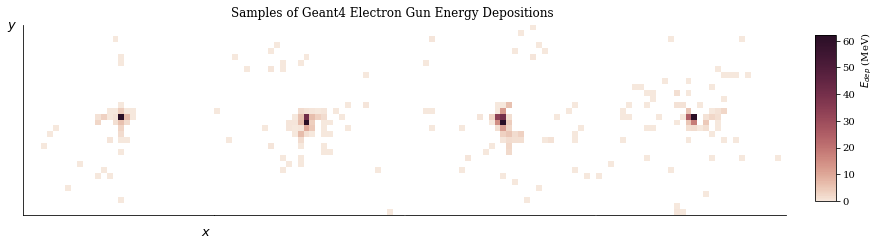

[7/100][0/3000] Loss_D: 0.3482 Loss_G: 2.2112 D(x): 0.7644 D(G(z)): 0.0485 / 0.1208
[7/100][100/3000] Loss_D: 0.1844 Loss_G: 3.0207 D(x): 0.9162 D(G(z)): 0.0842 / 0.0681
[7/100][200/3000] Loss_D: 0.6613 Loss_G: 1.2261 D(x): 0.5937 D(G(z)): 0.0450 / 0.3172
[7/100][300/3000] Loss_D: 0.1668 Loss_G: 2.2354 D(x): 0.9988 D(G(z)): 0.1519 / 0.1099
[7/100][400/3000] Loss_D: 0.1664 Loss_G: 2.4783 D(x): 0.8940 D(G(z)): 0.0404 / 0.0918
[7/100][500/3000] Loss_D: 0.0531 Loss_G: 4.0538 D(x): 0.9891 D(G(z)): 0.0412 / 0.0181
[7/100][600/3000] Loss_D: 1.3477 Loss_G: 5.1737 D(x): 0.9544 D(G(z)): 0.6930 / 0.0089
[7/100][700/3000] Loss_D: 0.3298 Loss_G: 2.7450 D(x): 0.7535 D(G(z)): 0.0312 / 0.0922
[7/100][800/3000] Loss_D: 0.6656 Loss_G: 3.0986 D(x): 0.9400 D(G(z)): 0.4048 / 0.0617
[7/100][900/3000] Loss_D: 2.0362 Loss_G: 3.5926 D(x): 0.9951 D(G(z)): 0.8596 / 0.0351
[7/100][1000/3000] Loss_D: 0.1473 Loss_G: 4.1538 D(x): 0.9481 D(G(z)): 0.0878 / 0.0174
[7/100][1100/3000] Loss_D: 0.0806 Loss_G: 3.6444 D(x): 

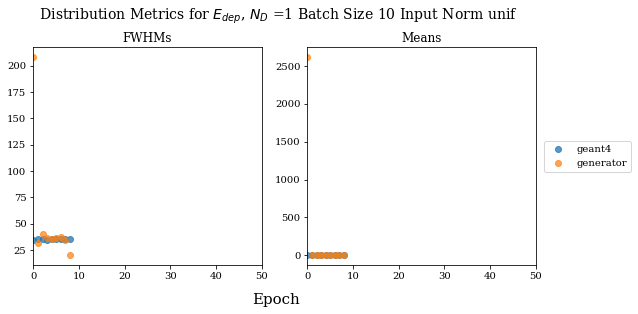

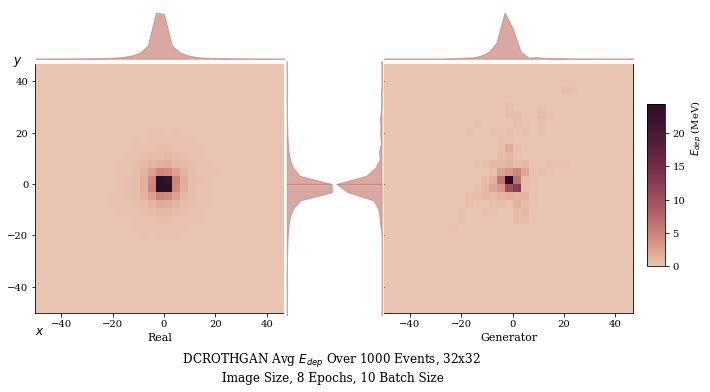

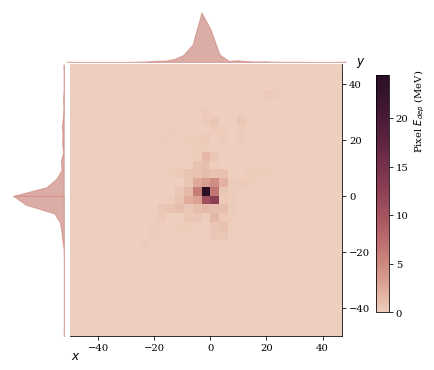

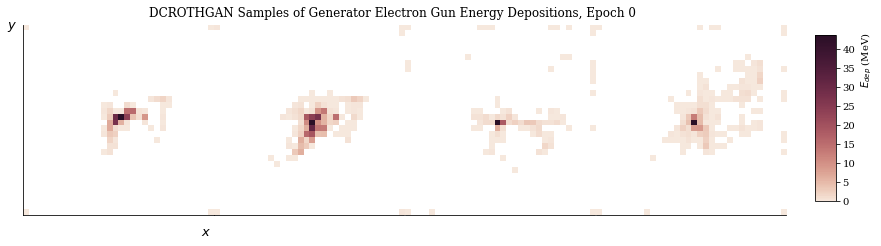

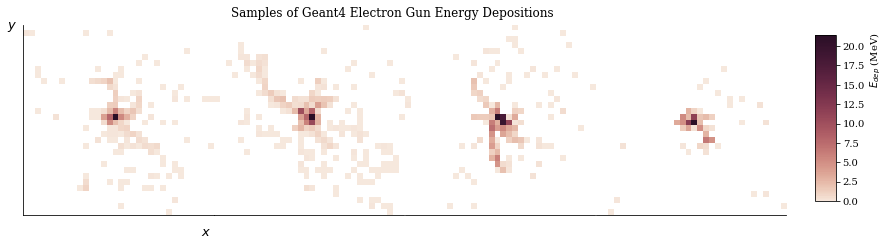

[8/100][0/3000] Loss_D: 0.2698 Loss_G: 4.5359 D(x): 0.7831 D(G(z)): 0.0125 / 0.0144
[8/100][100/3000] Loss_D: 0.6902 Loss_G: 3.7239 D(x): 0.9849 D(G(z)): 0.4708 / 0.0343
[8/100][200/3000] Loss_D: 0.6385 Loss_G: 0.3428 D(x): 0.7415 D(G(z)): 0.2485 / 0.7235
[8/100][300/3000] Loss_D: 0.1580 Loss_G: 4.4113 D(x): 0.9613 D(G(z)): 0.1085 / 0.0159
[8/100][400/3000] Loss_D: 0.1850 Loss_G: 1.8937 D(x): 0.8825 D(G(z)): 0.0519 / 0.1804
[8/100][500/3000] Loss_D: 0.5894 Loss_G: 2.8782 D(x): 0.9758 D(G(z)): 0.4177 / 0.0608
[8/100][600/3000] Loss_D: 0.1713 Loss_G: 3.9268 D(x): 0.9909 D(G(z)): 0.1391 / 0.0277
[8/100][700/3000] Loss_D: 0.1201 Loss_G: 3.1311 D(x): 0.9177 D(G(z)): 0.0284 / 0.0472
[8/100][800/3000] Loss_D: 0.5047 Loss_G: 2.7143 D(x): 0.9956 D(G(z)): 0.3825 / 0.0749
[8/100][900/3000] Loss_D: 0.2608 Loss_G: 1.2829 D(x): 0.8356 D(G(z)): 0.0702 / 0.2981
[8/100][1000/3000] Loss_D: 1.2747 Loss_G: 2.4211 D(x): 0.4070 D(G(z)): 0.0557 / 0.1144
[8/100][1100/3000] Loss_D: 0.5992 Loss_G: 3.1848 D(x): 

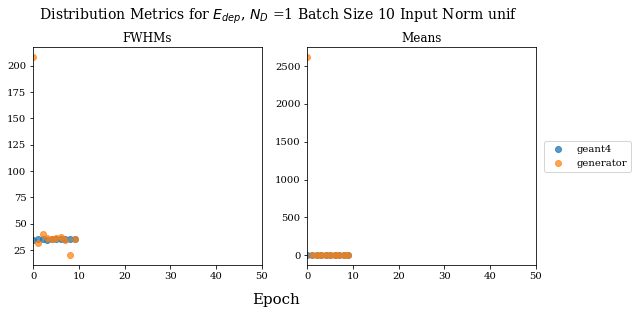

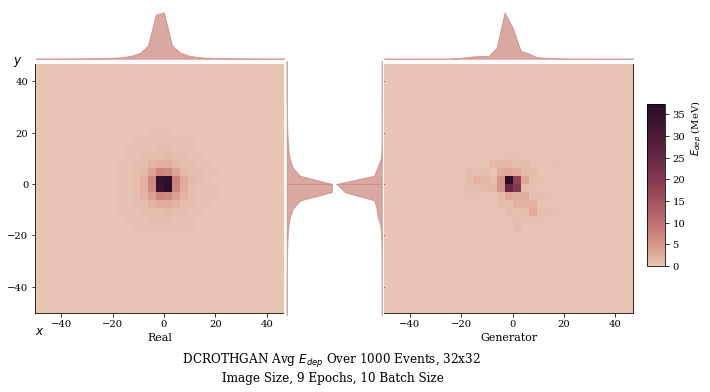

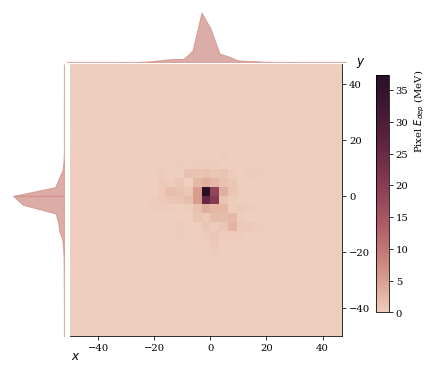

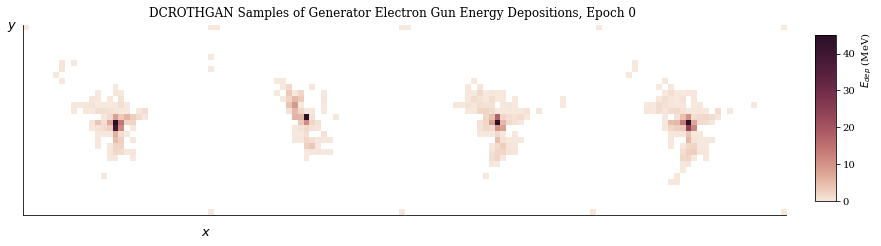

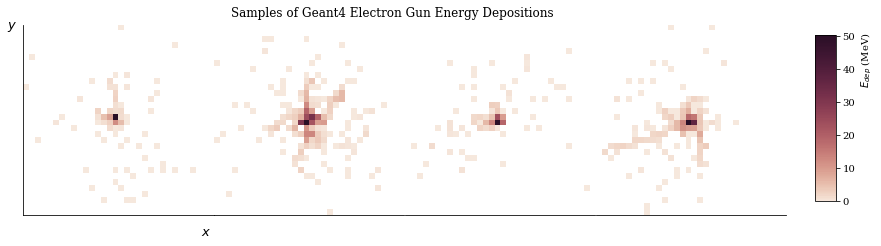

[9/100][0/3000] Loss_D: 0.2070 Loss_G: 3.3297 D(x): 0.9746 D(G(z)): 0.1566 / 0.0485
[9/100][100/3000] Loss_D: 0.1494 Loss_G: 5.0436 D(x): 0.9226 D(G(z)): 0.0436 / 0.0071
[9/100][200/3000] Loss_D: 1.0018 Loss_G: 3.7612 D(x): 0.4437 D(G(z)): 0.0407 / 0.0266
[9/100][300/3000] Loss_D: 1.2995 Loss_G: 2.7812 D(x): 0.8632 D(G(z)): 0.6300 / 0.0902
[9/100][400/3000] Loss_D: 0.8875 Loss_G: 3.7359 D(x): 0.4955 D(G(z)): 0.0992 / 0.0260
[9/100][500/3000] Loss_D: 0.3874 Loss_G: 3.0079 D(x): 0.9766 D(G(z)): 0.2940 / 0.0571
[9/100][600/3000] Loss_D: 0.3940 Loss_G: 1.2380 D(x): 0.8071 D(G(z)): 0.1527 / 0.3012
[9/100][700/3000] Loss_D: 0.2390 Loss_G: 2.4875 D(x): 0.9677 D(G(z)): 0.1839 / 0.0870
[9/100][800/3000] Loss_D: 0.1241 Loss_G: 3.4520 D(x): 0.9441 D(G(z)): 0.0604 / 0.0470
[9/100][900/3000] Loss_D: 0.1367 Loss_G: 3.4713 D(x): 0.9811 D(G(z)): 0.1096 / 0.0345
[9/100][1000/3000] Loss_D: 0.9833 Loss_G: 1.7742 D(x): 0.8798 D(G(z)): 0.5602 / 0.1834
[9/100][1100/3000] Loss_D: 1.3569 Loss_G: 5.5582 D(x): 

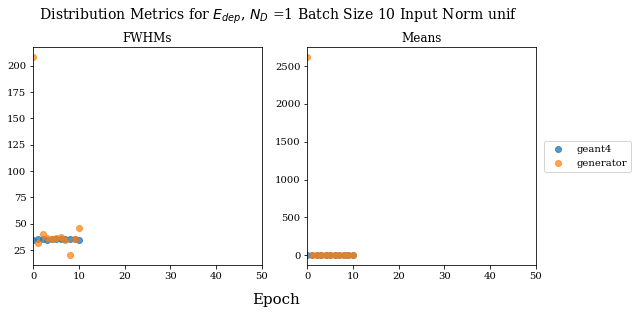

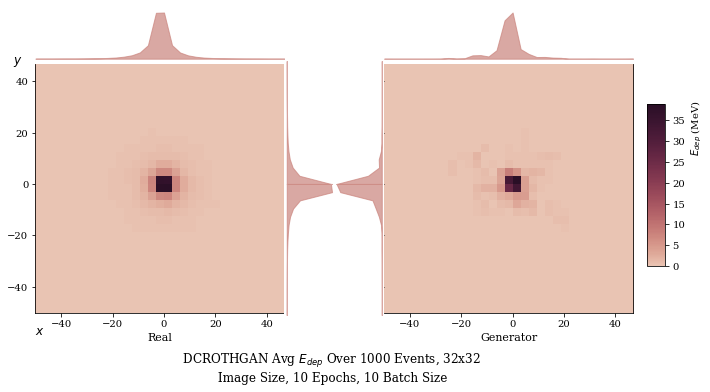

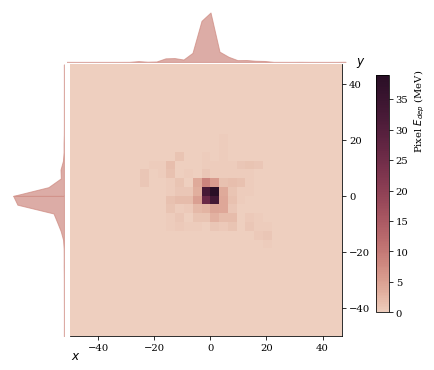

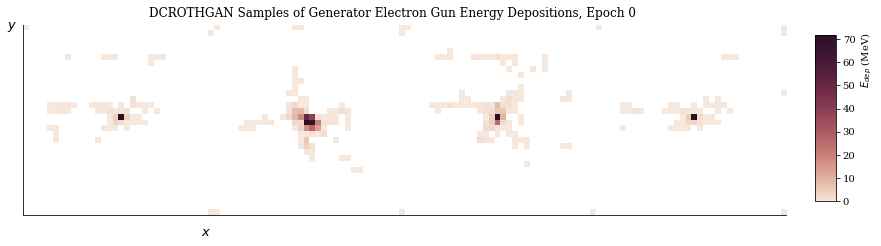

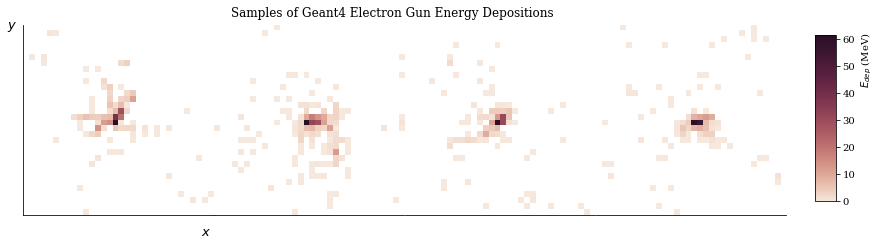

[10/100][0/3000] Loss_D: 0.4676 Loss_G: 1.1364 D(x): 0.8028 D(G(z)): 0.2064 / 0.3347
[10/100][100/3000] Loss_D: 0.1067 Loss_G: 2.5484 D(x): 0.9949 D(G(z)): 0.0943 / 0.0896
[10/100][200/3000] Loss_D: 0.6026 Loss_G: 0.7030 D(x): 0.6391 D(G(z)): 0.0825 / 0.5076
[10/100][300/3000] Loss_D: 0.1086 Loss_G: 5.5758 D(x): 0.9713 D(G(z)): 0.0752 / 0.0045
[10/100][400/3000] Loss_D: 0.2764 Loss_G: 1.8556 D(x): 0.9145 D(G(z)): 0.1586 / 0.1668
[10/100][500/3000] Loss_D: 0.2913 Loss_G: 0.8569 D(x): 0.8329 D(G(z)): 0.0959 / 0.4399
[10/100][600/3000] Loss_D: 0.1680 Loss_G: 2.0635 D(x): 0.9842 D(G(z)): 0.1371 / 0.1480
[10/100][700/3000] Loss_D: 0.4061 Loss_G: 0.6690 D(x): 0.7881 D(G(z)): 0.1449 / 0.5253
[10/100][800/3000] Loss_D: 0.3115 Loss_G: 2.0871 D(x): 0.9517 D(G(z)): 0.2272 / 0.1320
[10/100][900/3000] Loss_D: 0.2120 Loss_G: 1.4806 D(x): 0.8598 D(G(z)): 0.0538 / 0.2590
[10/100][1000/3000] Loss_D: 0.5680 Loss_G: 1.0387 D(x): 0.8882 D(G(z)): 0.3444 / 0.3706
[10/100][1100/3000] Loss_D: 1.2187 Loss_G: 1

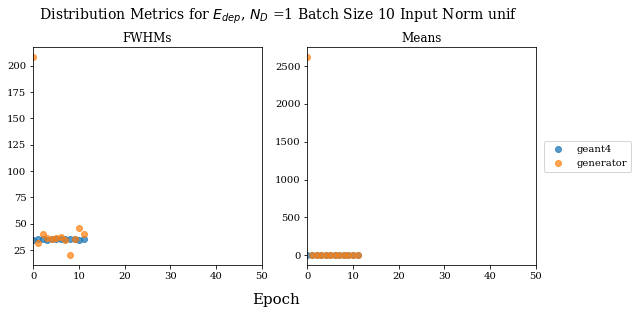

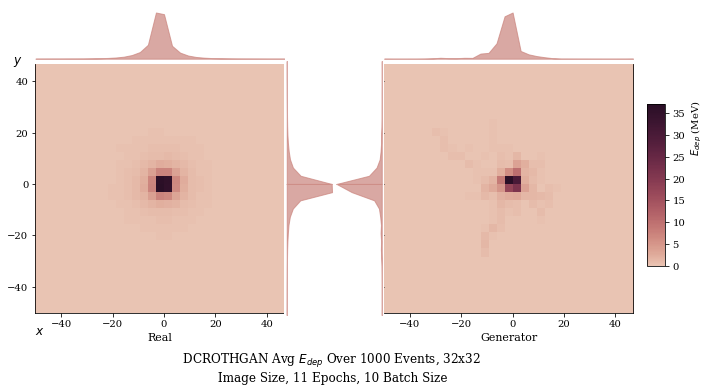

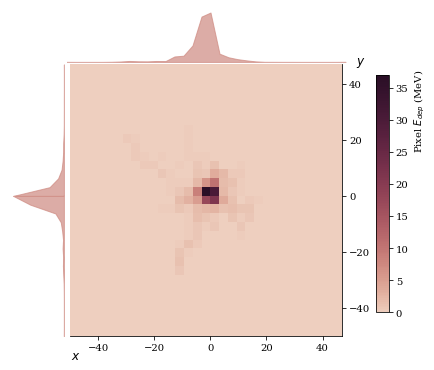

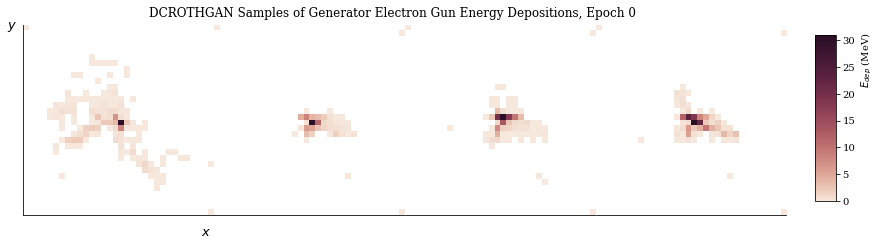

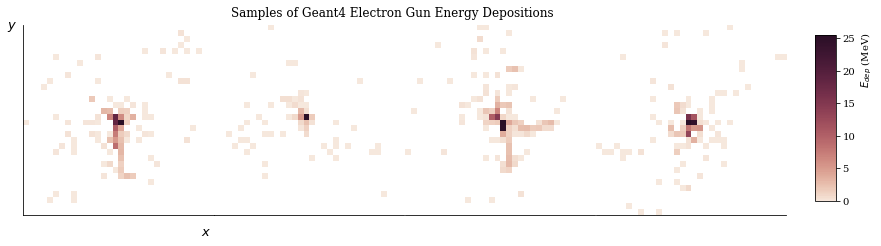

[11/100][0/3000] Loss_D: 0.5270 Loss_G: 0.9318 D(x): 0.7069 D(G(z)): 0.1252 / 0.4321
[11/100][100/3000] Loss_D: 1.7625 Loss_G: 2.8838 D(x): 0.9986 D(G(z)): 0.7692 / 0.0789
[11/100][200/3000] Loss_D: 0.1357 Loss_G: 2.7479 D(x): 0.9014 D(G(z)): 0.0251 / 0.0680
[11/100][300/3000] Loss_D: 0.3490 Loss_G: 2.2006 D(x): 0.9368 D(G(z)): 0.2360 / 0.1233
[11/100][400/3000] Loss_D: 0.3005 Loss_G: 1.5610 D(x): 0.8997 D(G(z)): 0.1640 / 0.2597
[11/100][500/3000] Loss_D: 0.0843 Loss_G: 3.3716 D(x): 0.9967 D(G(z)): 0.0768 / 0.0397
[11/100][600/3000] Loss_D: 0.6069 Loss_G: 3.5418 D(x): 0.9898 D(G(z)): 0.4229 / 0.0348
[11/100][700/3000] Loss_D: 0.2252 Loss_G: 2.6224 D(x): 0.9590 D(G(z)): 0.1646 / 0.0821
[11/100][800/3000] Loss_D: 0.0996 Loss_G: 3.2608 D(x): 0.9675 D(G(z)): 0.0631 / 0.0474
[11/100][900/3000] Loss_D: 1.0526 Loss_G: 2.2495 D(x): 0.9951 D(G(z)): 0.6144 / 0.1367
[11/100][1000/3000] Loss_D: 0.4309 Loss_G: 2.0205 D(x): 0.9485 D(G(z)): 0.3023 / 0.1431
[11/100][1100/3000] Loss_D: 1.2570 Loss_G: 3

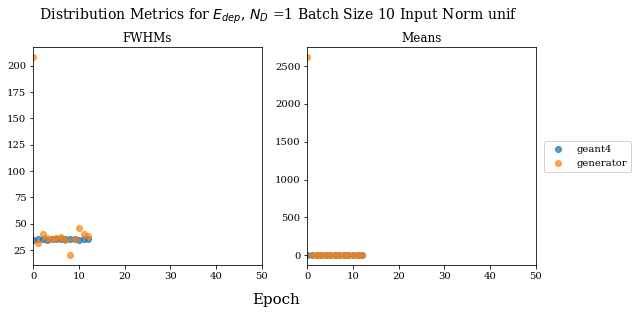

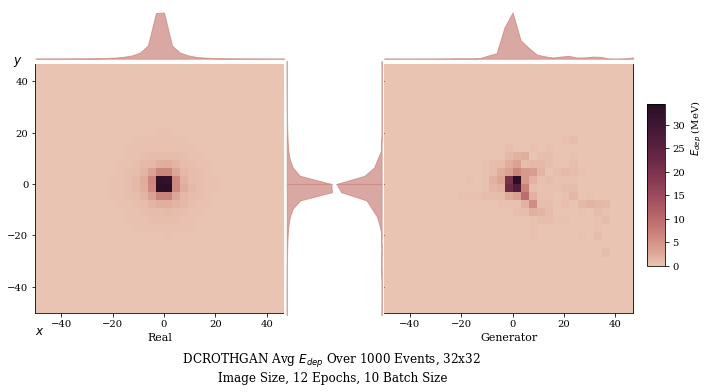

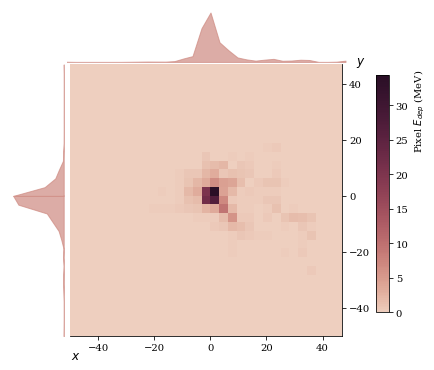

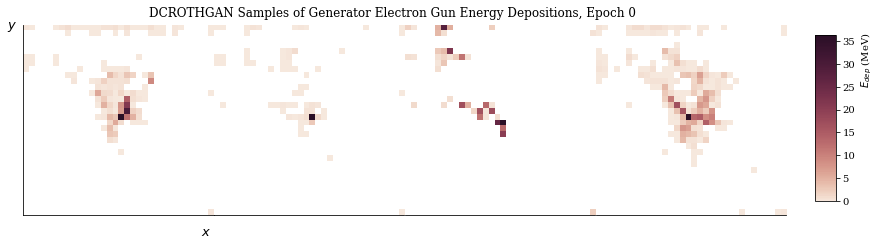

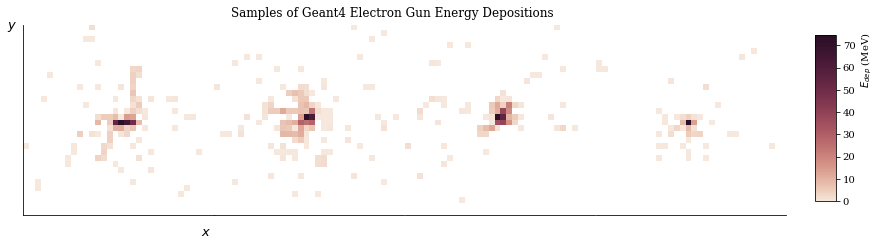

[12/100][0/3000] Loss_D: 0.4446 Loss_G: 1.8879 D(x): 0.9736 D(G(z)): 0.3338 / 0.1589
[12/100][100/3000] Loss_D: 0.2547 Loss_G: 2.4179 D(x): 0.9937 D(G(z)): 0.2117 / 0.1010
[12/100][200/3000] Loss_D: 0.2065 Loss_G: 3.0261 D(x): 0.8453 D(G(z)): 0.0232 / 0.0618
[12/100][300/3000] Loss_D: 0.1050 Loss_G: 3.6934 D(x): 0.9474 D(G(z)): 0.0486 / 0.0291
[12/100][400/3000] Loss_D: 0.1966 Loss_G: 2.6191 D(x): 0.8342 D(G(z)): 0.0077 / 0.0768
[12/100][500/3000] Loss_D: 0.5048 Loss_G: 0.7013 D(x): 0.6461 D(G(z)): 0.0323 / 0.5103
[12/100][600/3000] Loss_D: 0.9121 Loss_G: 3.6941 D(x): 0.9975 D(G(z)): 0.5837 / 0.0270
[12/100][700/3000] Loss_D: 0.2022 Loss_G: 2.9015 D(x): 0.9951 D(G(z)): 0.1763 / 0.0603
[12/100][800/3000] Loss_D: 0.3505 Loss_G: 2.4357 D(x): 0.9642 D(G(z)): 0.2641 / 0.0909
[12/100][900/3000] Loss_D: 0.3262 Loss_G: 2.6946 D(x): 0.9821 D(G(z)): 0.2392 / 0.0849
[12/100][1000/3000] Loss_D: 0.2967 Loss_G: 3.3588 D(x): 0.9892 D(G(z)): 0.2344 / 0.0420
[12/100][1100/3000] Loss_D: 0.3941 Loss_G: 3

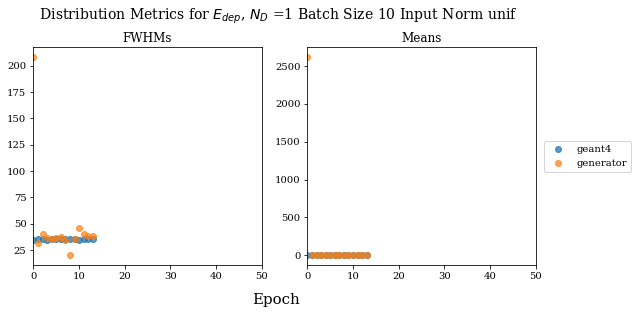

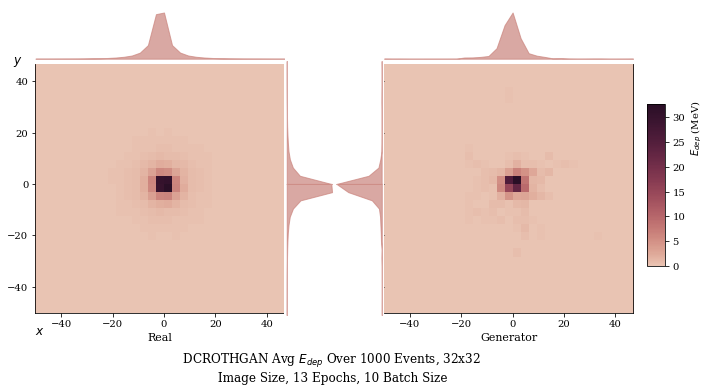

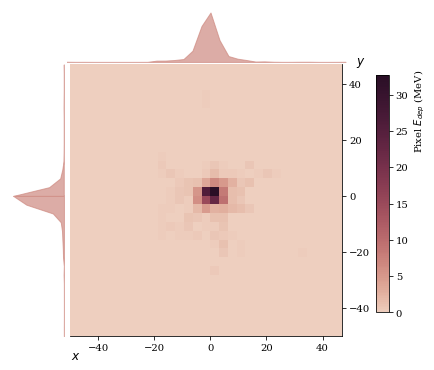

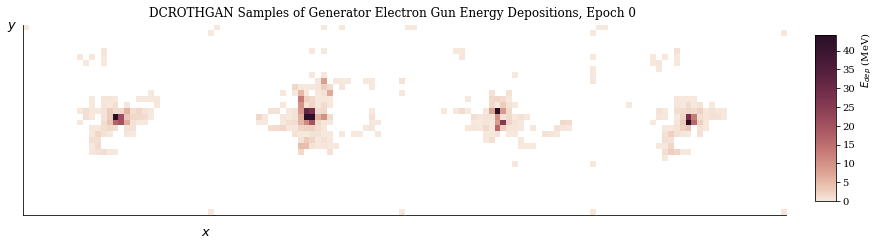

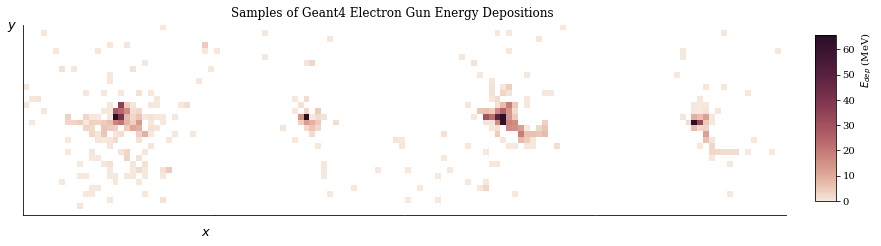

[13/100][0/3000] Loss_D: 0.1539 Loss_G: 2.8692 D(x): 0.9347 D(G(z)): 0.0786 / 0.0639
[13/100][100/3000] Loss_D: 0.3615 Loss_G: 3.1419 D(x): 0.9664 D(G(z)): 0.2755 / 0.0450
[13/100][200/3000] Loss_D: 0.5379 Loss_G: 3.0018 D(x): 0.6615 D(G(z)): 0.0222 / 0.0558
[13/100][300/3000] Loss_D: 0.1289 Loss_G: 2.5497 D(x): 0.9368 D(G(z)): 0.0610 / 0.0817
[13/100][400/3000] Loss_D: 0.4287 Loss_G: 0.6701 D(x): 0.7347 D(G(z)): 0.0900 / 0.5279
[13/100][500/3000] Loss_D: 0.1163 Loss_G: 2.9561 D(x): 0.9880 D(G(z)): 0.0964 / 0.0659
[13/100][600/3000] Loss_D: 0.2783 Loss_G: 2.6812 D(x): 0.9952 D(G(z)): 0.2362 / 0.0728
[13/100][700/3000] Loss_D: 0.3456 Loss_G: 3.6949 D(x): 0.9977 D(G(z)): 0.2834 / 0.0282
[13/100][800/3000] Loss_D: 1.7575 Loss_G: 3.4010 D(x): 0.9953 D(G(z)): 0.7901 / 0.0470
[13/100][900/3000] Loss_D: 0.0918 Loss_G: 3.8086 D(x): 0.9342 D(G(z)): 0.0197 / 0.0332
[13/100][1000/3000] Loss_D: 0.2753 Loss_G: 1.2632 D(x): 0.8350 D(G(z)): 0.0812 / 0.2980
[13/100][1100/3000] Loss_D: 0.1560 Loss_G: 4

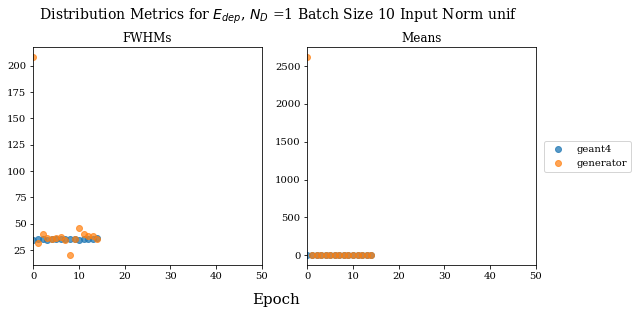

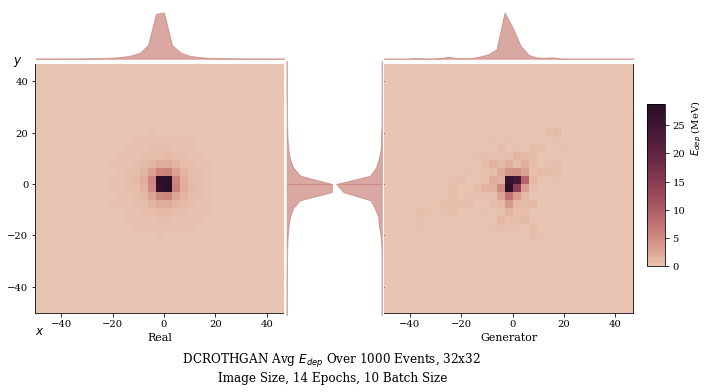

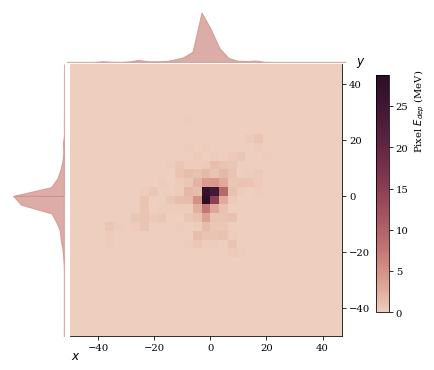

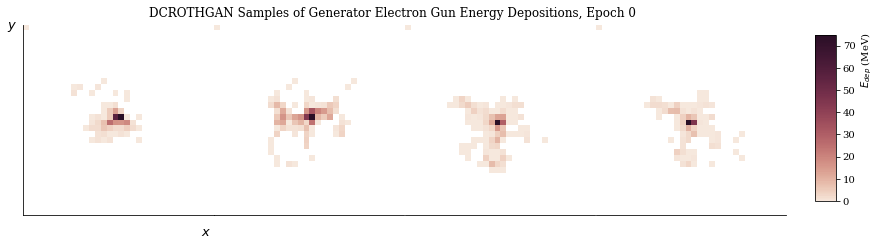

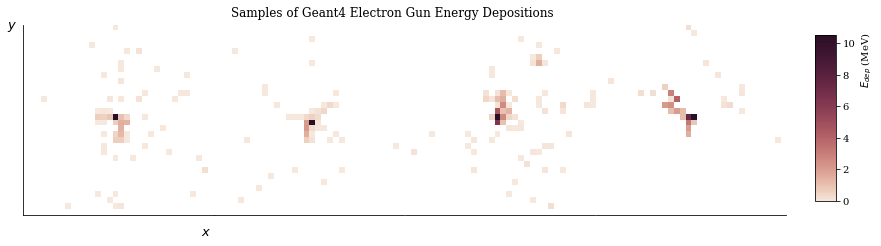

[14/100][0/3000] Loss_D: 0.4576 Loss_G: 1.5405 D(x): 0.6773 D(G(z)): 0.0365 / 0.2366
[14/100][100/3000] Loss_D: 0.2472 Loss_G: 1.4951 D(x): 0.9867 D(G(z)): 0.2072 / 0.2285
[14/100][200/3000] Loss_D: 0.7681 Loss_G: 1.1347 D(x): 0.8590 D(G(z)): 0.4159 / 0.3517
[14/100][300/3000] Loss_D: 0.1403 Loss_G: 2.7688 D(x): 0.9136 D(G(z)): 0.0455 / 0.0790
[14/100][400/3000] Loss_D: 0.8004 Loss_G: 4.1146 D(x): 0.9949 D(G(z)): 0.5216 / 0.0210
[14/100][500/3000] Loss_D: 0.1311 Loss_G: 4.1961 D(x): 0.9121 D(G(z)): 0.0315 / 0.0187
[14/100][600/3000] Loss_D: 0.1783 Loss_G: 2.8116 D(x): 0.9959 D(G(z)): 0.1565 / 0.0689
[14/100][700/3000] Loss_D: 0.1550 Loss_G: 1.5465 D(x): 0.8818 D(G(z)): 0.0191 / 0.2342
[14/100][800/3000] Loss_D: 0.2994 Loss_G: 1.5311 D(x): 0.7871 D(G(z)): 0.0454 / 0.2460
[14/100][900/3000] Loss_D: 0.2555 Loss_G: 2.1823 D(x): 0.9521 D(G(z)): 0.1792 / 0.1285
[14/100][1000/3000] Loss_D: 0.2775 Loss_G: 1.9490 D(x): 0.9785 D(G(z)): 0.2208 / 0.1611
[14/100][1100/3000] Loss_D: 0.3678 Loss_G: 3

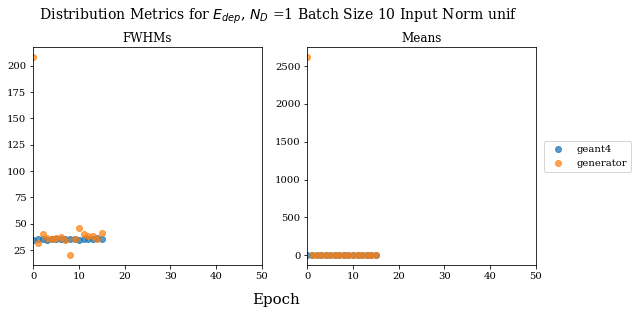

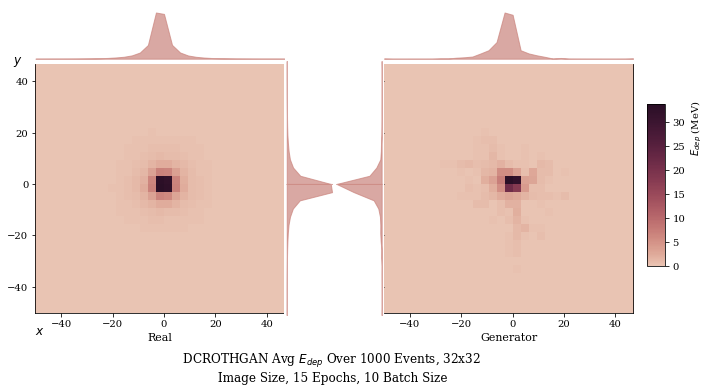

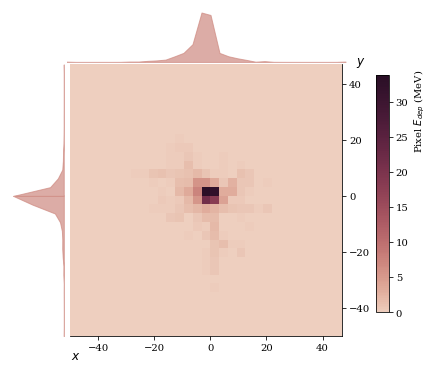

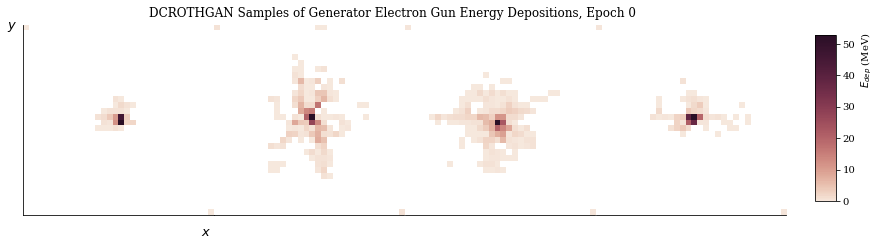

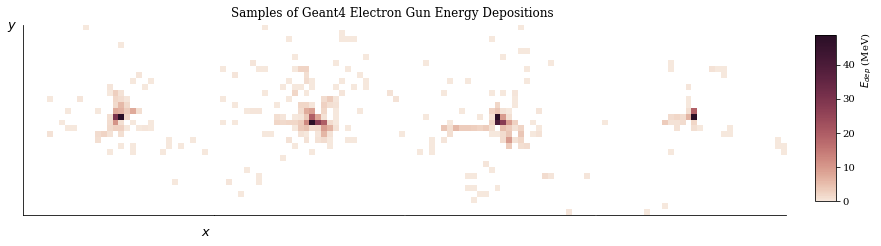

[15/100][0/3000] Loss_D: 0.3228 Loss_G: 1.8469 D(x): 0.9086 D(G(z)): 0.1915 / 0.1807
[15/100][100/3000] Loss_D: 0.1575 Loss_G: 5.0102 D(x): 0.9861 D(G(z)): 0.1312 / 0.0079
[15/100][200/3000] Loss_D: 0.2525 Loss_G: 2.9321 D(x): 0.8393 D(G(z)): 0.0216 / 0.0703
[15/100][300/3000] Loss_D: 0.0912 Loss_G: 5.0708 D(x): 0.9419 D(G(z)): 0.0298 / 0.0070
[15/100][400/3000] Loss_D: 0.8185 Loss_G: 0.4321 D(x): 0.7169 D(G(z)): 0.3513 / 0.6629
[15/100][500/3000] Loss_D: 1.2305 Loss_G: 3.4153 D(x): 0.9974 D(G(z)): 0.6471 / 0.0412
[15/100][600/3000] Loss_D: 0.0620 Loss_G: 4.8375 D(x): 0.9730 D(G(z)): 0.0331 / 0.0135
[15/100][700/3000] Loss_D: 0.1100 Loss_G: 3.9978 D(x): 0.9901 D(G(z)): 0.0918 / 0.0267
[15/100][800/3000] Loss_D: 0.8379 Loss_G: 0.6821 D(x): 0.8489 D(G(z)): 0.4531 / 0.5481
[15/100][900/3000] Loss_D: 1.9456 Loss_G: 2.9226 D(x): 0.9998 D(G(z)): 0.8041 / 0.0859
[15/100][1000/3000] Loss_D: 0.1191 Loss_G: 2.7428 D(x): 0.9594 D(G(z)): 0.0738 / 0.0731
[15/100][1100/3000] Loss_D: 0.2527 Loss_G: 1

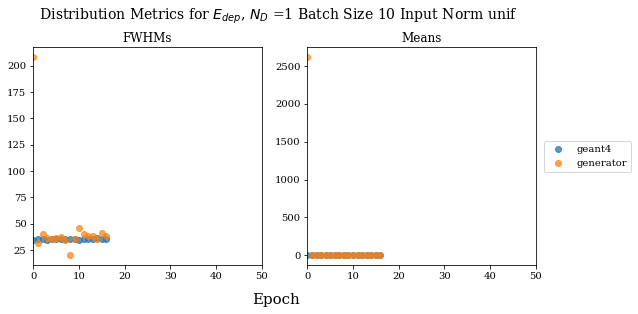

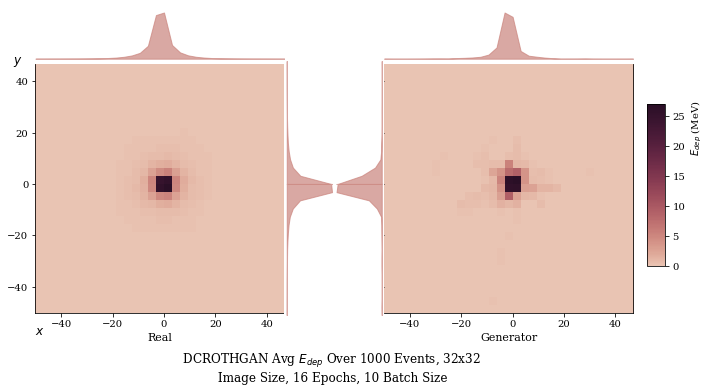

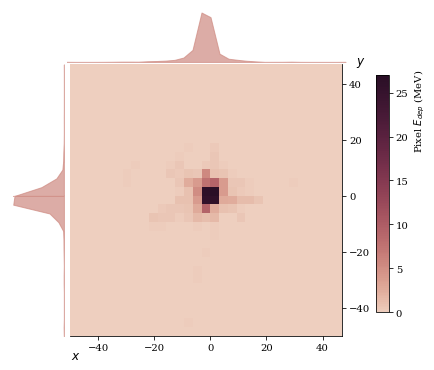

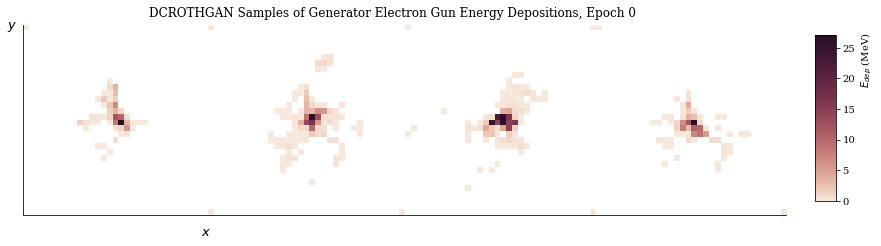

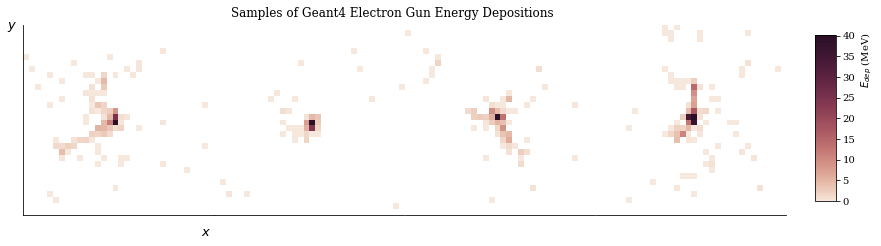

[16/100][0/3000] Loss_D: 0.7480 Loss_G: 1.5812 D(x): 0.8845 D(G(z)): 0.4413 / 0.2289
[16/100][100/3000] Loss_D: 1.1068 Loss_G: 4.3553 D(x): 0.9774 D(G(z)): 0.6503 / 0.0149
[16/100][200/3000] Loss_D: 0.3696 Loss_G: 0.5117 D(x): 0.7956 D(G(z)): 0.1183 / 0.6035
[16/100][300/3000] Loss_D: 0.2232 Loss_G: 2.6076 D(x): 0.9115 D(G(z)): 0.1074 / 0.1020
[16/100][400/3000] Loss_D: 0.3953 Loss_G: 1.5165 D(x): 0.6988 D(G(z)): 0.0148 / 0.2538
[16/100][500/3000] Loss_D: 0.1036 Loss_G: 4.2472 D(x): 0.9987 D(G(z)): 0.0957 / 0.0165
[16/100][600/3000] Loss_D: 0.1447 Loss_G: 2.0401 D(x): 0.9978 D(G(z)): 0.1313 / 0.1411
[16/100][700/3000] Loss_D: 0.4585 Loss_G: 1.8704 D(x): 0.9725 D(G(z)): 0.3335 / 0.1672
[16/100][800/3000] Loss_D: 0.3732 Loss_G: 1.6655 D(x): 0.8759 D(G(z)): 0.1970 / 0.2217
[16/100][900/3000] Loss_D: 0.7913 Loss_G: 1.9718 D(x): 0.9928 D(G(z)): 0.4696 / 0.1961
[16/100][1000/3000] Loss_D: 0.2065 Loss_G: 2.9157 D(x): 0.9916 D(G(z)): 0.1654 / 0.0732
[16/100][1100/3000] Loss_D: 0.0690 Loss_G: 4

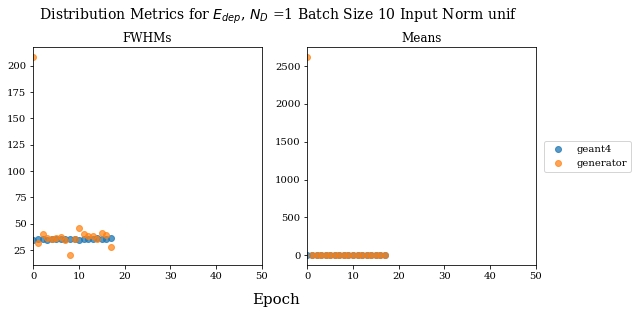

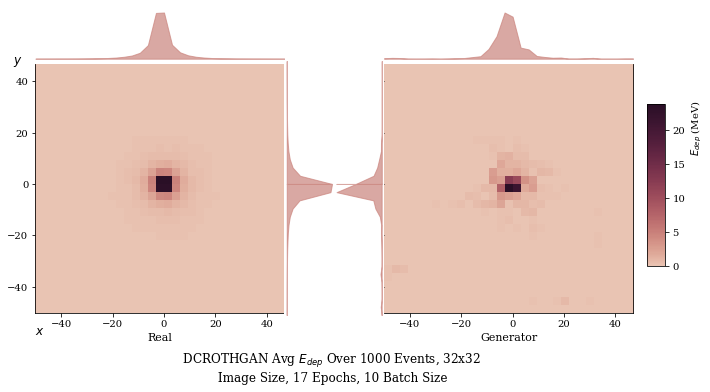

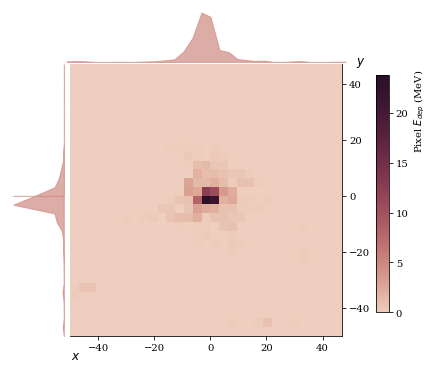

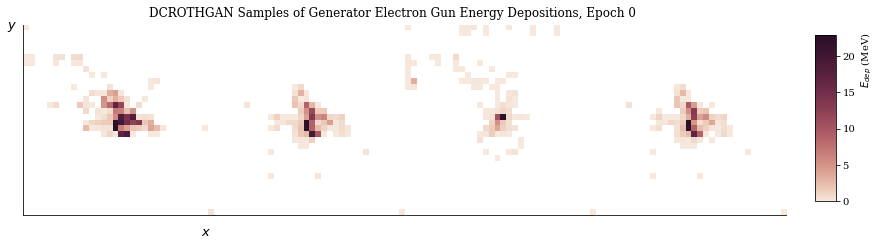

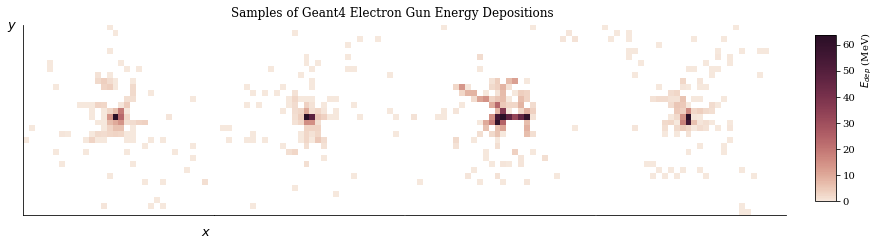

[17/100][0/3000] Loss_D: 0.1127 Loss_G: 3.0416 D(x): 0.9431 D(G(z)): 0.0480 / 0.0515
[17/100][100/3000] Loss_D: 0.1246 Loss_G: 2.5453 D(x): 0.9700 D(G(z)): 0.0880 / 0.0944
[17/100][200/3000] Loss_D: 0.0843 Loss_G: 3.6780 D(x): 0.9532 D(G(z)): 0.0332 / 0.0299
[17/100][300/3000] Loss_D: 0.1924 Loss_G: 2.8724 D(x): 0.9623 D(G(z)): 0.1377 / 0.0659
[17/100][400/3000] Loss_D: 0.0905 Loss_G: 3.6943 D(x): 0.9979 D(G(z)): 0.0814 / 0.0467
[17/100][500/3000] Loss_D: 0.1525 Loss_G: 3.2671 D(x): 0.8922 D(G(z)): 0.0305 / 0.0519
[17/100][600/3000] Loss_D: 0.4322 Loss_G: 3.6074 D(x): 0.9947 D(G(z)): 0.3412 / 0.0301
[17/100][700/3000] Loss_D: 1.1875 Loss_G: 3.4340 D(x): 0.9881 D(G(z)): 0.6750 / 0.0362
[17/100][800/3000] Loss_D: 0.2887 Loss_G: 2.6485 D(x): 0.9970 D(G(z)): 0.2364 / 0.0852
[17/100][900/3000] Loss_D: 0.3675 Loss_G: 1.3180 D(x): 0.9239 D(G(z)): 0.2434 / 0.2792
[17/100][1000/3000] Loss_D: 0.3585 Loss_G: 2.2917 D(x): 0.9800 D(G(z)): 0.2802 / 0.1105
[17/100][1100/3000] Loss_D: 0.6600 Loss_G: 4

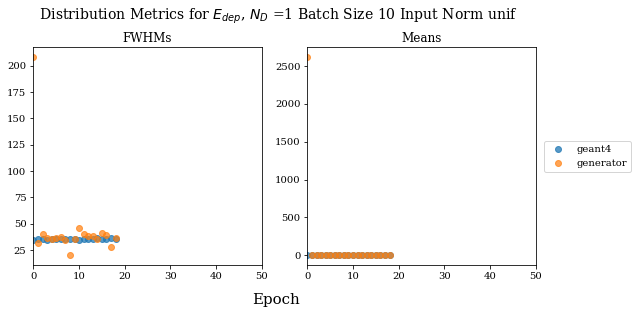

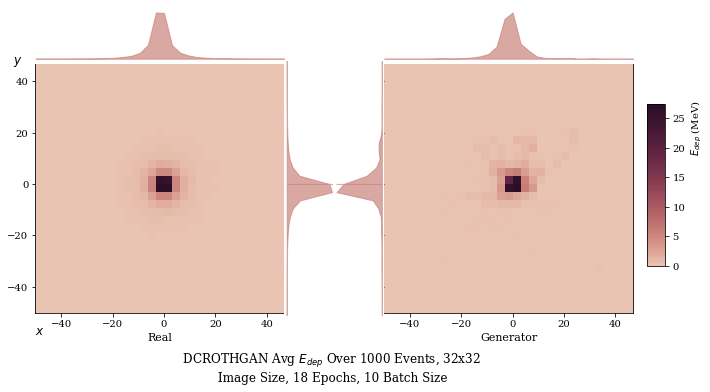

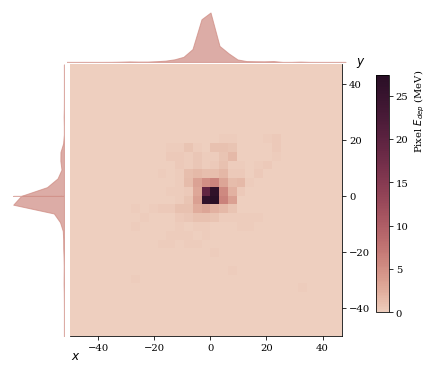

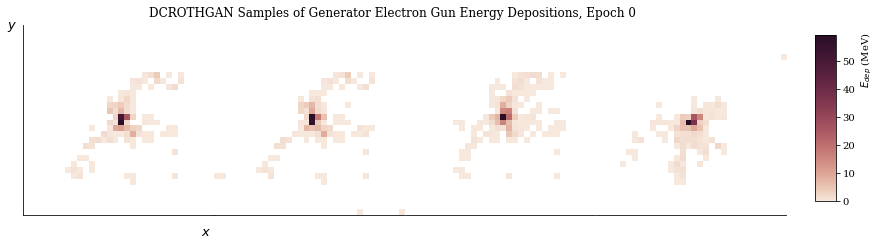

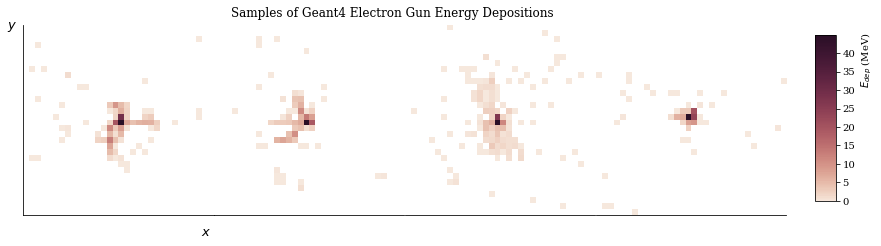

[18/100][0/3000] Loss_D: 0.3012 Loss_G: 2.3457 D(x): 0.8369 D(G(z)): 0.0248 / 0.1174
[18/100][100/3000] Loss_D: 0.7408 Loss_G: 4.4703 D(x): 0.9891 D(G(z)): 0.4786 / 0.0175
[18/100][200/3000] Loss_D: 0.1214 Loss_G: 3.6826 D(x): 0.9224 D(G(z)): 0.0305 / 0.0421
[18/100][300/3000] Loss_D: 0.8454 Loss_G: 2.7526 D(x): 0.9421 D(G(z)): 0.5117 / 0.0771
[18/100][400/3000] Loss_D: 0.0979 Loss_G: 3.3677 D(x): 0.9732 D(G(z)): 0.0675 / 0.0377
[18/100][500/3000] Loss_D: 0.4989 Loss_G: 2.4462 D(x): 0.9928 D(G(z)): 0.3739 / 0.1008
[18/100][600/3000] Loss_D: 0.1288 Loss_G: 2.6016 D(x): 0.9888 D(G(z)): 0.1088 / 0.0821
[18/100][700/3000] Loss_D: 0.0034 Loss_G: 6.9641 D(x): 0.9983 D(G(z)): 0.0017 / 0.0011
[18/100][800/3000] Loss_D: 0.4256 Loss_G: 0.9537 D(x): 0.8666 D(G(z)): 0.2285 / 0.3968
[18/100][900/3000] Loss_D: 0.1613 Loss_G: 2.8522 D(x): 0.9804 D(G(z)): 0.1274 / 0.0706
[18/100][1000/3000] Loss_D: 0.1824 Loss_G: 2.0217 D(x): 0.8877 D(G(z)): 0.0513 / 0.1579
[18/100][1100/3000] Loss_D: 0.3926 Loss_G: 2

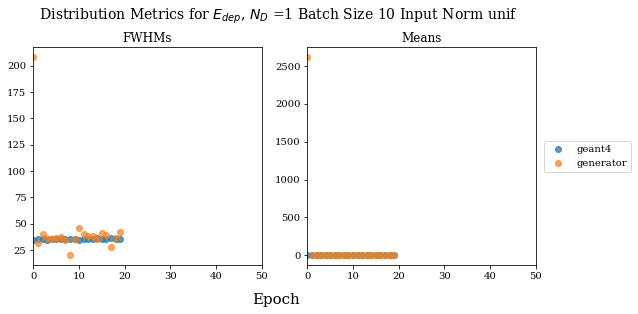

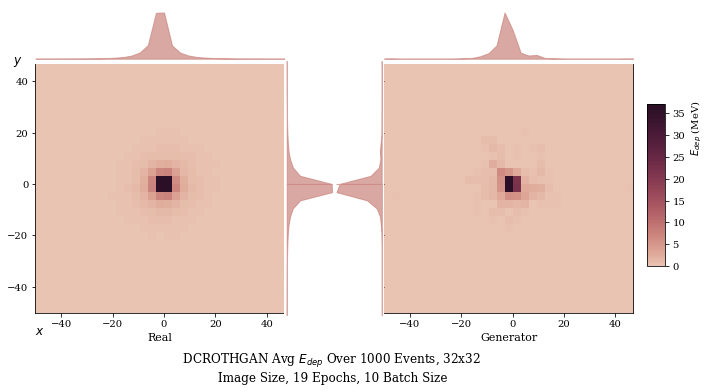

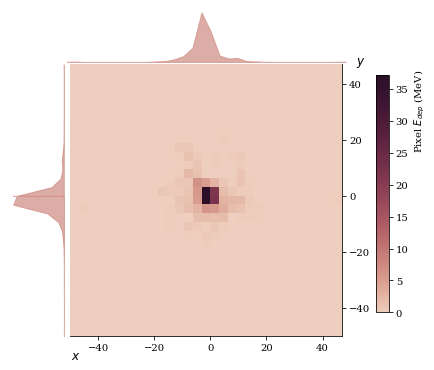

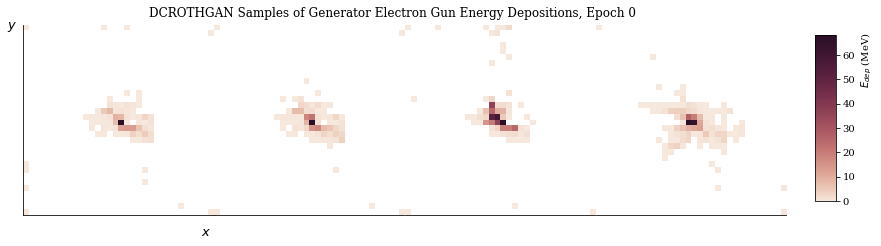

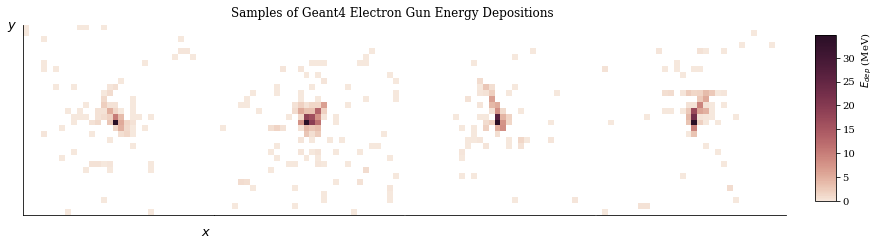

[19/100][0/3000] Loss_D: 1.0758 Loss_G: 2.9417 D(x): 0.9801 D(G(z)): 0.6071 / 0.0607
[19/100][100/3000] Loss_D: 0.1757 Loss_G: 2.6333 D(x): 0.9681 D(G(z)): 0.1283 / 0.0980
[19/100][200/3000] Loss_D: 0.2610 Loss_G: 1.0970 D(x): 0.8391 D(G(z)): 0.0626 / 0.3925
[19/100][300/3000] Loss_D: 0.0945 Loss_G: 3.5958 D(x): 0.9504 D(G(z)): 0.0343 / 0.0327
[19/100][400/3000] Loss_D: 0.1375 Loss_G: 3.1538 D(x): 0.8801 D(G(z)): 0.0036 / 0.0483
[19/100][500/3000] Loss_D: 0.9993 Loss_G: 4.9927 D(x): 0.4475 D(G(z)): 0.0073 / 0.0090
[19/100][600/3000] Loss_D: 0.3582 Loss_G: 1.8183 D(x): 0.9956 D(G(z)): 0.2691 / 0.1939
[19/100][700/3000] Loss_D: 0.0568 Loss_G: 2.6127 D(x): 0.9972 D(G(z)): 0.0521 / 0.0882
[19/100][800/3000] Loss_D: 0.3534 Loss_G: 2.1847 D(x): 0.9811 D(G(z)): 0.2763 / 0.1172
[19/100][900/3000] Loss_D: 0.2752 Loss_G: 2.4400 D(x): 0.9990 D(G(z)): 0.2356 / 0.0994
[19/100][1000/3000] Loss_D: 0.0634 Loss_G: 4.3447 D(x): 0.9759 D(G(z)): 0.0377 / 0.0182
[19/100][1100/3000] Loss_D: 0.1241 Loss_G: 4

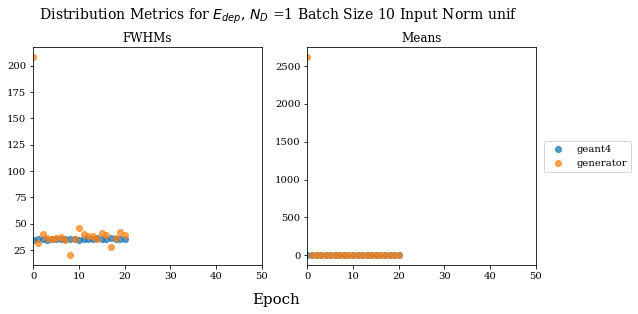

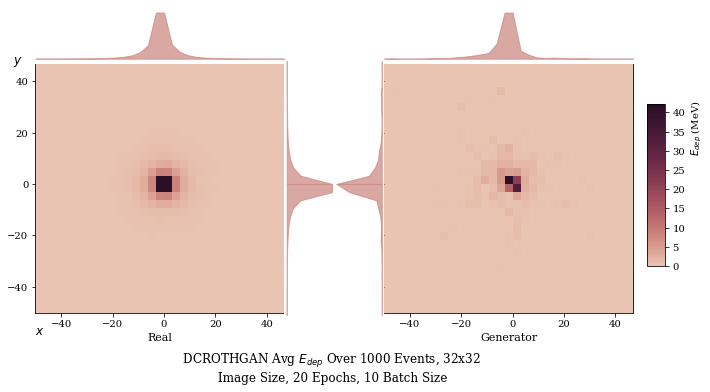

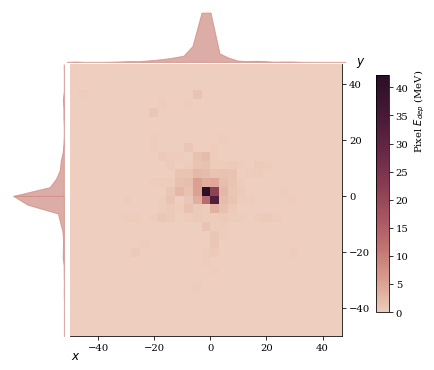

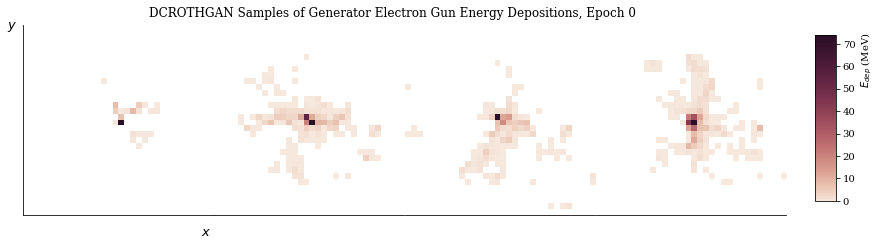

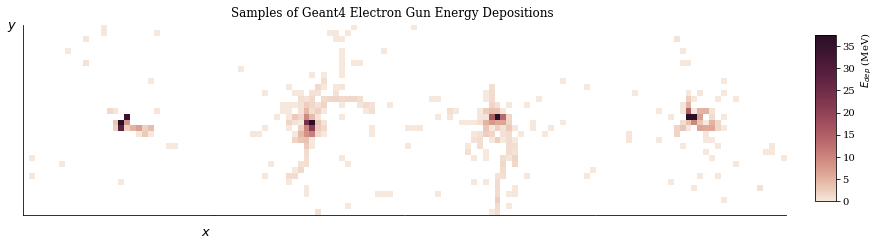

[20/100][0/3000] Loss_D: 0.6364 Loss_G: 2.7485 D(x): 0.9768 D(G(z)): 0.4377 / 0.0783
[20/100][100/3000] Loss_D: 0.2438 Loss_G: 2.3426 D(x): 0.9645 D(G(z)): 0.1849 / 0.1018
[20/100][200/3000] Loss_D: 0.1975 Loss_G: 2.4442 D(x): 0.9551 D(G(z)): 0.1366 / 0.1020
[20/100][300/3000] Loss_D: 0.1149 Loss_G: 3.6118 D(x): 0.9841 D(G(z)): 0.0931 / 0.0298
[20/100][400/3000] Loss_D: 0.8345 Loss_G: 2.8504 D(x): 0.9450 D(G(z)): 0.5206 / 0.0661
[20/100][500/3000] Loss_D: 0.1500 Loss_G: 2.6271 D(x): 0.9917 D(G(z)): 0.1301 / 0.0794
[20/100][600/3000] Loss_D: 0.0808 Loss_G: 3.8207 D(x): 0.9896 D(G(z)): 0.0674 / 0.0253
[20/100][700/3000] Loss_D: 0.0677 Loss_G: 5.6654 D(x): 0.9366 D(G(z)): 0.0013 / 0.0040
[20/100][800/3000] Loss_D: 0.4482 Loss_G: 2.3699 D(x): 0.9751 D(G(z)): 0.3289 / 0.1182
[20/100][900/3000] Loss_D: 0.6185 Loss_G: 1.6169 D(x): 0.9985 D(G(z)): 0.4419 / 0.2154
[20/100][1000/3000] Loss_D: 0.0822 Loss_G: 3.9497 D(x): 0.9387 D(G(z)): 0.0182 / 0.0245
[20/100][1100/3000] Loss_D: 0.2215 Loss_G: 2

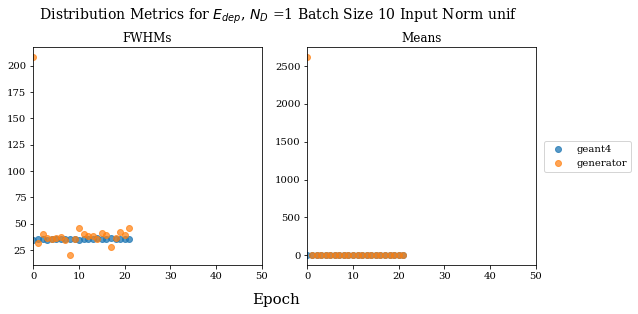

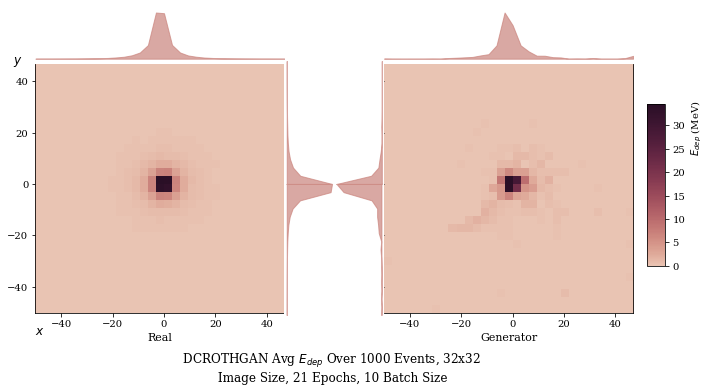

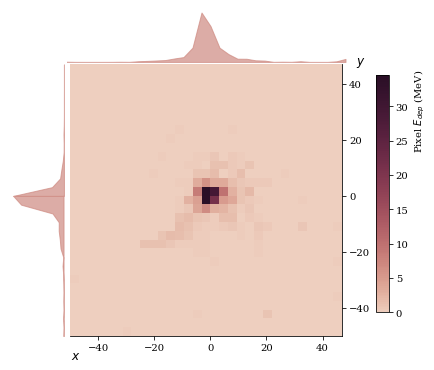

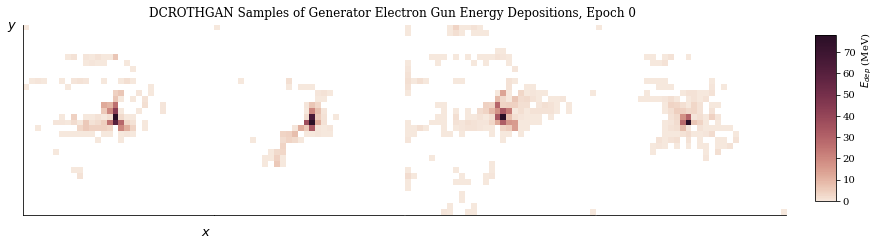

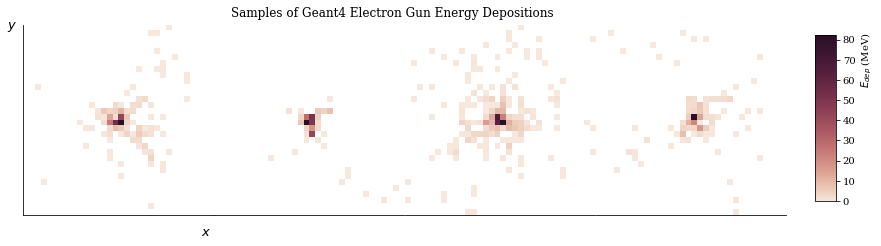

[21/100][0/3000] Loss_D: 0.3028 Loss_G: 1.7588 D(x): 0.9990 D(G(z)): 0.2405 / 0.2018
[21/100][100/3000] Loss_D: 0.4025 Loss_G: 1.5217 D(x): 0.9991 D(G(z)): 0.3204 / 0.2450
[21/100][200/3000] Loss_D: 0.1897 Loss_G: 2.8589 D(x): 0.9900 D(G(z)): 0.1591 / 0.0733
[21/100][300/3000] Loss_D: 0.0901 Loss_G: 3.1471 D(x): 0.9819 D(G(z)): 0.0678 / 0.0532
[21/100][400/3000] Loss_D: 0.6386 Loss_G: 1.1179 D(x): 0.6554 D(G(z)): 0.0421 / 0.3396
[21/100][500/3000] Loss_D: 1.0825 Loss_G: 3.9060 D(x): 0.4850 D(G(z)): 0.1571 / 0.0288
[21/100][600/3000] Loss_D: 0.2471 Loss_G: 2.6777 D(x): 0.9871 D(G(z)): 0.2023 / 0.0780
[21/100][700/3000] Loss_D: 0.1923 Loss_G: 2.8865 D(x): 0.9962 D(G(z)): 0.1677 / 0.0623
[21/100][800/3000] Loss_D: 0.0604 Loss_G: 4.0293 D(x): 0.9900 D(G(z)): 0.0487 / 0.0209
[21/100][900/3000] Loss_D: 0.5870 Loss_G: 2.2869 D(x): 0.9939 D(G(z)): 0.4045 / 0.1291
[21/100][1000/3000] Loss_D: 0.1640 Loss_G: 3.9786 D(x): 0.9775 D(G(z)): 0.1194 / 0.0490
[21/100][1100/3000] Loss_D: 0.0395 Loss_G: 4

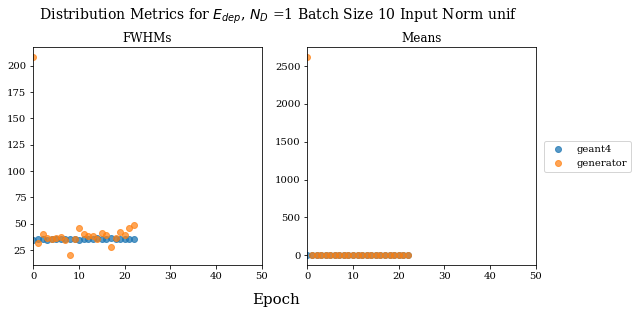

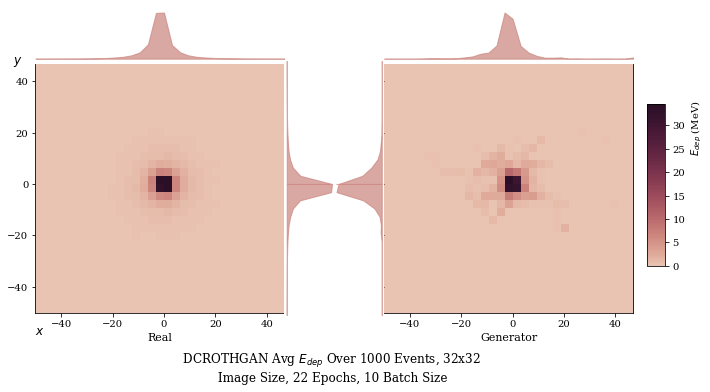

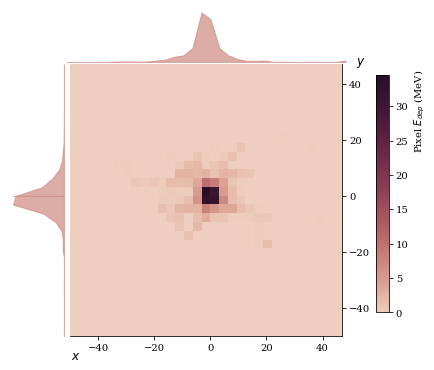

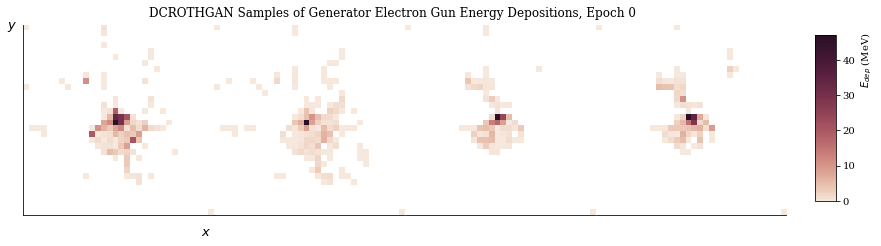

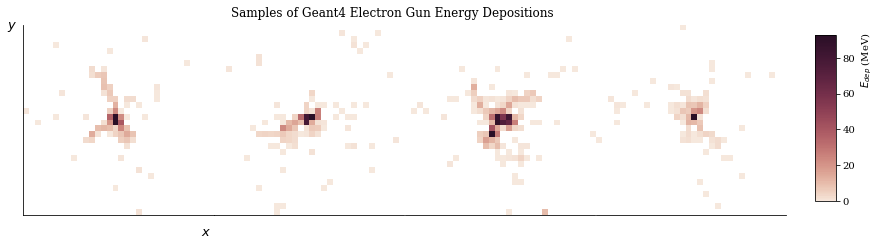

[22/100][0/3000] Loss_D: 1.3694 Loss_G: 2.3016 D(x): 0.9942 D(G(z)): 0.7103 / 0.1188
[22/100][100/3000] Loss_D: 0.1534 Loss_G: 2.8106 D(x): 0.9983 D(G(z)): 0.1369 / 0.0747
[22/100][200/3000] Loss_D: 0.1416 Loss_G: 1.6834 D(x): 0.9118 D(G(z)): 0.0416 / 0.2106
[22/100][300/3000] Loss_D: 0.8644 Loss_G: 1.8328 D(x): 0.9333 D(G(z)): 0.5248 / 0.1829
[22/100][400/3000] Loss_D: 0.2490 Loss_G: 2.3186 D(x): 0.9663 D(G(z)): 0.1870 / 0.1090
[22/100][500/3000] Loss_D: 0.2744 Loss_G: 4.2040 D(x): 0.8105 D(G(z)): 0.0120 / 0.0180
[22/100][600/3000] Loss_D: 0.0529 Loss_G: 4.8653 D(x): 0.9676 D(G(z)): 0.0193 / 0.0169
[22/100][700/3000] Loss_D: 0.2250 Loss_G: 2.9684 D(x): 0.9800 D(G(z)): 0.1812 / 0.0559
[22/100][800/3000] Loss_D: 0.0518 Loss_G: 3.6632 D(x): 0.9975 D(G(z)): 0.0479 / 0.0289
[22/100][900/3000] Loss_D: 0.3077 Loss_G: 3.5612 D(x): 0.9851 D(G(z)): 0.2409 / 0.0367
[22/100][1000/3000] Loss_D: 0.0727 Loss_G: 3.8746 D(x): 0.9911 D(G(z)): 0.0611 / 0.0250
[22/100][1100/3000] Loss_D: 0.0355 Loss_G: 3

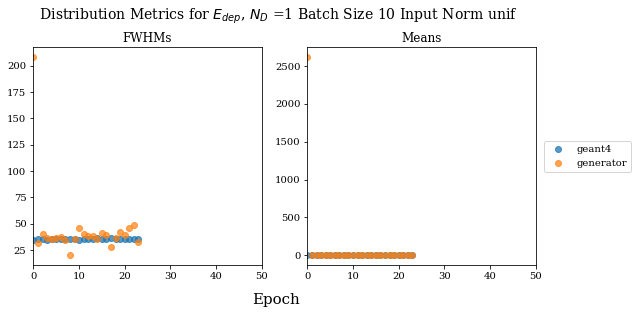

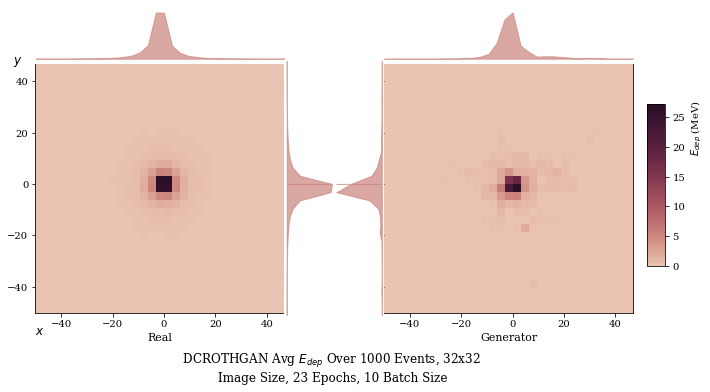

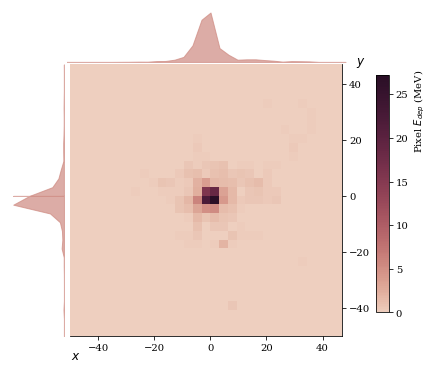

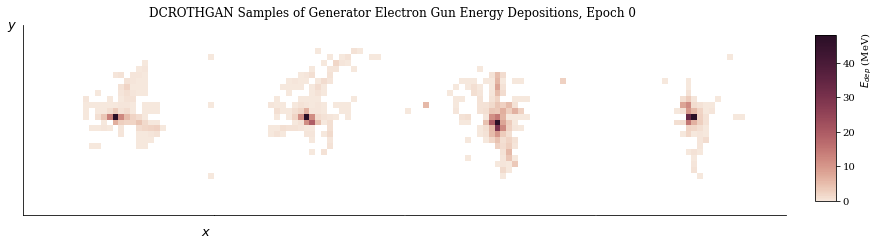

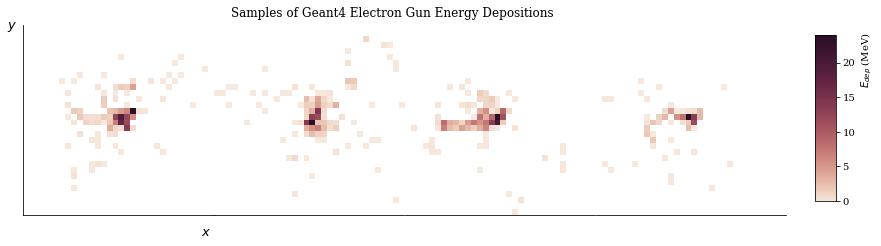

[23/100][0/3000] Loss_D: 0.0719 Loss_G: 3.4586 D(x): 0.9788 D(G(z)): 0.0477 / 0.0538
[23/100][100/3000] Loss_D: 0.5704 Loss_G: 0.3822 D(x): 0.8813 D(G(z)): 0.3271 / 0.6908
[23/100][200/3000] Loss_D: 0.3510 Loss_G: 0.5236 D(x): 0.8604 D(G(z)): 0.1691 / 0.6041
[23/100][300/3000] Loss_D: 0.3061 Loss_G: 1.2823 D(x): 0.7846 D(G(z)): 0.0424 / 0.3129
[23/100][400/3000] Loss_D: 0.0781 Loss_G: 3.8474 D(x): 0.9722 D(G(z)): 0.0470 / 0.0332
[23/100][500/3000] Loss_D: 0.7534 Loss_G: 4.1077 D(x): 0.9961 D(G(z)): 0.5190 / 0.0173
[23/100][600/3000] Loss_D: 0.1093 Loss_G: 2.9836 D(x): 0.9992 D(G(z)): 0.0994 / 0.0658
[23/100][700/3000] Loss_D: 0.0819 Loss_G: 3.3152 D(x): 0.9924 D(G(z)): 0.0694 / 0.0498
[23/100][800/3000] Loss_D: 0.4066 Loss_G: 2.7660 D(x): 0.9939 D(G(z)): 0.3210 / 0.0661
[23/100][900/3000] Loss_D: 0.0500 Loss_G: 3.2184 D(x): 0.9917 D(G(z)): 0.0403 / 0.0594
[23/100][1000/3000] Loss_D: 0.2704 Loss_G: 2.6033 D(x): 0.9710 D(G(z)): 0.2095 / 0.0805
[23/100][1100/3000] Loss_D: 0.2209 Loss_G: 3

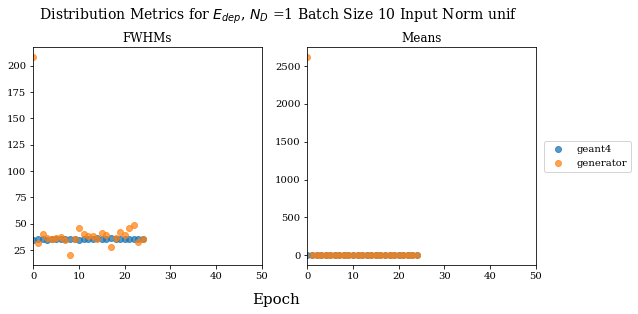

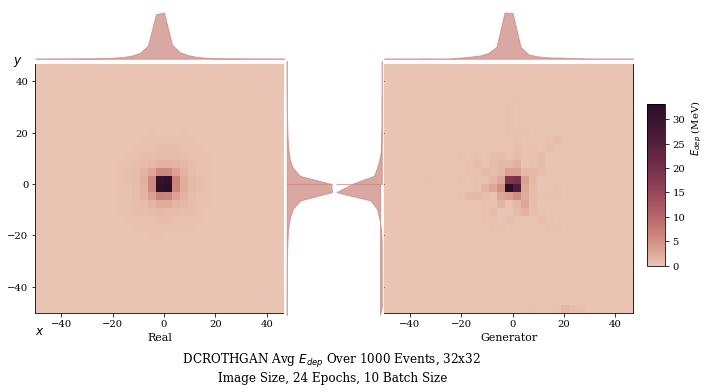

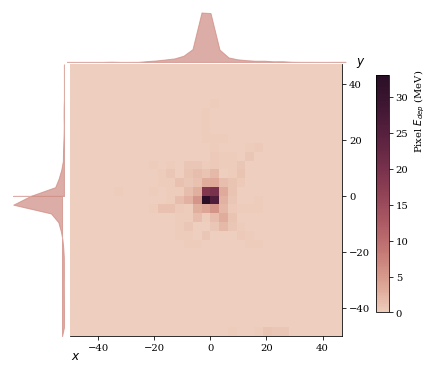

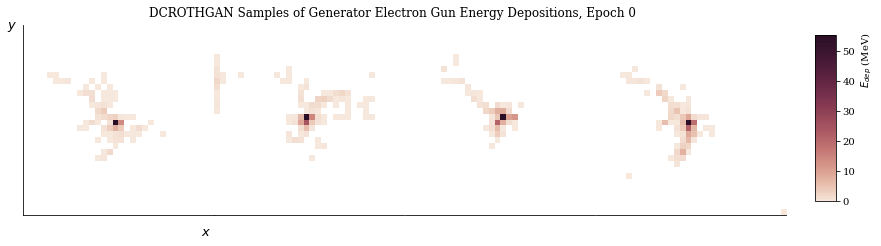

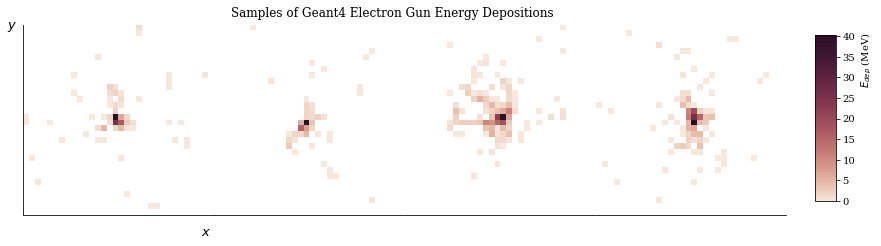

[24/100][0/3000] Loss_D: 0.6543 Loss_G: 0.5728 D(x): 0.8046 D(G(z)): 0.3394 / 0.5720
[24/100][100/3000] Loss_D: 0.1047 Loss_G: 2.8209 D(x): 0.9553 D(G(z)): 0.0497 / 0.0631
[24/100][200/3000] Loss_D: 0.2413 Loss_G: 1.4218 D(x): 0.9513 D(G(z)): 0.1694 / 0.2663
[24/100][300/3000] Loss_D: 0.0865 Loss_G: 3.3708 D(x): 0.9737 D(G(z)): 0.0574 / 0.0391
[24/100][400/3000] Loss_D: 0.0982 Loss_G: 1.7372 D(x): 0.9952 D(G(z)): 0.0884 / 0.1868
[24/100][500/3000] Loss_D: 0.1271 Loss_G: 3.0364 D(x): 0.9165 D(G(z)): 0.0308 / 0.0627
[24/100][600/3000] Loss_D: 0.0680 Loss_G: 4.4344 D(x): 0.9804 D(G(z)): 0.0460 / 0.0235
[24/100][700/3000] Loss_D: 0.1493 Loss_G: 3.5127 D(x): 0.9944 D(G(z)): 0.1308 / 0.0334
[24/100][800/3000] Loss_D: 0.3413 Loss_G: 2.2537 D(x): 0.9973 D(G(z)): 0.2795 / 0.1149
[24/100][900/3000] Loss_D: 0.5504 Loss_G: 0.5176 D(x): 0.7289 D(G(z)): 0.1278 / 0.6082
[24/100][1000/3000] Loss_D: 1.4887 Loss_G: 3.7309 D(x): 0.9916 D(G(z)): 0.7497 / 0.0282
[24/100][1100/3000] Loss_D: 1.0703 Loss_G: 2

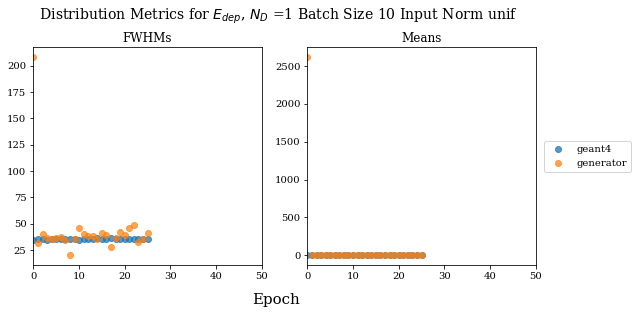

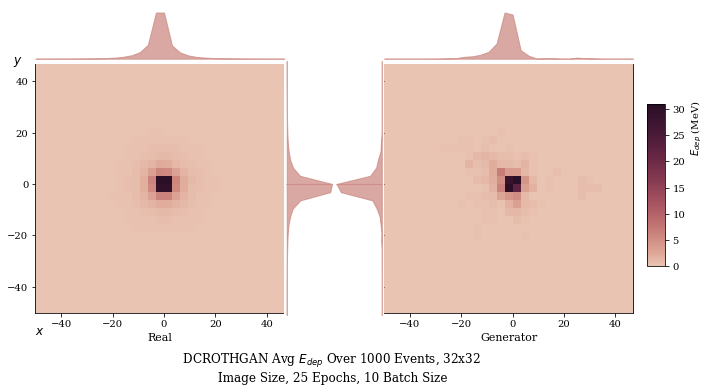

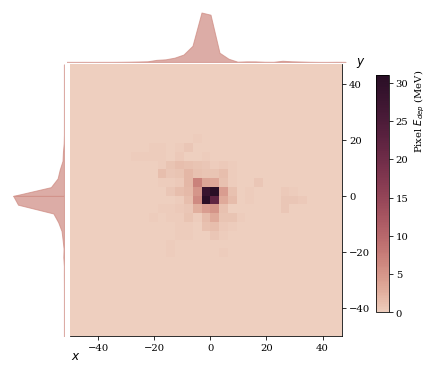

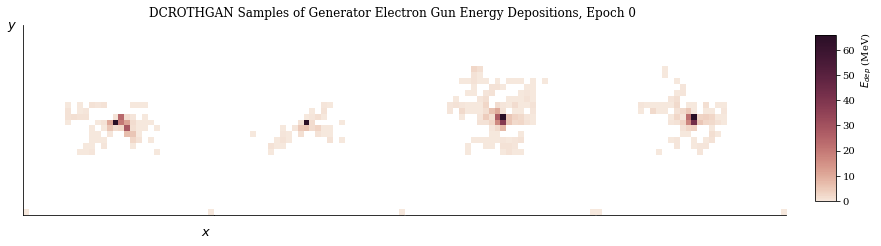

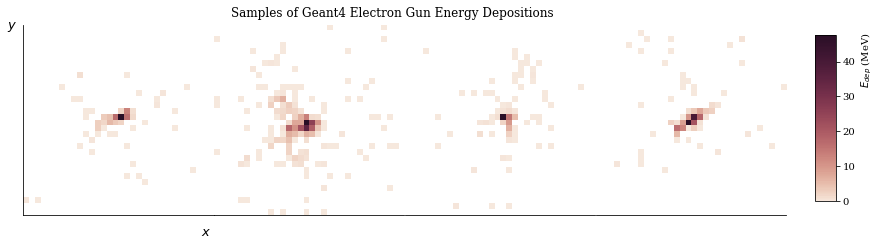

[25/100][0/3000] Loss_D: 0.4641 Loss_G: 1.7688 D(x): 0.6812 D(G(z)): 0.0340 / 0.1915
[25/100][100/3000] Loss_D: 0.3114 Loss_G: 1.8920 D(x): 0.9996 D(G(z)): 0.2590 / 0.1650
[25/100][200/3000] Loss_D: 0.1836 Loss_G: 2.3260 D(x): 0.9365 D(G(z)): 0.1086 / 0.1095
[25/100][300/3000] Loss_D: 0.1898 Loss_G: 2.9541 D(x): 0.8430 D(G(z)): 0.0078 / 0.0657
[25/100][400/3000] Loss_D: 0.0359 Loss_G: 4.2277 D(x): 0.9794 D(G(z)): 0.0144 / 0.0164
[25/100][500/3000] Loss_D: 0.1112 Loss_G: 3.1204 D(x): 0.9931 D(G(z)): 0.0982 / 0.0482
[25/100][600/3000] Loss_D: 0.0875 Loss_G: 3.6022 D(x): 0.9537 D(G(z)): 0.0361 / 0.0349
[25/100][700/3000] Loss_D: 0.2716 Loss_G: 4.6383 D(x): 0.9997 D(G(z)): 0.2256 / 0.0140
[25/100][800/3000] Loss_D: 0.3950 Loss_G: 0.7625 D(x): 0.8443 D(G(z)): 0.1749 / 0.4795
[25/100][900/3000] Loss_D: 0.3973 Loss_G: 0.2888 D(x): 0.7239 D(G(z)): 0.0411 / 0.7532
[25/100][1000/3000] Loss_D: 0.1798 Loss_G: 3.2958 D(x): 0.9441 D(G(z)): 0.1123 / 0.0398
[25/100][1100/3000] Loss_D: 0.7162 Loss_G: 2

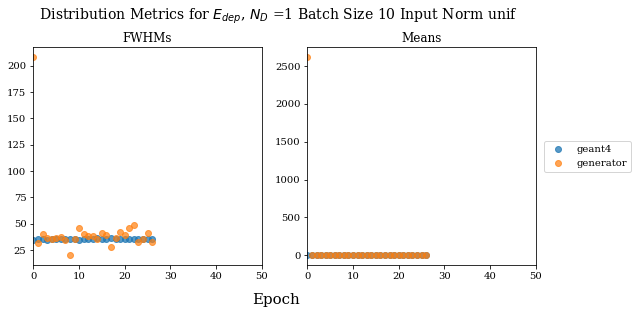

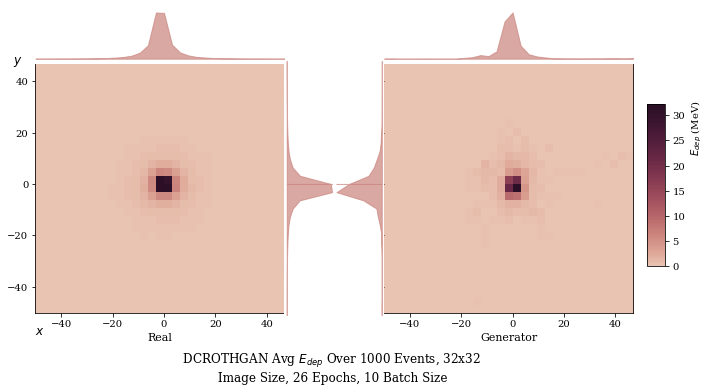

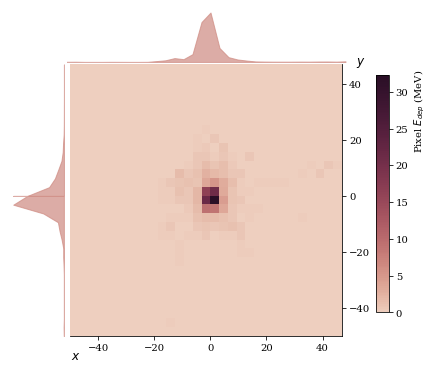

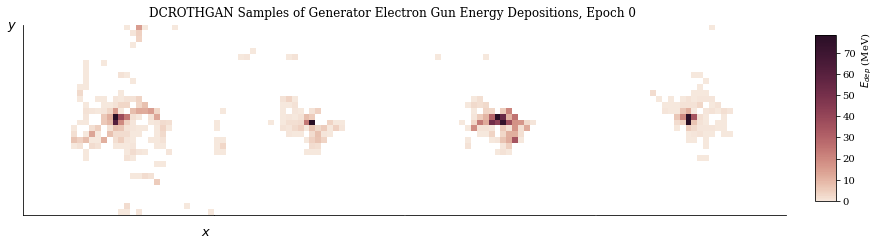

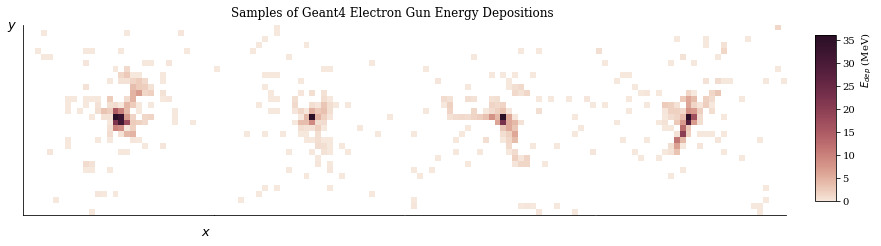

[26/100][0/3000] Loss_D: 0.1646 Loss_G: 2.7652 D(x): 0.9870 D(G(z)): 0.1318 / 0.0904
[26/100][100/3000] Loss_D: 0.1025 Loss_G: 3.2660 D(x): 0.9654 D(G(z)): 0.0644 / 0.0430
[26/100][200/3000] Loss_D: 0.0801 Loss_G: 3.0253 D(x): 0.9553 D(G(z)): 0.0323 / 0.0582
[26/100][300/3000] Loss_D: 0.0855 Loss_G: 3.8636 D(x): 0.9951 D(G(z)): 0.0758 / 0.0348
[26/100][400/3000] Loss_D: 0.0664 Loss_G: 4.7929 D(x): 0.9477 D(G(z)): 0.0114 / 0.0103
[26/100][500/3000] Loss_D: 0.0252 Loss_G: 4.5316 D(x): 0.9934 D(G(z)): 0.0183 / 0.0133
[26/100][600/3000] Loss_D: 0.1054 Loss_G: 3.0315 D(x): 0.9943 D(G(z)): 0.0937 / 0.0562
[26/100][700/3000] Loss_D: 0.0456 Loss_G: 5.2809 D(x): 0.9970 D(G(z)): 0.0410 / 0.0085
[26/100][800/3000] Loss_D: 1.5401 Loss_G: 1.6466 D(x): 0.9697 D(G(z)): 0.7220 / 0.2476
[26/100][900/3000] Loss_D: 0.1712 Loss_G: 3.0982 D(x): 0.9360 D(G(z)): 0.0974 / 0.0504
[26/100][1000/3000] Loss_D: 0.4571 Loss_G: 0.1489 D(x): 0.7962 D(G(z)): 0.1905 / 0.8651
[26/100][1100/3000] Loss_D: 1.3434 Loss_G: 1

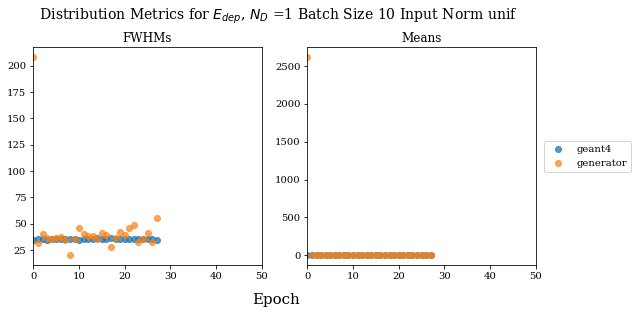

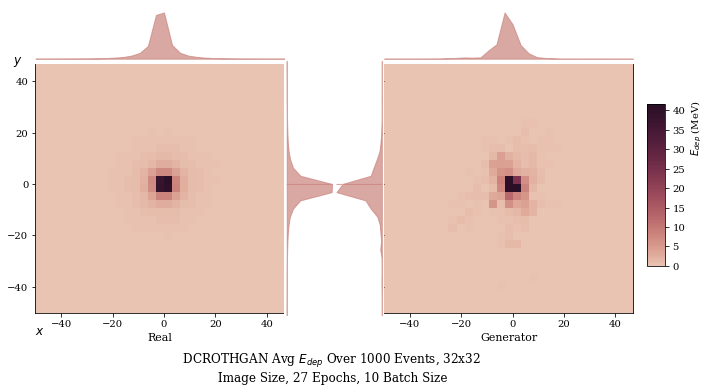

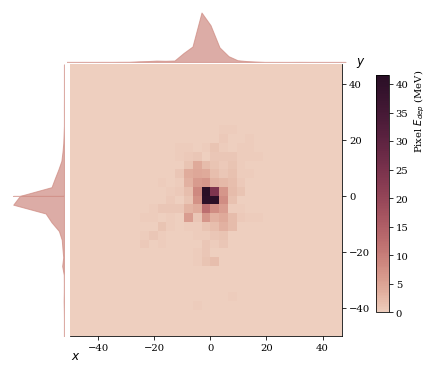

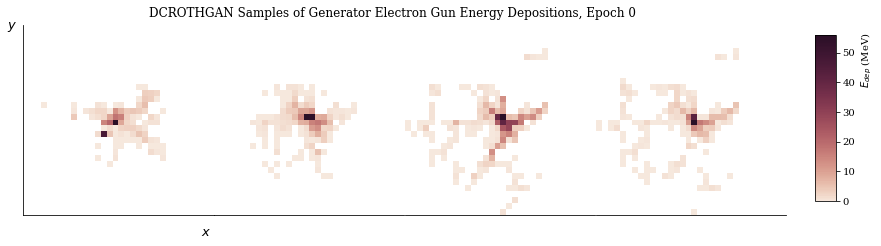

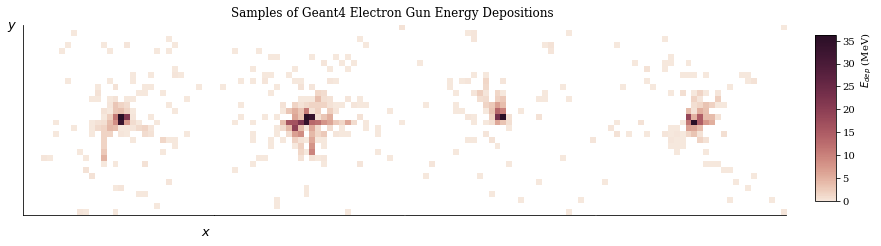

[27/100][0/3000] Loss_D: 0.2784 Loss_G: 1.8794 D(x): 0.8932 D(G(z)): 0.1360 / 0.1654
[27/100][100/3000] Loss_D: 0.6282 Loss_G: 3.6221 D(x): 0.9987 D(G(z)): 0.4543 / 0.0308
[27/100][200/3000] Loss_D: 0.2393 Loss_G: 2.4384 D(x): 0.9741 D(G(z)): 0.1830 / 0.1074
[27/100][300/3000] Loss_D: 0.0828 Loss_G: 4.6285 D(x): 0.9495 D(G(z)): 0.0292 / 0.0101
[27/100][400/3000] Loss_D: 0.0644 Loss_G: 3.5268 D(x): 0.9990 D(G(z)): 0.0607 / 0.0372
[27/100][500/3000] Loss_D: 2.3731 Loss_G: 1.9678 D(x): 0.9938 D(G(z)): 0.8836 / 0.1799
[27/100][600/3000] Loss_D: 0.0215 Loss_G: 4.3777 D(x): 0.9989 D(G(z)): 0.0201 / 0.0148
[27/100][700/3000] Loss_D: 0.1154 Loss_G: 2.7618 D(x): 0.9900 D(G(z)): 0.0993 / 0.0673
[27/100][800/3000] Loss_D: 0.0896 Loss_G: 3.8669 D(x): 0.9936 D(G(z)): 0.0793 / 0.0228
[27/100][900/3000] Loss_D: 0.1851 Loss_G: 2.8025 D(x): 0.9928 D(G(z)): 0.1485 / 0.1013
[27/100][1000/3000] Loss_D: 0.0674 Loss_G: 4.6536 D(x): 0.9413 D(G(z)): 0.0063 / 0.0101
[27/100][1100/3000] Loss_D: 0.2482 Loss_G: 2

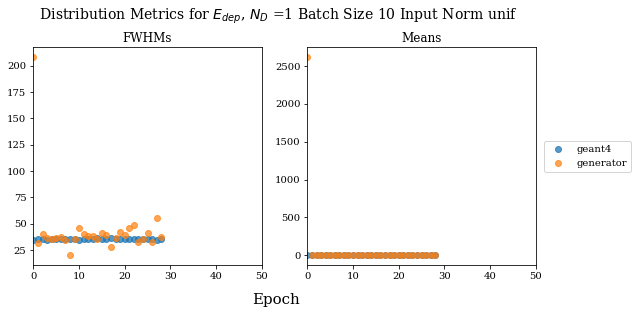

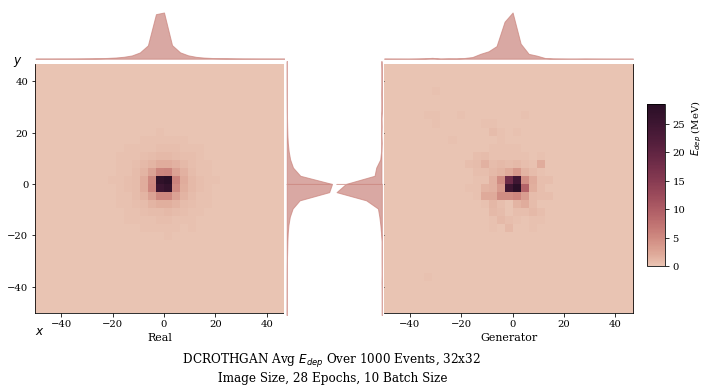

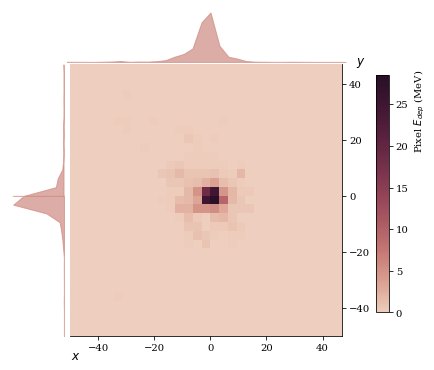

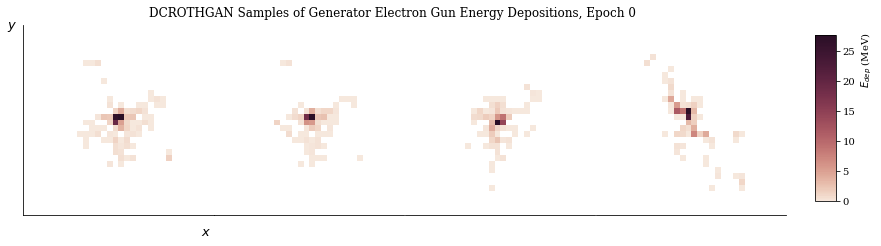

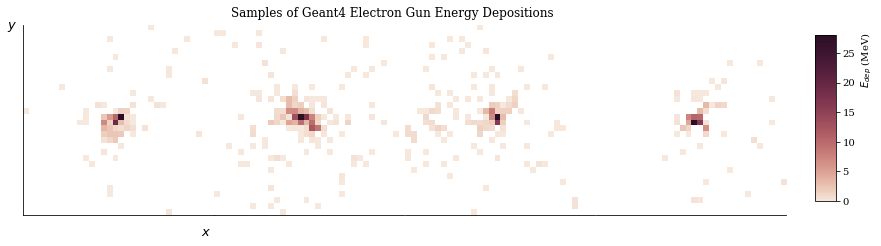

[28/100][0/3000] Loss_D: 0.2220 Loss_G: 2.8066 D(x): 0.9809 D(G(z)): 0.1820 / 0.0622
[28/100][100/3000] Loss_D: 0.0664 Loss_G: 3.2959 D(x): 0.9888 D(G(z)): 0.0529 / 0.0455
[28/100][200/3000] Loss_D: 0.8413 Loss_G: 3.9734 D(x): 0.4705 D(G(z)): 0.0122 / 0.0320
[28/100][300/3000] Loss_D: 0.1407 Loss_G: 3.1326 D(x): 0.9297 D(G(z)): 0.0610 / 0.0511
[28/100][400/3000] Loss_D: 0.0688 Loss_G: 3.5367 D(x): 0.9960 D(G(z)): 0.0623 / 0.0310
[28/100][500/3000] Loss_D: 0.7025 Loss_G: 0.2724 D(x): 0.6794 D(G(z)): 0.2313 / 0.7728
[28/100][600/3000] Loss_D: 0.0859 Loss_G: 3.5007 D(x): 0.9987 D(G(z)): 0.0808 / 0.0318
[28/100][700/3000] Loss_D: 0.0688 Loss_G: 3.4986 D(x): 0.9930 D(G(z)): 0.0595 / 0.0339
[28/100][800/3000] Loss_D: 0.1725 Loss_G: 3.1131 D(x): 0.9878 D(G(z)): 0.1390 / 0.0684
[28/100][900/3000] Loss_D: 0.1089 Loss_G: 2.5856 D(x): 0.9375 D(G(z)): 0.0417 / 0.0871
[28/100][1000/3000] Loss_D: 0.3162 Loss_G: 3.2725 D(x): 0.9984 D(G(z)): 0.2554 / 0.0549
[28/100][1100/3000] Loss_D: 0.4859 Loss_G: 2

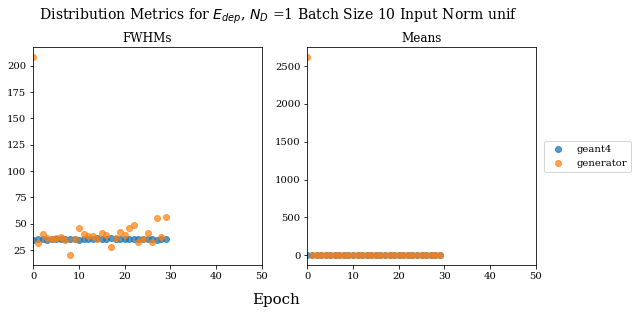

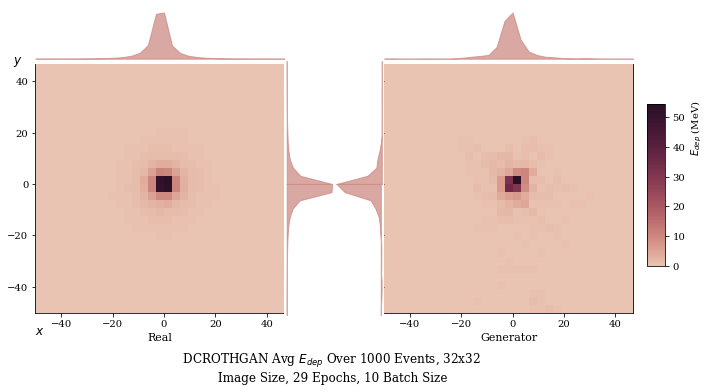

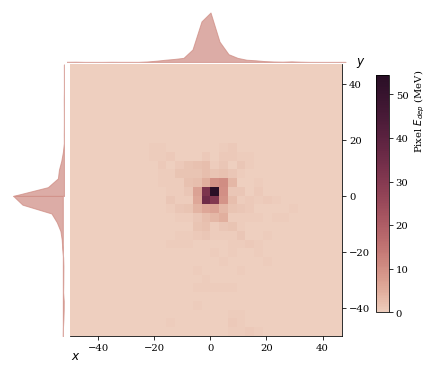

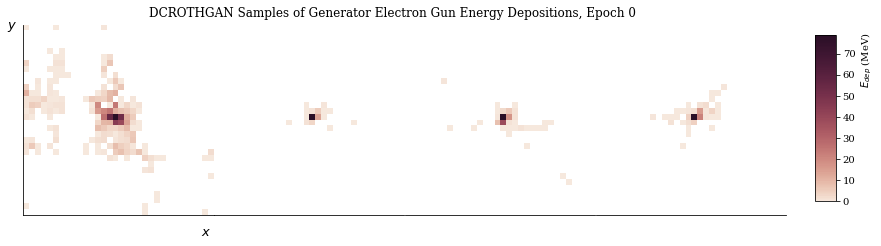

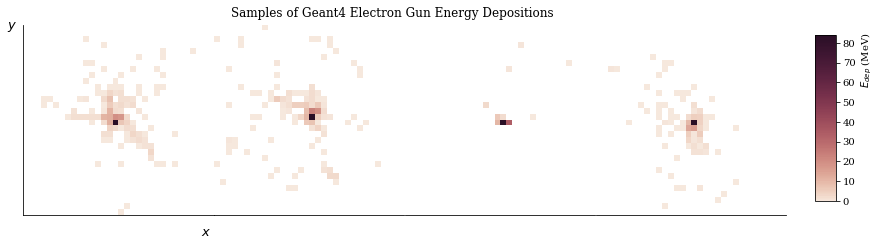

[29/100][0/3000] Loss_D: 0.0844 Loss_G: 3.1856 D(x): 0.9454 D(G(z)): 0.0260 / 0.0444
[29/100][100/3000] Loss_D: 0.0114 Loss_G: 4.8790 D(x): 0.9949 D(G(z)): 0.0062 / 0.0089
[29/100][200/3000] Loss_D: 0.3174 Loss_G: 2.2807 D(x): 0.9479 D(G(z)): 0.2064 / 0.1331
[29/100][300/3000] Loss_D: 0.2982 Loss_G: 4.2890 D(x): 0.9974 D(G(z)): 0.2347 / 0.0203
[29/100][400/3000] Loss_D: 0.1278 Loss_G: 3.1939 D(x): 0.9846 D(G(z)): 0.1004 / 0.0806
[29/100][500/3000] Loss_D: 0.2666 Loss_G: 0.5472 D(x): 0.8573 D(G(z)): 0.0966 / 0.5940
[29/100][600/3000] Loss_D: 0.0858 Loss_G: 3.5330 D(x): 0.9640 D(G(z)): 0.0467 / 0.0390
[29/100][700/3000] Loss_D: 0.1890 Loss_G: 3.0940 D(x): 0.9832 D(G(z)): 0.1490 / 0.0553
[29/100][800/3000] Loss_D: 0.4662 Loss_G: 1.2276 D(x): 0.9667 D(G(z)): 0.3169 / 0.3234
[29/100][900/3000] Loss_D: 0.5014 Loss_G: 2.5523 D(x): 0.6331 D(G(z)): 0.0026 / 0.1053
[29/100][1000/3000] Loss_D: 0.8984 Loss_G: 2.9281 D(x): 0.9846 D(G(z)): 0.5501 / 0.0658
[29/100][1100/3000] Loss_D: 0.6261 Loss_G: 3

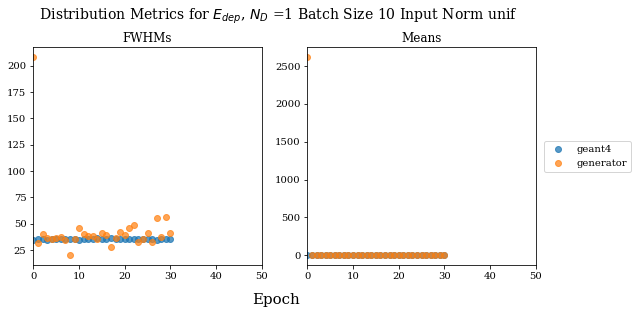

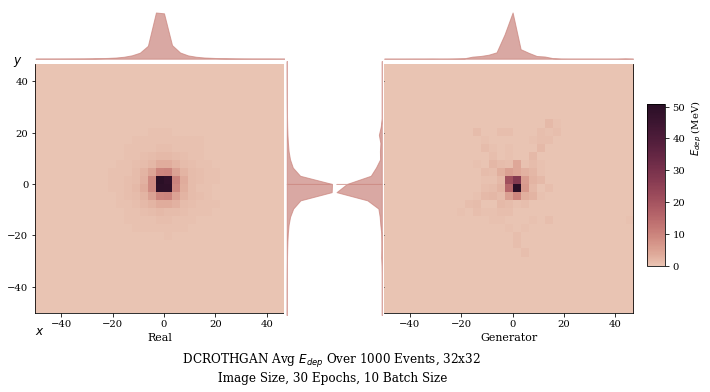

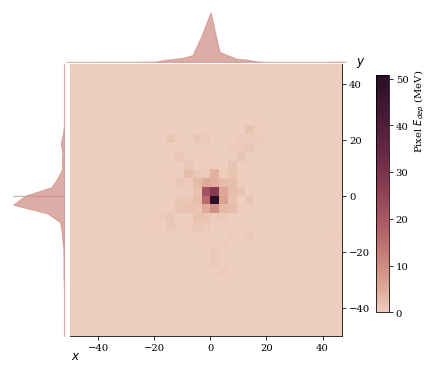

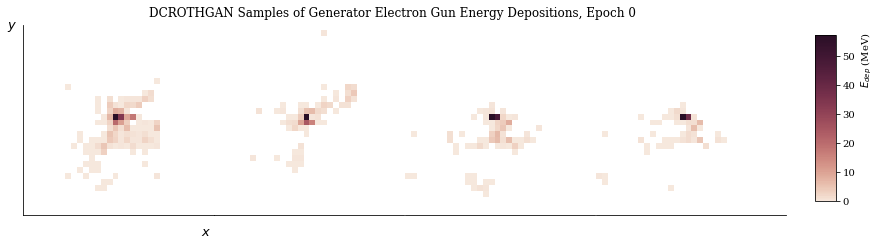

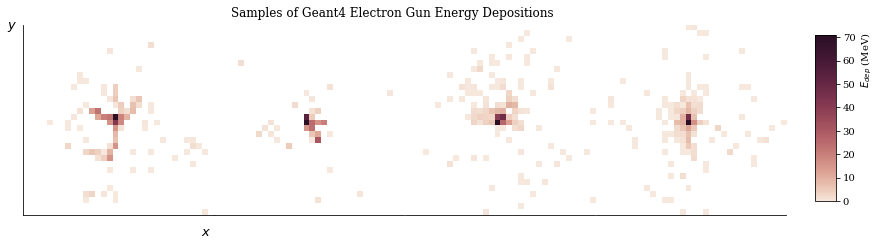

[30/100][0/3000] Loss_D: 0.1070 Loss_G: 2.7555 D(x): 0.9317 D(G(z)): 0.0319 / 0.0692
[30/100][100/3000] Loss_D: 0.2479 Loss_G: 3.0762 D(x): 0.9992 D(G(z)): 0.2090 / 0.0569
[30/100][200/3000] Loss_D: 0.0612 Loss_G: 3.6041 D(x): 0.9714 D(G(z)): 0.0312 / 0.0281
[30/100][300/3000] Loss_D: 0.0253 Loss_G: 5.4840 D(x): 0.9990 D(G(z)): 0.0237 / 0.0059
[30/100][400/3000] Loss_D: 0.3859 Loss_G: 1.8035 D(x): 0.7541 D(G(z)): 0.0080 / 0.1772
[30/100][500/3000] Loss_D: 0.0605 Loss_G: 3.3957 D(x): 0.9973 D(G(z)): 0.0556 / 0.0404
[30/100][600/3000] Loss_D: 0.1279 Loss_G: 3.0278 D(x): 0.9970 D(G(z)): 0.1152 / 0.0574
[30/100][700/3000] Loss_D: 0.1687 Loss_G: 2.8733 D(x): 0.9983 D(G(z)): 0.1492 / 0.0685
[30/100][800/3000] Loss_D: 0.0433 Loss_G: 3.6951 D(x): 0.9984 D(G(z)): 0.0402 / 0.0323
[30/100][900/3000] Loss_D: 1.9838 Loss_G: 0.9426 D(x): 0.9288 D(G(z)): 0.8077 / 0.4323
[30/100][1000/3000] Loss_D: 0.1834 Loss_G: 2.8728 D(x): 0.9963 D(G(z)): 0.1614 / 0.0641
[30/100][1100/3000] Loss_D: 0.1285 Loss_G: 3

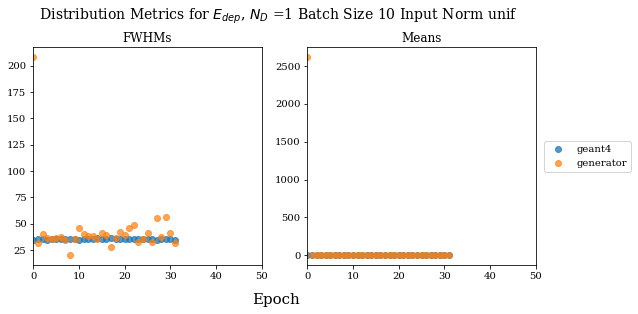

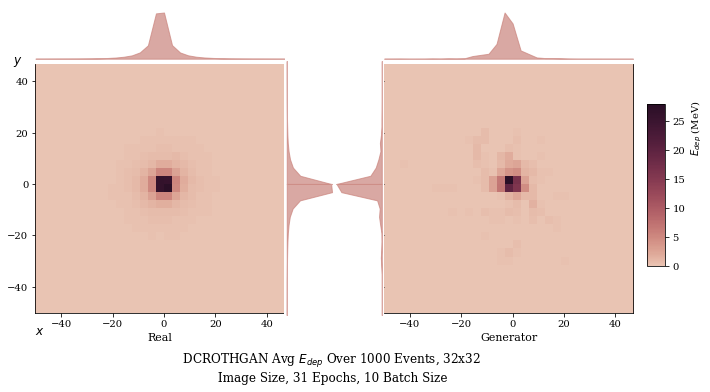

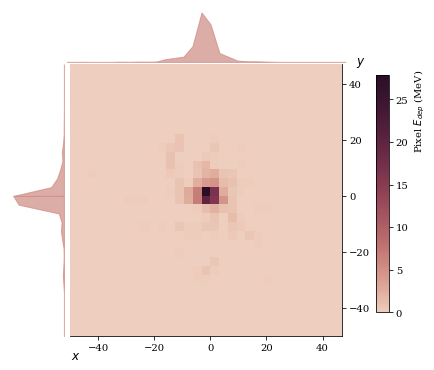

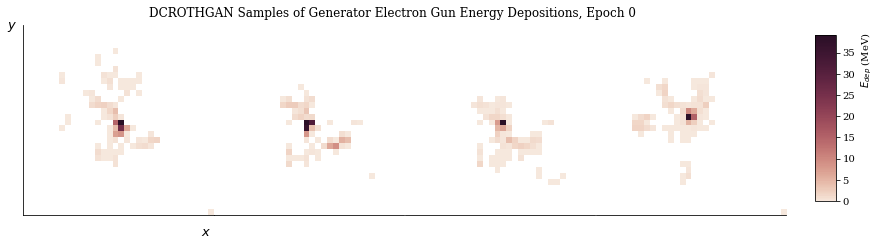

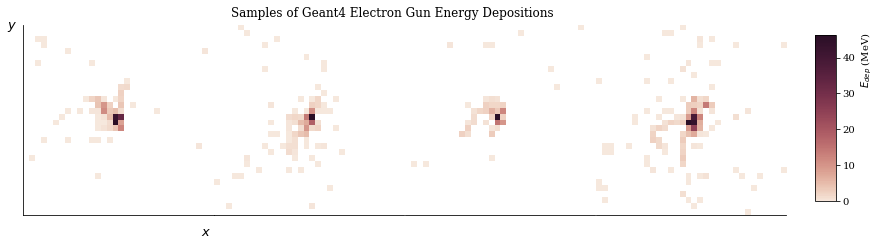

[31/100][0/3000] Loss_D: 0.0670 Loss_G: 3.7516 D(x): 0.9482 D(G(z)): 0.0115 / 0.0245
[31/100][100/3000] Loss_D: 0.0094 Loss_G: 6.1000 D(x): 0.9933 D(G(z)): 0.0026 / 0.0025
[31/100][200/3000] Loss_D: 0.2987 Loss_G: 2.5892 D(x): 0.9916 D(G(z)): 0.2394 / 0.0976
[31/100][300/3000] Loss_D: 0.0305 Loss_G: 5.0407 D(x): 0.9867 D(G(z)): 0.0167 / 0.0101
[31/100][400/3000] Loss_D: 0.0202 Loss_G: 6.6926 D(x): 0.9826 D(G(z)): 0.0024 / 0.0018
[31/100][500/3000] Loss_D: 0.7336 Loss_G: 3.3880 D(x): 0.9861 D(G(z)): 0.4747 / 0.0437
[31/100][600/3000] Loss_D: 0.1389 Loss_G: 3.0989 D(x): 0.9985 D(G(z)): 0.1225 / 0.0573
[31/100][700/3000] Loss_D: 0.1036 Loss_G: 3.8102 D(x): 0.9963 D(G(z)): 0.0919 / 0.0302
[31/100][800/3000] Loss_D: 0.1992 Loss_G: 2.2666 D(x): 0.9955 D(G(z)): 0.1642 / 0.1343
[31/100][900/3000] Loss_D: 0.7512 Loss_G: 2.8046 D(x): 0.9968 D(G(z)): 0.4842 / 0.0814
[31/100][1000/3000] Loss_D: 0.5359 Loss_G: 3.6050 D(x): 0.9753 D(G(z)): 0.3906 / 0.0309
[31/100][1100/3000] Loss_D: 3.7353 Loss_G: 1

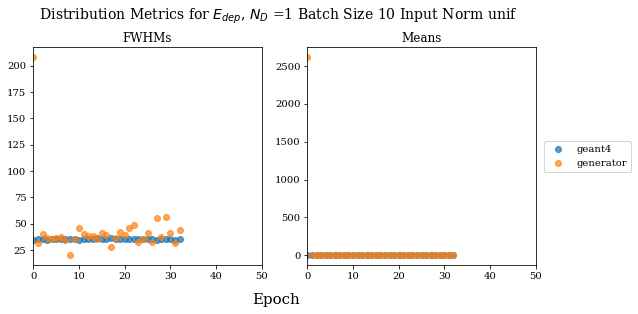

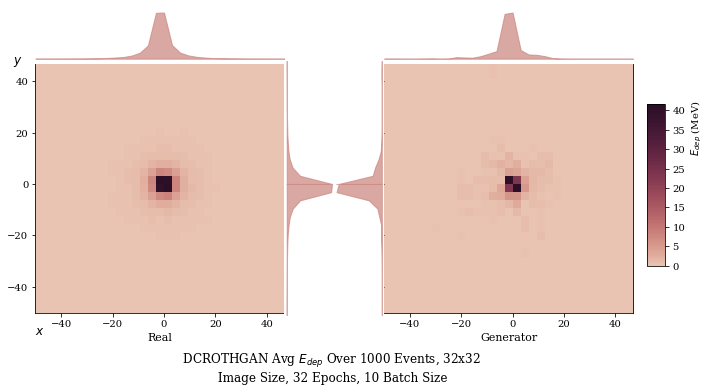

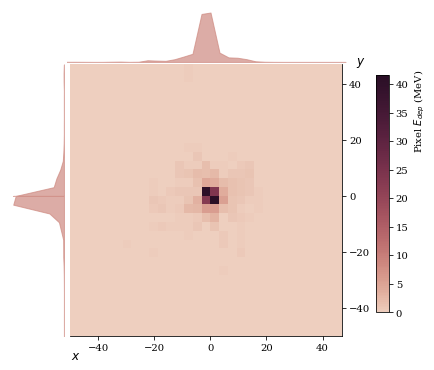

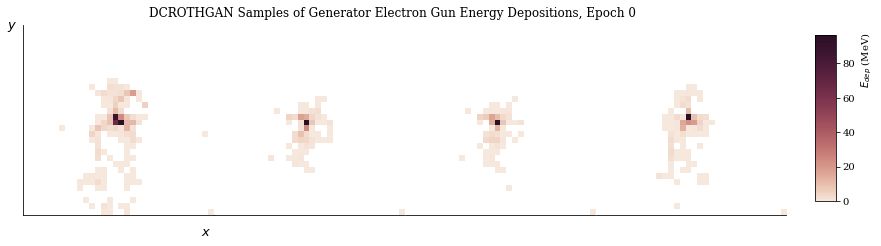

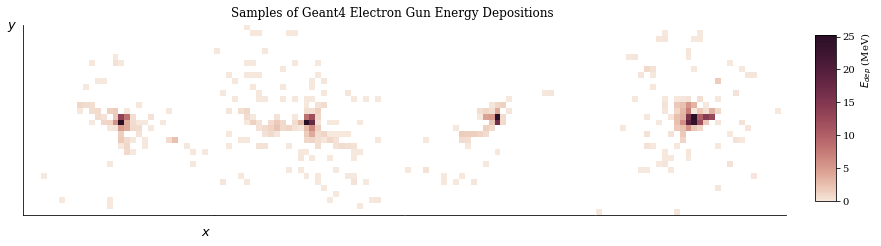

[32/100][0/3000] Loss_D: 0.0440 Loss_G: 3.7239 D(x): 0.9991 D(G(z)): 0.0420 / 0.0280
[32/100][100/3000] Loss_D: 0.3017 Loss_G: 2.4454 D(x): 0.9987 D(G(z)): 0.2483 / 0.1024
[32/100][200/3000] Loss_D: 0.3077 Loss_G: 1.9815 D(x): 0.9274 D(G(z)): 0.1969 / 0.1499
[32/100][300/3000] Loss_D: 0.0488 Loss_G: 4.1086 D(x): 0.9774 D(G(z)): 0.0252 / 0.0198
[32/100][400/3000] Loss_D: 0.1813 Loss_G: 3.6838 D(x): 0.9917 D(G(z)): 0.1284 / 0.0398
[32/100][500/3000] Loss_D: 0.9389 Loss_G: 3.0517 D(x): 0.9946 D(G(z)): 0.5814 / 0.0523
[32/100][600/3000] Loss_D: 0.0452 Loss_G: 4.3645 D(x): 0.9697 D(G(z)): 0.0140 / 0.0159
[32/100][700/3000] Loss_D: 0.1123 Loss_G: 2.4434 D(x): 0.9235 D(G(z)): 0.0306 / 0.1433
[32/100][800/3000] Loss_D: 0.1073 Loss_G: 2.3944 D(x): 0.9974 D(G(z)): 0.0963 / 0.1231
[32/100][900/3000] Loss_D: 0.2053 Loss_G: 1.8067 D(x): 0.9277 D(G(z)): 0.1175 / 0.1700
[32/100][1000/3000] Loss_D: 1.3112 Loss_G: 3.0592 D(x): 0.9992 D(G(z)): 0.6805 / 0.0647
[32/100][1100/3000] Loss_D: 0.4986 Loss_G: 2

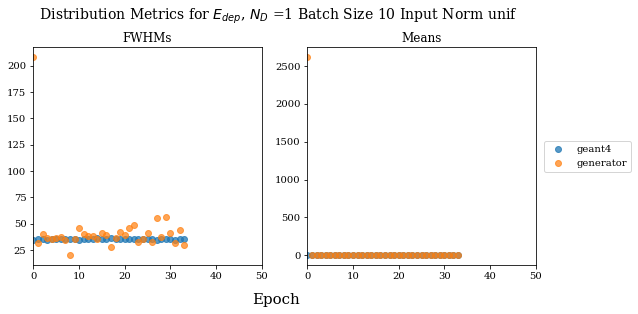

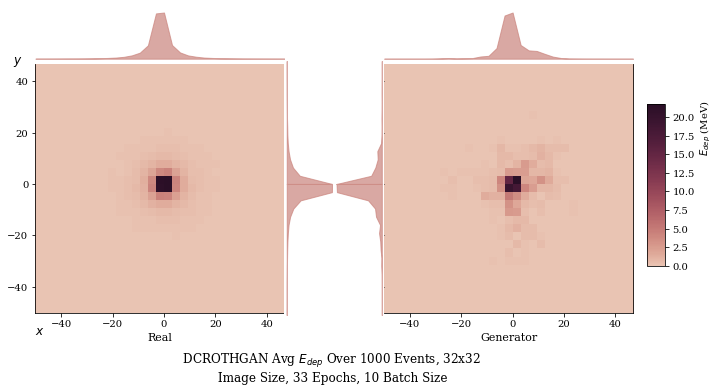

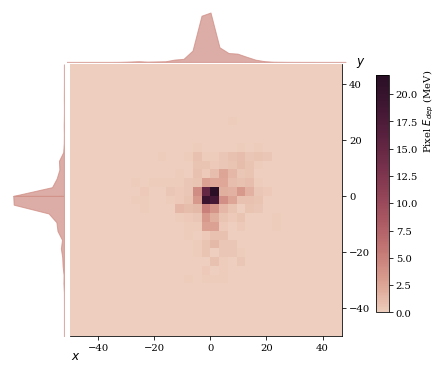

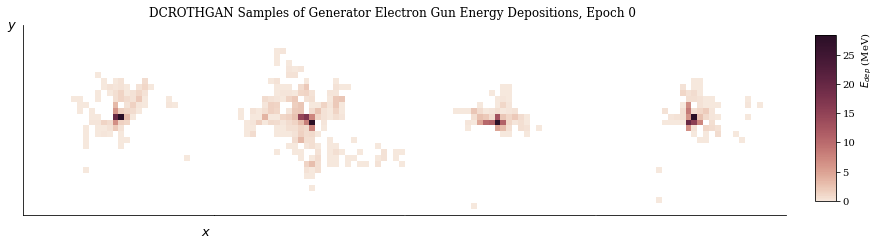

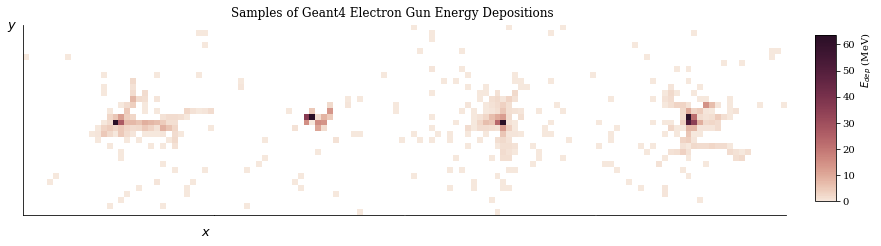

[33/100][0/3000] Loss_D: 0.2541 Loss_G: 1.5972 D(x): 0.9987 D(G(z)): 0.2199 / 0.2168
[33/100][100/3000] Loss_D: 0.1421 Loss_G: 2.4061 D(x): 0.9863 D(G(z)): 0.1182 / 0.1016
[33/100][200/3000] Loss_D: 0.0511 Loss_G: 4.0160 D(x): 0.9676 D(G(z)): 0.0174 / 0.0200
[33/100][300/3000] Loss_D: 0.2732 Loss_G: 2.3906 D(x): 0.9616 D(G(z)): 0.1985 / 0.1096
[33/100][400/3000] Loss_D: 0.1679 Loss_G: 3.4928 D(x): 0.8636 D(G(z)): 0.0058 / 0.0435
[33/100][500/3000] Loss_D: 0.0479 Loss_G: 3.9060 D(x): 0.9767 D(G(z)): 0.0237 / 0.0254
[33/100][600/3000] Loss_D: 0.0642 Loss_G: 2.5727 D(x): 0.9994 D(G(z)): 0.0610 / 0.0865
[33/100][700/3000] Loss_D: 0.0678 Loss_G: 4.2690 D(x): 0.9562 D(G(z)): 0.0195 / 0.0287
[33/100][800/3000] Loss_D: 0.0549 Loss_G: 4.0174 D(x): 0.9753 D(G(z)): 0.0289 / 0.0217
[33/100][900/3000] Loss_D: 0.0960 Loss_G: 3.5948 D(x): 0.9991 D(G(z)): 0.0872 / 0.0507
[33/100][1000/3000] Loss_D: 0.0786 Loss_G: 3.4242 D(x): 0.9968 D(G(z)): 0.0724 / 0.0339
[33/100][1100/3000] Loss_D: 0.1832 Loss_G: 1

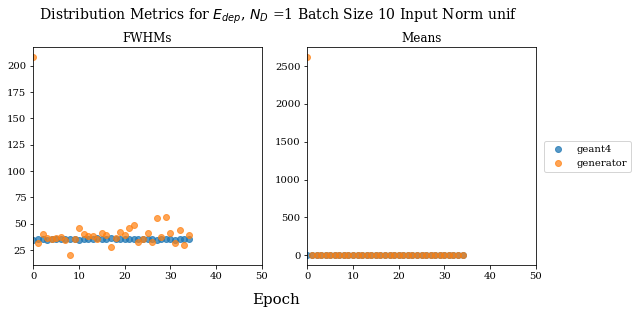

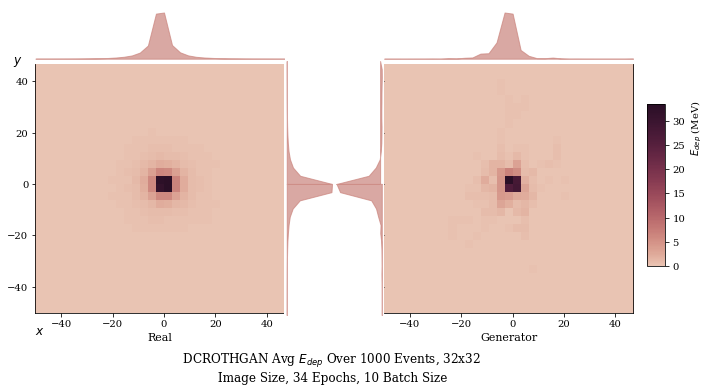

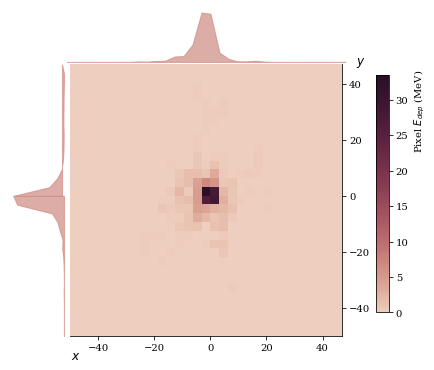

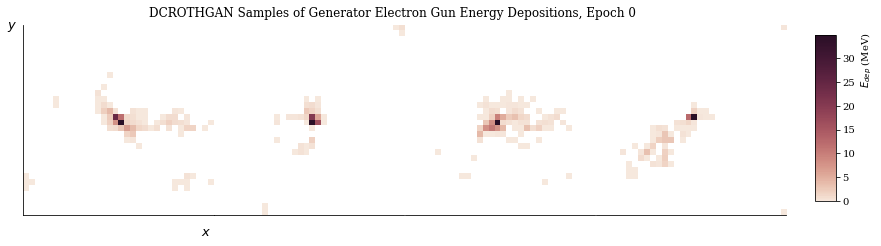

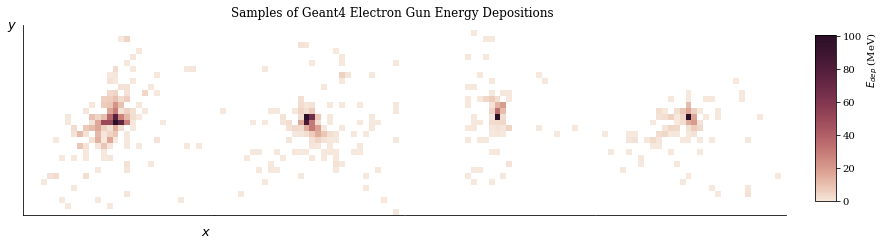

[34/100][0/3000] Loss_D: 0.0777 Loss_G: 4.6481 D(x): 0.9324 D(G(z)): 0.0062 / 0.0128
[34/100][100/3000] Loss_D: 0.4318 Loss_G: 2.2503 D(x): 0.9995 D(G(z)): 0.3408 / 0.1122
[34/100][200/3000] Loss_D: 0.7521 Loss_G: 3.9769 D(x): 0.5179 D(G(z)): 0.0055 / 0.0240
[34/100][300/3000] Loss_D: 0.0686 Loss_G: 4.1221 D(x): 0.9780 D(G(z)): 0.0448 / 0.0191
[34/100][400/3000] Loss_D: 0.0092 Loss_G: 6.5335 D(x): 0.9931 D(G(z)): 0.0022 / 0.0017
[34/100][500/3000] Loss_D: 0.0114 Loss_G: 5.4172 D(x): 0.9952 D(G(z)): 0.0065 / 0.0051
[34/100][600/3000] Loss_D: 0.0055 Loss_G: 7.1590 D(x): 0.9958 D(G(z)): 0.0013 / 0.0010
[34/100][700/3000] Loss_D: 0.0663 Loss_G: 3.5706 D(x): 0.9993 D(G(z)): 0.0618 / 0.0379
[34/100][800/3000] Loss_D: 0.6301 Loss_G: 1.7525 D(x): 0.9992 D(G(z)): 0.4563 / 0.1843
[34/100][900/3000] Loss_D: 0.0388 Loss_G: 6.1889 D(x): 0.9648 D(G(z)): 0.0024 / 0.0025
[34/100][1000/3000] Loss_D: 2.1222 Loss_G: 2.9857 D(x): 0.9974 D(G(z)): 0.8736 / 0.0538
[34/100][1100/3000] Loss_D: 0.1270 Loss_G: 3

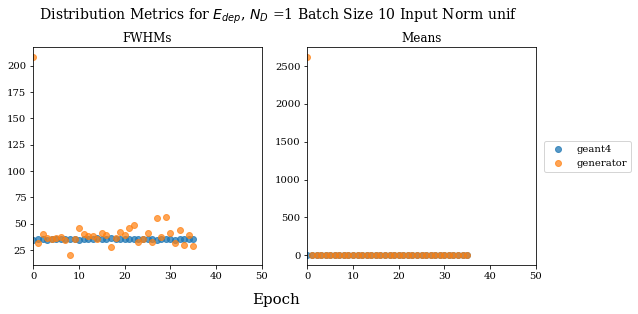

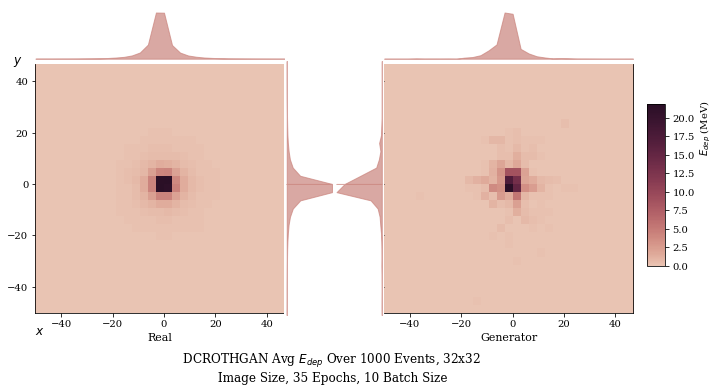

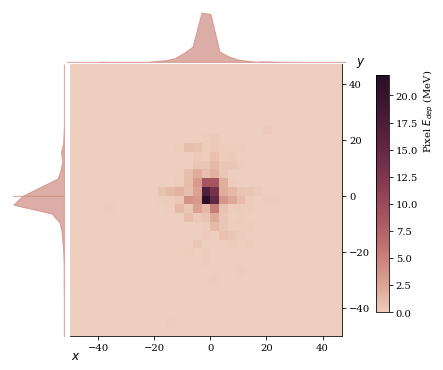

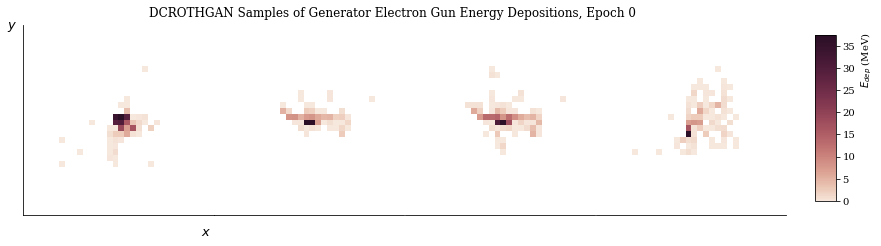

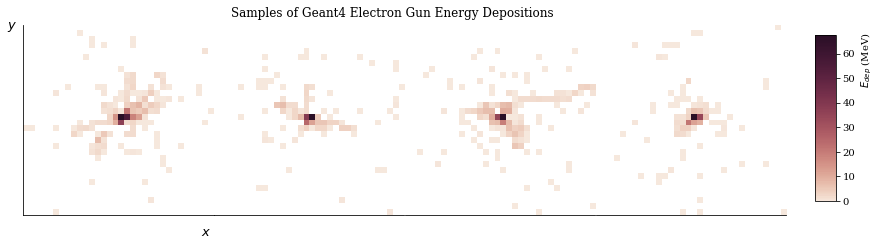

[35/100][0/3000] Loss_D: 0.0121 Loss_G: 4.9680 D(x): 0.9991 D(G(z)): 0.0111 / 0.0083
[35/100][100/3000] Loss_D: 0.0361 Loss_G: 4.4575 D(x): 0.9741 D(G(z)): 0.0095 / 0.0170
[35/100][200/3000] Loss_D: 0.7047 Loss_G: 2.3918 D(x): 0.6075 D(G(z)): 0.0135 / 0.1011
[35/100][300/3000] Loss_D: 0.3493 Loss_G: 3.6796 D(x): 0.9943 D(G(z)): 0.2726 / 0.0351
[35/100][400/3000] Loss_D: 0.1035 Loss_G: 2.5584 D(x): 0.9817 D(G(z)): 0.0802 / 0.0858
[35/100][500/3000] Loss_D: 0.3290 Loss_G: 2.6971 D(x): 0.9969 D(G(z)): 0.2636 / 0.0872
[35/100][600/3000] Loss_D: 0.2558 Loss_G: 2.5491 D(x): 0.9832 D(G(z)): 0.2040 / 0.0994
[35/100][700/3000] Loss_D: 0.0205 Loss_G: 7.7514 D(x): 0.9812 D(G(z)): 0.0011 / 0.0006
[35/100][800/3000] Loss_D: 0.0870 Loss_G: 2.6837 D(x): 0.9995 D(G(z)): 0.0821 / 0.0772
[35/100][900/3000] Loss_D: 0.3642 Loss_G: 1.4639 D(x): 0.9997 D(G(z)): 0.2811 / 0.2778
[35/100][1000/3000] Loss_D: 0.4649 Loss_G: 2.7953 D(x): 0.9971 D(G(z)): 0.3587 / 0.0690
[35/100][1100/3000] Loss_D: 1.6208 Loss_G: 3

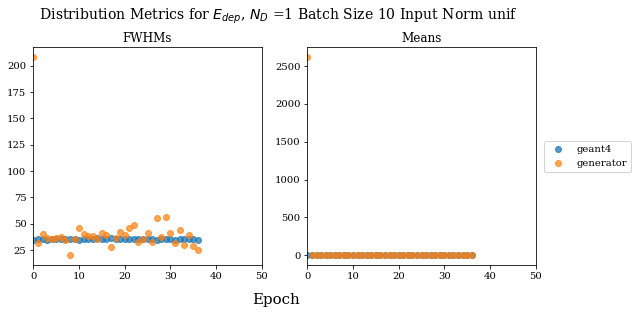

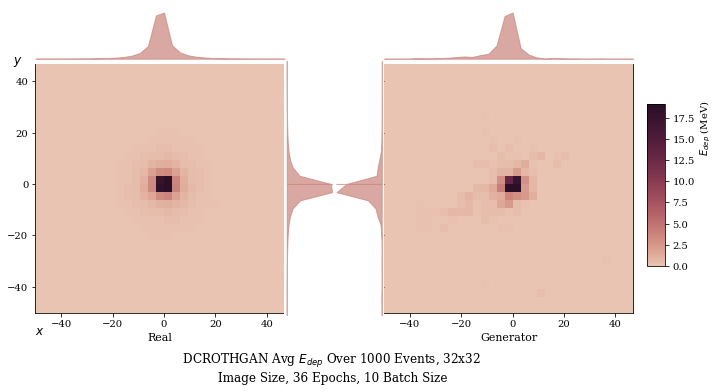

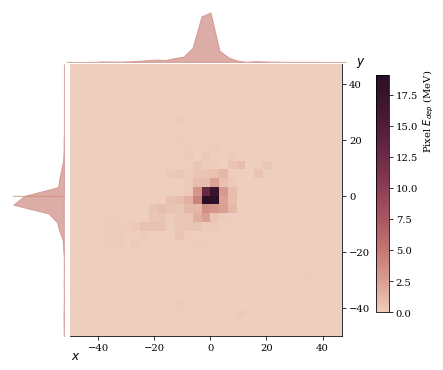

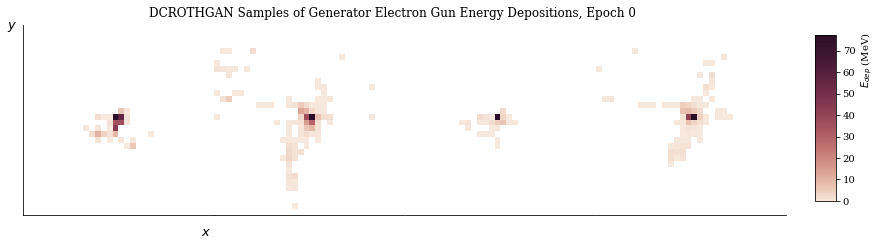

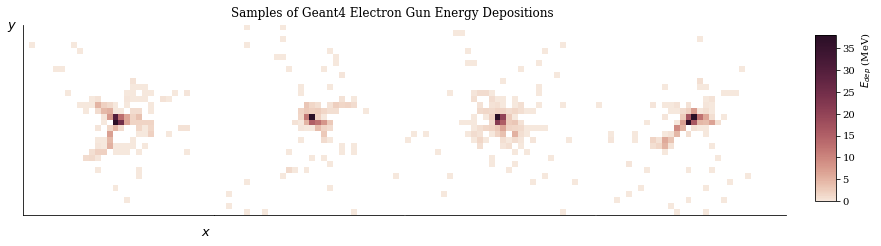

[36/100][0/3000] Loss_D: 0.0103 Loss_G: 5.9444 D(x): 0.9952 D(G(z)): 0.0054 / 0.0049
[36/100][100/3000] Loss_D: 0.0052 Loss_G: 5.0761 D(x): 0.9995 D(G(z)): 0.0047 / 0.0077
[36/100][200/3000] Loss_D: 0.2719 Loss_G: 0.4727 D(x): 0.8029 D(G(z)): 0.0323 / 0.6541
[36/100][300/3000] Loss_D: 0.0477 Loss_G: 4.4782 D(x): 0.9909 D(G(z)): 0.0375 / 0.0152
[36/100][400/3000] Loss_D: 0.0742 Loss_G: 3.2025 D(x): 0.9931 D(G(z)): 0.0646 / 0.0444
[36/100][500/3000] Loss_D: 0.0935 Loss_G: 2.9319 D(x): 0.9479 D(G(z)): 0.0350 / 0.0657
[36/100][600/3000] Loss_D: 0.1725 Loss_G: 1.9799 D(x): 0.9999 D(G(z)): 0.1555 / 0.1529
[36/100][700/3000] Loss_D: 0.3745 Loss_G: 3.4029 D(x): 0.9998 D(G(z)): 0.3050 / 0.0365
[36/100][800/3000] Loss_D: 0.0401 Loss_G: 3.8598 D(x): 0.9946 D(G(z)): 0.0338 / 0.0263
[36/100][900/3000] Loss_D: 0.0436 Loss_G: 4.5219 D(x): 0.9697 D(G(z)): 0.0124 / 0.0125
[36/100][1000/3000] Loss_D: 0.4862 Loss_G: 2.2092 D(x): 0.9976 D(G(z)): 0.3446 / 0.1436
[36/100][1100/3000] Loss_D: 1.6322 Loss_G: 3

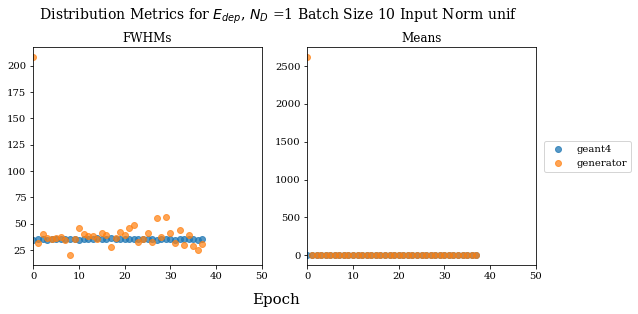

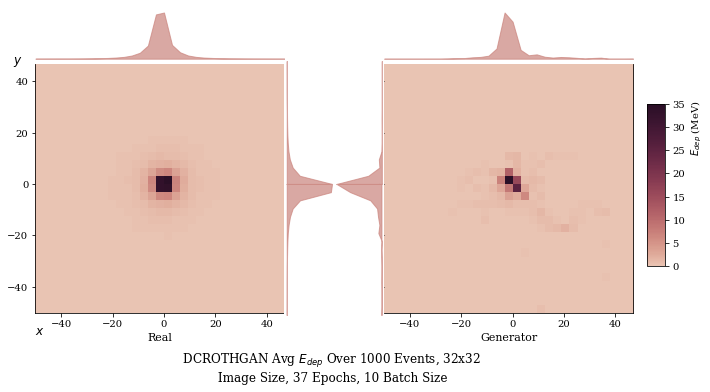

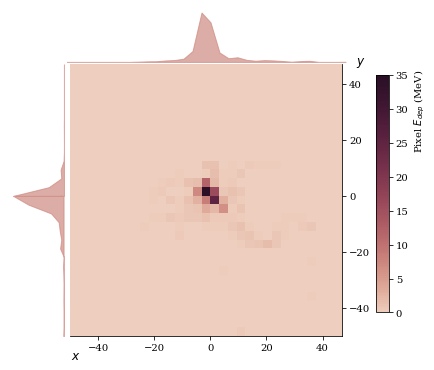

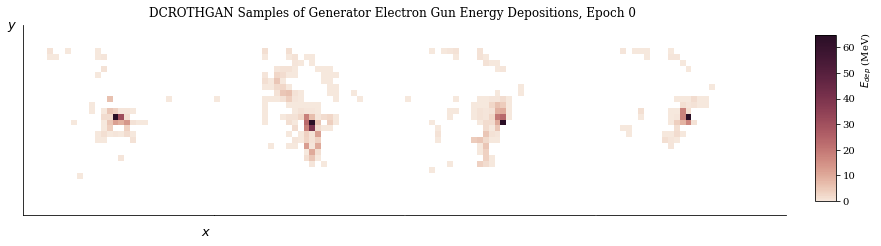

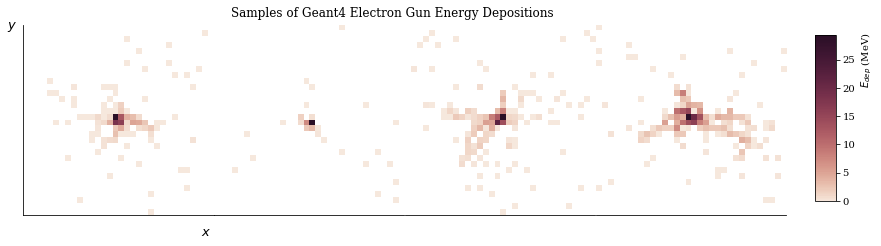

[37/100][0/3000] Loss_D: 0.0496 Loss_G: 4.5216 D(x): 0.9713 D(G(z)): 0.0199 / 0.0146
[37/100][100/3000] Loss_D: 0.0444 Loss_G: 3.3582 D(x): 0.9927 D(G(z)): 0.0364 / 0.0363
[37/100][200/3000] Loss_D: 0.3509 Loss_G: 0.8684 D(x): 0.9975 D(G(z)): 0.2656 / 0.4742
[37/100][300/3000] Loss_D: 0.0465 Loss_G: 4.1699 D(x): 0.9823 D(G(z)): 0.0277 / 0.0200
[37/100][400/3000] Loss_D: 0.0509 Loss_G: 3.9447 D(x): 0.9902 D(G(z)): 0.0399 / 0.0251
[37/100][500/3000] Loss_D: 0.0880 Loss_G: 3.0877 D(x): 0.9856 D(G(z)): 0.0705 / 0.0487
[37/100][600/3000] Loss_D: 0.0534 Loss_G: 3.5015 D(x): 0.9878 D(G(z)): 0.0399 / 0.0370
[37/100][700/3000] Loss_D: 0.1320 Loss_G: 5.1704 D(x): 0.9967 D(G(z)): 0.1172 / 0.0093
[37/100][800/3000] Loss_D: 0.0334 Loss_G: 4.9131 D(x): 0.9906 D(G(z)): 0.0235 / 0.0095
[37/100][900/3000] Loss_D: 0.0498 Loss_G: 4.1598 D(x): 0.9682 D(G(z)): 0.0171 / 0.0186
[37/100][1000/3000] Loss_D: 0.0670 Loss_G: 2.4776 D(x): 0.9775 D(G(z)): 0.0423 / 0.1028
[37/100][1100/3000] Loss_D: 0.0988 Loss_G: 2

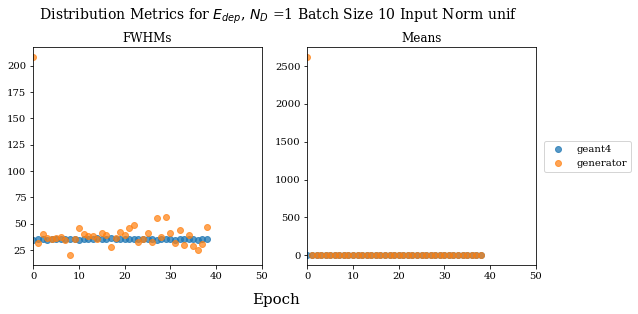

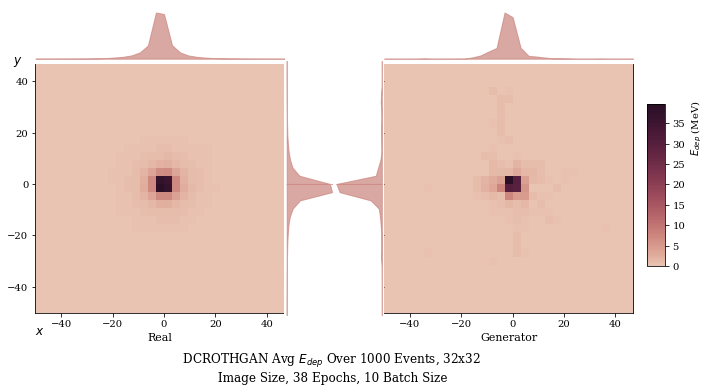

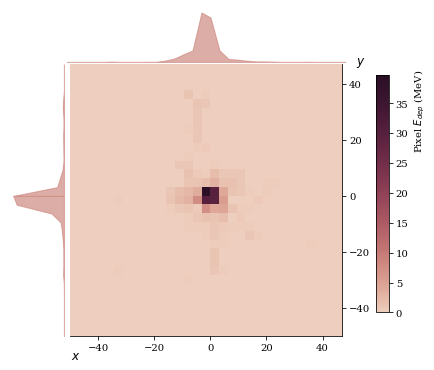

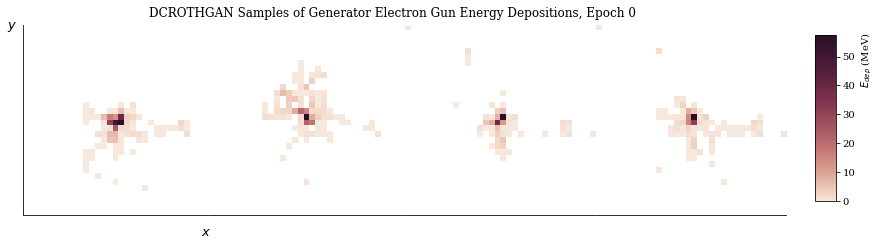

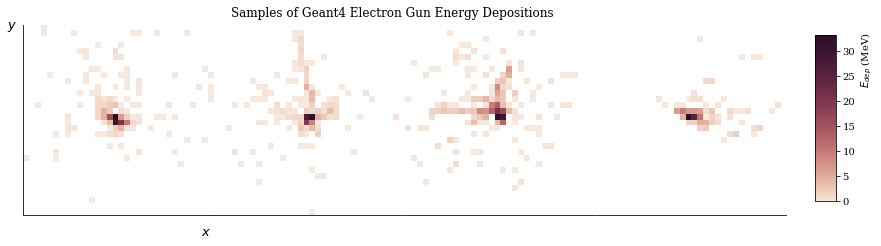

[38/100][0/3000] Loss_D: 0.0646 Loss_G: 3.7879 D(x): 0.9521 D(G(z)): 0.0142 / 0.0259
[38/100][100/3000] Loss_D: 0.0945 Loss_G: 3.0070 D(x): 0.9755 D(G(z)): 0.0663 / 0.0586
[38/100][200/3000] Loss_D: 0.1283 Loss_G: 2.9094 D(x): 0.9908 D(G(z)): 0.1112 / 0.0605
[38/100][300/3000] Loss_D: 0.0371 Loss_G: 3.9321 D(x): 0.9994 D(G(z)): 0.0355 / 0.0248
[38/100][400/3000] Loss_D: 0.5001 Loss_G: 2.0162 D(x): 0.9657 D(G(z)): 0.3561 / 0.1515
[38/100][500/3000] Loss_D: 0.0386 Loss_G: 4.0732 D(x): 0.9817 D(G(z)): 0.0195 / 0.0232
[38/100][600/3000] Loss_D: 0.2658 Loss_G: 2.4157 D(x): 0.9999 D(G(z)): 0.2225 / 0.1079
[38/100][700/3000] Loss_D: 0.1324 Loss_G: 1.9259 D(x): 0.8936 D(G(z)): 0.0161 / 0.2325
[38/100][800/3000] Loss_D: 0.5508 Loss_G: 1.7588 D(x): 0.9989 D(G(z)): 0.3697 / 0.2432
[38/100][900/3000] Loss_D: 0.0793 Loss_G: 4.5493 D(x): 0.9896 D(G(z)): 0.0653 / 0.0143
[38/100][1000/3000] Loss_D: 0.1671 Loss_G: 3.6931 D(x): 0.8685 D(G(z)): 0.0115 / 0.0439
[38/100][1100/3000] Loss_D: 0.0800 Loss_G: 2

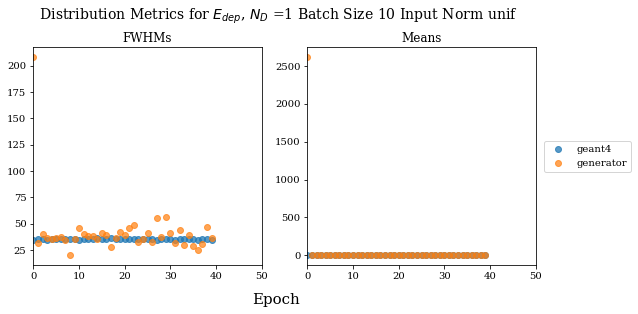

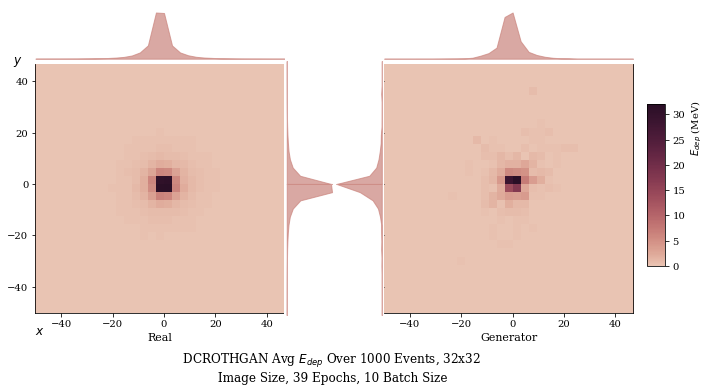

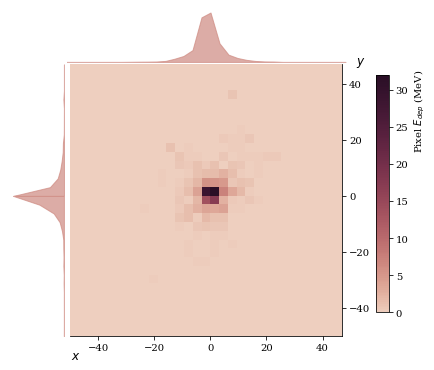

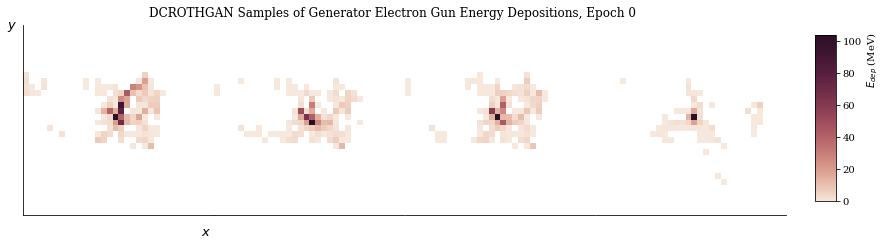

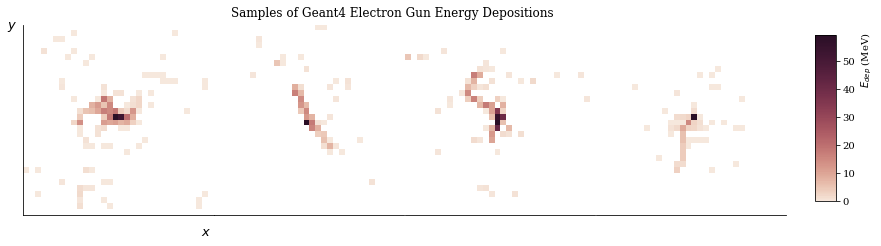

[39/100][0/3000] Loss_D: 0.0200 Loss_G: 4.4601 D(x): 0.9964 D(G(z)): 0.0162 / 0.0124
[39/100][100/3000] Loss_D: 0.0396 Loss_G: 3.9575 D(x): 0.9959 D(G(z)): 0.0345 / 0.0295
[39/100][200/3000] Loss_D: 0.3100 Loss_G: 0.6587 D(x): 0.8827 D(G(z)): 0.1581 / 0.5838
[39/100][300/3000] Loss_D: 0.0140 Loss_G: 5.0547 D(x): 0.9978 D(G(z)): 0.0118 / 0.0080
[39/100][400/3000] Loss_D: 0.3431 Loss_G: 0.3669 D(x): 0.7592 D(G(z)): 0.0248 / 0.7034
[39/100][500/3000] Loss_D: 0.3161 Loss_G: 2.9390 D(x): 0.9988 D(G(z)): 0.2410 / 0.0926
[39/100][600/3000] Loss_D: 0.1976 Loss_G: 2.4559 D(x): 0.9910 D(G(z)): 0.1698 / 0.0943
[39/100][700/3000] Loss_D: 0.5327 Loss_G: 2.7616 D(x): 1.0000 D(G(z)): 0.3358 / 0.1137
[39/100][800/3000] Loss_D: 0.1367 Loss_G: 3.3750 D(x): 0.9889 D(G(z)): 0.1132 / 0.0533
[39/100][900/3000] Loss_D: 0.1240 Loss_G: 4.4892 D(x): 0.9131 D(G(z)): 0.0124 / 0.0155
[39/100][1000/3000] Loss_D: 0.0647 Loss_G: 3.5717 D(x): 0.9794 D(G(z)): 0.0423 / 0.0430
[39/100][1100/3000] Loss_D: 0.0339 Loss_G: 5

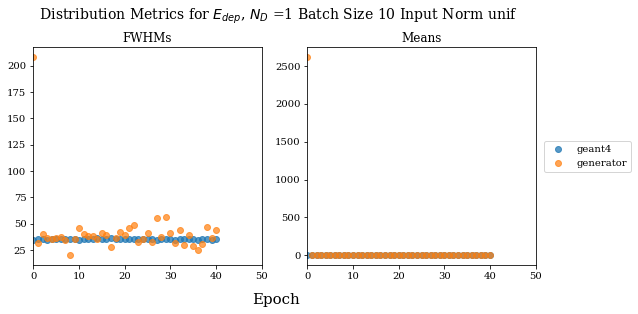

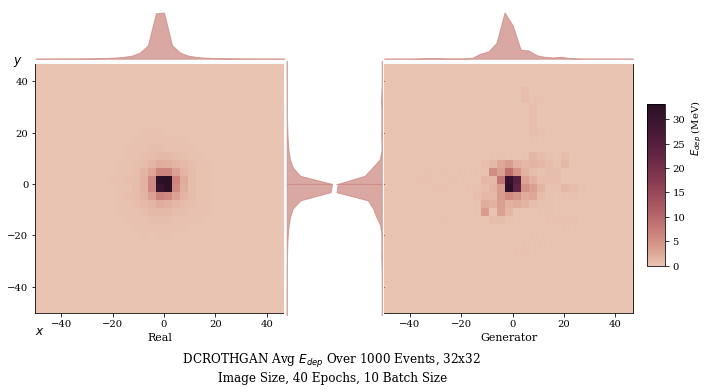

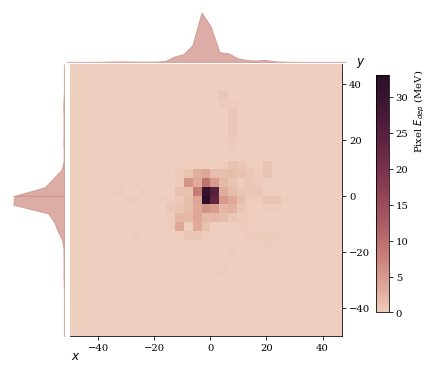

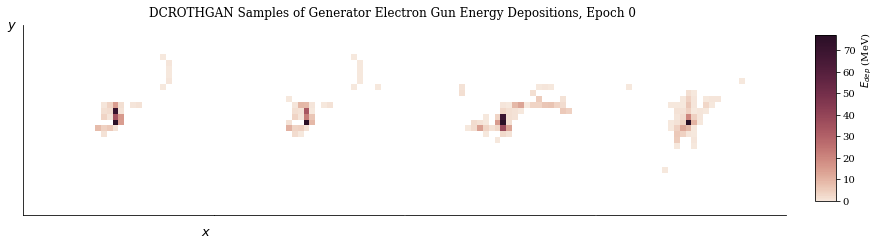

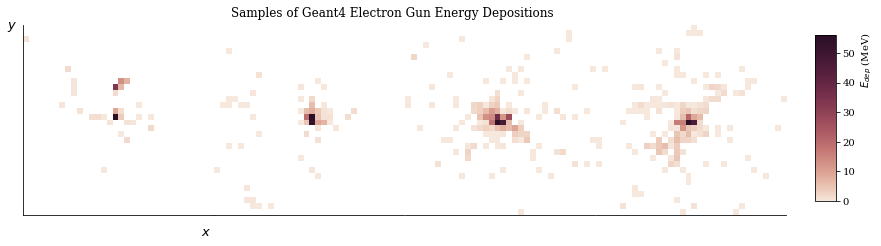

[40/100][0/3000] Loss_D: 0.2614 Loss_G: 2.0744 D(x): 0.9605 D(G(z)): 0.1957 / 0.1312
[40/100][100/3000] Loss_D: 0.3156 Loss_G: 2.3937 D(x): 0.9951 D(G(z)): 0.2661 / 0.0927
[40/100][200/3000] Loss_D: 0.0990 Loss_G: 3.0546 D(x): 0.9781 D(G(z)): 0.0725 / 0.0558
[40/100][300/3000] Loss_D: 0.0676 Loss_G: 3.4068 D(x): 0.9786 D(G(z)): 0.0444 / 0.0377
[40/100][400/3000] Loss_D: 0.0588 Loss_G: 5.8217 D(x): 0.9459 D(G(z)): 0.0020 / 0.0042
[40/100][500/3000] Loss_D: 0.1484 Loss_G: 2.3335 D(x): 0.9395 D(G(z)): 0.0797 / 0.1147
[40/100][600/3000] Loss_D: 0.0291 Loss_G: 4.5975 D(x): 0.9974 D(G(z)): 0.0256 / 0.0172
[40/100][700/3000] Loss_D: 0.2578 Loss_G: 2.6657 D(x): 0.9815 D(G(z)): 0.2110 / 0.0724
[40/100][800/3000] Loss_D: 0.0803 Loss_G: 3.0822 D(x): 0.9994 D(G(z)): 0.0762 / 0.0486
[40/100][900/3000] Loss_D: 0.0382 Loss_G: 6.3022 D(x): 0.9649 D(G(z)): 0.0020 / 0.0025
[40/100][1000/3000] Loss_D: 0.2701 Loss_G: 2.6374 D(x): 0.9791 D(G(z)): 0.2101 / 0.0914
[40/100][1100/3000] Loss_D: 0.1599 Loss_G: 2

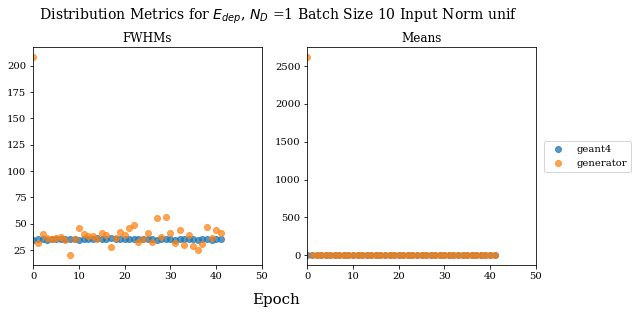

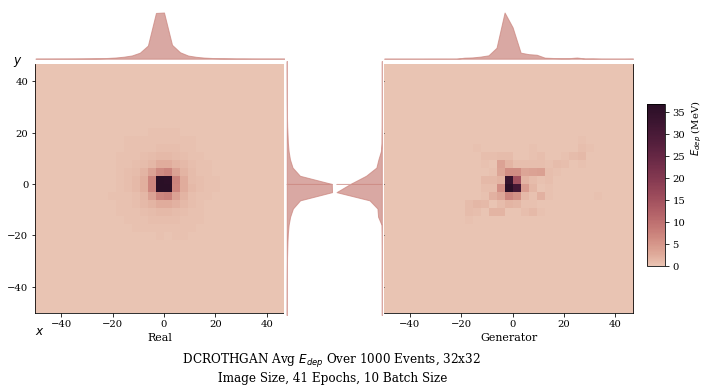

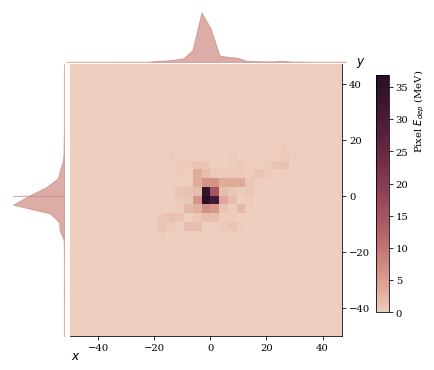

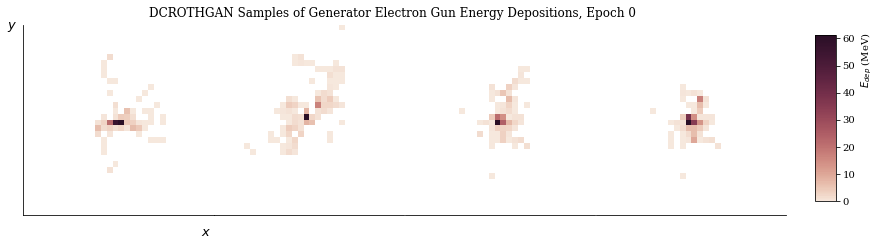

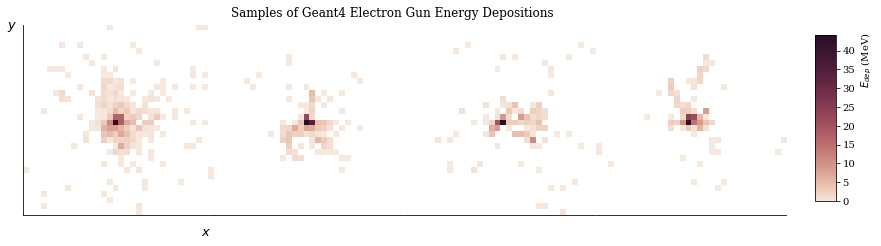

[41/100][0/3000] Loss_D: 0.0139 Loss_G: 4.8081 D(x): 0.9992 D(G(z)): 0.0131 / 0.0094
[41/100][100/3000] Loss_D: 0.0198 Loss_G: 4.0371 D(x): 0.9999 D(G(z)): 0.0194 / 0.0210
[41/100][200/3000] Loss_D: 0.0428 Loss_G: 4.3993 D(x): 0.9936 D(G(z)): 0.0352 / 0.0161
[41/100][300/3000] Loss_D: 0.0218 Loss_G: 4.5738 D(x): 0.9984 D(G(z)): 0.0200 / 0.0123
[41/100][400/3000] Loss_D: 0.0838 Loss_G: 3.0578 D(x): 0.9303 D(G(z)): 0.0102 / 0.0704
[41/100][500/3000] Loss_D: 0.0506 Loss_G: 3.5408 D(x): 0.9877 D(G(z)): 0.0372 / 0.0338
[41/100][600/3000] Loss_D: 0.5962 Loss_G: 2.1823 D(x): 0.9998 D(G(z)): 0.3995 / 0.1384
[41/100][700/3000] Loss_D: 0.0134 Loss_G: 4.9309 D(x): 0.9983 D(G(z)): 0.0116 / 0.0088
[41/100][800/3000] Loss_D: 0.1430 Loss_G: 2.5348 D(x): 0.9951 D(G(z)): 0.1278 / 0.0845
[41/100][900/3000] Loss_D: 0.1134 Loss_G: 2.8646 D(x): 0.9999 D(G(z)): 0.1044 / 0.0700
[41/100][1000/3000] Loss_D: 0.1543 Loss_G: 3.3669 D(x): 0.9816 D(G(z)): 0.1187 / 0.0583
[41/100][1100/3000] Loss_D: 0.8904 Loss_G: 0

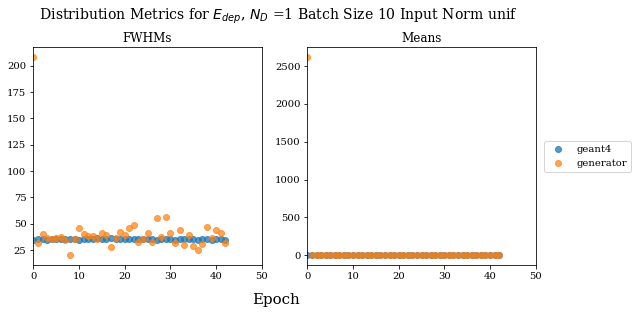

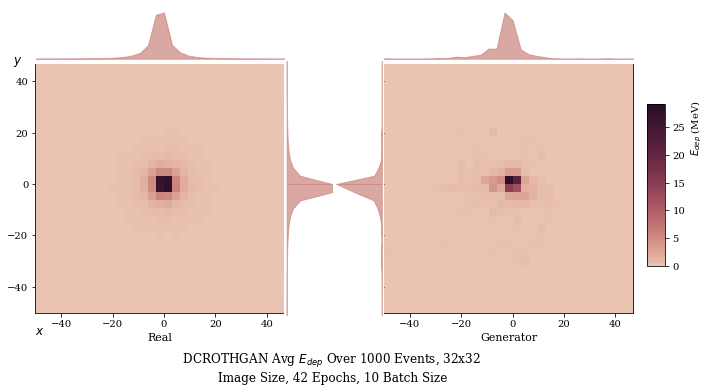

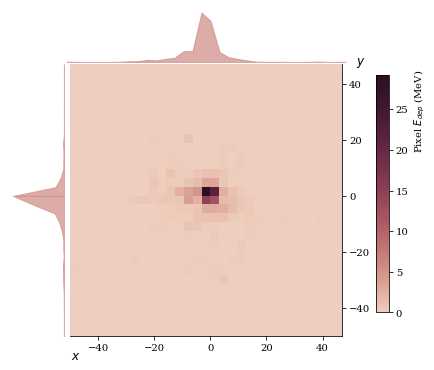

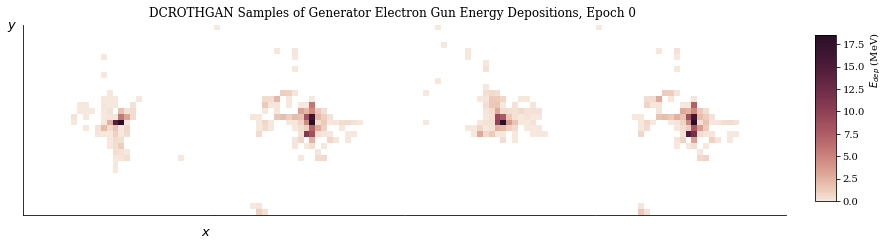

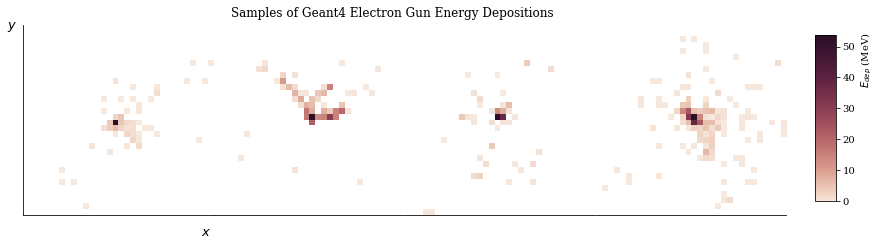

[42/100][0/3000] Loss_D: 0.1340 Loss_G: 1.5971 D(x): 0.9132 D(G(z)): 0.0400 / 0.2240
[42/100][100/3000] Loss_D: 0.0598 Loss_G: 4.6430 D(x): 0.9964 D(G(z)): 0.0506 / 0.0366
[42/100][200/3000] Loss_D: 0.0724 Loss_G: 3.0264 D(x): 0.9416 D(G(z)): 0.0112 / 0.0533
[42/100][300/3000] Loss_D: 0.0414 Loss_G: 3.6867 D(x): 0.9978 D(G(z)): 0.0384 / 0.0261
[42/100][400/3000] Loss_D: 0.0119 Loss_G: 5.2554 D(x): 0.9991 D(G(z)): 0.0110 / 0.0061
[42/100][500/3000] Loss_D: 0.0552 Loss_G: 6.5587 D(x): 0.9561 D(G(z)): 0.0077 / 0.0186
[42/100][600/3000] Loss_D: 0.0024 Loss_G: 7.7465 D(x): 0.9981 D(G(z)): 0.0005 / 0.0005
[42/100][700/3000] Loss_D: 0.0194 Loss_G: 4.3998 D(x): 0.9993 D(G(z)): 0.0184 / 0.0143
[42/100][800/3000] Loss_D: 0.0803 Loss_G: 4.0768 D(x): 0.9941 D(G(z)): 0.0706 / 0.0210
[42/100][900/3000] Loss_D: 0.7028 Loss_G: 1.3572 D(x): 0.6550 D(G(z)): 0.1698 / 0.3206
[42/100][1000/3000] Loss_D: 0.1316 Loss_G: 1.9027 D(x): 0.9423 D(G(z)): 0.0674 / 0.1568
[42/100][1100/3000] Loss_D: 0.1620 Loss_G: 2

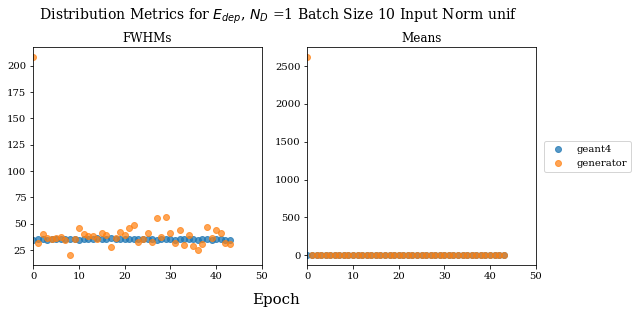

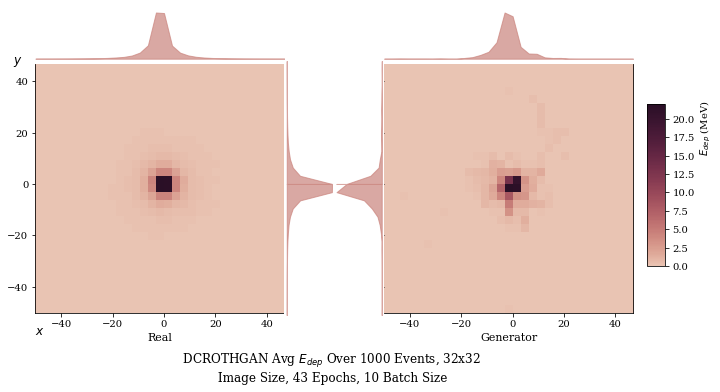

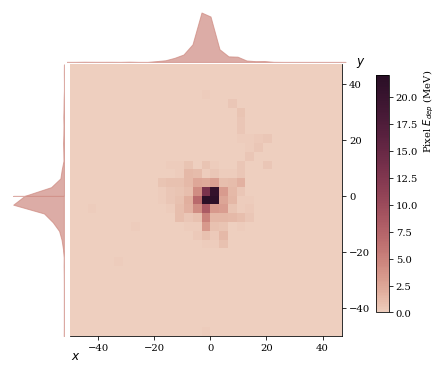

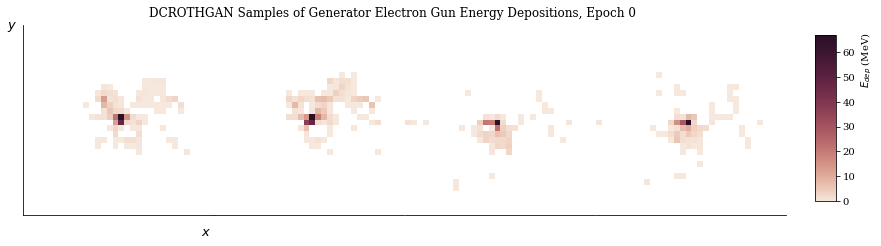

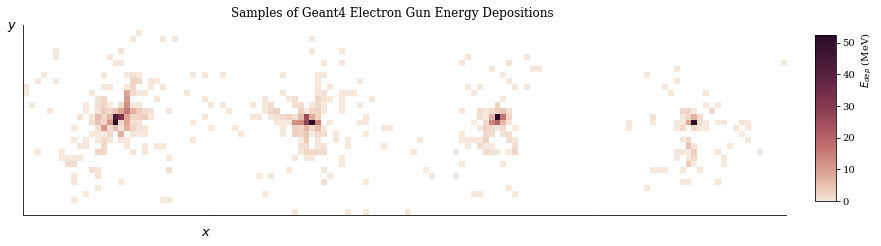

[43/100][0/3000] Loss_D: 0.0089 Loss_G: 5.7474 D(x): 0.9957 D(G(z)): 0.0046 / 0.0037
[43/100][100/3000] Loss_D: 0.0169 Loss_G: 4.9421 D(x): 0.9960 D(G(z)): 0.0127 / 0.0121
[43/100][200/3000] Loss_D: 0.0402 Loss_G: 4.0069 D(x): 0.9786 D(G(z)): 0.0183 / 0.0207
[43/100][300/3000] Loss_D: 0.2430 Loss_G: 1.7152 D(x): 0.8070 D(G(z)): 0.0063 / 0.2248
[43/100][400/3000] Loss_D: 0.0265 Loss_G: 4.8101 D(x): 0.9925 D(G(z)): 0.0187 / 0.0106
[43/100][500/3000] Loss_D: 0.8771 Loss_G: 2.2983 D(x): 0.9650 D(G(z)): 0.5480 / 0.1110
[43/100][600/3000] Loss_D: 0.0083 Loss_G: 6.6059 D(x): 0.9944 D(G(z)): 0.0026 / 0.0020
[43/100][700/3000] Loss_D: 0.0417 Loss_G: 5.3347 D(x): 0.9629 D(G(z)): 0.0033 / 0.0054
[43/100][800/3000] Loss_D: 0.0116 Loss_G: 7.5738 D(x): 0.9899 D(G(z)): 0.0015 / 0.0007
[43/100][900/3000] Loss_D: 0.0215 Loss_G: 5.3743 D(x): 0.9989 D(G(z)): 0.0199 / 0.0068
[43/100][1000/3000] Loss_D: 0.2911 Loss_G: 0.0543 D(x): 0.8522 D(G(z)): 0.1142 / 0.9479
[43/100][1100/3000] Loss_D: 0.2210 Loss_G: 2

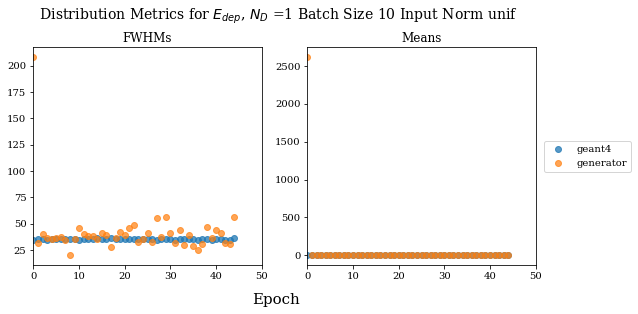

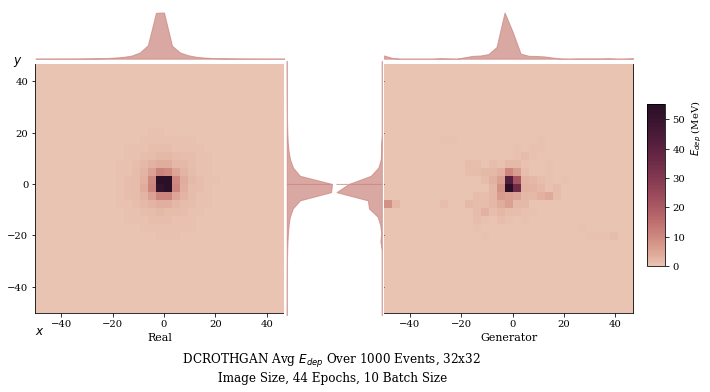

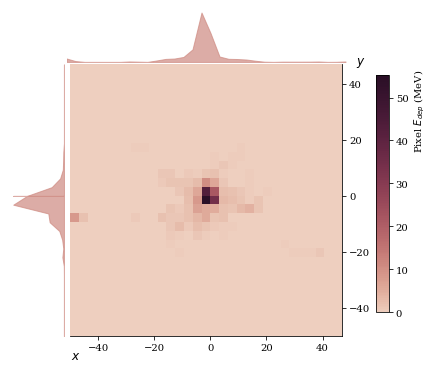

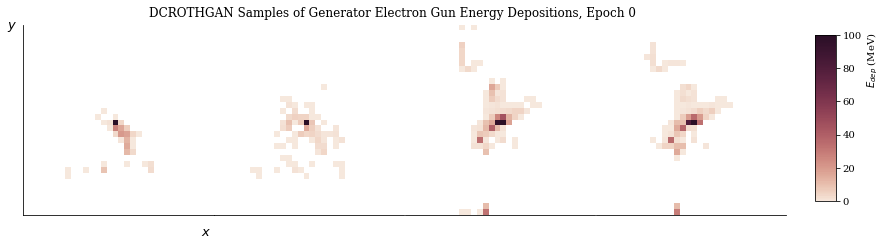

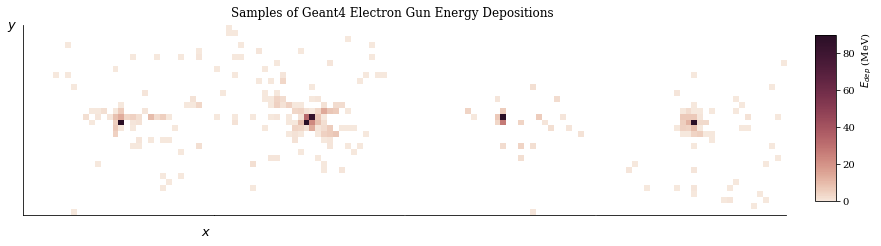

[44/100][0/3000] Loss_D: 0.0018 Loss_G: 7.6617 D(x): 0.9990 D(G(z)): 0.0008 / 0.0006
[44/100][100/3000] Loss_D: 0.0101 Loss_G: 5.2956 D(x): 0.9989 D(G(z)): 0.0090 / 0.0083
[44/100][200/3000] Loss_D: 0.4076 Loss_G: 1.9873 D(x): 0.7220 D(G(z)): 0.0174 / 0.1956
[44/100][300/3000] Loss_D: 0.0365 Loss_G: 4.2860 D(x): 0.9955 D(G(z)): 0.0308 / 0.0231
[44/100][400/3000] Loss_D: 0.0869 Loss_G: 2.4586 D(x): 0.9713 D(G(z)): 0.0552 / 0.0931
[44/100][500/3000] Loss_D: 0.0597 Loss_G: 3.7802 D(x): 0.9623 D(G(z)): 0.0202 / 0.0273
[44/100][600/3000] Loss_D: 0.1794 Loss_G: 2.9803 D(x): 0.9547 D(G(z)): 0.1141 / 0.0610
[44/100][700/3000] Loss_D: 0.4701 Loss_G: 2.8958 D(x): 0.9692 D(G(z)): 0.3475 / 0.0604
[44/100][800/3000] Loss_D: 0.0713 Loss_G: 2.9515 D(x): 0.9933 D(G(z)): 0.0617 / 0.0671
[44/100][900/3000] Loss_D: 0.2220 Loss_G: 3.7379 D(x): 0.8437 D(G(z)): 0.0100 / 0.0357
[44/100][1000/3000] Loss_D: 0.0437 Loss_G: 4.8937 D(x): 0.9696 D(G(z)): 0.0101 / 0.0101
[44/100][1100/3000] Loss_D: 0.3972 Loss_G: 3

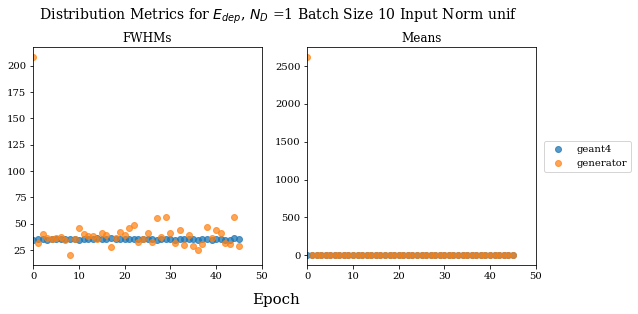

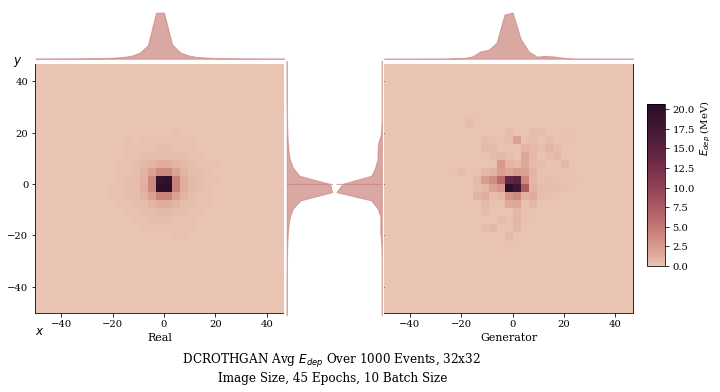

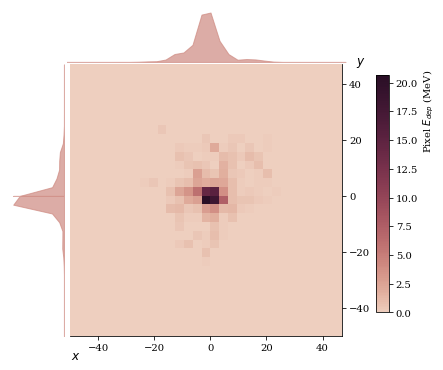

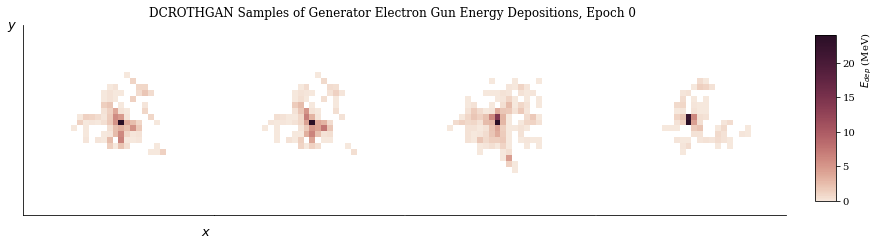

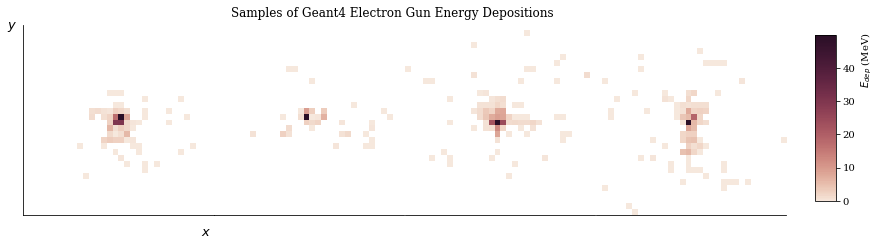

[45/100][0/3000] Loss_D: 0.0760 Loss_G: 3.8227 D(x): 0.9504 D(G(z)): 0.0160 / 0.0257
[45/100][100/3000] Loss_D: 0.0456 Loss_G: 3.7852 D(x): 0.9968 D(G(z)): 0.0412 / 0.0296
[45/100][200/3000] Loss_D: 0.0078 Loss_G: 6.1383 D(x): 0.9963 D(G(z)): 0.0041 / 0.0030
[45/100][300/3000] Loss_D: 0.9220 Loss_G: 3.9122 D(x): 0.9999 D(G(z)): 0.5857 / 0.0216
[45/100][400/3000] Loss_D: 0.0311 Loss_G: 3.4067 D(x): 0.9930 D(G(z)): 0.0237 / 0.0363
[45/100][500/3000] Loss_D: 0.0651 Loss_G: 3.0587 D(x): 0.9969 D(G(z)): 0.0600 / 0.0486
[45/100][600/3000] Loss_D: 0.1116 Loss_G: 4.3482 D(x): 1.0000 D(G(z)): 0.1017 / 0.0170
[45/100][700/3000] Loss_D: 0.0182 Loss_G: 4.9579 D(x): 0.9961 D(G(z)): 0.0141 / 0.0125
[45/100][800/3000] Loss_D: 0.0210 Loss_G: 4.6956 D(x): 0.9998 D(G(z)): 0.0205 / 0.0113
[45/100][900/3000] Loss_D: 0.0096 Loss_G: 8.6374 D(x): 0.9908 D(G(z)): 0.0003 / 0.0002
[45/100][1000/3000] Loss_D: 0.1641 Loss_G: 2.8295 D(x): 0.9000 D(G(z)): 0.0270 / 0.0827
[45/100][1100/3000] Loss_D: 0.6621 Loss_G: 1

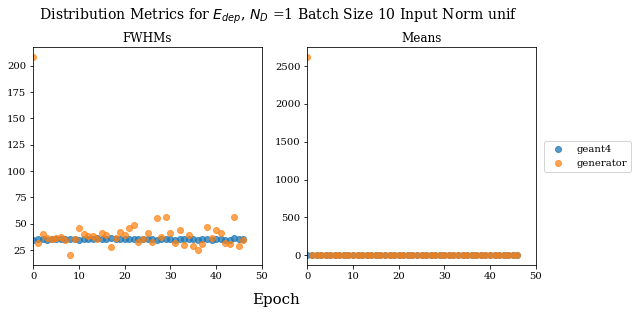

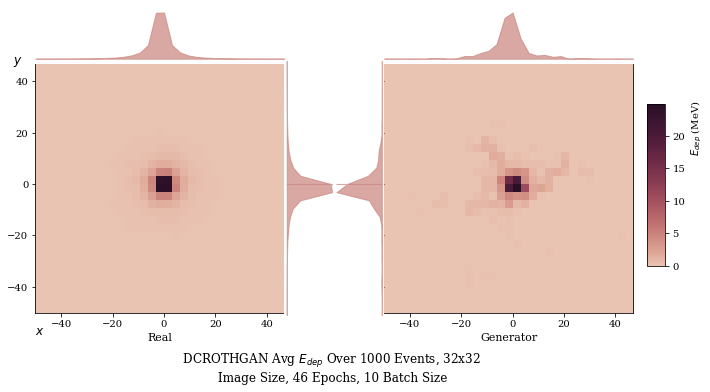

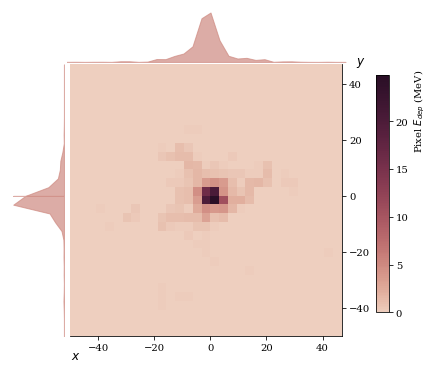

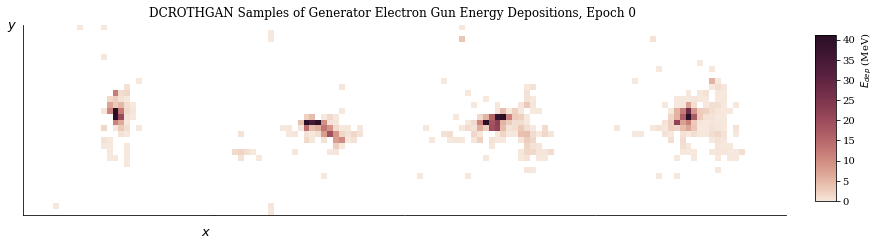

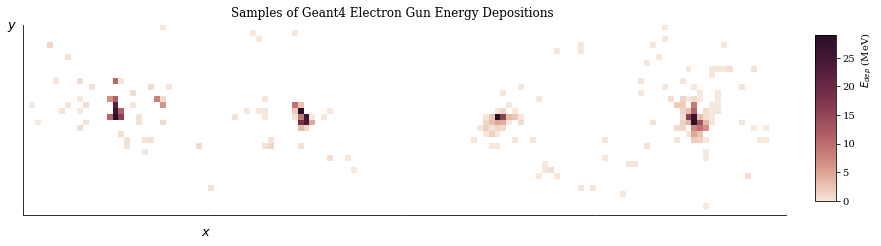

[46/100][0/3000] Loss_D: 0.1523 Loss_G: 2.8587 D(x): 0.9997 D(G(z)): 0.1369 / 0.0773
[46/100][100/3000] Loss_D: 0.1789 Loss_G: 2.9713 D(x): 0.9982 D(G(z)): 0.1588 / 0.0611
[46/100][200/3000] Loss_D: 0.6024 Loss_G: 2.9176 D(x): 0.9944 D(G(z)): 0.4237 / 0.0667
[46/100][300/3000] Loss_D: 0.0182 Loss_G: 4.9175 D(x): 0.9946 D(G(z)): 0.0126 / 0.0094
[46/100][400/3000] Loss_D: 0.5522 Loss_G: 2.3222 D(x): 0.7231 D(G(z)): 0.0534 / 0.1422
[46/100][500/3000] Loss_D: 0.0658 Loss_G: 3.8438 D(x): 0.9545 D(G(z)): 0.0175 / 0.0289
[46/100][600/3000] Loss_D: 0.1221 Loss_G: 3.1662 D(x): 0.9998 D(G(z)): 0.1103 / 0.0577
[46/100][700/3000] Loss_D: 0.2717 Loss_G: 0.1883 D(x): 0.8479 D(G(z)): 0.0892 / 0.8325
[46/100][800/3000] Loss_D: 0.3058 Loss_G: 1.5086 D(x): 0.9996 D(G(z)): 0.2438 / 0.2923
[46/100][900/3000] Loss_D: 0.0111 Loss_G: 4.9854 D(x): 0.9987 D(G(z)): 0.0097 / 0.0073
[46/100][1000/3000] Loss_D: 0.3447 Loss_G: 1.7685 D(x): 0.9678 D(G(z)): 0.2522 / 0.1967
[46/100][1100/3000] Loss_D: 3.4487 Loss_G: 0

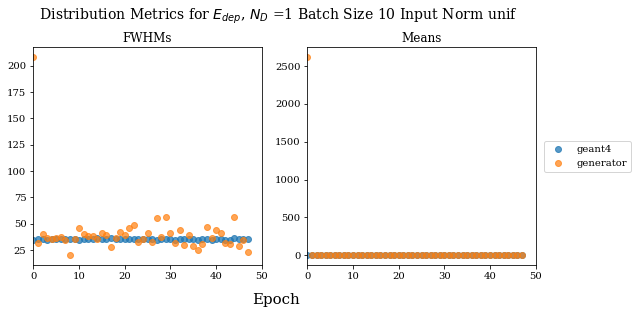

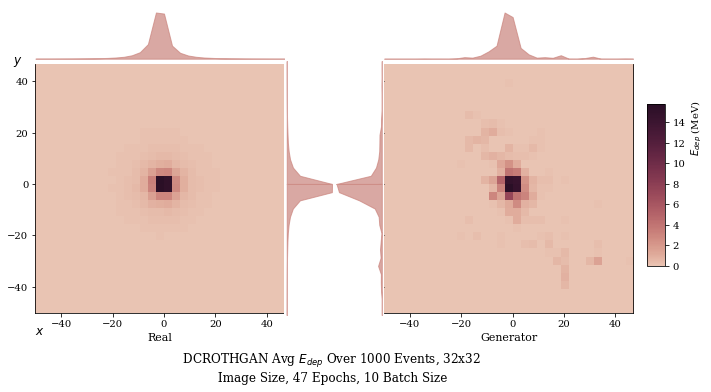

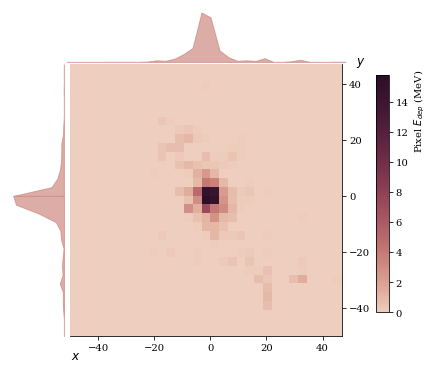

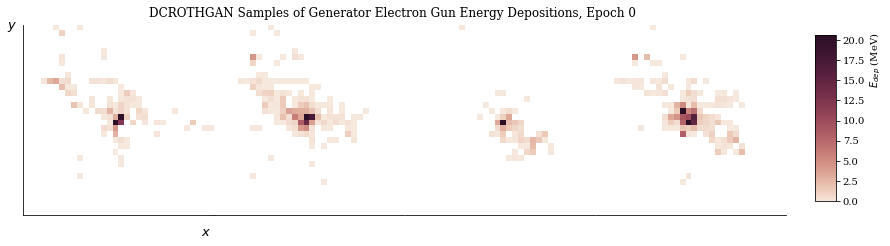

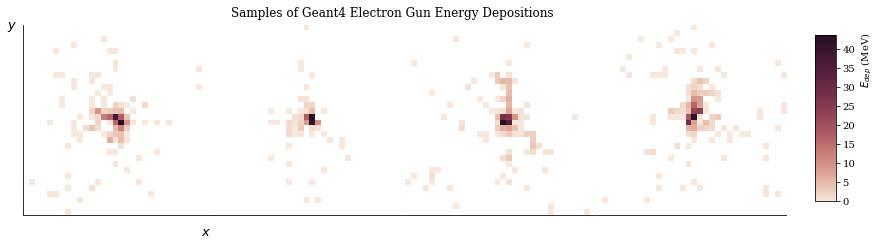

[47/100][0/3000] Loss_D: 0.0621 Loss_G: 3.9023 D(x): 0.9650 D(G(z)): 0.0238 / 0.0306
[47/100][100/3000] Loss_D: 0.0437 Loss_G: 3.7907 D(x): 0.9981 D(G(z)): 0.0407 / 0.0326
[47/100][200/3000] Loss_D: 0.0197 Loss_G: 5.0929 D(x): 0.9972 D(G(z)): 0.0168 / 0.0072
[47/100][300/3000] Loss_D: 0.1060 Loss_G: 2.9687 D(x): 0.9972 D(G(z)): 0.0966 / 0.0598
[47/100][400/3000] Loss_D: 0.0075 Loss_G: 5.4195 D(x): 0.9989 D(G(z)): 0.0064 / 0.0061
[47/100][500/3000] Loss_D: 0.0471 Loss_G: 4.1379 D(x): 0.9768 D(G(z)): 0.0229 / 0.0213
[47/100][600/3000] Loss_D: 0.0979 Loss_G: 2.6336 D(x): 0.9986 D(G(z)): 0.0901 / 0.0913
[47/100][700/3000] Loss_D: 0.0490 Loss_G: 4.5232 D(x): 0.9900 D(G(z)): 0.0378 / 0.0130
[47/100][800/3000] Loss_D: 0.0551 Loss_G: 3.6007 D(x): 0.9788 D(G(z)): 0.0327 / 0.0324
[47/100][900/3000] Loss_D: 0.0028 Loss_G: 7.4636 D(x): 0.9999 D(G(z)): 0.0026 / 0.0006
[47/100][1000/3000] Loss_D: 0.0623 Loss_G: 5.5089 D(x): 0.9423 D(G(z)): 0.0020 / 0.0052
[47/100][1100/3000] Loss_D: 0.0441 Loss_G: 4

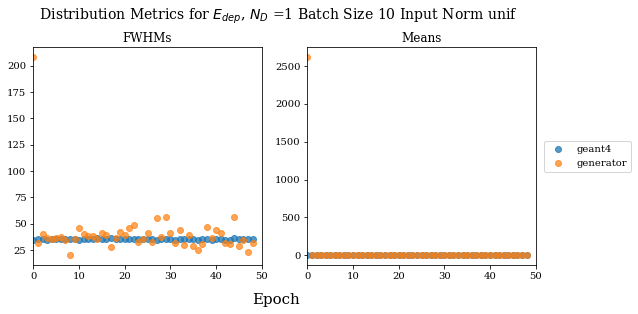

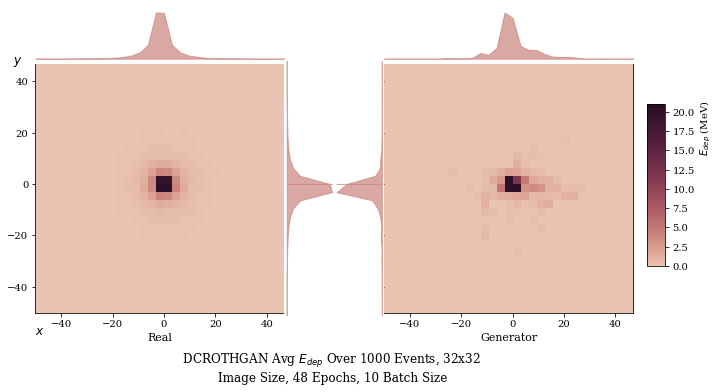

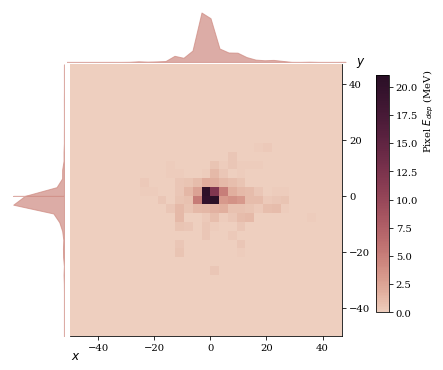

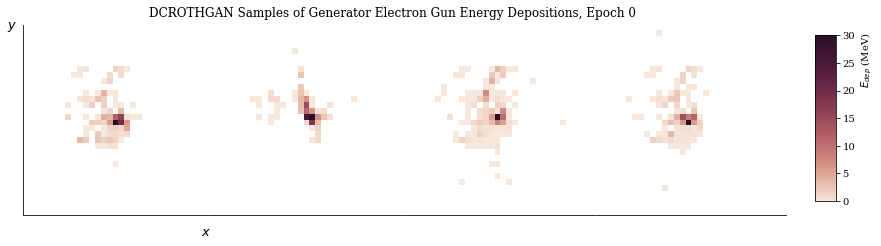

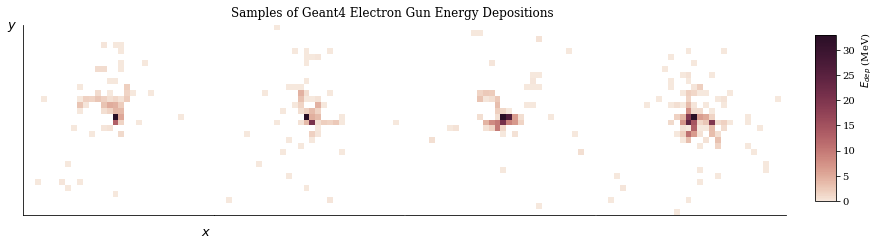

[48/100][0/3000] Loss_D: 0.1939 Loss_G: 1.2875 D(x): 0.8992 D(G(z)): 0.0751 / 0.3369
[48/100][100/3000] Loss_D: 0.0067 Loss_G: 6.8887 D(x): 0.9945 D(G(z)): 0.0013 / 0.0013
[48/100][200/3000] Loss_D: 0.1016 Loss_G: 2.1129 D(x): 0.9521 D(G(z)): 0.0499 / 0.1323
[48/100][300/3000] Loss_D: 0.0153 Loss_G: 6.7141 D(x): 0.9920 D(G(z)): 0.0072 / 0.0018
[48/100][400/3000] Loss_D: 0.0197 Loss_G: 4.5373 D(x): 0.9967 D(G(z)): 0.0162 / 0.0146
[48/100][500/3000] Loss_D: 0.0872 Loss_G: 2.3247 D(x): 0.9377 D(G(z)): 0.0207 / 0.1154
[48/100][600/3000] Loss_D: 0.0462 Loss_G: 3.7870 D(x): 0.9967 D(G(z)): 0.0417 / 0.0286
[48/100][700/3000] Loss_D: 0.1199 Loss_G: 2.6537 D(x): 0.9527 D(G(z)): 0.0666 / 0.0891
[48/100][800/3000] Loss_D: 0.2043 Loss_G: 2.7234 D(x): 0.9984 D(G(z)): 0.1784 / 0.0801
[48/100][900/3000] Loss_D: 0.4125 Loss_G: 0.3730 D(x): 0.8686 D(G(z)): 0.2155 / 0.7010
[48/100][1000/3000] Loss_D: 0.0811 Loss_G: 3.7238 D(x): 0.9951 D(G(z)): 0.0726 / 0.0288
[48/100][1100/3000] Loss_D: 4.1908 Loss_G: 0

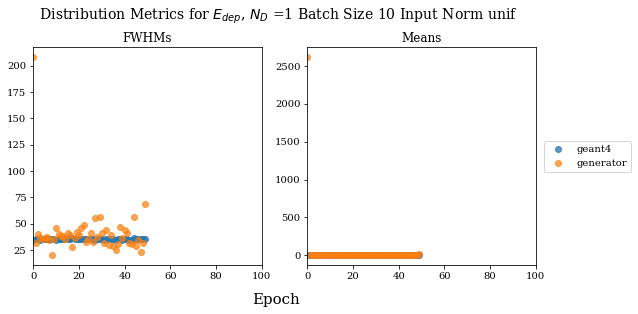

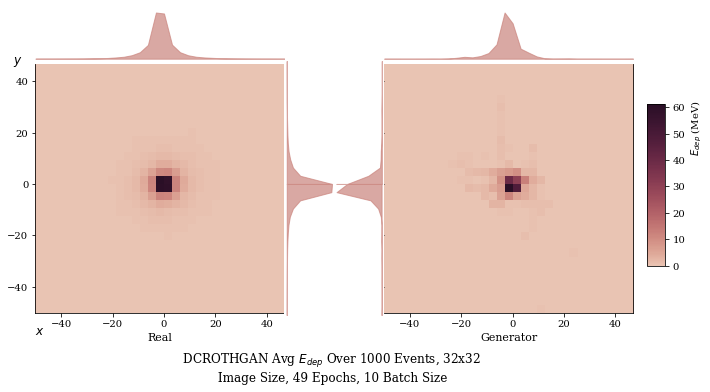

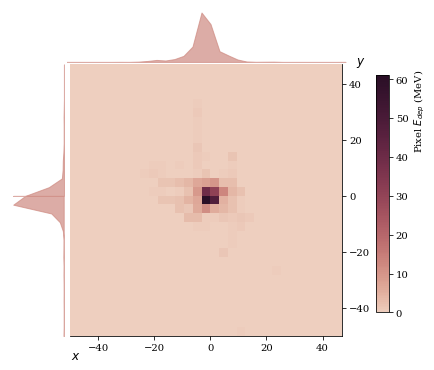

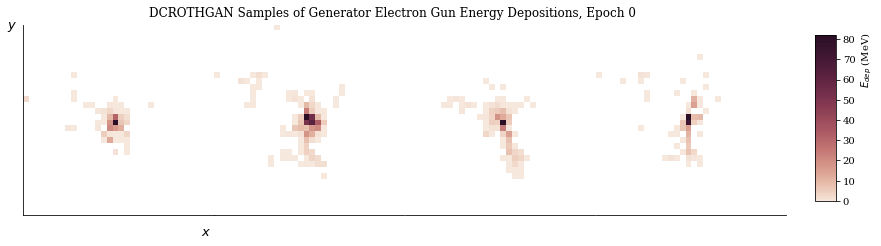

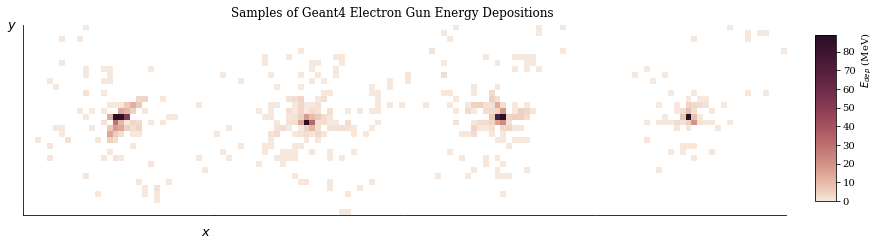

[49/100][0/3000] Loss_D: 0.0663 Loss_G: 3.1126 D(x): 0.9668 D(G(z)): 0.0299 / 0.0516
[49/100][100/3000] Loss_D: 0.1978 Loss_G: 3.0970 D(x): 0.9863 D(G(z)): 0.1606 / 0.0593
[49/100][200/3000] Loss_D: 0.0921 Loss_G: 3.6094 D(x): 0.9143 D(G(z)): 0.0011 / 0.0318
[49/100][300/3000] Loss_D: 0.0171 Loss_G: 7.7153 D(x): 0.9836 D(G(z)): 0.0005 / 0.0005
[49/100][400/3000] Loss_D: 0.0853 Loss_G: 3.6358 D(x): 0.9263 D(G(z)): 0.0051 / 0.0356
[49/100][500/3000] Loss_D: 2.9502 Loss_G: 1.4334 D(x): 0.9984 D(G(z)): 0.9220 / 0.3020
[49/100][600/3000] Loss_D: 0.1083 Loss_G: 3.0356 D(x): 0.9836 D(G(z)): 0.0863 / 0.0566
[49/100][700/3000] Loss_D: 0.0068 Loss_G: 6.1845 D(x): 1.0000 D(G(z)): 0.0067 / 0.0024
[49/100][800/3000] Loss_D: 0.0489 Loss_G: 3.3022 D(x): 0.9971 D(G(z)): 0.0444 / 0.0473
[49/100][900/3000] Loss_D: 0.0752 Loss_G: 4.2173 D(x): 0.9931 D(G(z)): 0.0614 / 0.0340
[49/100][1000/3000] Loss_D: 0.0252 Loss_G: 5.9891 D(x): 0.9787 D(G(z)): 0.0029 / 0.0047
[49/100][1100/3000] Loss_D: 0.0624 Loss_G: 3

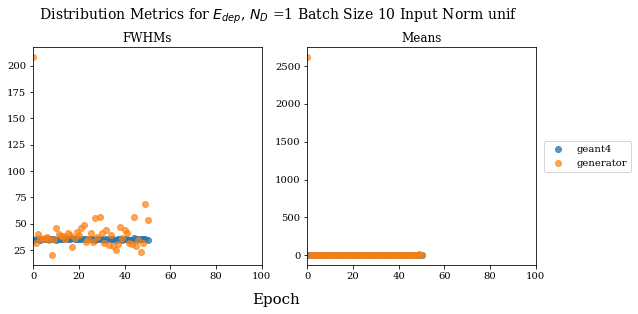

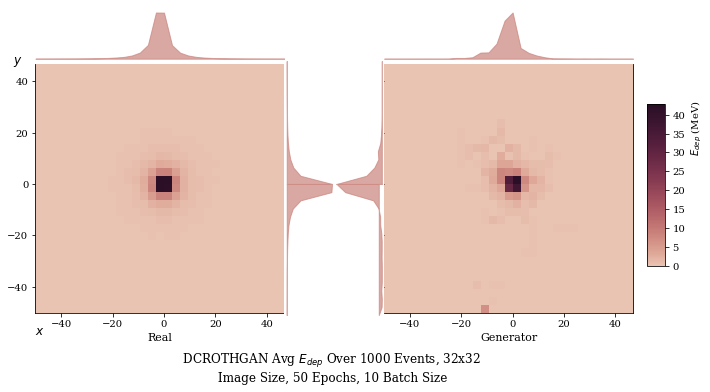

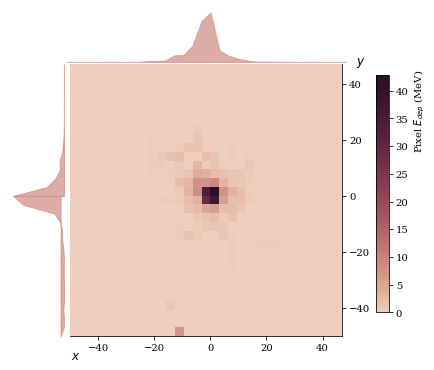

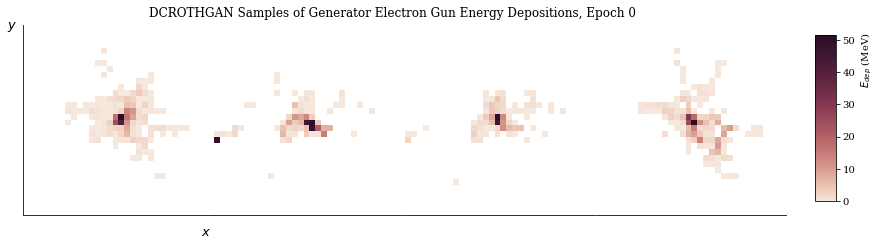

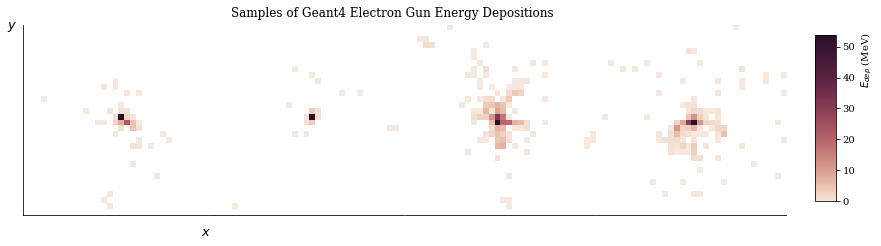

[50/100][0/3000] Loss_D: 0.0120 Loss_G: 7.2698 D(x): 0.9893 D(G(z)): 0.0011 / 0.0007
[50/100][100/3000] Loss_D: 0.1395 Loss_G: 3.2457 D(x): 0.9934 D(G(z)): 0.1225 / 0.0435
[50/100][200/3000] Loss_D: 0.3907 Loss_G: 2.9907 D(x): 0.7250 D(G(z)): 0.0085 / 0.0887
[50/100][300/3000] Loss_D: 0.0724 Loss_G: 3.5074 D(x): 0.9993 D(G(z)): 0.0682 / 0.0365
[50/100][400/3000] Loss_D: 0.6430 Loss_G: 2.1796 D(x): 0.9747 D(G(z)): 0.3824 / 0.1923
[50/100][500/3000] Loss_D: 0.8447 Loss_G: 1.1811 D(x): 0.9501 D(G(z)): 0.5161 / 0.3300
[50/100][600/3000] Loss_D: 0.1359 Loss_G: 1.9960 D(x): 0.9721 D(G(z)): 0.0996 / 0.1688
[50/100][700/3000] Loss_D: 0.0169 Loss_G: 5.2393 D(x): 0.9996 D(G(z)): 0.0162 / 0.0075
[50/100][800/3000] Loss_D: 0.1027 Loss_G: 3.4013 D(x): 0.9649 D(G(z)): 0.0624 / 0.0752
[50/100][900/3000] Loss_D: 0.3187 Loss_G: 1.8618 D(x): 0.9245 D(G(z)): 0.1869 / 0.1995
[50/100][1000/3000] Loss_D: 0.0111 Loss_G: 5.5244 D(x): 0.9998 D(G(z)): 0.0108 / 0.0059
[50/100][1100/3000] Loss_D: 0.6643 Loss_G: 1

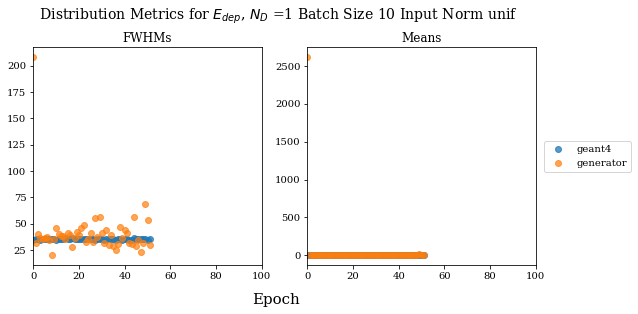

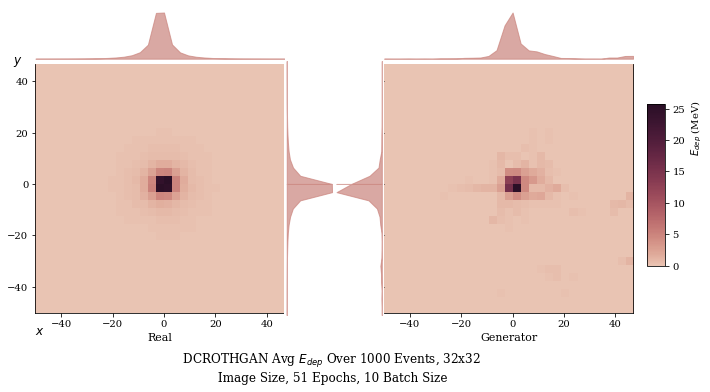

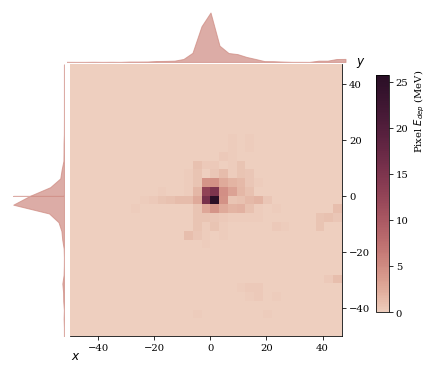

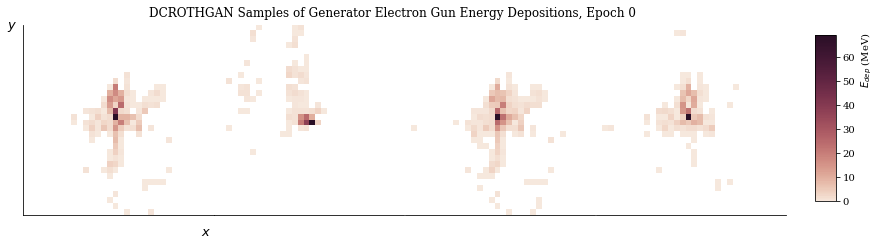

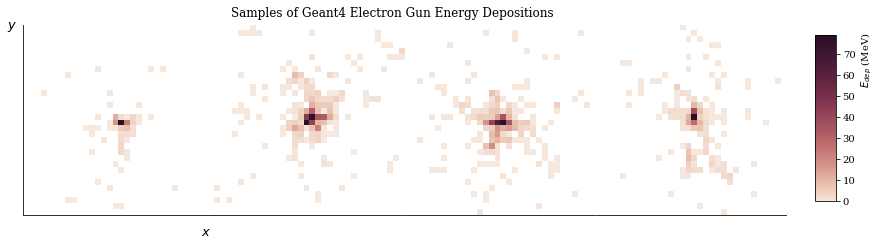

[51/100][0/3000] Loss_D: 0.0668 Loss_G: 3.7738 D(x): 0.9593 D(G(z)): 0.0244 / 0.0345
[51/100][100/3000] Loss_D: 0.0200 Loss_G: 4.6816 D(x): 0.9984 D(G(z)): 0.0181 / 0.0150
[51/100][200/3000] Loss_D: 0.1404 Loss_G: 1.6619 D(x): 0.8798 D(G(z)): 0.0043 / 0.2090
[51/100][300/3000] Loss_D: 0.0146 Loss_G: 5.0694 D(x): 0.9976 D(G(z)): 0.0121 / 0.0068
[51/100][400/3000] Loss_D: 0.0543 Loss_G: 4.4531 D(x): 0.9558 D(G(z)): 0.0087 / 0.0134
[51/100][500/3000] Loss_D: 0.0538 Loss_G: 4.1692 D(x): 0.9570 D(G(z)): 0.0085 / 0.0189
[51/100][600/3000] Loss_D: 0.0659 Loss_G: 3.8695 D(x): 0.9952 D(G(z)): 0.0587 / 0.0270
[51/100][700/3000] Loss_D: 0.0844 Loss_G: 2.7564 D(x): 0.9992 D(G(z)): 0.0792 / 0.0707
[51/100][800/3000] Loss_D: 0.2087 Loss_G: 1.3743 D(x): 0.8345 D(G(z)): 0.0159 / 0.3574
[51/100][900/3000] Loss_D: 0.5651 Loss_G: 4.0142 D(x): 0.9993 D(G(z)): 0.4064 / 0.0223
[51/100][1000/3000] Loss_D: 0.0223 Loss_G: 4.7715 D(x): 0.9937 D(G(z)): 0.0158 / 0.0106
[51/100][1100/3000] Loss_D: 0.0700 Loss_G: 3

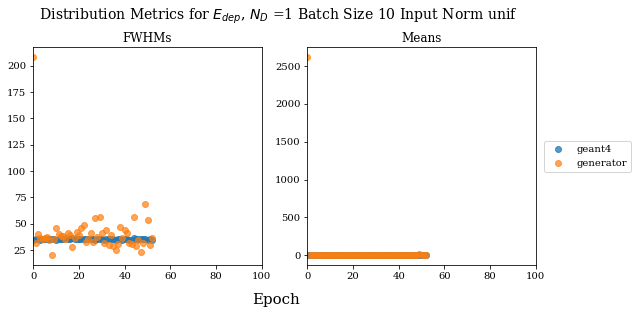

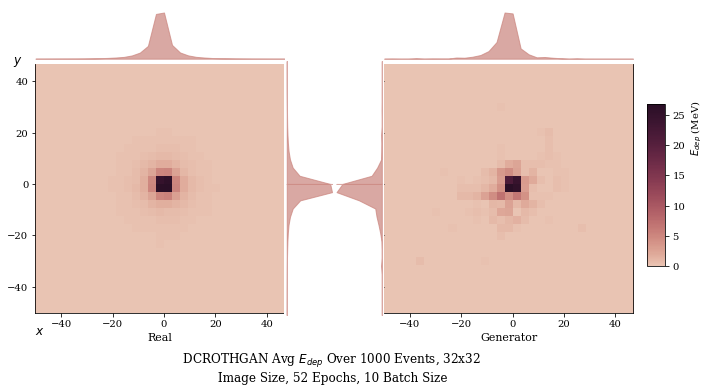

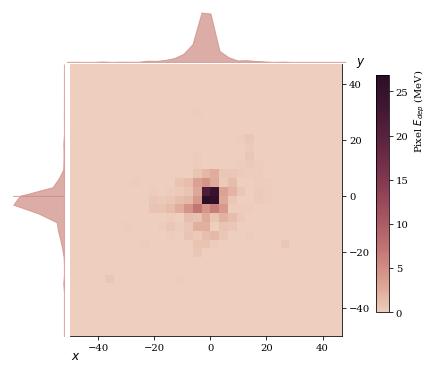

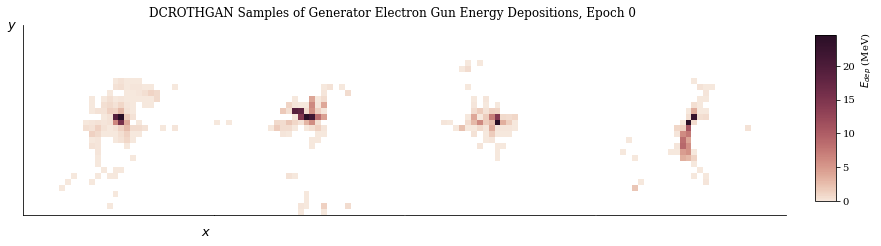

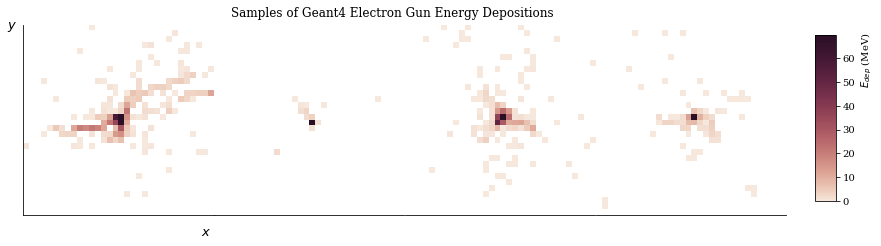

[52/100][0/3000] Loss_D: 0.0319 Loss_G: 4.1802 D(x): 0.9876 D(G(z)): 0.0192 / 0.0172
[52/100][100/3000] Loss_D: 0.0763 Loss_G: 3.1360 D(x): 0.9999 D(G(z)): 0.0730 / 0.0483
[52/100][200/3000] Loss_D: 0.3328 Loss_G: 0.1153 D(x): 0.7561 D(G(z)): 0.0268 / 0.8925
[52/100][300/3000] Loss_D: 0.0527 Loss_G: 3.9536 D(x): 0.9741 D(G(z)): 0.0258 / 0.0235
[52/100][400/3000] Loss_D: 0.2789 Loss_G: 2.7486 D(x): 0.9973 D(G(z)): 0.2377 / 0.0751
[52/100][500/3000] Loss_D: 0.0247 Loss_G: 4.7167 D(x): 0.9922 D(G(z)): 0.0166 / 0.0131
[52/100][600/3000] Loss_D: 0.2338 Loss_G: 3.2300 D(x): 0.9996 D(G(z)): 0.2020 / 0.0477
[52/100][700/3000] Loss_D: 0.1767 Loss_G: 2.4499 D(x): 0.9661 D(G(z)): 0.1298 / 0.1002
[52/100][800/3000] Loss_D: 0.0634 Loss_G: 3.7867 D(x): 0.9885 D(G(z)): 0.0500 / 0.0262
[52/100][900/3000] Loss_D: 0.0282 Loss_G: 4.6828 D(x): 0.9951 D(G(z)): 0.0230 / 0.0124
[52/100][1000/3000] Loss_D: 0.0417 Loss_G: 3.7054 D(x): 0.9932 D(G(z)): 0.0341 / 0.0355
[52/100][1100/3000] Loss_D: 0.1749 Loss_G: 2

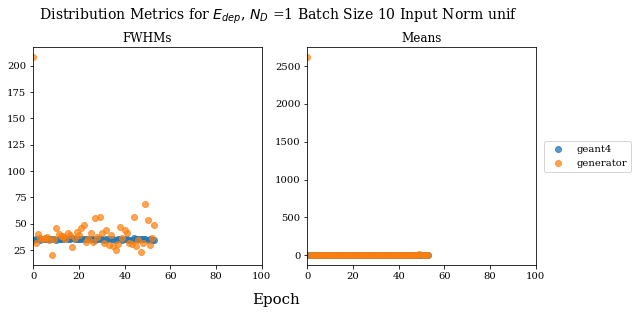

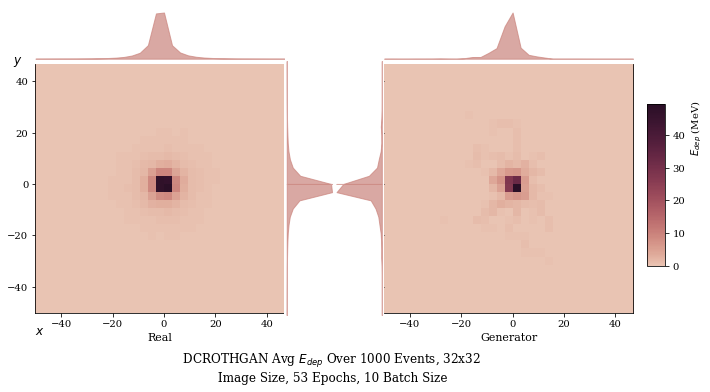

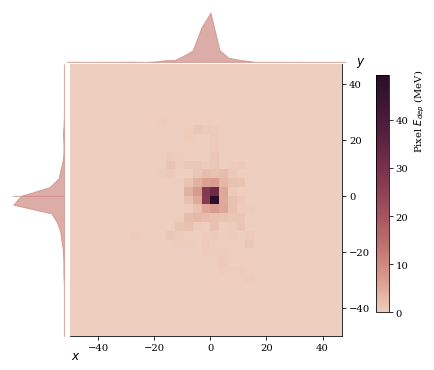

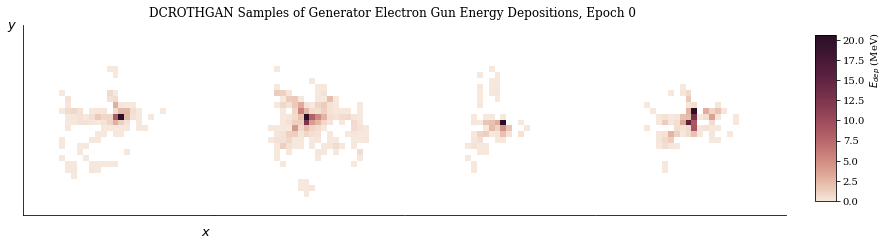

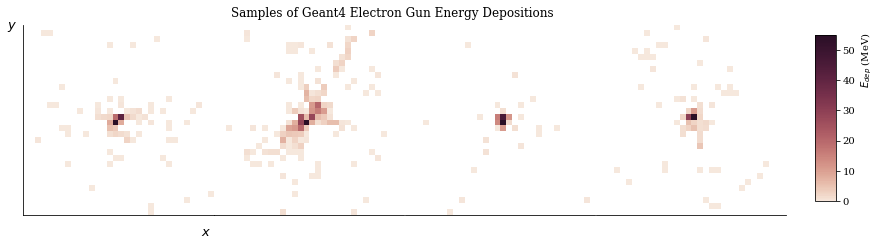

[53/100][0/3000] Loss_D: 0.0463 Loss_G: 3.7384 D(x): 0.9995 D(G(z)): 0.0446 / 0.0264
[53/100][100/3000] Loss_D: 0.0395 Loss_G: 3.3527 D(x): 0.9983 D(G(z)): 0.0364 / 0.0487
[53/100][200/3000] Loss_D: 0.0036 Loss_G: 6.9335 D(x): 0.9978 D(G(z)): 0.0014 / 0.0012
[53/100][300/3000] Loss_D: 0.1910 Loss_G: 3.0033 D(x): 0.9991 D(G(z)): 0.1676 / 0.0634
[53/100][400/3000] Loss_D: 0.0087 Loss_G: 5.1622 D(x): 0.9996 D(G(z)): 0.0083 / 0.0072
[53/100][500/3000] Loss_D: 0.0374 Loss_G: 3.4673 D(x): 0.9979 D(G(z)): 0.0346 / 0.0412
[53/100][600/3000] Loss_D: 0.0193 Loss_G: 4.4250 D(x): 0.9999 D(G(z)): 0.0190 / 0.0150
[53/100][700/3000] Loss_D: 0.1293 Loss_G: 2.9860 D(x): 0.9944 D(G(z)): 0.1149 / 0.0546
[53/100][800/3000] Loss_D: 0.0082 Loss_G: 5.4118 D(x): 0.9998 D(G(z)): 0.0080 / 0.0060
[53/100][900/3000] Loss_D: 0.0914 Loss_G: 5.3548 D(x): 0.9988 D(G(z)): 0.0841 / 0.0084
[53/100][1000/3000] Loss_D: 1.0369 Loss_G: 1.7630 D(x): 0.9995 D(G(z)): 0.6133 / 0.1947
[53/100][1100/3000] Loss_D: 0.0094 Loss_G: 4

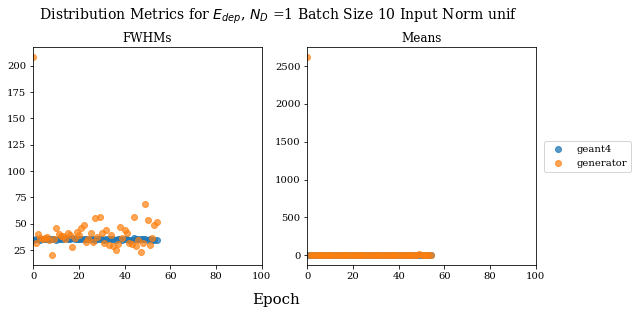

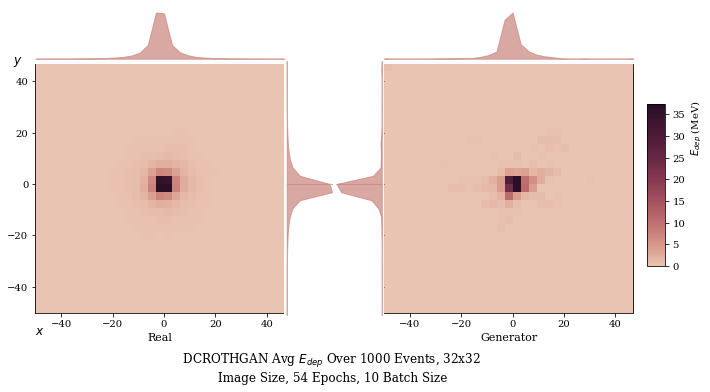

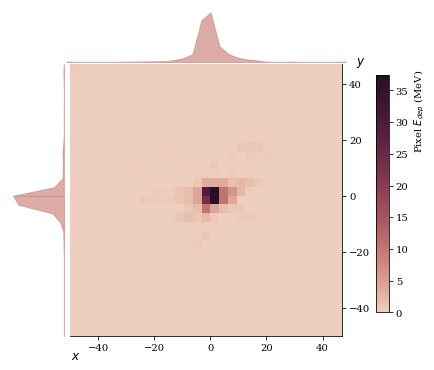

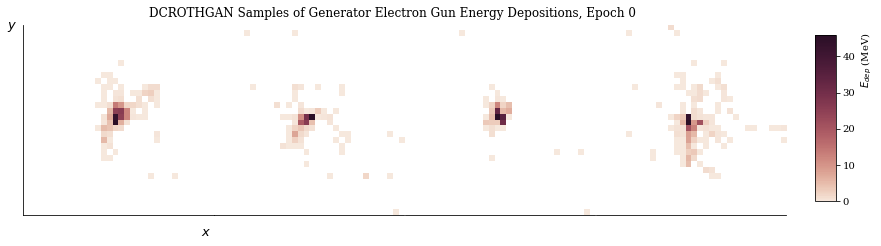

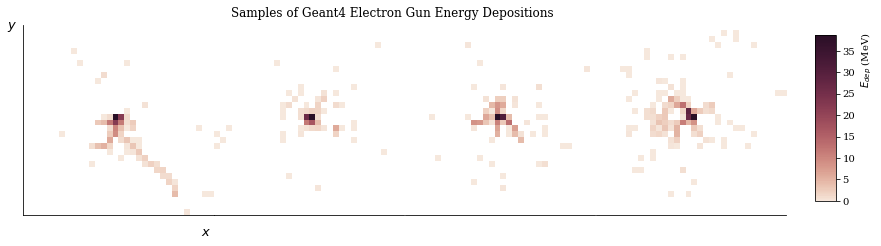

[54/100][0/3000] Loss_D: 0.5511 Loss_G: 1.6920 D(x): 0.6310 D(G(z)): 0.0211 / 0.2150
[54/100][100/3000] Loss_D: 2.3027 Loss_G: 1.6666 D(x): 1.0000 D(G(z)): 0.8848 / 0.2049
[54/100][200/3000] Loss_D: 0.0015 Loss_G: 7.5171 D(x): 0.9994 D(G(z)): 0.0009 / 0.0008
[54/100][300/3000] Loss_D: 0.0819 Loss_G: 3.0974 D(x): 0.9856 D(G(z)): 0.0648 / 0.0492
[54/100][400/3000] Loss_D: 0.0580 Loss_G: 4.2480 D(x): 0.9998 D(G(z)): 0.0547 / 0.0194
[54/100][500/3000] Loss_D: 0.0724 Loss_G: 3.4609 D(x): 0.9632 D(G(z)): 0.0331 / 0.0393
[54/100][600/3000] Loss_D: 0.5592 Loss_G: 2.9456 D(x): 0.9995 D(G(z)): 0.4047 / 0.0637
[54/100][700/3000] Loss_D: 0.0926 Loss_G: 2.7871 D(x): 0.9506 D(G(z)): 0.0380 / 0.0910
[54/100][800/3000] Loss_D: 0.0709 Loss_G: 3.0694 D(x): 0.9913 D(G(z)): 0.0599 / 0.0522
[54/100][900/3000] Loss_D: 0.1176 Loss_G: 3.3426 D(x): 0.9995 D(G(z)): 0.1080 / 0.0475
[54/100][1000/3000] Loss_D: 1.0459 Loss_G: 2.1579 D(x): 0.9999 D(G(z)): 0.5894 / 0.1459
[54/100][1100/3000] Loss_D: 1.5591 Loss_G: 2

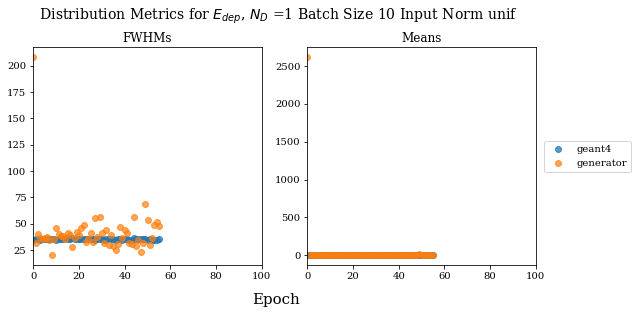

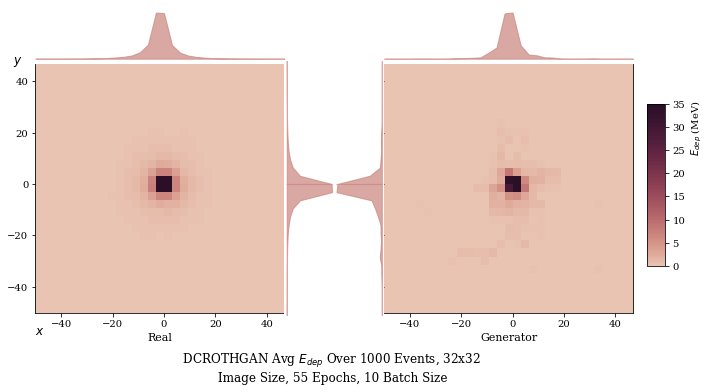

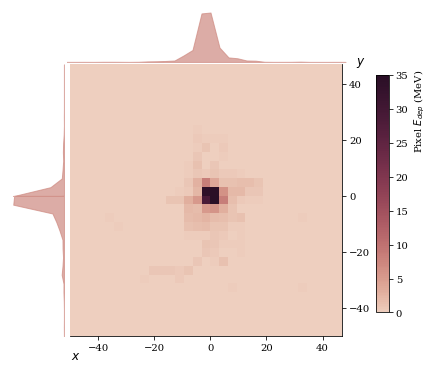

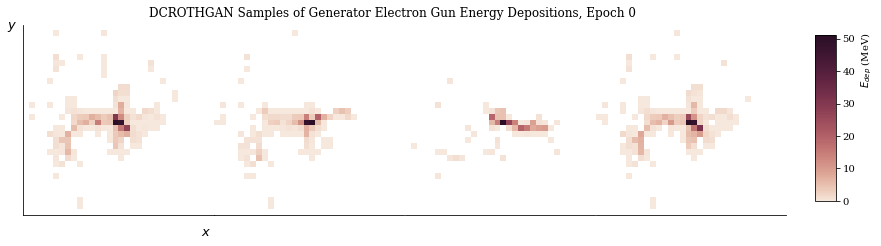

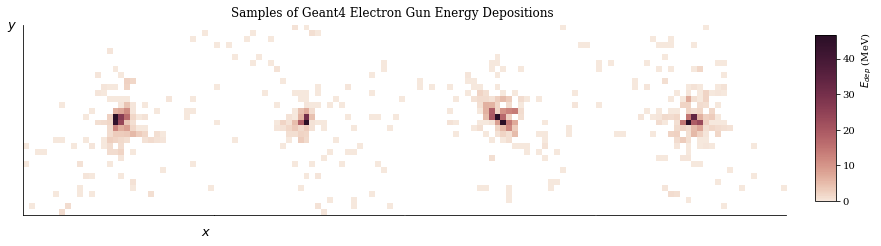

[55/100][0/3000] Loss_D: 0.0228 Loss_G: 5.3226 D(x): 0.9845 D(G(z)): 0.0070 / 0.0057
[55/100][100/3000] Loss_D: 0.0691 Loss_G: 3.2440 D(x): 0.9997 D(G(z)): 0.0646 / 0.0594
[55/100][200/3000] Loss_D: 0.0476 Loss_G: 4.3137 D(x): 0.9632 D(G(z)): 0.0079 / 0.0164
[55/100][300/3000] Loss_D: 0.2281 Loss_G: 2.7558 D(x): 0.9996 D(G(z)): 0.2022 / 0.0664
[55/100][400/3000] Loss_D: 0.0790 Loss_G: 3.1221 D(x): 0.9991 D(G(z)): 0.0744 / 0.0508
[55/100][500/3000] Loss_D: 0.0136 Loss_G: 5.3012 D(x): 0.9933 D(G(z)): 0.0068 / 0.0062
[55/100][600/3000] Loss_D: 0.0396 Loss_G: 3.8556 D(x): 0.9993 D(G(z)): 0.0379 / 0.0230
[55/100][700/3000] Loss_D: 0.1073 Loss_G: 3.3251 D(x): 0.9851 D(G(z)): 0.0877 / 0.0381
[55/100][800/3000] Loss_D: 0.0388 Loss_G: 4.7234 D(x): 0.9697 D(G(z)): 0.0073 / 0.0106
[55/100][900/3000] Loss_D: 0.1282 Loss_G: 4.2969 D(x): 0.9999 D(G(z)): 0.1167 / 0.0177
[55/100][1000/3000] Loss_D: 0.0508 Loss_G: 3.8100 D(x): 0.9907 D(G(z)): 0.0401 / 0.0277
[55/100][1100/3000] Loss_D: 0.3545 Loss_G: 2

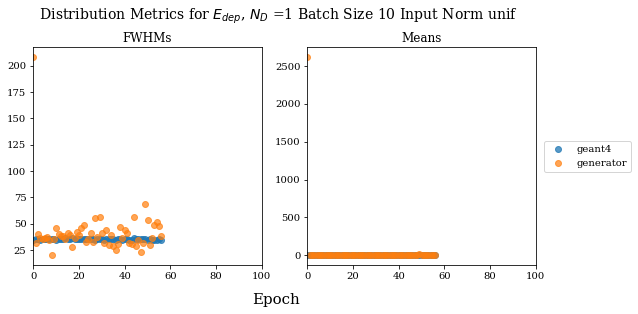

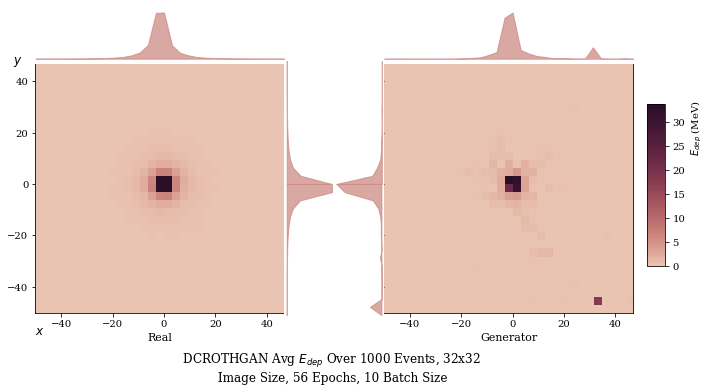

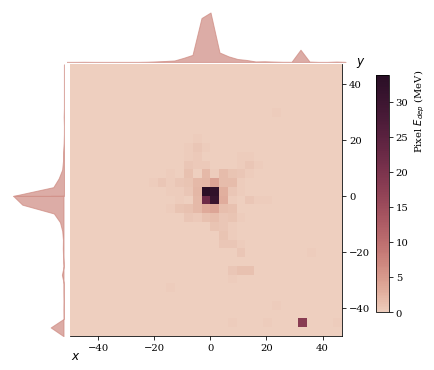

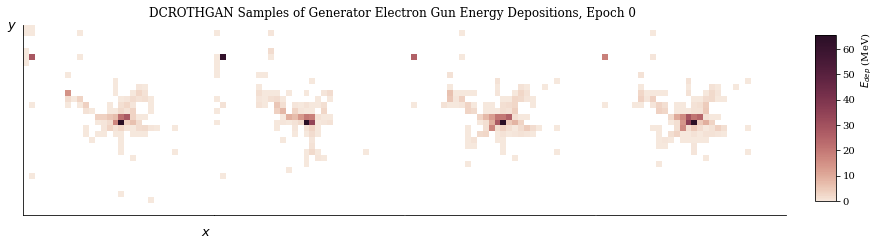

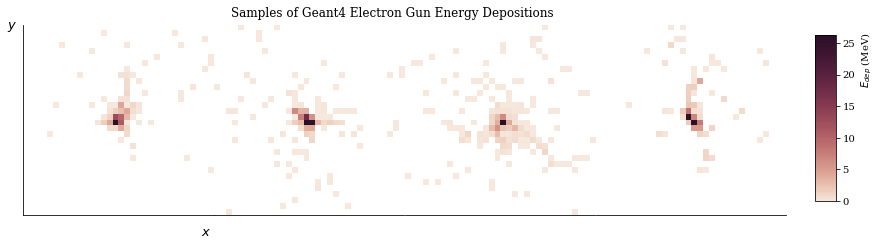

[56/100][0/3000] Loss_D: 0.3640 Loss_G: 2.4946 D(x): 0.9943 D(G(z)): 0.2926 / 0.0917
[56/100][100/3000] Loss_D: 0.0429 Loss_G: 3.6809 D(x): 0.9955 D(G(z)): 0.0373 / 0.0305
[56/100][200/3000] Loss_D: 0.0130 Loss_G: 6.6663 D(x): 0.9898 D(G(z)): 0.0027 / 0.0025
[56/100][300/3000] Loss_D: 0.2044 Loss_G: 1.1168 D(x): 0.8540 D(G(z)): 0.0340 / 0.3501
[56/100][400/3000] Loss_D: 0.0465 Loss_G: 3.7744 D(x): 0.9952 D(G(z)): 0.0406 / 0.0276
[56/100][500/3000] Loss_D: 0.2601 Loss_G: 1.4662 D(x): 0.9660 D(G(z)): 0.1973 / 0.2516
[56/100][600/3000] Loss_D: 0.7518 Loss_G: 2.5349 D(x): 0.9993 D(G(z)): 0.5015 / 0.0990
[56/100][700/3000] Loss_D: 0.0368 Loss_G: 4.3731 D(x): 0.9969 D(G(z)): 0.0327 / 0.0247
[56/100][800/3000] Loss_D: 0.0509 Loss_G: 4.4294 D(x): 0.9974 D(G(z)): 0.0447 / 0.0224
[56/100][900/3000] Loss_D: 1.4919 Loss_G: 1.5076 D(x): 0.9846 D(G(z)): 0.7180 / 0.2710
[56/100][1000/3000] Loss_D: 0.1147 Loss_G: 3.3920 D(x): 0.9998 D(G(z)): 0.1063 / 0.0421
[56/100][1100/3000] Loss_D: 1.8672 Loss_G: 0

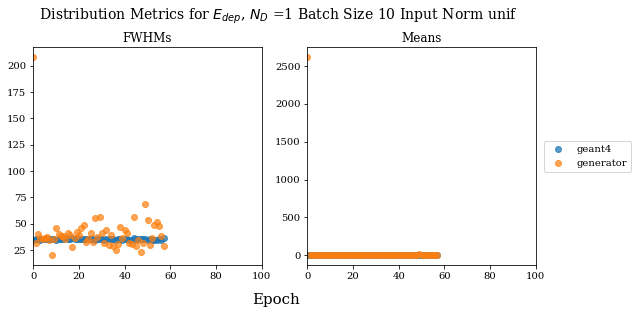

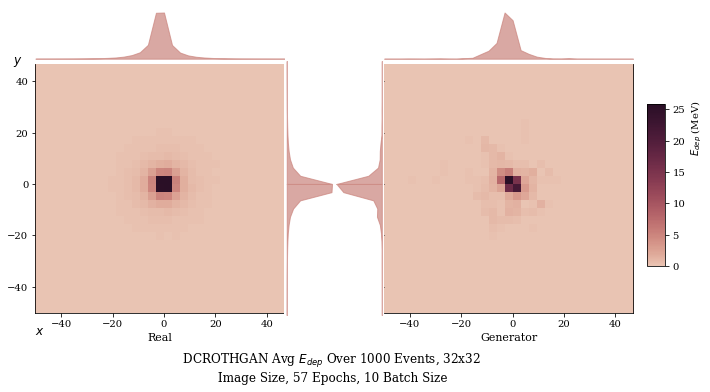

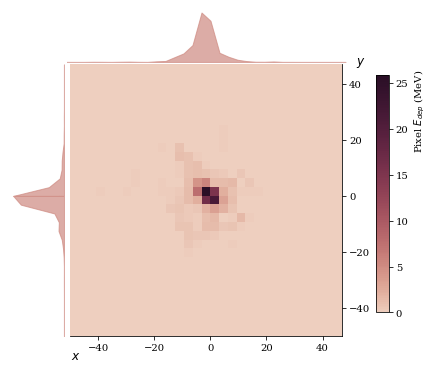

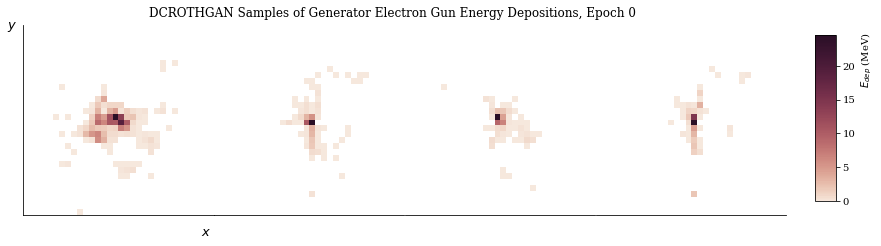

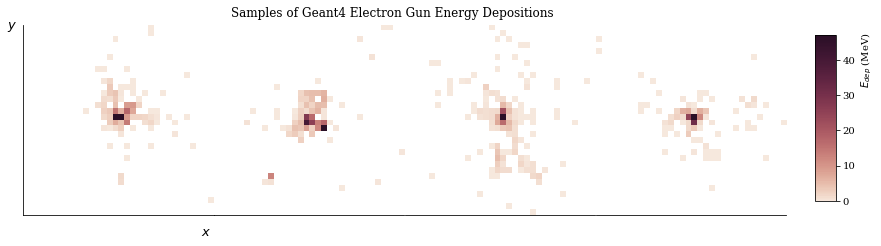

[57/100][0/3000] Loss_D: 0.0368 Loss_G: 4.1906 D(x): 0.9934 D(G(z)): 0.0296 / 0.0184
[57/100][100/3000] Loss_D: 0.2718 Loss_G: 2.2793 D(x): 0.9967 D(G(z)): 0.2133 / 0.1327
[57/100][200/3000] Loss_D: 0.1242 Loss_G: 1.6388 D(x): 0.9114 D(G(z)): 0.0247 / 0.2323
[57/100][300/3000] Loss_D: 0.0486 Loss_G: 3.8027 D(x): 0.9992 D(G(z)): 0.0465 / 0.0230
[57/100][400/3000] Loss_D: 0.0334 Loss_G: 4.5679 D(x): 0.9859 D(G(z)): 0.0189 / 0.0167
[57/100][500/3000] Loss_D: 0.4422 Loss_G: 2.2679 D(x): 0.9851 D(G(z)): 0.3339 / 0.1183
[57/100][600/3000] Loss_D: 0.0175 Loss_G: 4.6263 D(x): 0.9980 D(G(z)): 0.0154 / 0.0111
[57/100][700/3000] Loss_D: 0.0629 Loss_G: 3.1527 D(x): 0.9972 D(G(z)): 0.0582 / 0.0448
[57/100][800/3000] Loss_D: 0.3541 Loss_G: 0.8033 D(x): 0.9998 D(G(z)): 0.2836 / 0.4900
[57/100][900/3000] Loss_D: 0.0144 Loss_G: 6.3326 D(x): 0.9894 D(G(z)): 0.0037 / 0.0042
[57/100][1000/3000] Loss_D: 0.0284 Loss_G: 4.0168 D(x): 0.9939 D(G(z)): 0.0219 / 0.0208
[57/100][1100/3000] Loss_D: 1.2848 Loss_G: 1

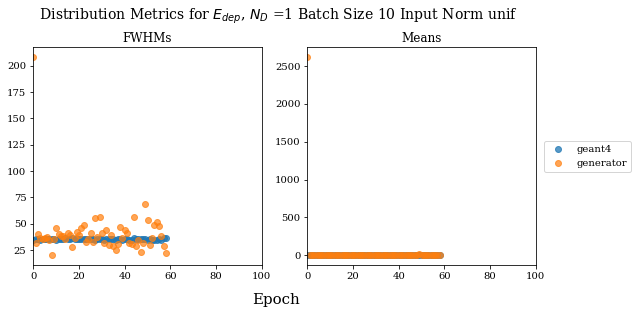

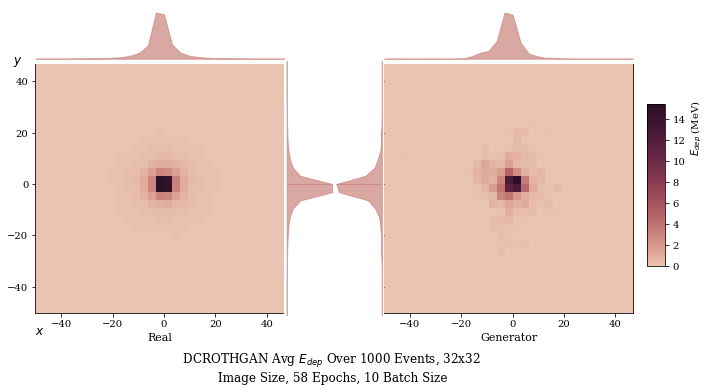

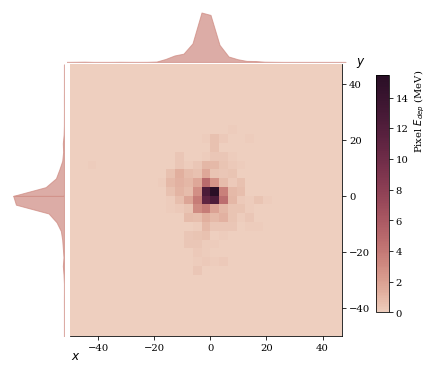

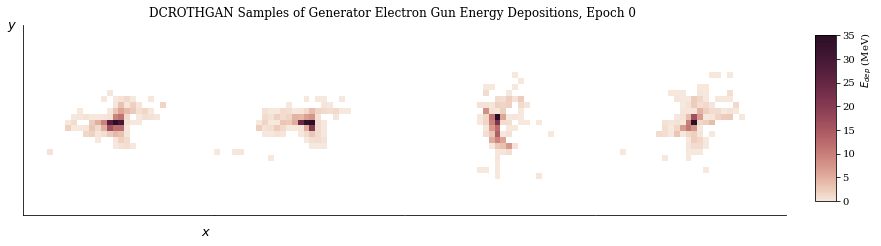

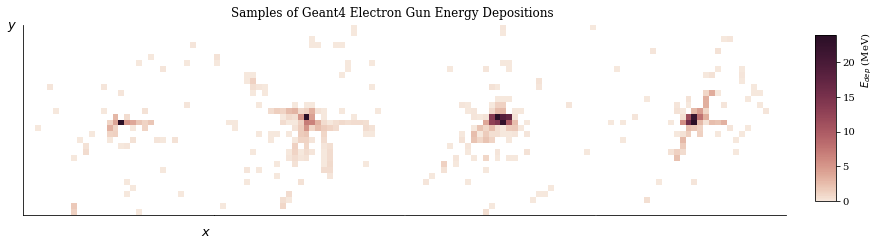

[58/100][0/3000] Loss_D: 0.0178 Loss_G: 5.5978 D(x): 0.9881 D(G(z)): 0.0057 / 0.0051
[58/100][100/3000] Loss_D: 0.0434 Loss_G: 3.8621 D(x): 0.9983 D(G(z)): 0.0404 / 0.0287
[58/100][200/3000] Loss_D: 0.1373 Loss_G: 3.0820 D(x): 0.9981 D(G(z)): 0.1206 / 0.0626
[58/100][300/3000] Loss_D: 0.1194 Loss_G: 3.2365 D(x): 0.9818 D(G(z)): 0.0943 / 0.0494
[58/100][400/3000] Loss_D: 0.0301 Loss_G: 4.5782 D(x): 0.9979 D(G(z)): 0.0273 / 0.0177
[58/100][500/3000] Loss_D: 0.1168 Loss_G: 4.0593 D(x): 0.8961 D(G(z)): 0.0011 / 0.0282
[58/100][600/3000] Loss_D: 0.0245 Loss_G: 10.2627 D(x): 0.9762 D(G(z)): 0.0000 / 0.0000
[58/100][700/3000] Loss_D: 0.0395 Loss_G: 4.4248 D(x): 0.9994 D(G(z)): 0.0378 / 0.0180
[58/100][800/3000] Loss_D: 0.4379 Loss_G: 2.1629 D(x): 0.9994 D(G(z)): 0.3363 / 0.1381
[58/100][900/3000] Loss_D: 0.0341 Loss_G: 4.2355 D(x): 0.9981 D(G(z)): 0.0312 / 0.0197
[58/100][1000/3000] Loss_D: 0.0476 Loss_G: 2.9632 D(x): 0.9997 D(G(z)): 0.0458 / 0.0611
[58/100][1100/3000] Loss_D: 0.0199 Loss_G: 

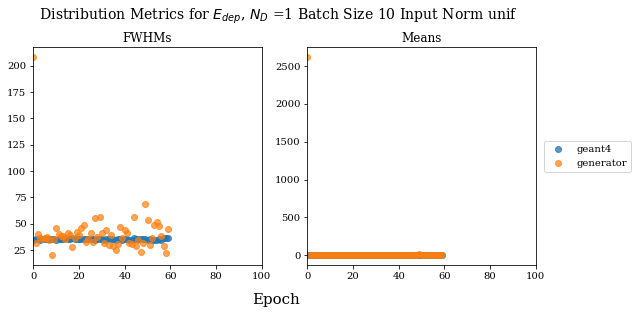

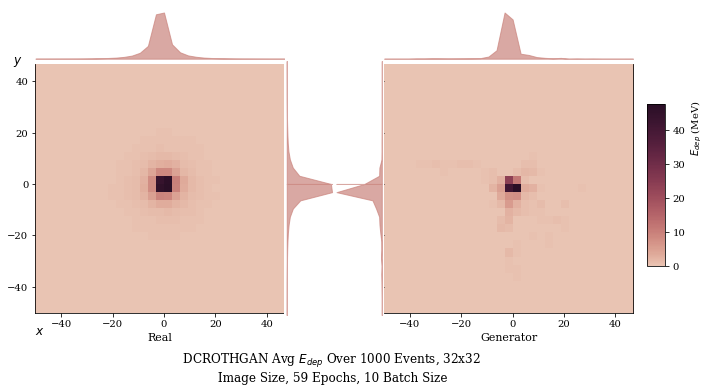

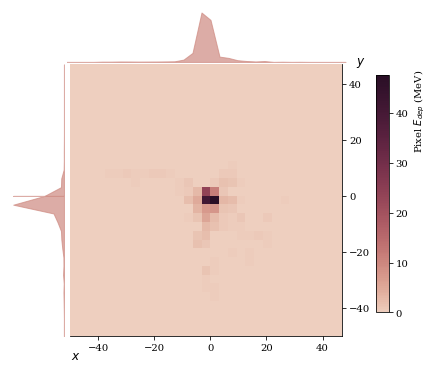

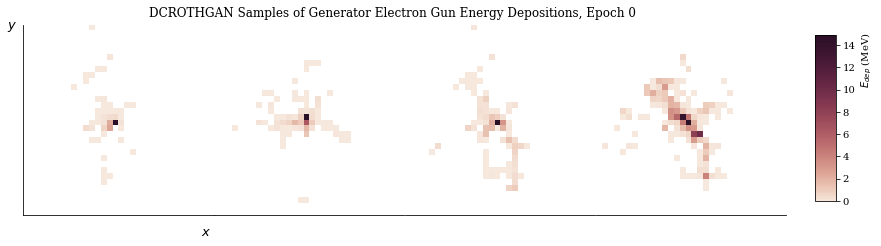

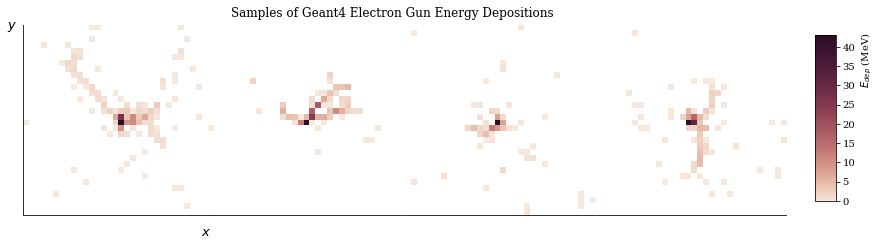

[59/100][0/3000] Loss_D: 0.0089 Loss_G: 5.1355 D(x): 0.9999 D(G(z)): 0.0087 / 0.0074
[59/100][100/3000] Loss_D: 0.0644 Loss_G: 3.6282 D(x): 0.9990 D(G(z)): 0.0604 / 0.0363
[59/100][200/3000] Loss_D: 0.3040 Loss_G: 2.3756 D(x): 0.9975 D(G(z)): 0.2562 / 0.0986
[59/100][300/3000] Loss_D: 0.0749 Loss_G: 3.5693 D(x): 0.9989 D(G(z)): 0.0696 / 0.0386
[59/100][400/3000] Loss_D: 0.0629 Loss_G: 8.6779 D(x): 0.9414 D(G(z)): 0.0001 / 0.0003
[59/100][500/3000] Loss_D: 0.3108 Loss_G: 2.3364 D(x): 0.9862 D(G(z)): 0.2529 / 0.1020
[59/100][600/3000] Loss_D: 0.0682 Loss_G: 3.3111 D(x): 0.9992 D(G(z)): 0.0647 / 0.0420
[59/100][700/3000] Loss_D: 0.0178 Loss_G: 4.8339 D(x): 0.9993 D(G(z)): 0.0169 / 0.0087
[59/100][800/3000] Loss_D: 0.0492 Loss_G: 4.1265 D(x): 0.9974 D(G(z)): 0.0450 / 0.0233
[59/100][900/3000] Loss_D: 0.0801 Loss_G: 3.7138 D(x): 0.9999 D(G(z)): 0.0740 / 0.0358
[59/100][1000/3000] Loss_D: 0.0160 Loss_G: 5.5419 D(x): 0.9998 D(G(z)): 0.0157 / 0.0041
[59/100][1100/3000] Loss_D: 0.0033 Loss_G: 7

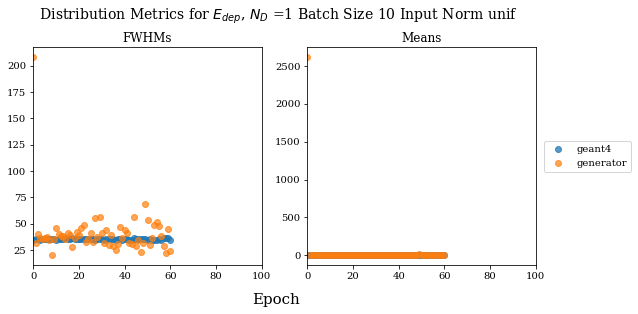

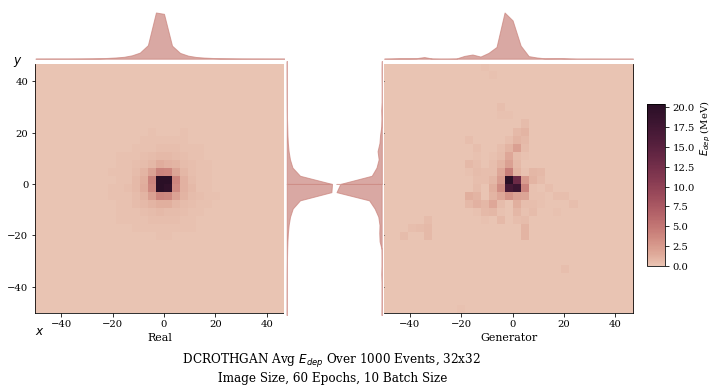

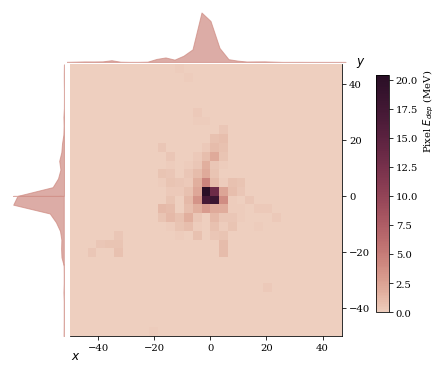

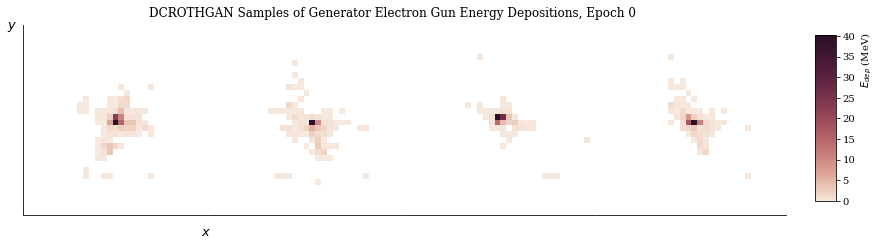

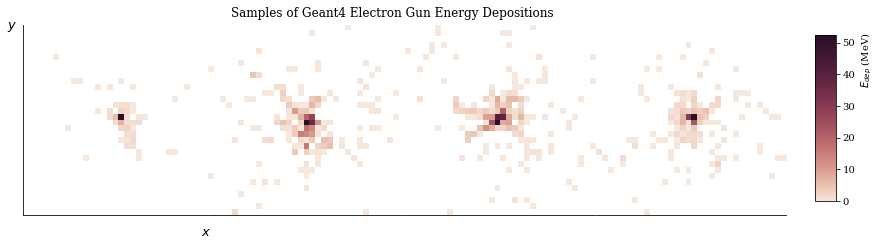

[60/100][0/3000] Loss_D: 0.0346 Loss_G: 4.0183 D(x): 0.9998 D(G(z)): 0.0336 / 0.0238
[60/100][100/3000] Loss_D: 0.0268 Loss_G: 4.9472 D(x): 0.9818 D(G(z)): 0.0077 / 0.0096
[60/100][200/3000] Loss_D: 0.0096 Loss_G: 5.0615 D(x): 0.9998 D(G(z)): 0.0093 / 0.0079
[60/100][300/3000] Loss_D: 0.0256 Loss_G: 4.3387 D(x): 0.9996 D(G(z)): 0.0247 / 0.0203
[60/100][400/3000] Loss_D: 0.1238 Loss_G: 3.0758 D(x): 0.9971 D(G(z)): 0.1129 / 0.0489
[60/100][500/3000] Loss_D: 0.0020 Loss_G: 8.1277 D(x): 0.9984 D(G(z)): 0.0004 / 0.0004
[60/100][600/3000] Loss_D: 0.0386 Loss_G: 3.8999 D(x): 0.9993 D(G(z)): 0.0371 / 0.0244
[60/100][700/3000] Loss_D: 0.0052 Loss_G: 6.1359 D(x): 0.9987 D(G(z)): 0.0039 / 0.0036
[60/100][800/3000] Loss_D: 0.3255 Loss_G: 2.6606 D(x): 0.9968 D(G(z)): 0.2558 / 0.0905
[60/100][900/3000] Loss_D: 0.1377 Loss_G: 2.2934 D(x): 0.9779 D(G(z)): 0.1080 / 0.1117
[60/100][1000/3000] Loss_D: 0.0575 Loss_G: 2.6155 D(x): 0.9983 D(G(z)): 0.0537 / 0.0877
[60/100][1100/3000] Loss_D: 0.0299 Loss_G: 4

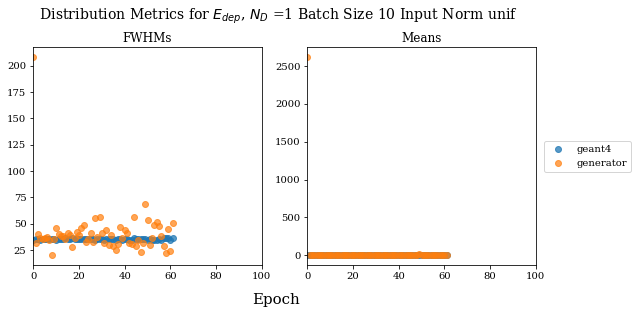

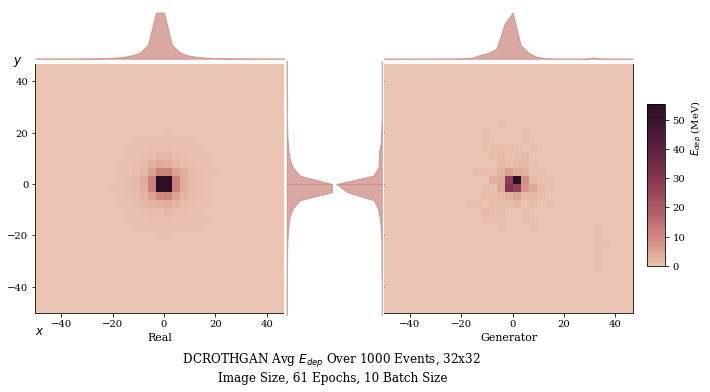

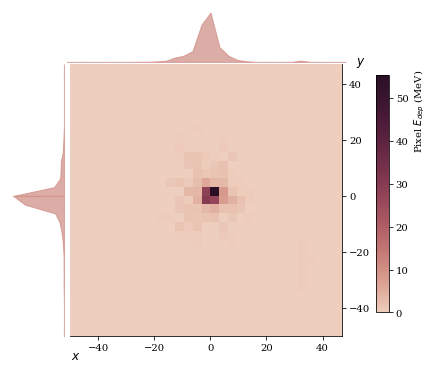

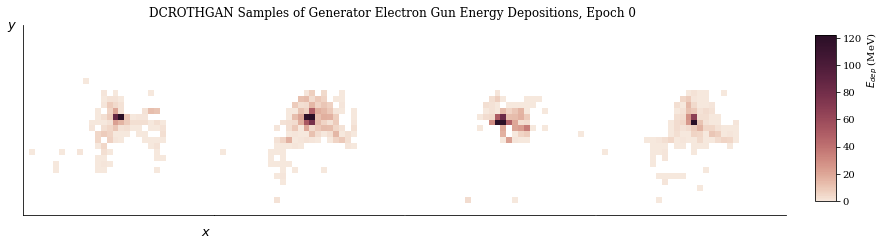

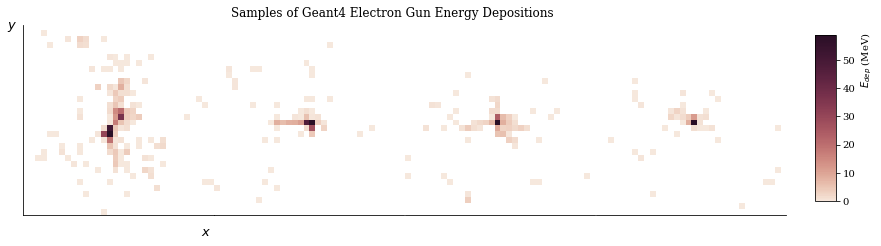

[61/100][0/3000] Loss_D: 0.1475 Loss_G: 2.8276 D(x): 0.9982 D(G(z)): 0.1342 / 0.0634
[61/100][100/3000] Loss_D: 1.6107 Loss_G: 0.7632 D(x): 0.9999 D(G(z)): 0.7874 / 0.4795
[61/100][200/3000] Loss_D: 0.0622 Loss_G: 3.8639 D(x): 0.9571 D(G(z)): 0.0173 / 0.0316
[61/100][300/3000] Loss_D: 0.0248 Loss_G: 5.6646 D(x): 0.9868 D(G(z)): 0.0111 / 0.0043
[61/100][400/3000] Loss_D: 0.0875 Loss_G: 3.7352 D(x): 0.9989 D(G(z)): 0.0813 / 0.0355
[61/100][500/3000] Loss_D: 0.7054 Loss_G: 3.4591 D(x): 0.5634 D(G(z)): 0.0009 / 0.0434
[61/100][600/3000] Loss_D: 0.0455 Loss_G: 3.9030 D(x): 0.9752 D(G(z)): 0.0199 / 0.0238
[61/100][700/3000] Loss_D: 0.2315 Loss_G: 2.5696 D(x): 0.9897 D(G(z)): 0.1908 / 0.1050
[61/100][800/3000] Loss_D: 0.0057 Loss_G: 5.2719 D(x): 0.9998 D(G(z)): 0.0056 / 0.0055
[61/100][900/3000] Loss_D: 0.0947 Loss_G: 4.1188 D(x): 0.9380 D(G(z)): 0.0267 / 0.0393
[61/100][1000/3000] Loss_D: 0.3204 Loss_G: 0.7112 D(x): 0.9068 D(G(z)): 0.1882 / 0.5323
[61/100][1100/3000] Loss_D: 0.0291 Loss_G: 4

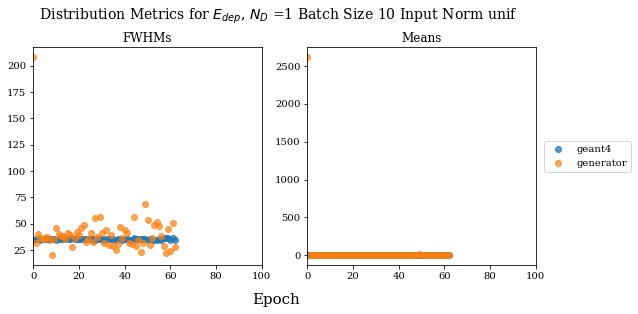

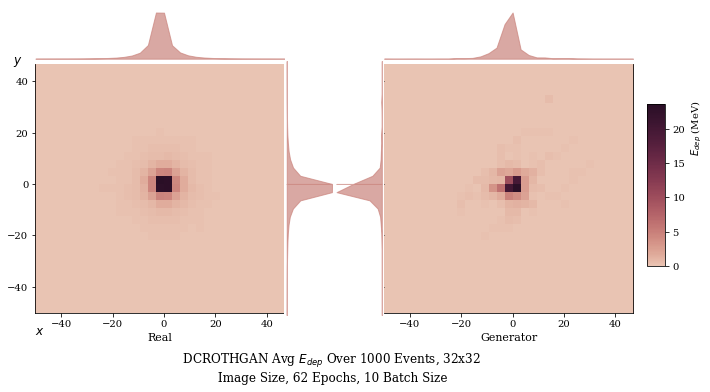

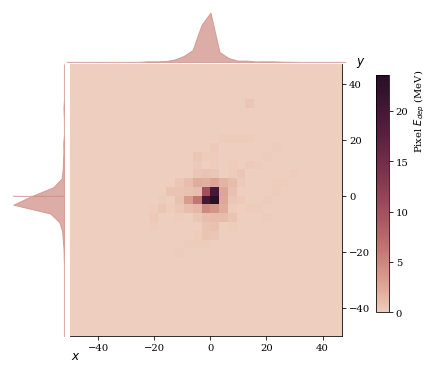

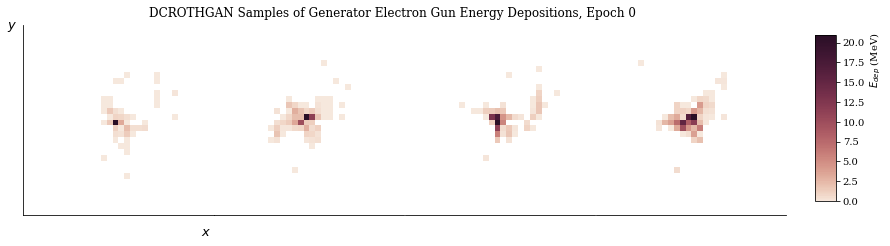

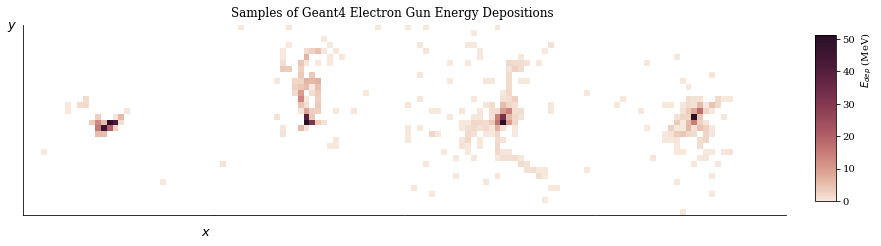

[62/100][0/3000] Loss_D: 0.0042 Loss_G: 6.2392 D(x): 0.9981 D(G(z)): 0.0024 / 0.0021
[62/100][100/3000] Loss_D: 0.0275 Loss_G: 3.9651 D(x): 0.9991 D(G(z)): 0.0261 / 0.0222
[62/100][200/3000] Loss_D: 0.0178 Loss_G: 4.4991 D(x): 0.9988 D(G(z)): 0.0165 / 0.0141
[62/100][300/3000] Loss_D: 0.1204 Loss_G: 3.6606 D(x): 0.9988 D(G(z)): 0.1066 / 0.0455
[62/100][400/3000] Loss_D: 0.0308 Loss_G: 4.6648 D(x): 0.9993 D(G(z)): 0.0295 / 0.0117
[62/100][500/3000] Loss_D: 0.0040 Loss_G: 6.6799 D(x): 0.9981 D(G(z)): 0.0022 / 0.0018
[62/100][600/3000] Loss_D: 0.0179 Loss_G: 4.0962 D(x): 0.9998 D(G(z)): 0.0175 / 0.0194
[62/100][700/3000] Loss_D: 0.1142 Loss_G: 3.5522 D(x): 0.9868 D(G(z)): 0.0936 / 0.0393
[62/100][800/3000] Loss_D: 0.7054 Loss_G: 1.7070 D(x): 0.9995 D(G(z)): 0.4446 / 0.2363
[62/100][900/3000] Loss_D: 0.0152 Loss_G: 5.9201 D(x): 0.9949 D(G(z)): 0.0100 / 0.0053
[62/100][1000/3000] Loss_D: 1.4307 Loss_G: 1.5100 D(x): 0.9893 D(G(z)): 0.7106 / 0.2650
[62/100][1100/3000] Loss_D: 0.3147 Loss_G: 1

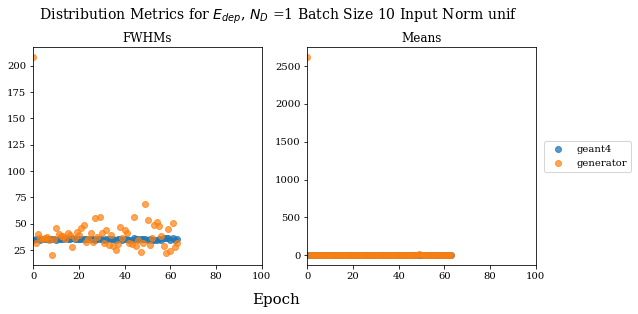

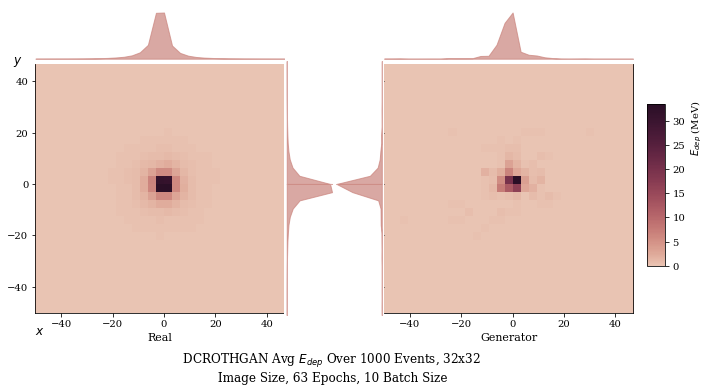

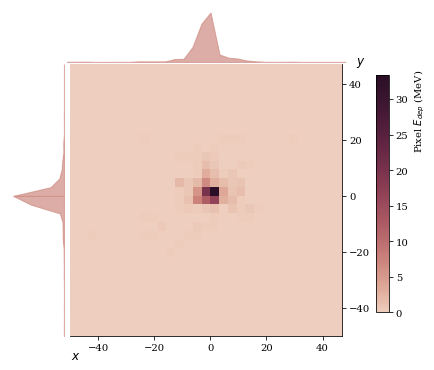

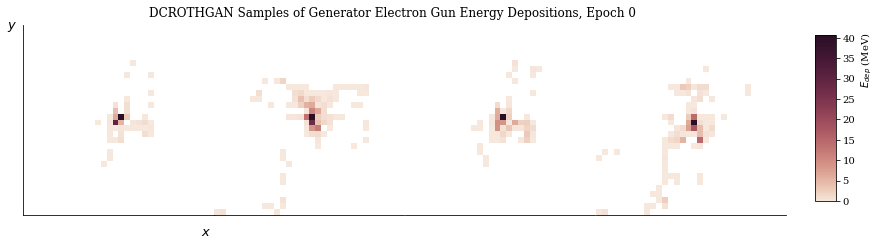

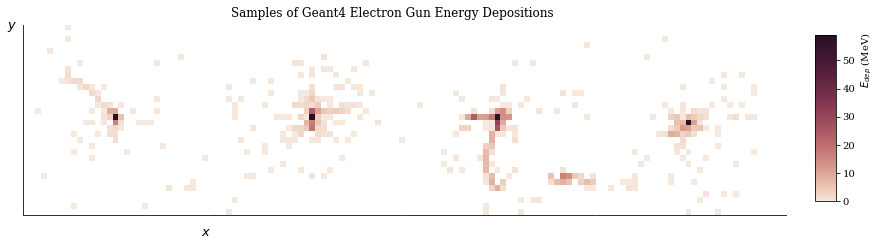

[63/100][0/3000] Loss_D: 0.4408 Loss_G: 2.7564 D(x): 0.9995 D(G(z)): 0.3439 / 0.0717
[63/100][100/3000] Loss_D: 0.9850 Loss_G: 0.8630 D(x): 0.9995 D(G(z)): 0.5956 / 0.4532
[63/100][200/3000] Loss_D: 0.3148 Loss_G: 1.1986 D(x): 0.8825 D(G(z)): 0.1537 / 0.3319
[63/100][300/3000] Loss_D: 0.0098 Loss_G: 4.8938 D(x): 0.9985 D(G(z)): 0.0082 / 0.0078
[63/100][400/3000] Loss_D: 0.1037 Loss_G: 3.1772 D(x): 0.9776 D(G(z)): 0.0755 / 0.0593
[63/100][500/3000] Loss_D: 0.1559 Loss_G: 1.7202 D(x): 0.9435 D(G(z)): 0.0901 / 0.2068
[63/100][600/3000] Loss_D: 0.1011 Loss_G: 2.8492 D(x): 0.9911 D(G(z)): 0.0877 / 0.0612
[63/100][700/3000] Loss_D: 0.0637 Loss_G: 5.1993 D(x): 0.9423 D(G(z)): 0.0021 / 0.0060
[63/100][800/3000] Loss_D: 0.0783 Loss_G: 3.6921 D(x): 0.9998 D(G(z)): 0.0722 / 0.0328
[63/100][900/3000] Loss_D: 0.1679 Loss_G: 4.0123 D(x): 0.9999 D(G(z)): 0.1529 / 0.0195
[63/100][1000/3000] Loss_D: 0.4109 Loss_G: 1.4342 D(x): 0.9765 D(G(z)): 0.2854 / 0.3406
[63/100][1100/3000] Loss_D: 0.1388 Loss_G: 2

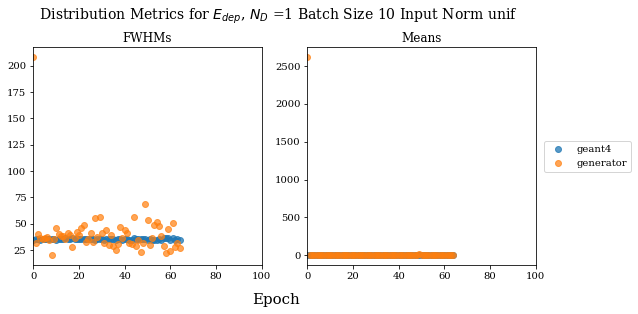

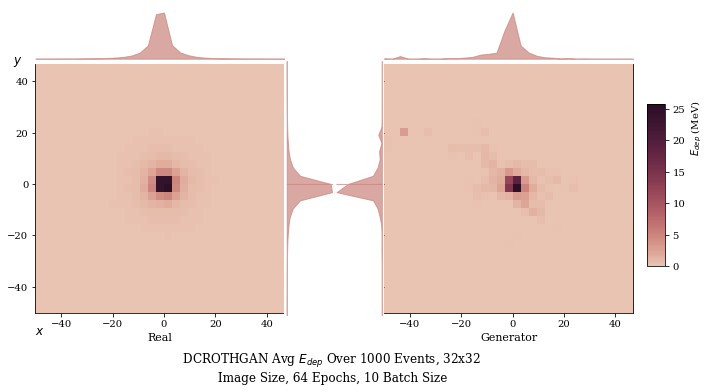

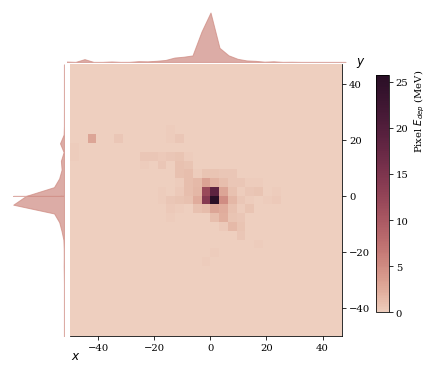

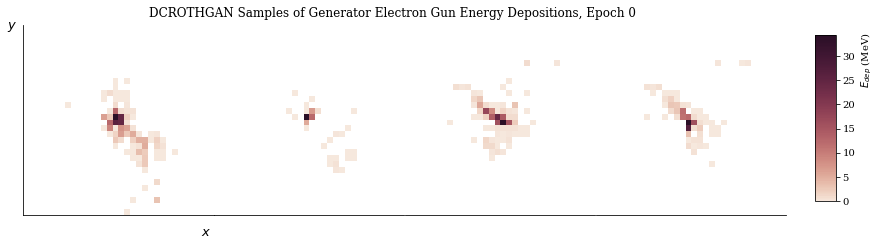

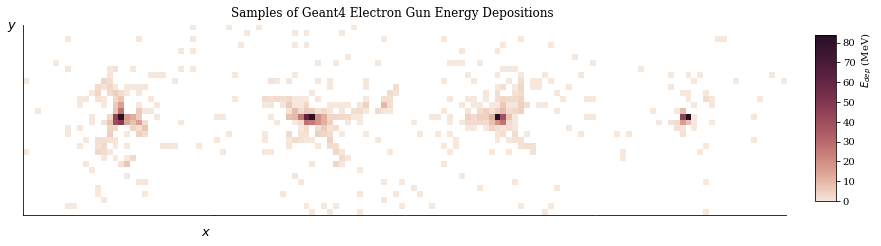

[64/100][0/3000] Loss_D: 0.0079 Loss_G: 5.1706 D(x): 0.9995 D(G(z)): 0.0073 / 0.0065
[64/100][100/3000] Loss_D: 1.4344 Loss_G: 1.0231 D(x): 0.9892 D(G(z)): 0.7284 / 0.3879
[64/100][200/3000] Loss_D: 0.0103 Loss_G: 5.2230 D(x): 0.9999 D(G(z)): 0.0101 / 0.0069
[64/100][300/3000] Loss_D: 0.0136 Loss_G: 5.4197 D(x): 0.9931 D(G(z)): 0.0066 / 0.0058
[64/100][400/3000] Loss_D: 0.1922 Loss_G: 2.7205 D(x): 0.9824 D(G(z)): 0.1525 / 0.1056
[64/100][500/3000] Loss_D: 0.0198 Loss_G: 4.7201 D(x): 0.9926 D(G(z)): 0.0122 / 0.0116
[64/100][600/3000] Loss_D: 0.0520 Loss_G: 3.8005 D(x): 0.9864 D(G(z)): 0.0372 / 0.0279
[64/100][700/3000] Loss_D: 0.1313 Loss_G: 3.0871 D(x): 0.9972 D(G(z)): 0.1173 / 0.0546
[64/100][800/3000] Loss_D: 0.4038 Loss_G: 8.3608 D(x): 0.7052 D(G(z)): 0.0001 / 0.0003
[64/100][900/3000] Loss_D: 0.4802 Loss_G: 0.3392 D(x): 0.8683 D(G(z)): 0.2592 / 0.7424
[64/100][1000/3000] Loss_D: 0.1233 Loss_G: 2.7459 D(x): 0.9996 D(G(z)): 0.1139 / 0.0773
[64/100][1100/3000] Loss_D: 3.2224 Loss_G: 0

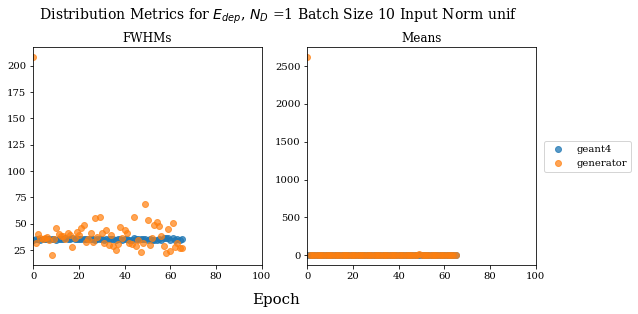

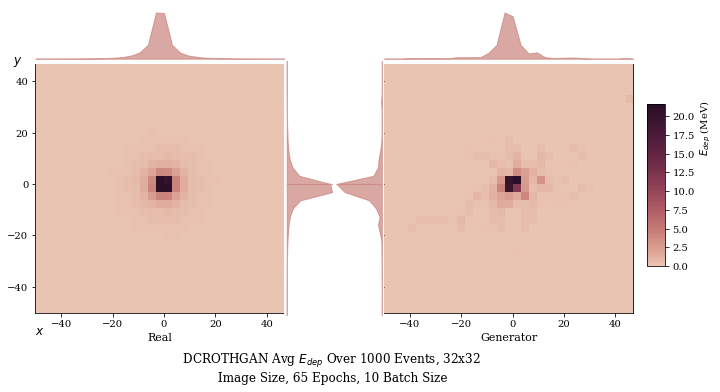

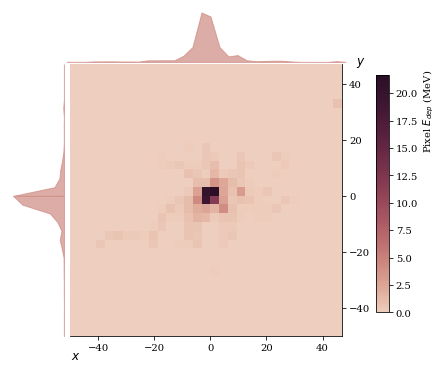

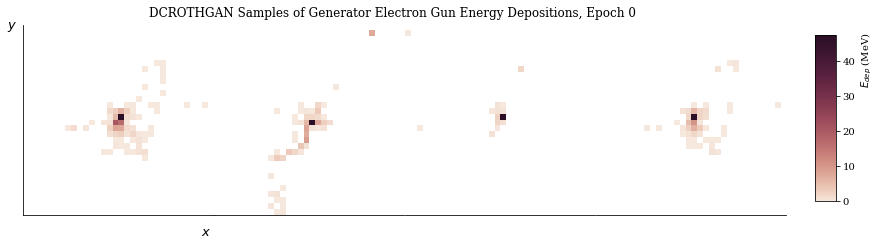

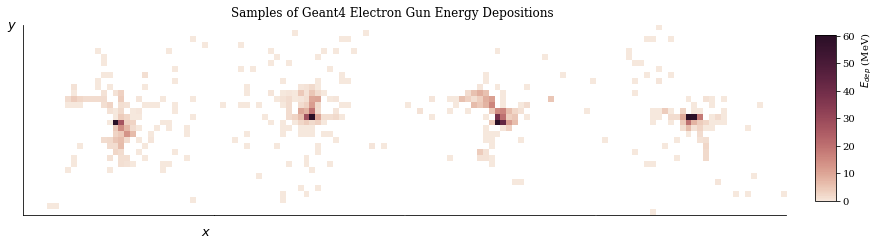

[65/100][0/3000] Loss_D: 0.2092 Loss_G: 2.9534 D(x): 0.9993 D(G(z)): 0.1662 / 0.0747
[65/100][100/3000] Loss_D: 0.0090 Loss_G: 4.9934 D(x): 0.9990 D(G(z)): 0.0080 / 0.0072
[65/100][200/3000] Loss_D: 0.0135 Loss_G: 4.6605 D(x): 0.9963 D(G(z)): 0.0097 / 0.0099
[65/100][300/3000] Loss_D: 0.2474 Loss_G: 2.7334 D(x): 1.0000 D(G(z)): 0.2176 / 0.0683
[65/100][400/3000] Loss_D: 0.0594 Loss_G: 3.5656 D(x): 0.9939 D(G(z)): 0.0510 / 0.0408
[65/100][500/3000] Loss_D: 1.3980 Loss_G: 1.9991 D(x): 1.0000 D(G(z)): 0.6902 / 0.1828
[65/100][600/3000] Loss_D: 0.1834 Loss_G: 3.1429 D(x): 1.0000 D(G(z)): 0.1633 / 0.0501
[65/100][700/3000] Loss_D: 0.2201 Loss_G: 3.2240 D(x): 0.9998 D(G(z)): 0.1959 / 0.0414
[65/100][800/3000] Loss_D: 0.0255 Loss_G: 4.0070 D(x): 0.9996 D(G(z)): 0.0247 / 0.0211
[65/100][900/3000] Loss_D: 0.0261 Loss_G: 5.0364 D(x): 0.9808 D(G(z)): 0.0062 / 0.0078
[65/100][1000/3000] Loss_D: 0.1709 Loss_G: 2.1851 D(x): 0.9957 D(G(z)): 0.1491 / 0.1293
[65/100][1100/3000] Loss_D: 0.0198 Loss_G: 3

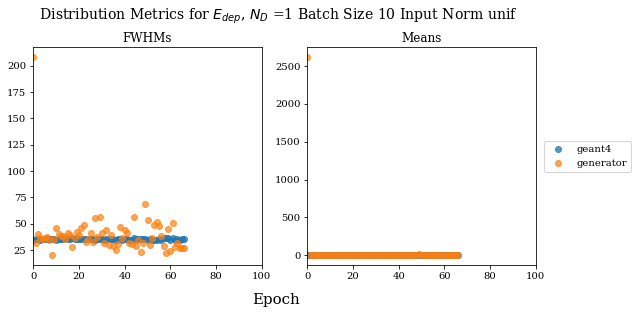

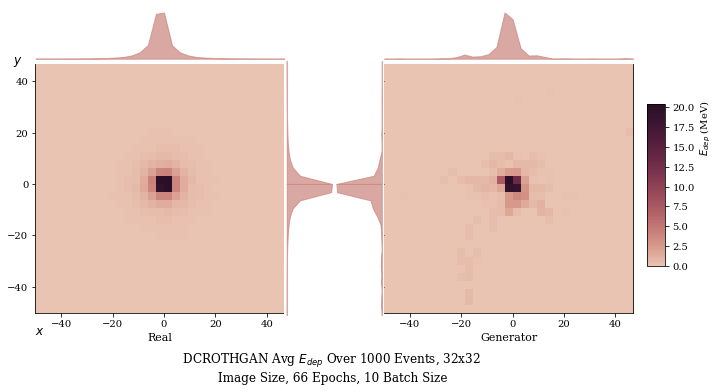

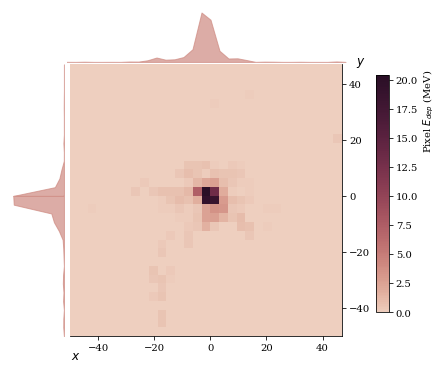

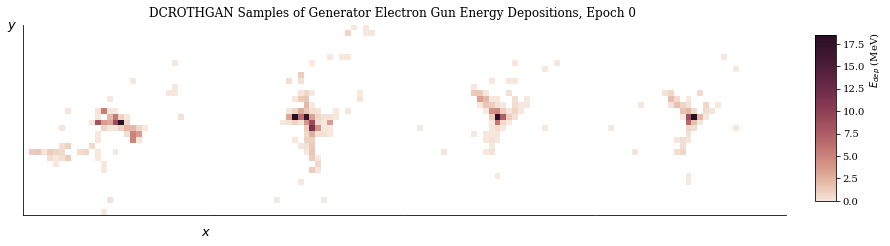

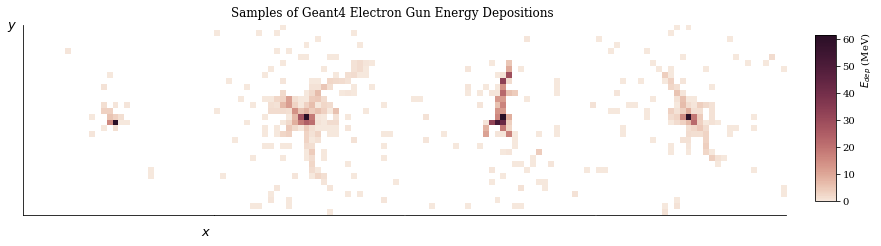

[66/100][0/3000] Loss_D: 0.0192 Loss_G: 6.4169 D(x): 0.9847 D(G(z)): 0.0037 / 0.0033
[66/100][100/3000] Loss_D: 0.0143 Loss_G: 4.7119 D(x): 0.9991 D(G(z)): 0.0133 / 0.0118
[66/100][200/3000] Loss_D: 0.0343 Loss_G: 4.1066 D(x): 0.9987 D(G(z)): 0.0320 / 0.0224
[66/100][300/3000] Loss_D: 0.0306 Loss_G: 4.8417 D(x): 0.9957 D(G(z)): 0.0257 / 0.0131
[66/100][400/3000] Loss_D: 0.1647 Loss_G: 2.5629 D(x): 0.9978 D(G(z)): 0.1465 / 0.0893
[66/100][500/3000] Loss_D: 0.4117 Loss_G: 1.7720 D(x): 0.9646 D(G(z)): 0.3013 / 0.1947
[66/100][600/3000] Loss_D: 0.0954 Loss_G: 2.7248 D(x): 0.9741 D(G(z)): 0.0661 / 0.0716
[66/100][700/3000] Loss_D: 0.0412 Loss_G: 4.7180 D(x): 0.9981 D(G(z)): 0.0381 / 0.0118
[66/100][800/3000] Loss_D: 0.0557 Loss_G: 3.2508 D(x): 0.9989 D(G(z)): 0.0524 / 0.0475
[66/100][900/3000] Loss_D: 0.1492 Loss_G: 3.0176 D(x): 0.9990 D(G(z)): 0.1354 / 0.0537
[66/100][1000/3000] Loss_D: 0.3990 Loss_G: 1.6980 D(x): 0.9601 D(G(z)): 0.2602 / 0.2633
[66/100][1100/3000] Loss_D: 0.0023 Loss_G: 8

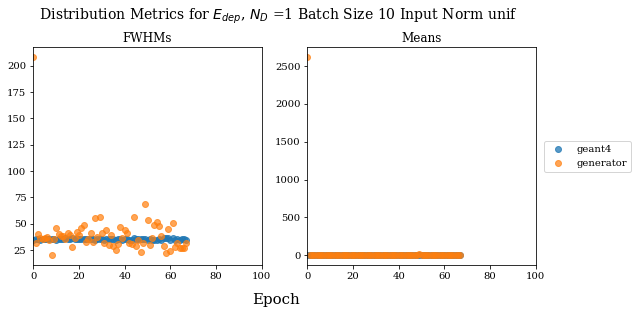

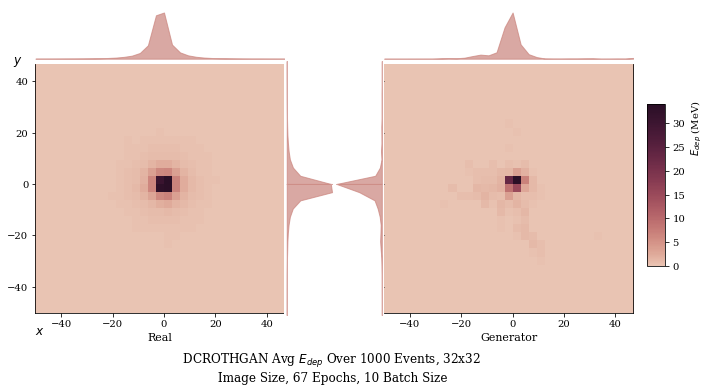

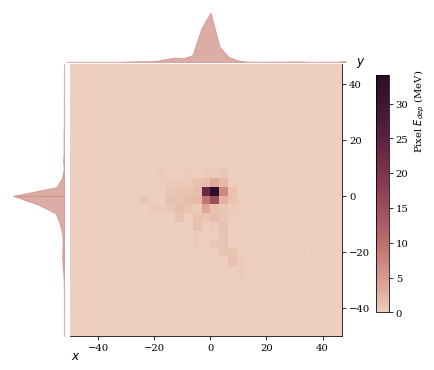

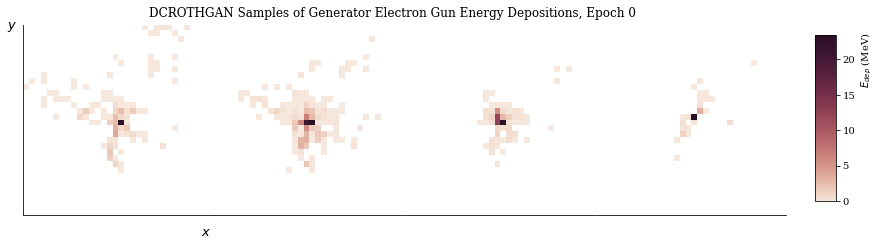

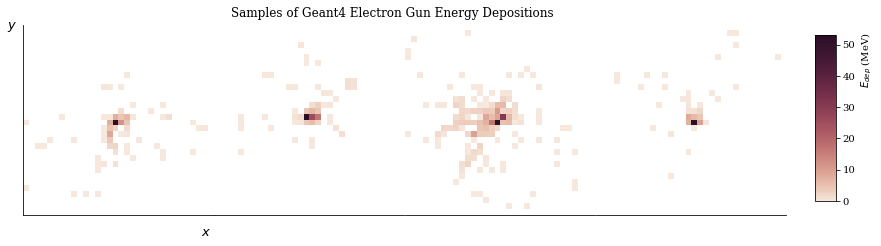

[67/100][0/3000] Loss_D: 0.1957 Loss_G: 3.0985 D(x): 0.9993 D(G(z)): 0.1492 / 0.0726
[67/100][100/3000] Loss_D: 0.0607 Loss_G: 3.6038 D(x): 0.9884 D(G(z)): 0.0472 / 0.0345
[67/100][200/3000] Loss_D: 0.3769 Loss_G: 0.9904 D(x): 0.7364 D(G(z)): 0.0299 / 0.4064
[67/100][300/3000] Loss_D: 0.1346 Loss_G: 3.3507 D(x): 0.9920 D(G(z)): 0.1143 / 0.0647
[67/100][400/3000] Loss_D: 0.0552 Loss_G: 5.5711 D(x): 0.9517 D(G(z)): 0.0054 / 0.0102
[67/100][500/3000] Loss_D: 0.1097 Loss_G: 2.7541 D(x): 0.9970 D(G(z)): 0.1005 / 0.0674
[67/100][600/3000] Loss_D: 0.0380 Loss_G: 3.7284 D(x): 0.9969 D(G(z)): 0.0341 / 0.0304
[67/100][700/3000] Loss_D: 0.0511 Loss_G: 3.7223 D(x): 0.9963 D(G(z)): 0.0461 / 0.0260
[67/100][800/3000] Loss_D: 0.0436 Loss_G: 3.1485 D(x): 0.9999 D(G(z)): 0.0423 / 0.0499
[67/100][900/3000] Loss_D: 0.2062 Loss_G: 2.5404 D(x): 0.9992 D(G(z)): 0.1816 / 0.0881
[67/100][1000/3000] Loss_D: 0.0759 Loss_G: 3.3877 D(x): 0.9997 D(G(z)): 0.0718 / 0.0410
[67/100][1100/3000] Loss_D: 0.0911 Loss_G: 3

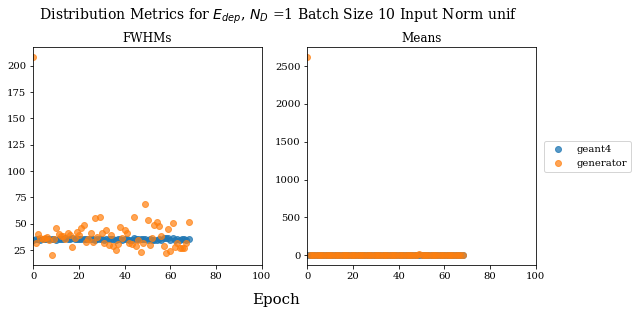

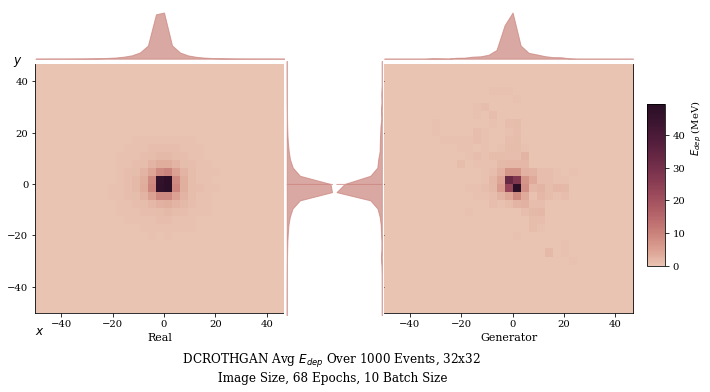

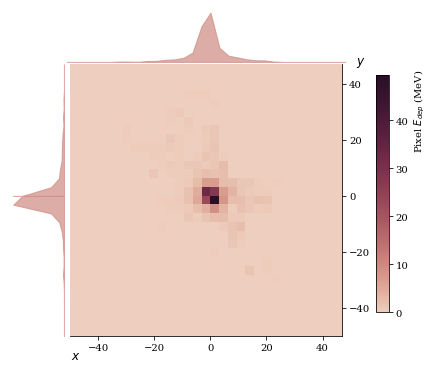

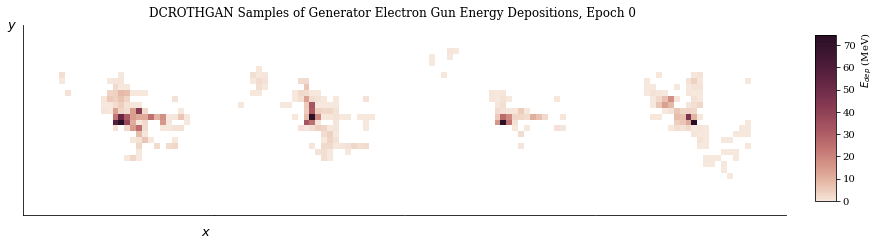

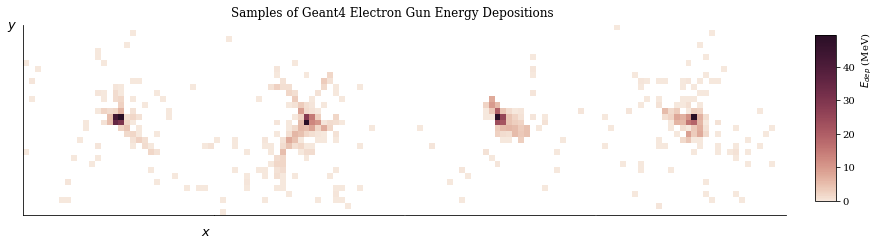

[68/100][0/3000] Loss_D: 0.0657 Loss_G: 4.6771 D(x): 0.9942 D(G(z)): 0.0559 / 0.0195
[68/100][100/3000] Loss_D: 0.1400 Loss_G: 2.8209 D(x): 0.9948 D(G(z)): 0.1219 / 0.0784
[68/100][200/3000] Loss_D: 0.0113 Loss_G: 6.6365 D(x): 0.9906 D(G(z)): 0.0018 / 0.0018
[68/100][300/3000] Loss_D: 0.0427 Loss_G: 4.0084 D(x): 0.9881 D(G(z)): 0.0302 / 0.0196
[68/100][400/3000] Loss_D: 0.1837 Loss_G: 1.4289 D(x): 0.9171 D(G(z)): 0.0874 / 0.2805
[68/100][500/3000] Loss_D: 0.0966 Loss_G: 2.6466 D(x): 0.9506 D(G(z)): 0.0403 / 0.0796
[68/100][600/3000] Loss_D: 0.0023 Loss_G: 6.7216 D(x): 1.0000 D(G(z)): 0.0023 / 0.0018
[68/100][700/3000] Loss_D: 0.2248 Loss_G: 2.2868 D(x): 1.0000 D(G(z)): 0.1980 / 0.1158
[68/100][800/3000] Loss_D: 0.0556 Loss_G: 3.7466 D(x): 0.9999 D(G(z)): 0.0530 / 0.0311
[68/100][900/3000] Loss_D: 0.1502 Loss_G: 3.1725 D(x): 0.9999 D(G(z)): 0.1340 / 0.0573
[68/100][1000/3000] Loss_D: 0.0066 Loss_G: 6.9642 D(x): 0.9953 D(G(z)): 0.0019 / 0.0014
[68/100][1100/3000] Loss_D: 1.6849 Loss_G: 0

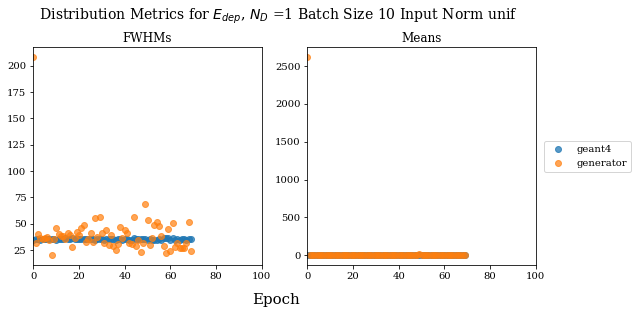

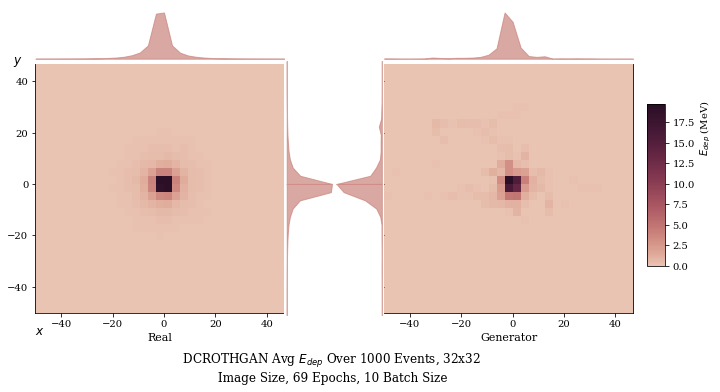

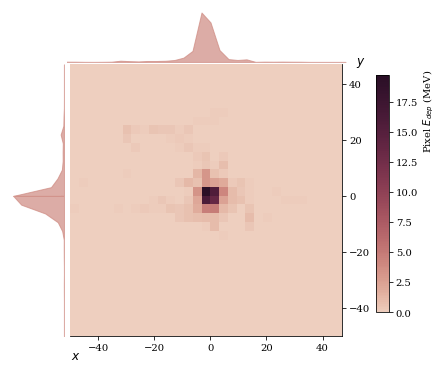

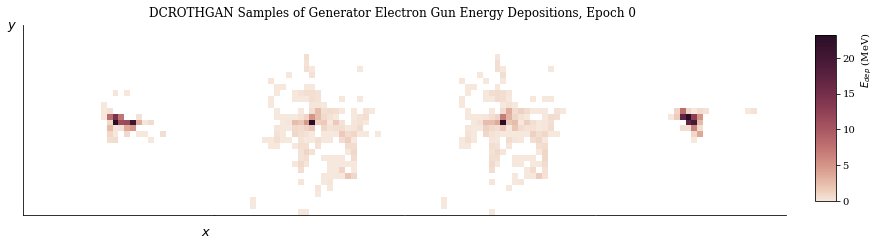

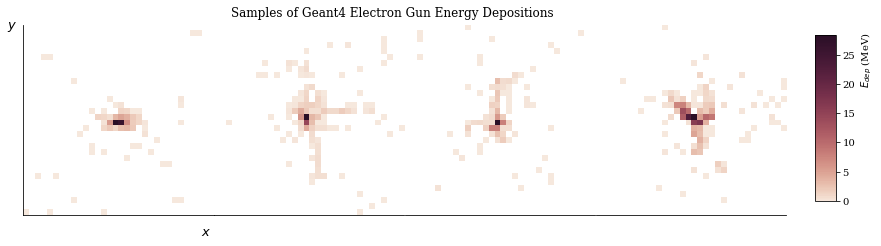

[69/100][0/3000] Loss_D: 0.0907 Loss_G: 3.2055 D(x): 0.9908 D(G(z)): 0.0776 / 0.0461
[69/100][100/3000] Loss_D: 0.1262 Loss_G: 2.9509 D(x): 0.9680 D(G(z)): 0.0885 / 0.0560
[69/100][200/3000] Loss_D: 0.0572 Loss_G: 3.6648 D(x): 0.9998 D(G(z)): 0.0532 / 0.0418
[69/100][300/3000] Loss_D: 0.2690 Loss_G: 0.5824 D(x): 0.8948 D(G(z)): 0.1403 / 0.5792
[69/100][400/3000] Loss_D: 0.0796 Loss_G: 4.3056 D(x): 0.9991 D(G(z)): 0.0740 / 0.0177
[69/100][500/3000] Loss_D: 0.2456 Loss_G: 0.2622 D(x): 0.8199 D(G(z)): 0.0233 / 0.7742
[69/100][600/3000] Loss_D: 0.0944 Loss_G: 2.9980 D(x): 0.9972 D(G(z)): 0.0870 / 0.0546
[69/100][700/3000] Loss_D: 0.0388 Loss_G: 3.7750 D(x): 0.9948 D(G(z)): 0.0328 / 0.0277
[69/100][800/3000] Loss_D: 0.0783 Loss_G: 3.0156 D(x): 0.9987 D(G(z)): 0.0734 / 0.0564
[69/100][900/3000] Loss_D: 0.0671 Loss_G: 3.6282 D(x): 0.9850 D(G(z)): 0.0504 / 0.0286
[69/100][1000/3000] Loss_D: 2.0753 Loss_G: 2.3892 D(x): 0.9999 D(G(z)): 0.8450 / 0.1121
[69/100][1100/3000] Loss_D: 0.0129 Loss_G: 4

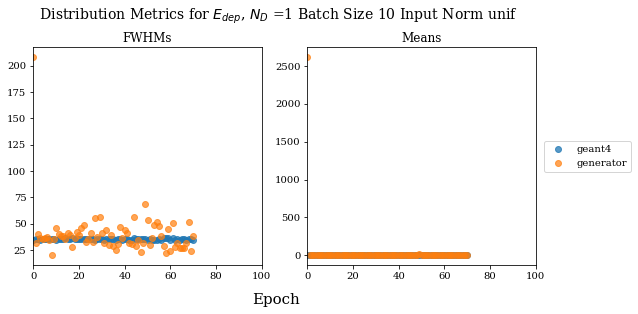

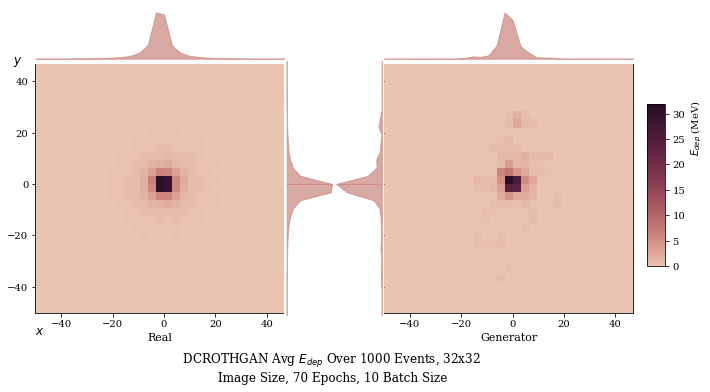

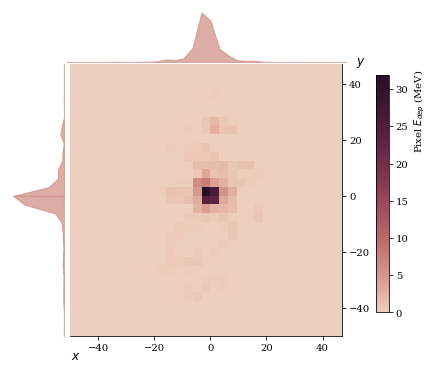

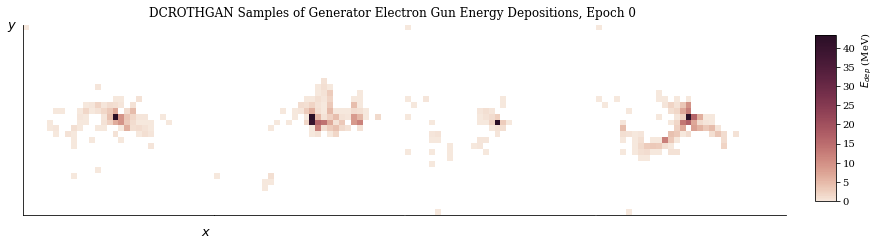

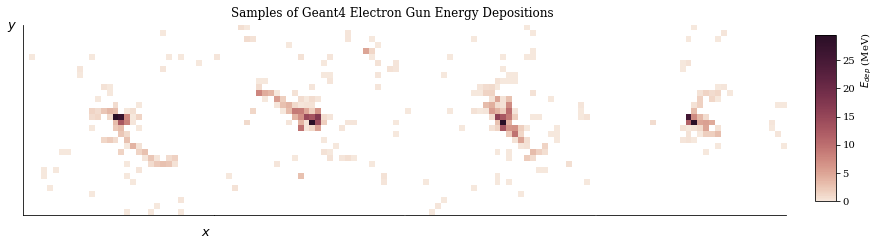

[70/100][0/3000] Loss_D: 0.0169 Loss_G: 5.0790 D(x): 0.9996 D(G(z)): 0.0163 / 0.0085
[70/100][100/3000] Loss_D: 0.0664 Loss_G: 3.7798 D(x): 0.9988 D(G(z)): 0.0615 / 0.0339
[70/100][200/3000] Loss_D: 0.0772 Loss_G: 2.6698 D(x): 0.9424 D(G(z)): 0.0150 / 0.0870
[70/100][300/3000] Loss_D: 0.5258 Loss_G: 0.6282 D(x): 0.7077 D(G(z)): 0.0005 / 0.5736
[70/100][400/3000] Loss_D: 0.2145 Loss_G: 2.5201 D(x): 0.9965 D(G(z)): 0.1870 / 0.0906
[70/100][500/3000] Loss_D: 0.8418 Loss_G: 1.7485 D(x): 0.9946 D(G(z)): 0.4887 / 0.2512
[70/100][600/3000] Loss_D: 0.3154 Loss_G: 2.4047 D(x): 0.9998 D(G(z)): 0.2520 / 0.1204
[70/100][700/3000] Loss_D: 0.0955 Loss_G: 3.3274 D(x): 0.9937 D(G(z)): 0.0824 / 0.0483
[70/100][800/3000] Loss_D: 0.0097 Loss_G: 5.2282 D(x): 0.9996 D(G(z)): 0.0093 / 0.0087
[70/100][900/3000] Loss_D: 0.1446 Loss_G: 3.5327 D(x): 0.9995 D(G(z)): 0.1132 / 0.0629
[70/100][1000/3000] Loss_D: 0.0975 Loss_G: 2.7653 D(x): 0.9135 D(G(z)): 0.0027 / 0.0809
[70/100][1100/3000] Loss_D: 3.4718 Loss_G: 0

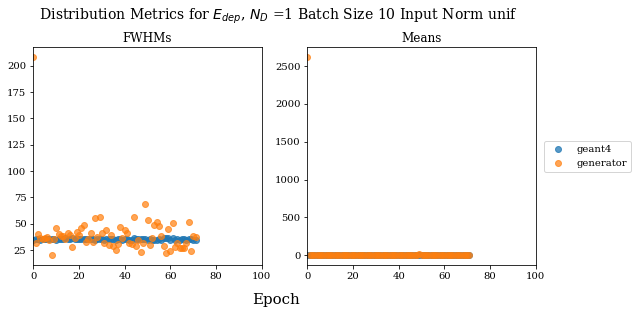

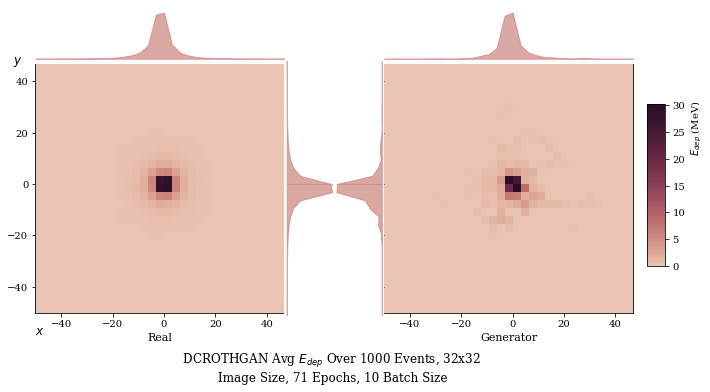

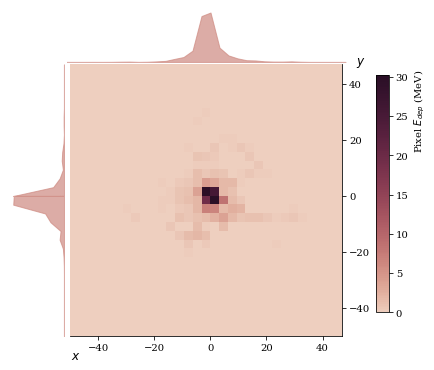

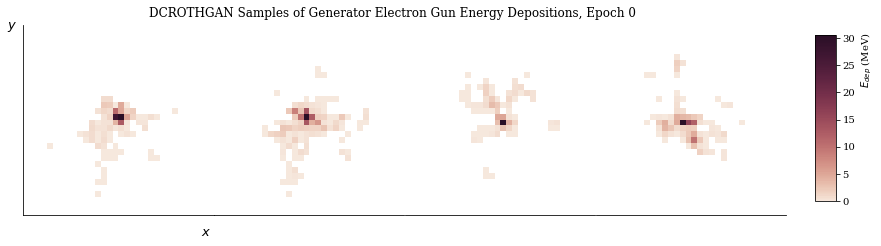

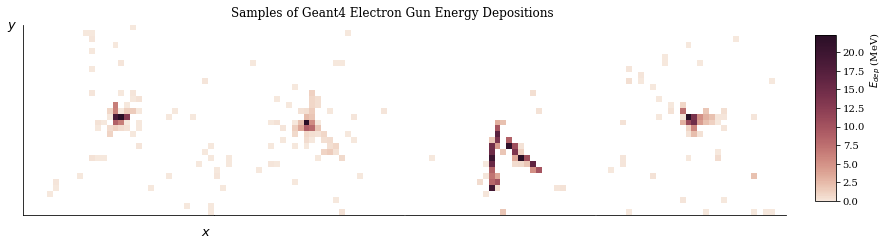

[71/100][0/3000] Loss_D: 0.0752 Loss_G: 3.1786 D(x): 0.9992 D(G(z)): 0.0705 / 0.0482
[71/100][100/3000] Loss_D: 0.0153 Loss_G: 4.7164 D(x): 1.0000 D(G(z)): 0.0150 / 0.0132
[71/100][200/3000] Loss_D: 0.0491 Loss_G: 3.5685 D(x): 0.9993 D(G(z)): 0.0466 / 0.0357
[71/100][300/3000] Loss_D: 0.0039 Loss_G: 6.4707 D(x): 0.9988 D(G(z)): 0.0027 / 0.0019
[71/100][400/3000] Loss_D: 0.3856 Loss_G: 4.7551 D(x): 0.7396 D(G(z)): 0.0061 / 0.0114
[71/100][500/3000] Loss_D: 0.0164 Loss_G: 5.8550 D(x): 0.9880 D(G(z)): 0.0043 / 0.0032
[71/100][600/3000] Loss_D: 0.0478 Loss_G: 3.4937 D(x): 0.9991 D(G(z)): 0.0454 / 0.0347
[71/100][700/3000] Loss_D: 1.4177 Loss_G: 2.4344 D(x): 0.9964 D(G(z)): 0.7039 / 0.1116
[71/100][800/3000] Loss_D: 0.0929 Loss_G: 2.7300 D(x): 1.0000 D(G(z)): 0.0872 / 0.0784
[71/100][900/3000] Loss_D: 0.1713 Loss_G: 5.3169 D(x): 1.0000 D(G(z)): 0.1504 / 0.0070
[71/100][1000/3000] Loss_D: 0.0993 Loss_G: 4.4439 D(x): 1.0000 D(G(z)): 0.0934 / 0.0132
[71/100][1100/3000] Loss_D: 0.1001 Loss_G: 3

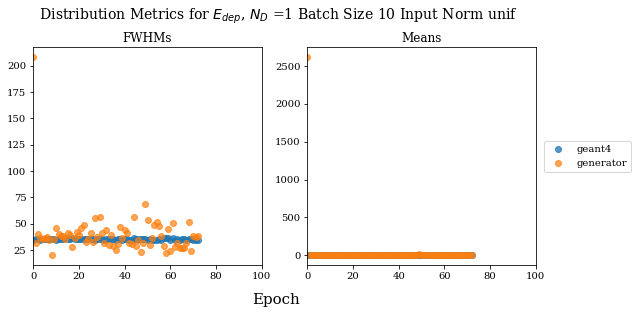

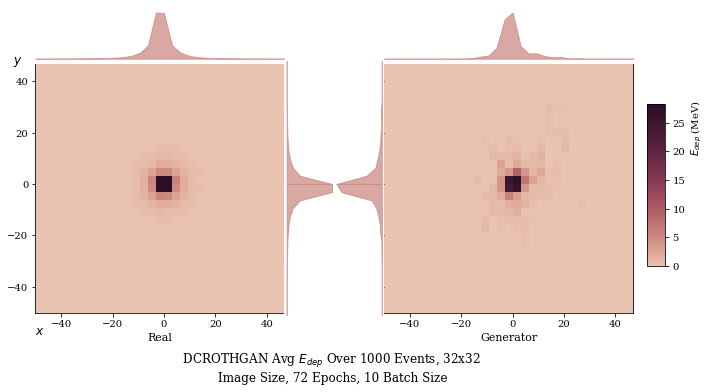

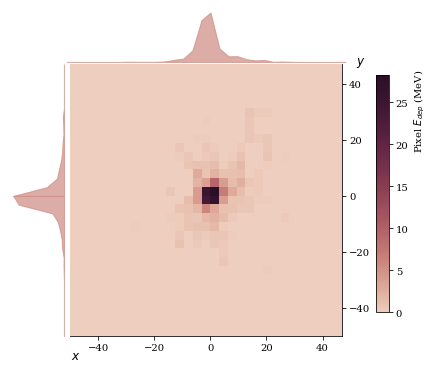

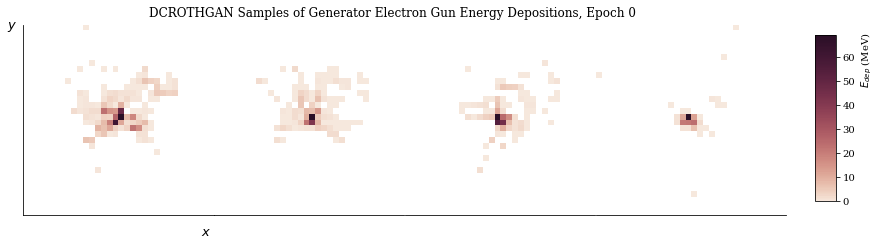

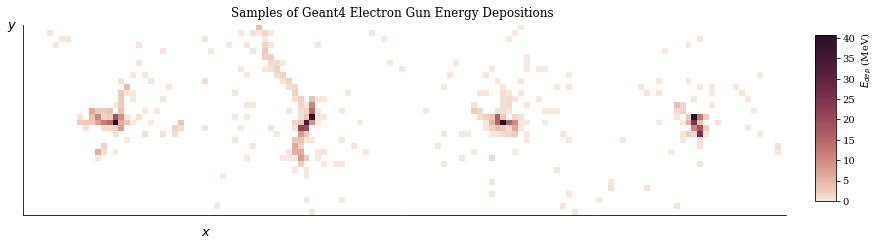

[72/100][0/3000] Loss_D: 0.3305 Loss_G: 0.9342 D(x): 0.7965 D(G(z)): 0.0470 / 0.4004
[72/100][100/3000] Loss_D: 0.1204 Loss_G: 2.4894 D(x): 1.0000 D(G(z)): 0.1089 / 0.1052
[72/100][200/3000] Loss_D: 0.0353 Loss_G: 4.0605 D(x): 0.9794 D(G(z)): 0.0142 / 0.0208
[72/100][300/3000] Loss_D: 0.0062 Loss_G: 6.0839 D(x): 0.9972 D(G(z)): 0.0034 / 0.0030
[72/100][400/3000] Loss_D: 0.0844 Loss_G: 3.0979 D(x): 0.9262 D(G(z)): 0.0052 / 0.0622
[72/100][500/3000] Loss_D: 0.0148 Loss_G: 4.9950 D(x): 0.9936 D(G(z)): 0.0083 / 0.0074
[72/100][600/3000] Loss_D: 0.0657 Loss_G: 3.6038 D(x): 0.9465 D(G(z)): 0.0101 / 0.0398
[72/100][700/3000] Loss_D: 0.0909 Loss_G: 2.6704 D(x): 0.9685 D(G(z)): 0.0559 / 0.0918
[72/100][800/3000] Loss_D: 0.0123 Loss_G: 4.8366 D(x): 0.9999 D(G(z)): 0.0121 / 0.0095
[72/100][900/3000] Loss_D: 0.1038 Loss_G: 3.2768 D(x): 0.9979 D(G(z)): 0.0958 / 0.0414
[72/100][1000/3000] Loss_D: 0.0998 Loss_G: 2.9172 D(x): 0.9724 D(G(z)): 0.0681 / 0.0643
[72/100][1100/3000] Loss_D: 0.0080 Loss_G: 5

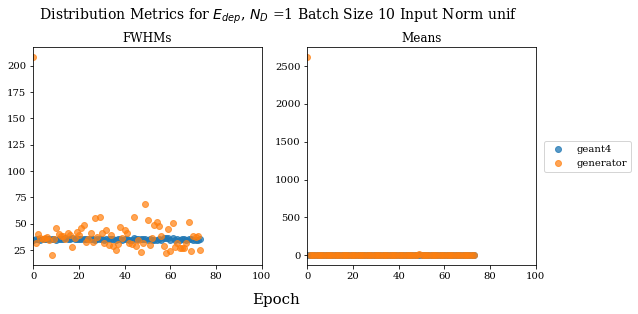

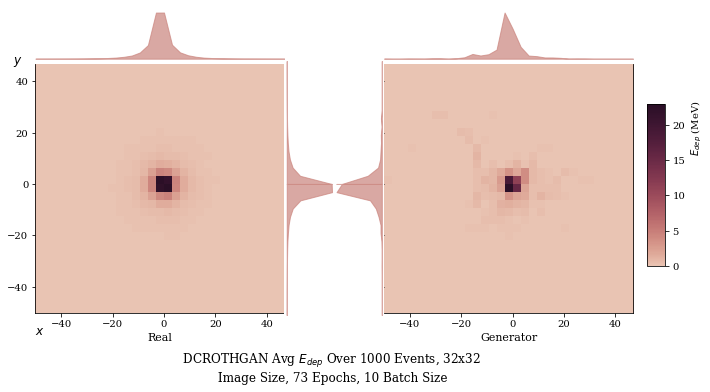

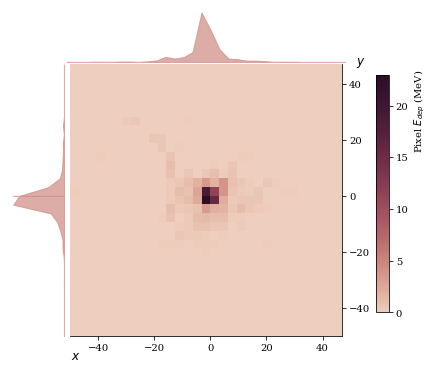

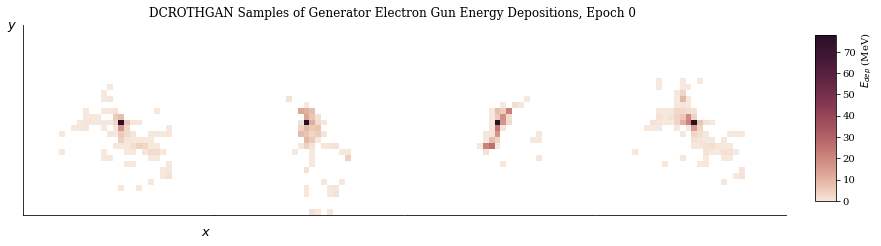

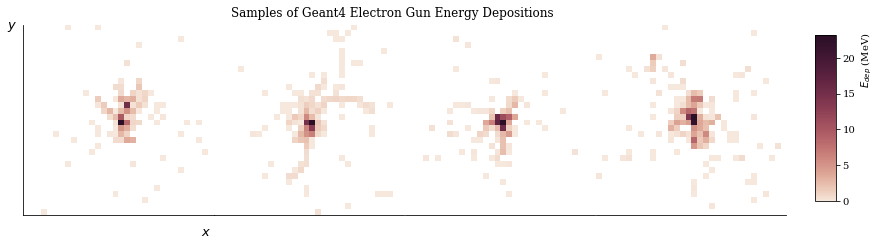

[73/100][0/3000] Loss_D: 0.1067 Loss_G: 2.7871 D(x): 0.9984 D(G(z)): 0.0988 / 0.0667
[73/100][100/3000] Loss_D: 0.0463 Loss_G: 4.8411 D(x): 0.9610 D(G(z)): 0.0050 / 0.0099
[73/100][200/3000] Loss_D: 0.1494 Loss_G: 3.1823 D(x): 0.9999 D(G(z)): 0.1221 / 0.0717
[73/100][300/3000] Loss_D: 0.1063 Loss_G: 2.9689 D(x): 0.9962 D(G(z)): 0.0970 / 0.0539
[73/100][400/3000] Loss_D: 0.0070 Loss_G: 7.0526 D(x): 0.9942 D(G(z)): 0.0011 / 0.0011
[73/100][500/3000] Loss_D: 0.3683 Loss_G: 0.0389 D(x): 0.8070 D(G(z)): 0.1269 / 0.9621
[73/100][600/3000] Loss_D: 0.0916 Loss_G: 3.8842 D(x): 0.9992 D(G(z)): 0.0820 / 0.0413
[73/100][700/3000] Loss_D: 0.4064 Loss_G: 1.0160 D(x): 0.8655 D(G(z)): 0.1959 / 0.4300
[73/100][800/3000] Loss_D: 0.1858 Loss_G: 1.7074 D(x): 0.9999 D(G(z)): 0.1625 / 0.2309
[73/100][900/3000] Loss_D: 0.0338 Loss_G: 4.5492 D(x): 0.9991 D(G(z)): 0.0314 / 0.0206
[73/100][1000/3000] Loss_D: 0.1233 Loss_G: 2.8056 D(x): 0.9604 D(G(z)): 0.0736 / 0.0746
[73/100][1100/3000] Loss_D: 3.8036 Loss_G: 1

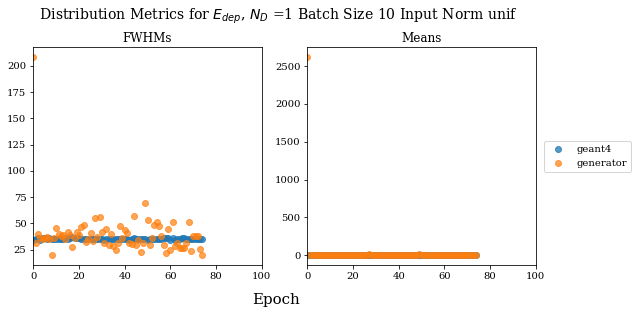

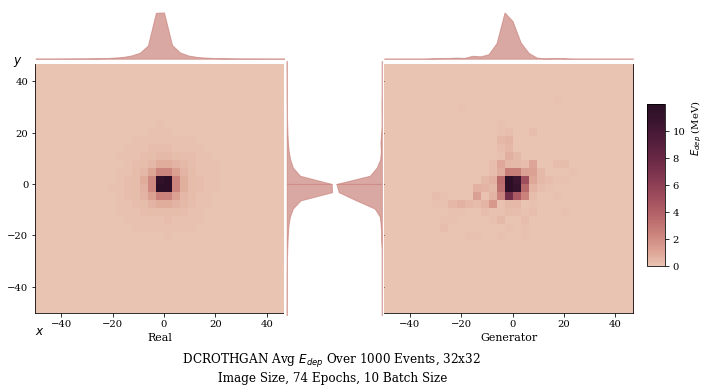

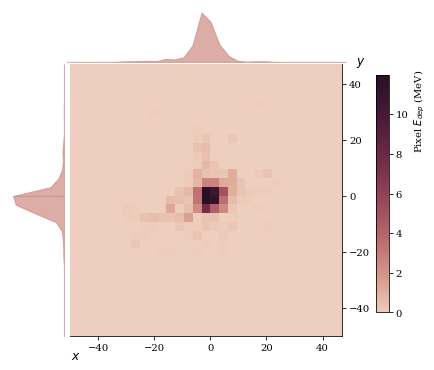

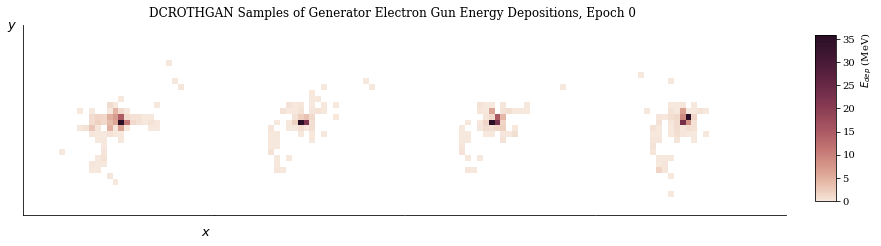

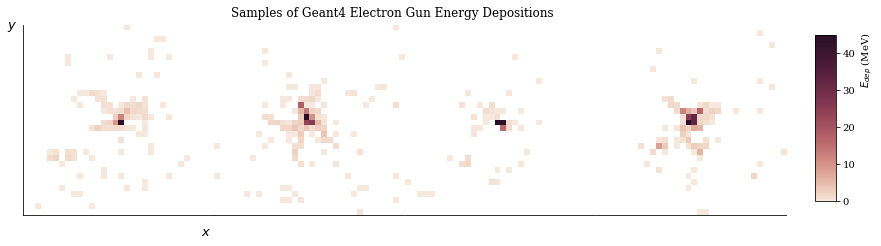

[74/100][0/3000] Loss_D: 0.0358 Loss_G: 4.8215 D(x): 0.9715 D(G(z)): 0.0066 / 0.0098
[74/100][100/3000] Loss_D: 0.0000 Loss_G: 9.6076 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[74/100][200/3000] Loss_D: 0.1910 Loss_G: 0.0839 D(x): 0.8409 D(G(z)): 0.0043 / 0.9207
[74/100][300/3000] Loss_D: 0.0211 Loss_G: 4.5729 D(x): 0.9978 D(G(z)): 0.0186 / 0.0119
[74/100][400/3000] Loss_D: 0.2171 Loss_G: 2.5277 D(x): 0.9995 D(G(z)): 0.1915 / 0.0886
[74/100][500/3000] Loss_D: 0.0602 Loss_G: 3.3880 D(x): 0.9985 D(G(z)): 0.0559 / 0.0422
[74/100][600/3000] Loss_D: 0.0113 Loss_G: 4.8680 D(x): 0.9995 D(G(z)): 0.0107 / 0.0092
[74/100][700/3000] Loss_D: 0.0773 Loss_G: 2.6704 D(x): 0.9585 D(G(z)): 0.0329 / 0.0881
[74/100][800/3000] Loss_D: 0.0398 Loss_G: 3.8593 D(x): 0.9998 D(G(z)): 0.0386 / 0.0256
[74/100][900/3000] Loss_D: 0.0823 Loss_G: 3.1061 D(x): 0.9900 D(G(z)): 0.0692 / 0.0497
[74/100][1000/3000] Loss_D: 0.0169 Loss_G: 4.9842 D(x): 0.9966 D(G(z)): 0.0133 / 0.0108
[74/100][1100/3000] Loss_D: 0.0068 Loss_G: 5

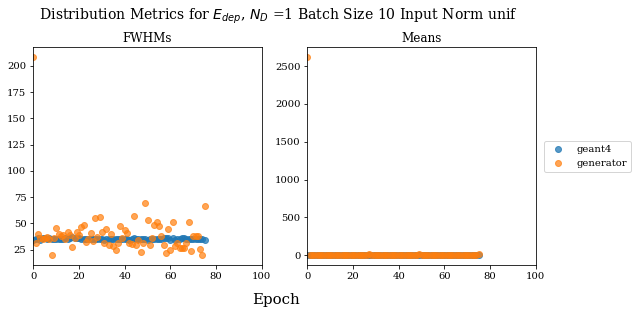

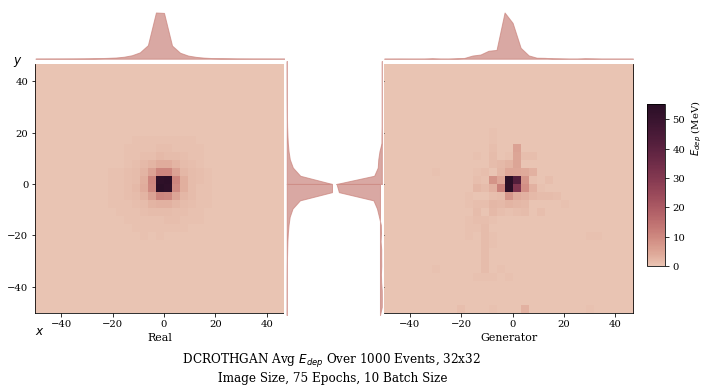

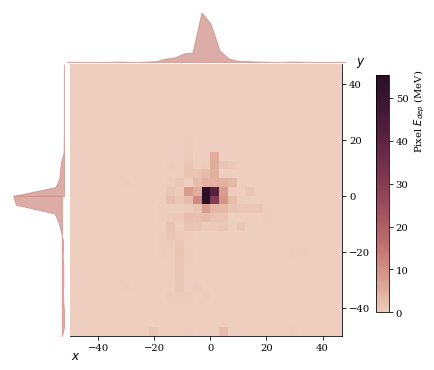

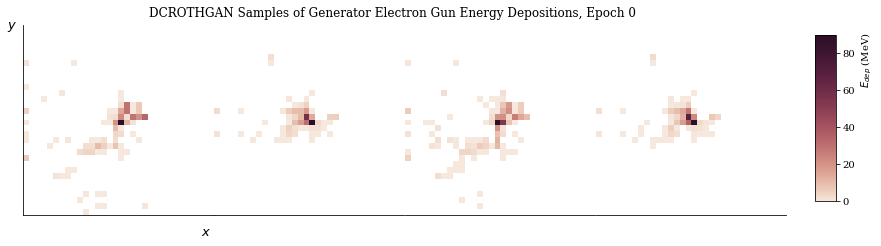

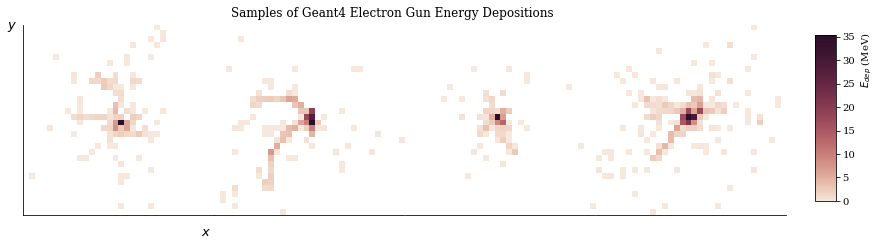

[75/100][0/3000] Loss_D: 0.0018 Loss_G: 7.3413 D(x): 0.9999 D(G(z)): 0.0017 / 0.0015
[75/100][100/3000] Loss_D: 0.0018 Loss_G: 6.7524 D(x): 0.9998 D(G(z)): 0.0016 / 0.0013
[75/100][200/3000] Loss_D: 0.0024 Loss_G: 6.2158 D(x): 1.0000 D(G(z)): 0.0024 / 0.0021
[75/100][300/3000] Loss_D: 0.0238 Loss_G: 4.0563 D(x): 0.9999 D(G(z)): 0.0234 / 0.0179
[75/100][400/3000] Loss_D: 0.6771 Loss_G: 0.6604 D(x): 0.9322 D(G(z)): 0.4297 / 0.5458
[75/100][500/3000] Loss_D: 0.0019 Loss_G: 7.1968 D(x): 0.9994 D(G(z)): 0.0012 / 0.0010
[75/100][600/3000] Loss_D: 0.1985 Loss_G: 2.9773 D(x): 0.9871 D(G(z)): 0.1595 / 0.0719
[75/100][700/3000] Loss_D: 0.0464 Loss_G: 6.9747 D(x): 1.0000 D(G(z)): 0.0441 / 0.0042
[75/100][800/3000] Loss_D: 0.1152 Loss_G: 2.9272 D(x): 0.9988 D(G(z)): 0.1059 / 0.0685
[75/100][900/3000] Loss_D: 1.0020 Loss_G: 0.1964 D(x): 0.6628 D(G(z)): 0.2834 / 0.8381
[75/100][1000/3000] Loss_D: 0.0848 Loss_G: 3.6757 D(x): 0.9970 D(G(z)): 0.0739 / 0.0459
[75/100][1100/3000] Loss_D: 4.0602 Loss_G: 0

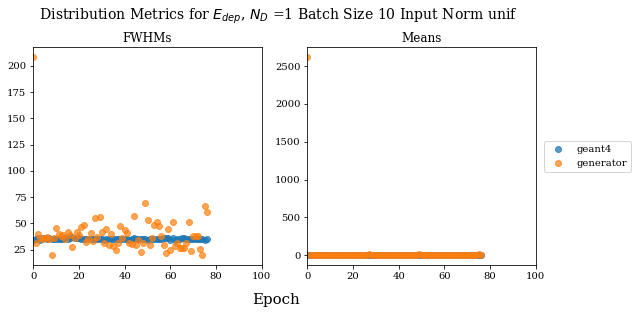

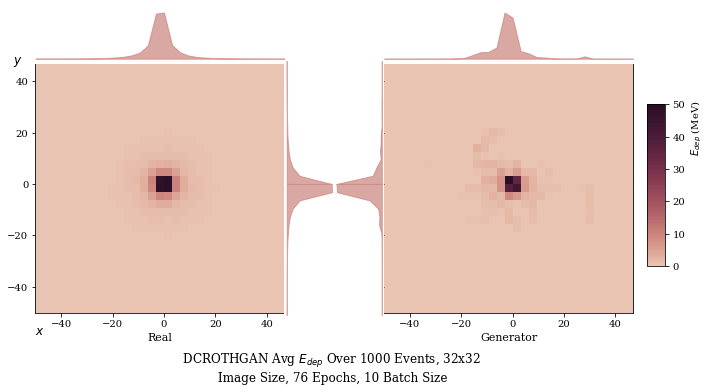

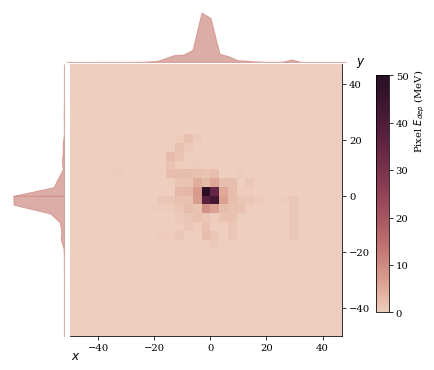

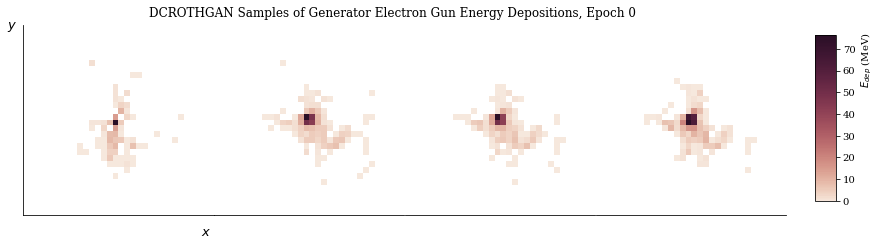

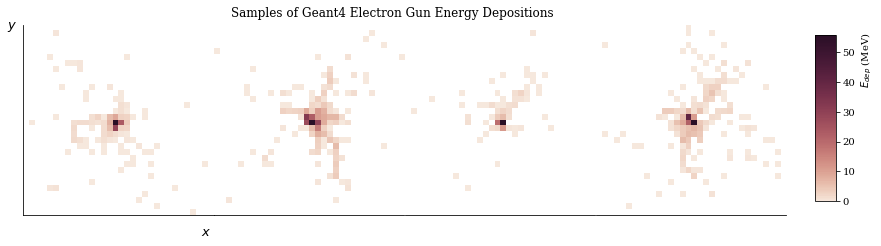

[76/100][0/3000] Loss_D: 0.0103 Loss_G: 5.1720 D(x): 0.9987 D(G(z)): 0.0090 / 0.0063
[76/100][100/3000] Loss_D: 0.0203 Loss_G: 5.5786 D(x): 0.9834 D(G(z)): 0.0034 / 0.0042
[76/100][200/3000] Loss_D: 0.0658 Loss_G: 3.8556 D(x): 0.9986 D(G(z)): 0.0621 / 0.0231
[76/100][300/3000] Loss_D: 0.0117 Loss_G: 5.5757 D(x): 0.9966 D(G(z)): 0.0083 / 0.0071
[76/100][400/3000] Loss_D: 0.0262 Loss_G: 4.1706 D(x): 0.9991 D(G(z)): 0.0249 / 0.0222
[76/100][500/3000] Loss_D: 0.5925 Loss_G: 2.1058 D(x): 0.9995 D(G(z)): 0.4188 / 0.1438
[76/100][600/3000] Loss_D: 0.0105 Loss_G: 5.3387 D(x): 0.9964 D(G(z)): 0.0068 / 0.0055
[76/100][700/3000] Loss_D: 0.1055 Loss_G: 2.9102 D(x): 0.9725 D(G(z)): 0.0726 / 0.0780
[76/100][800/3000] Loss_D: 0.1062 Loss_G: 3.2913 D(x): 1.0000 D(G(z)): 0.0978 / 0.0540
[76/100][900/3000] Loss_D: 0.0205 Loss_G: 4.5715 D(x): 0.9985 D(G(z)): 0.0188 / 0.0154
[76/100][1000/3000] Loss_D: 0.0470 Loss_G: 3.4133 D(x): 0.9605 D(G(z)): 0.0056 / 0.0394
[76/100][1100/3000] Loss_D: 0.2262 Loss_G: 4

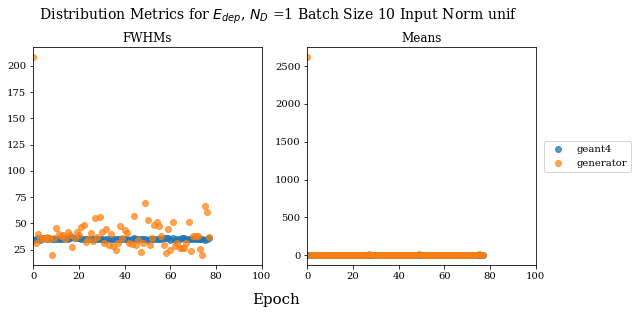

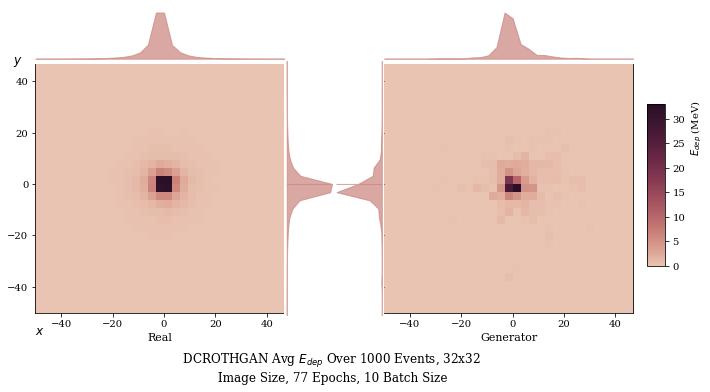

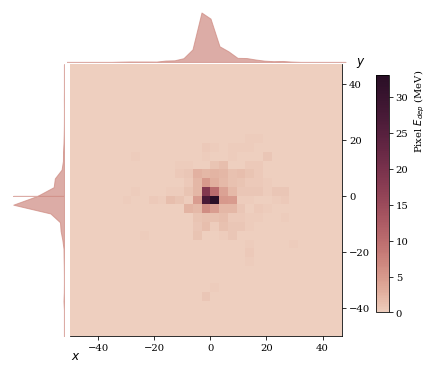

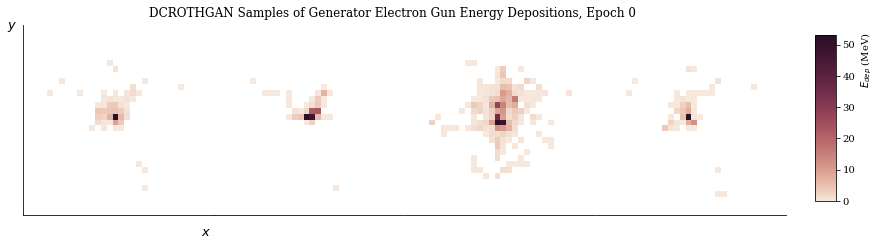

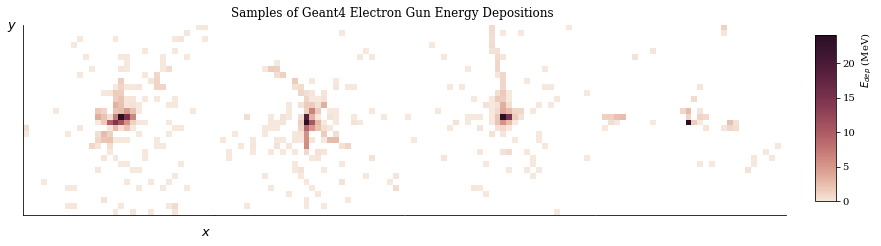

[77/100][0/3000] Loss_D: 0.0150 Loss_G: 4.6893 D(x): 0.9986 D(G(z)): 0.0134 / 0.0102
[77/100][100/3000] Loss_D: 0.2026 Loss_G: 0.1930 D(x): 0.8552 D(G(z)): 0.0357 / 0.8323
[77/100][200/3000] Loss_D: 0.5527 Loss_G: 2.3901 D(x): 0.9997 D(G(z)): 0.4153 / 0.0981
[77/100][300/3000] Loss_D: 0.0131 Loss_G: 4.8248 D(x): 0.9997 D(G(z)): 0.0127 / 0.0103
[77/100][400/3000] Loss_D: 0.0202 Loss_G: 5.2094 D(x): 0.9970 D(G(z)): 0.0168 / 0.0118
[77/100][500/3000] Loss_D: 0.0270 Loss_G: 5.6697 D(x): 0.9813 D(G(z)): 0.0079 / 0.0070
[77/100][600/3000] Loss_D: 0.0244 Loss_G: 4.3986 D(x): 0.9993 D(G(z)): 0.0233 / 0.0147
[77/100][700/3000] Loss_D: 0.0089 Loss_G: 5.7168 D(x): 0.9951 D(G(z)): 0.0039 / 0.0038
[77/100][800/3000] Loss_D: 0.0484 Loss_G: 3.5025 D(x): 0.9999 D(G(z)): 0.0468 / 0.0366
[77/100][900/3000] Loss_D: 0.0067 Loss_G: 6.2502 D(x): 0.9968 D(G(z)): 0.0034 / 0.0025
[77/100][1000/3000] Loss_D: 0.0011 Loss_G: 8.0624 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[77/100][1100/3000] Loss_D: 0.1747 Loss_G: 3

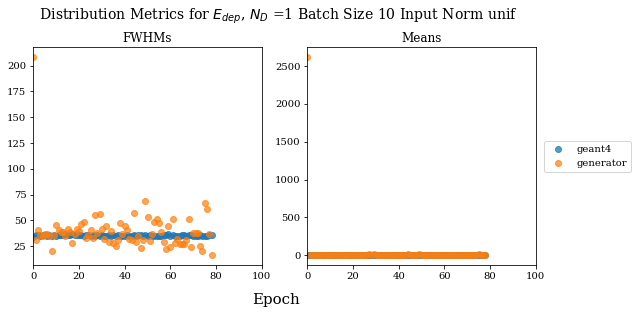

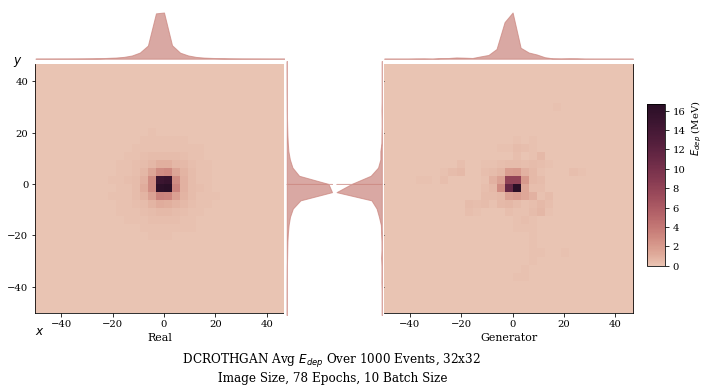

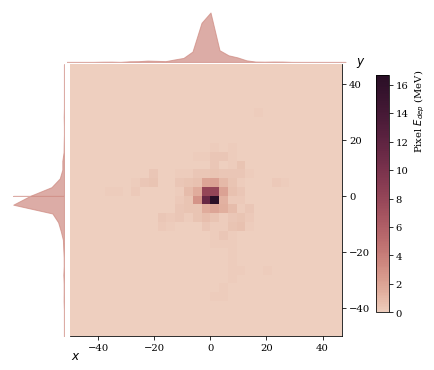

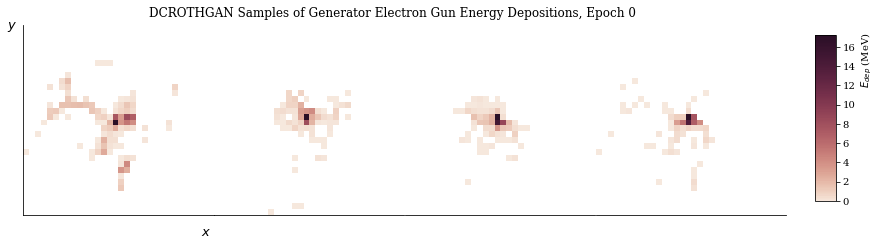

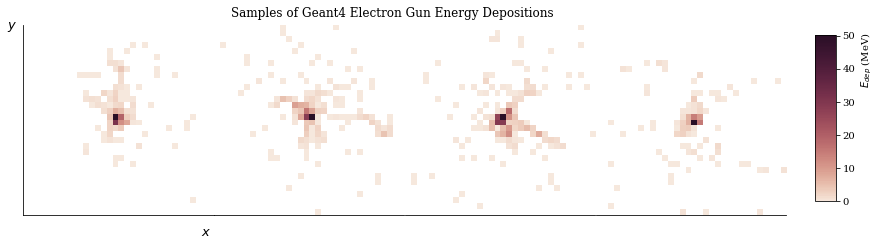

[78/100][0/3000] Loss_D: 0.2257 Loss_G: 2.7849 D(x): 0.9961 D(G(z)): 0.1947 / 0.0714
[78/100][100/3000] Loss_D: 0.0755 Loss_G: 3.3039 D(x): 0.9867 D(G(z)): 0.0592 / 0.0445
[78/100][200/3000] Loss_D: 0.0633 Loss_G: 4.1697 D(x): 0.9404 D(G(z)): 0.0013 / 0.0190
[78/100][300/3000] Loss_D: 0.0041 Loss_G: 6.1747 D(x): 0.9994 D(G(z)): 0.0035 / 0.0026
[78/100][400/3000] Loss_D: 0.0342 Loss_G: 3.8381 D(x): 0.9996 D(G(z)): 0.0329 / 0.0272
[78/100][500/3000] Loss_D: 0.0250 Loss_G: 4.6295 D(x): 0.9901 D(G(z)): 0.0148 / 0.0140
[78/100][600/3000] Loss_D: 0.0133 Loss_G: 5.6722 D(x): 0.9993 D(G(z)): 0.0125 / 0.0062
[78/100][700/3000] Loss_D: 0.0503 Loss_G: 3.7356 D(x): 0.9995 D(G(z)): 0.0483 / 0.0261
[78/100][800/3000] Loss_D: 0.0041 Loss_G: 5.8066 D(x): 0.9997 D(G(z)): 0.0038 / 0.0038
[78/100][900/3000] Loss_D: 0.1145 Loss_G: 2.8683 D(x): 0.9577 D(G(z)): 0.0662 / 0.0669
[78/100][1000/3000] Loss_D: 0.6937 Loss_G: 2.3760 D(x): 0.9936 D(G(z)): 0.4797 / 0.1010
[78/100][1100/3000] Loss_D: 0.0317 Loss_G: 3

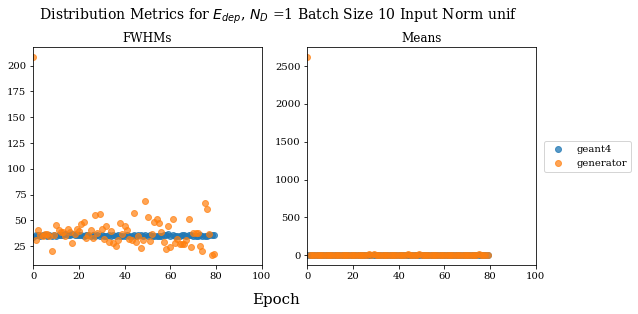

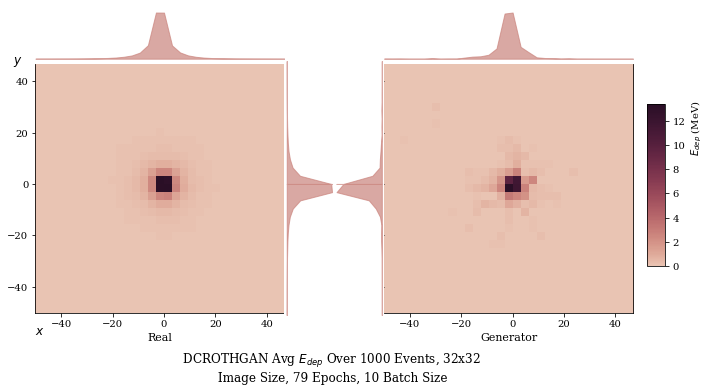

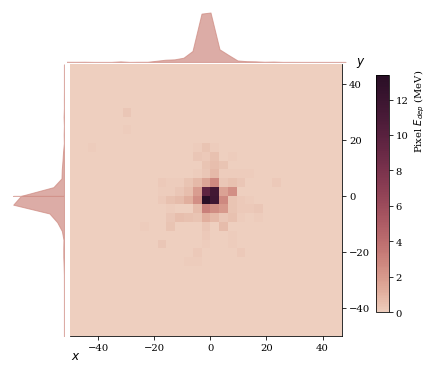

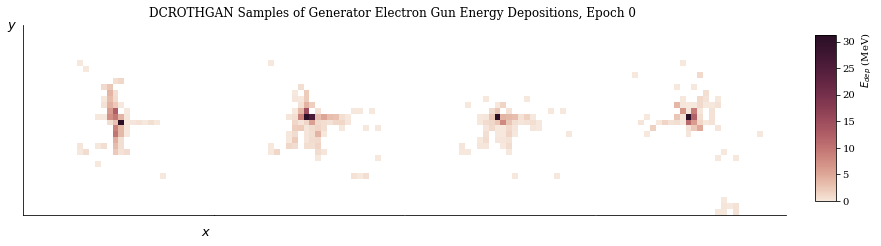

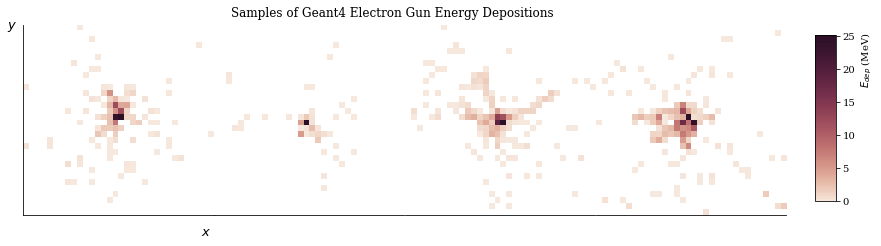

[79/100][0/3000] Loss_D: 0.4296 Loss_G: 2.2324 D(x): 0.9999 D(G(z)): 0.3371 / 0.1186
[79/100][100/3000] Loss_D: 0.0026 Loss_G: 6.3747 D(x): 1.0000 D(G(z)): 0.0025 / 0.0026
[79/100][200/3000] Loss_D: 0.0527 Loss_G: 3.0016 D(x): 0.9621 D(G(z)): 0.0132 / 0.0573
[79/100][300/3000] Loss_D: 0.0057 Loss_G: 7.0454 D(x): 0.9992 D(G(z)): 0.0049 / 0.0010
[79/100][400/3000] Loss_D: 0.0080 Loss_G: 5.8747 D(x): 0.9959 D(G(z)): 0.0038 / 0.0036
[79/100][500/3000] Loss_D: 0.0681 Loss_G: 3.6692 D(x): 0.9860 D(G(z)): 0.0516 / 0.0339
[79/100][600/3000] Loss_D: 0.0849 Loss_G: 3.1462 D(x): 1.0000 D(G(z)): 0.0809 / 0.0471
[79/100][700/3000] Loss_D: 0.1709 Loss_G: 3.3878 D(x): 0.9961 D(G(z)): 0.1368 / 0.0625
[79/100][800/3000] Loss_D: 0.0035 Loss_G: 5.8852 D(x): 0.9996 D(G(z)): 0.0031 / 0.0033
[79/100][900/3000] Loss_D: 0.0778 Loss_G: 4.1524 D(x): 0.9998 D(G(z)): 0.0715 / 0.0270
[79/100][1000/3000] Loss_D: 1.3676 Loss_G: 0.4381 D(x): 1.0000 D(G(z)): 0.7414 / 0.6475
[79/100][1100/3000] Loss_D: 0.0455 Loss_G: 4

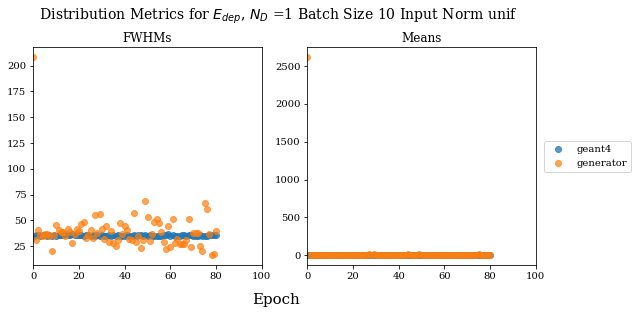

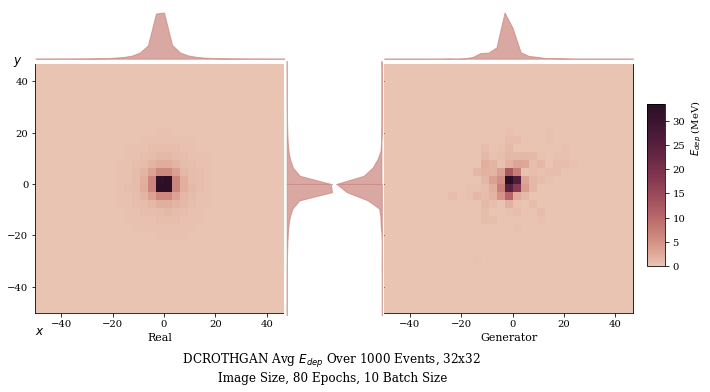

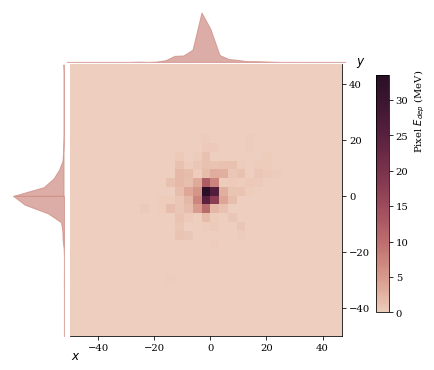

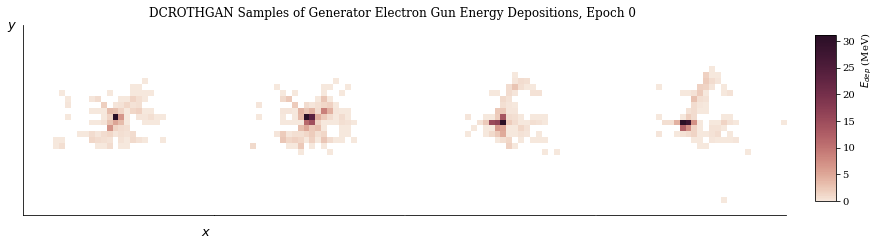

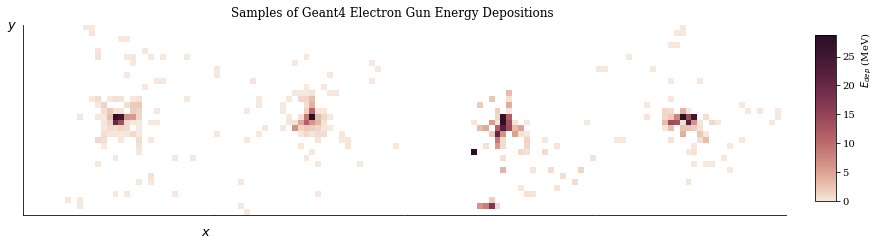

[80/100][0/3000] Loss_D: 0.0075 Loss_G: 7.7828 D(x): 0.9932 D(G(z)): 0.0006 / 0.0005
[80/100][100/3000] Loss_D: 0.6392 Loss_G: 1.4865 D(x): 0.9999 D(G(z)): 0.4522 / 0.2502
[80/100][200/3000] Loss_D: 0.0105 Loss_G: 5.2676 D(x): 0.9997 D(G(z)): 0.0100 / 0.0089
[80/100][300/3000] Loss_D: 0.0704 Loss_G: 3.2173 D(x): 0.9989 D(G(z)): 0.0662 / 0.0451
[80/100][400/3000] Loss_D: 0.1061 Loss_G: 2.8065 D(x): 0.9990 D(G(z)): 0.0990 / 0.0654
[80/100][500/3000] Loss_D: 0.1089 Loss_G: 5.4306 D(x): 0.9041 D(G(z)): 0.0002 / 0.0051
[80/100][600/3000] Loss_D: 0.0739 Loss_G: 3.4776 D(x): 0.9755 D(G(z)): 0.0465 / 0.0412
[80/100][700/3000] Loss_D: 0.0753 Loss_G: 3.8707 D(x): 0.9993 D(G(z)): 0.0707 / 0.0256
[80/100][800/3000] Loss_D: 0.0291 Loss_G: 3.8363 D(x): 0.9999 D(G(z)): 0.0285 / 0.0254
[80/100][900/3000] Loss_D: 0.9526 Loss_G: 0.9847 D(x): 0.9999 D(G(z)): 0.5969 / 0.4086
[80/100][1000/3000] Loss_D: 0.0213 Loss_G: 4.5639 D(x): 0.9971 D(G(z)): 0.0181 / 0.0135
[80/100][1100/3000] Loss_D: 0.0076 Loss_G: 5

Process Process-1597:
Process Process-1600:
Process Process-1595:
Process Process-1593:
Process Process-1599:
Process Process-1598:
Process Process-1594:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-1596:
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/chris

KeyboardInterrupt: 

    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    self._target(*self._args, **self._kwargs)
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    self._target

In [50]:
iter_range = range(niter)
iter_range = tqdm(iter_range)


#make save directory
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
#mydir=None
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
        
extraD = 1
gamma=0.1
        
for epoch in iter_range:
    if True:       
        data, n_events = make_samples(netG, n_events = 1000)
        real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True)
        genx_FWHM = hist_width(np.sum(data[1],1))
        realx_FWHM = hist_width(np.sum(data[0],1))
        genx_mean = np.sum(data[1],1).mean()
        #print genx_mean
        realx_mean = np.sum(data[0],1).mean()
        genx_FWHMs.append(genx_FWHM)
        realx_FWHMs.append(realx_FWHM)
        genx_means.append(genx_mean)
        realx_means.append(realx_mean)
        epochs.append(epoch)
        plot_all_metrics(genx_FWHMs, realx_FWHMs, genx_means, realx_means,epochs = epochs, save_dir = mydir)
        #plot_sns(n_events, save_dir=mydir,  epoch = epoch)
        plot_avg_both(data[0],data[1], n_events, save_dir = mydir,  epoch = epoch)
        plot_avg(data[1], n_events, save_dir= mydir,  epoch = epoch)
        plot_many(fake_data_array, real=False, save_dir=mydir, epoch = epoch)
        plot_many(real_data_array, real=True, save_dir=mydir, epoch = epoch)
    for i, data in enumerate(dataloader,0):
        for j in range(extraD):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))), do it more than generator
            ###########################
            # train with real
            netD.zero_grad()
            real_cpu = data[0].to(device).requires_grad_()
            #print(device)
            batch_size = real_cpu.size(0)
            label_r = torch.full((batch_size,), real_label, device=device)
            #real_cpu.requires_grad_()
            output_r = netD(real_cpu)
            #real_cpu.requires_grad_()
            #output_r.sum().requires_grad_()
            errD_real = criterion(output_r, label_r)
            #errD_real.backward()
            D_x = output_r.mean().item()
            penalty = grad(output_r.sum(), real_cpu, create_graph=True)[0].view(-1,1).norm(2,1).pow(2).mean()
            (errD_real + (gamma/2) * penalty).backward()
            #print(penalty)


            # train with fake
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label_f = torch.full((batch_size,), fake_label, device=device)
            #label.fill_(fake_label)
            output_f = netD(fake.detach())
            errD_fake = criterion(output_f, label_f)
            errD_fake.backward()
            D_G_z1 = output_f.mean().item()
            errD = errD_real + errD_fake
            #(errD + (gamma/2) * penalty).backward()
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label_r.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label_r)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
#         if i % 500 == 0:
#             vutils.save_image(real_cpu.data,
#                     '%s/real_samples.png' % outf,
#                     normalize=True)
#             fake = netG(fixed_noise)
#             vutils.save_image(fake.detach(),
#                     '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
#                    normalize=True)

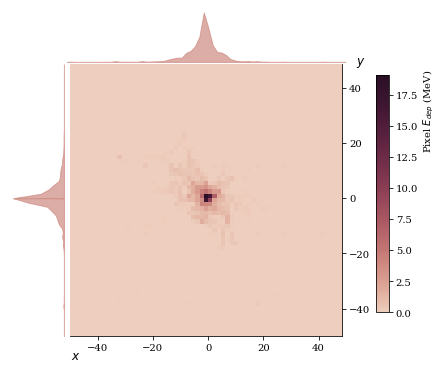

In [317]:
#FAKE
#from mpl_toolkits.axes_grid1 import make_axes_locatable



data, n_events = make_samples(netG,n_events = 1000, real=True, fake=True)

#data_diff = data_test[0] - data_test[1]
plot_avg(data[1], n_events = 1000, save_dir=None)

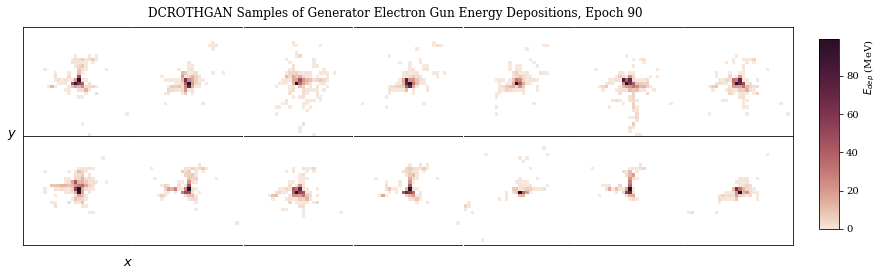

In [32]:
# mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/', 
#                      datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
# #mydir=None
# print(mydir)
# try:
#     os.makedirs(mydir)
# except OSError as e:
#     if e.errno != errno.EEXIST:
#         raise
        

#plot_sns(save_dir = None)
#real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True)
plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch)

In [54]:
test = np.squeeze(image_array)
for i in range(test.shape[0]):
    if np.isnan(test[i].max()) ==True:
        print(i)

In [ ]:
#REAL
plt.rc('font', family='serif')
many_samples = True
n_events = 5000
#make single samples for both real and fake. then make many samples and average if many_samples = True

#real
idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
real_image = image_array[idx][0]

#fake
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(noise)
fake_image = fake.to('cpu').detach().numpy()[0][0]
test_unnormed =  arctanh_unnormalize(fake_image, scale)

if many_samples == True:
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        fake_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed +=  arctanh_unnormalize(fake_image, scale)

real_image = real_image / n_events
test_unnormed = test_unnormed / n_events
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(9, 6), sharex=True, sharey=True)
xran = (-50,50)
yran = (-50,50)
extent = xran + yran





real_image[real_image < 0.0] = np.nan
cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
im = ax1.imshow(real_image, vmin = 0, extent=extent, origin='lower', cmap=cmap)




ax1.set_title("Real")
#cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        
test_unnormed[test_unnormed < 0.0] = np.nan
im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
ax2.set_title("Generator")

fig.tight_layout(rect=[0, 0, .9, 1])
cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
fig.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle(r" DCROTHGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
             + str(imageSize) + "x" +str(imageSize) + " Image Size, " + str(niter) 
             + " Epochs, " + str(batchSize) + " Batch Size", x = 0.5, y = 0.9)
plt.show()

In [412]:
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '/')
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/2018-05-16_17-09-05/


In [293]:
data_test, n_events = make_samples(netG,n_events = 10000, real=True, fake=True)
mydir = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/2018-05-18_18-39-35/"

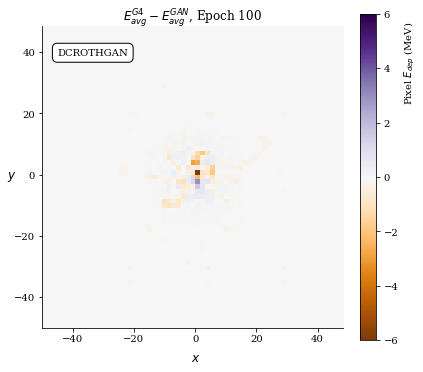

In [320]:

def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
    data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
    test_noNans = np.copy(data)
    test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
    #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
    #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
    cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = -6,vmax = 6, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
    ax.text(-45, 39, 'DCROTHGAN', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #plt.legend(loc = 'best')
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.51,-0.08)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(-.1,0.48)
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')

    plt.show()
    return

plot_difference(data_test, save_dir = mydir, epoch = 100)


In [ ]:

def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale)
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
withMarginals = False
save_dir = mydir
test_noNans = np.copy(data)
test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

xran = (-50,50)
yran = (-50,50)
extent = xran + yran
#cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
#cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
#cmap = sns.color_palette("BrBG", 7, as_cmap=True)
cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()

if withMarginals == False:
    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = -6,vmax = 6, extent=extent, origin='lower', cmap='PuOr')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    plt.title("DCROTHGAN Difference between average Geant4 \n Image and Average Generator Image")
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')

else:
    fig=plt.figure(figsize=(6, 6))
    marginals_str = 'withMarginals'
    img=test_noNans
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())

    gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
    gs.update(hspace=0, wspace=0)

    ax = fig.add_subplot(gs[1,1])
    im = ax.imshow(test_unnormed, vmin = -10, vmax = 10, extent = extent, origin = 'lower', cmap = 'PuOr')
    cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
    cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
    ax.yaxis.set_ticks_position('right')
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    ax.spines["top"].set_visible(False)
    ax.spines['left'].set_visible(False)

    axl = fig.add_subplot(gs[1,0], sharey=ax)
    axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
    axl.invert_xaxis()
    axb = fig.add_subplot(gs[0,1], sharex=ax)
    axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

    plt.setp(axl.get_yticklabels(), visible=False)
    plt.setp(axb.get_xticklabels(), visible=False)
    plt.setp(axl.get_xticklabels(), visible=False)
    plt.setp(axb.get_yticklabels(), visible=False)

    axl.yaxis.set_ticks_position('none')
    axb.xaxis.set_ticks_position('none')
    axl.xaxis.set_ticks_position('none')
    axb.yaxis.set_ticks_position('none')


    axl.spines["top"].set_visible(False)
    axl.spines['right'].set_visible(False)
    axl.spines['left'].set_visible(False)
    axl.spines['bottom'].set_visible(False)
    axb.spines["top"].set_visible(False)
    axb.spines["right"].set_visible(False)
    axb.spines["left"].set_visible(False)
    axb.spines["bottom"].set_visible(False)
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.02,-0.05)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(1.07,0.98)
    plt.title("DCROTHGAN Difference between average Geant4 Image \n and Average Generator Image")
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
